In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt 
import scipy.linalg as SLA
import torch.linalg as TLA
import math
import warnings
import seaborn as sns
from scipy.linalg import toeplitz
from utils import sample_PLN, log_stirling
warnings.filterwarnings("ignore")
torch.set_default_dtype(torch.float64)
import scipy
import time
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
#from sqrtm import sqrtm
import threading
from utils import C_from_Sigma,build_block_Sigma, log_stirling

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
device = torch.device('cpu')

In [5]:
def compare_models(dict_models,name_doss , save = False):
    '''
    function to compare models. It will plot the MSE of Sigma and beta according to the true parameters and 
    the log_likelihood in the y axis with the runtime in the x-axis.
    
    args : 
        'dict_models' dict with key the name of the model and values the model (MC_PLNPCA object where you
                      have called model.fit_IMPS()).
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the figure will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. you can save the figure if save = True
    '''
    #best_model = MC_PLNPCA(q, batch_size, true_value = True)
    #best_model.init_data(Y_sampled, O, covariates)
    
    
    #get the max of all the likelihoods for a nice plot. We intialize the max with the likelihood of the 
    # model that has the true parameters (unknown in practice) 
    #best_log_like = best_model.compute_mean_log_likelihood(0.0001)
    #max_ = best_log_like
    max_ = 0 
    for name,model in dict_models.items():
        current_max = np.max(np.array(model.log_likelihood_list))
        max_ = max(max_,current_max)
    fig,ax = plt.subplots(3,1,figsize = (15,15))
    best_model = Basic_IMPS(q, average = 100, true_value = True)
    best_model.init_data(Y, O, covariates)
    best_model.Y_b,best_model.O_b, best_model.covariates_b, best_model.batch_size = Y, O, covariates, n
    best_log_like = best_model.infer_batch_p_theta(1000, 0.1, 1000)
    
    
    
    ax[0].axhline(best_MSE_Sigma, label = 'MLE latent layer ')
    ax[1].axhline(best_MSE_beta, label = 'MLE latent layer')
    for name,model in dict_models.items() : 
        

        abscisse = model.running_times
        plt.subplots_adjust(hspace = 0.4)
        ax[0].plot(abscisse, model.MSE_Sigma_list, label = name)
        ax[0].legend()
        ax[0].set_title('MSE Sigma')
        
        ax[0].set_ylabel('MSE')
        ax[0].set_yscale('log')
        
        ax[1].plot(abscisse, model.MSE_beta_list, label = name)
        ax[1].legend()
        ax[1].set_title('MSE beta') 
        

        ax[1].set_ylabel('MSE')
        ax[1].set_yscale('log')
        
        ax[2].plot(abscisse, np.array(model.log_likelihood_list)-max_, label = name )
        ax[2].legend()
        ax[2].set_title('log_likelihood')
        ax[2].set_ylabel('log_likelihood')
        ax[2].set_yscale('symlog')
    
    ax[2].axhline(best_log_like-max_, c = 'red', label = 'best likelihood')
    plt.suptitle(name_doss)
    if save : 
        plt.savefig(name_doss)
    plt.show()

In [6]:
def find_best_lr(optimizer,N_iter, acc, lrs, q, batch_size,average = 300):
    '''
    function that is supposed to find the best lr within a grid of lr (lrs) for 
    an optimizer to fit the MC_PLNPCA method. the metric used
    to discriminate each lr is the log likelihood. We parallelized the code to go faster. 
    
    args: otpimizer : should be an object of torch.optim., for example torch.optim.Rprop. 
    
        N_iter : int. The number of iterations you want to do when running the .fit_IMPS method.
    
        acc : float positive. the accuracy you want when running the .fit_IMPS method. 
        
        lrs : list. the grid of lr.
        
        q : the dimension q you want for the model. should be small.  
        
        batch_size : int. The batch_size you want  when running the .fit_IMPS method.
        
        average : int. the average argument for the model. 
        
        
        
    returns : the best lr according to the metric
    '''
    #initiate some lists.
    metrics = list()
    models = list()
    ts = list()
    # launch the models with the right lr. 
    #model = Basic_IMPS(q, average = average, true_value = False)
        
    #model.fit(Y,O,covariates,N_iter,0.001,0.01,        400, 0.1,          batch_size , optimizer)
    for lr in lrs: 
        model = Basic_IMPS(q, average = average, true_value = False)
        
        t = threading.Thread(target =model.fit,
                            args = [Y,O,covariates,N_iter,acc,lr,        300, 0.1,            batch_size, optimizer])
                                                          # acc    #N_iter_mode  lr_mode        # batch_size #class optimizer
        t.start()
        ts.append(t)
        models.append(model)
        
    # join each threading. 
    for t in ts: 
        t.join()
    # get the metrics for each model. 
    for i, model in enumerate(models) :
        metrics.append(np.mean(np.array(model.log_likelihood_list)))
    metrics = np.nan_to_num(np.array(metrics),-100000)
    argmax = np.argmax(metrics)#argmax of the metrics 
    best_lr = lrs[argmax]
    return best_lr, dict(zip(lrs,models)), models[argmax]  #the best lr, the dict in case 
                                                           # we need it to comopare, and the best model. 
    
lrs =[0.0001, 0.001, 0.002,0.003, 0.0002, 0.0005, 0.0008] 
best_lr, models, best_model = find_best_lr(torch.optim.Rprop,60, acc = 0.1, lrs = lrs, q = q, batch_size = 10,average = 300)

NameError: name 'q' is not defined

In [7]:
dict_optimizers = {'Adamax' : torch.optim.Adamax,
                   'Adadelta': torch.optim.Adadelta, 
                   'Adam': torch.optim.Adam, 
                   'Adagrad' : torch.optim.Adagrad,
                  'Rprop' : torch.optim.Rprop, 
                   'RMSprop' : torch.optim.RMSprop,
                  'SGD' : torch.optim.SGD}

In [8]:
#compare_models(models, '')

In [9]:
def launch_optimizers(dict_optimizers,N_iter,best_lrs, acc, q,batch_size,average = 300):
    '''
    launch some optimizers to fit the .fit_IMPS method of the MC_PLNPCA object to compare them after. 
    args : 
         dict_optimizer : dictionnarie. dict that contains the optimizer. example: {'Rprop': torch.optim.Rprop}
         
         N_iter : int. the number of iteration you want the models to do for each optimizer. 
         
         best_lrs : list of float. the (best)learning rate of each optimizer.
    
         acc : positive float. the accuracy you want when running the .fit_IMPS method. 
         
         q : int. the dimension you want for the MC_PLNPCA object. 
         
         batch_size : int. the batch_size you want. 
         
    return : a dict of model. The key are the name of the optimizer, the values are the models trained with 
            the corresponding optimizer. 
    '''
    print('best_lrs ', best_lrs)
    ts = list()  
    models = list()
    # lauch all the model with the right optimizer in a parallelized fashion. 
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        params = []
        for i,(name,optimizer)  in enumerate(dict_optimizers.items()): 
            
            params.append([Y,O,covariates,N_iter,acc,lr,        300, 0.1,            batch_size, optimizer])
        #did not have the choice to do this since I need to get the returned value back. 
        futures = [executor.submit(Basic_IMPS(q, average = average, true_value = False).fit, param[0],param[1],param[2],param[3],param[4],param[5],param[6]) for param in params]
        models =  [f.result() for f in futures]
    # return the dict with the corresponding values and keys. 
    return dict(zip(dict_optimizers.keys(), models))
# all_models = launch_optimizers()

In [10]:
def sample_gaussians(N_samples, mean,sqrt_Sigma):
    '''
    samples some gaussians with the right mean and variance. Be careful, we ask 
    for the square root of Sigma, not Sigma. will detect automatically if we are using batches or not.  
    '''
    q = mean.shape[0]
    if len(mean.shape)> 1 : 
        q = mean.shape[1]
        W_orig = torch.randn(N_samples, 1,q,1)
    elif len(mean.shape) == 1 : 
        W_orig = torch.randn(N_samples, q, 1)
    W = torch.matmul(sqrt_Sigma.unsqueeze(0), W_orig).squeeze() + mean.unsqueeze(0)
    return W

def log_gaussian_density(W, mu_p,Sigma_p): 
    '''
    computes the log density of a gaussian
    '''
    dim = W.shape[-1]
    const = torch.sqrt((2*math.pi)**dim*torch.det(Sigma_p))
    Wmoinsmu = W-mu_p.unsqueeze(0)
    inv_Sig = torch.inverse(Sigma_p)
    if len(mu_p.shape)>1 : 
        log_d = -1/2*torch.matmul(torch.matmul(inv_Sig.unsqueeze(0), Wmoinsmu.unsqueeze(3)).squeeze().unsqueeze(2), Wmoinsmu.unsqueeze(3))
    elif len(mu_p.shape)== 1 :  
        log_d = -1/2*torch.matmul(Wmoinsmu.unsqueeze(1),torch.matmul(inv_Sig.unsqueeze(0), Wmoinsmu.unsqueeze(2))).squeeze()
    return log_d.squeeze() - torch.log(const)



In [11]:
def sample_students(N_samples,mu,Sigma,nu):
    '''
    sample some variables from a student law with mean mu, variance sigma and nu degrees of freedom.
    '''
    sqrt_Sigma = torch.from_numpy(SLA.sqrtm(Sigma))
    normale = torch.randn(N_samples,1,q)
    num = torch.matmul(normale, sqrt_Sigma.unsqueeze(0)).squeeze()
    denom = torch.sum(torch.randn(nu,N_samples)**2,axis = 0)
    prod = torch.multiply(num, torch.sqrt(nu/denom).unsqueeze(1))
    return mu + prod


def student_density(W,mu,Sigma,nu):
    '''
    density of a student law. The student law has heavier tails than the gaussian, so we will
    avoid infinite variance. This function takes W of size either (N_s, q) or q. Returns the density 
    along the last axis. 
    '''
    q = W.shape[-1]
    const = math.gamma((nu+q)/2)
    const/= math.gamma(nu/2)
    const/= (nu*math.pi)**(q/2)
    const/= torch.sqrt(torch.det(Sigma))
    Wmoinsmu = W-mu
    if len(W.shape)>1:
        W_term = torch.matmul(torch.matmul(torch.inverse(Sigma).unsqueeze(0), Wmoinsmu.unsqueeze(2)).squeeze().unsqueeze(1),Wmoinsmu.unsqueeze(2))
    else : 
        W_term = Wmoinsmu@torch.inverse(Sigma)@Wmoinsmu
    return const*(1+W_term/nu)**(-(nu+q)/2)

def log_student_density(W,mu,Sigma,nu):
    return torch.log(student_density(W,mu,Sigma,nu))

In [12]:
def log_P_WgivenY(Y_i,covariates_i, O_i, W,C,beta):
    '''
    computes the log of the density of (W,Y_i) given Y_i. 
    args : 
        Y_i : tensor of size p 
        covariates_i : tensor of size d 
        O_i : tensor of size p 
        W : torch of size q. or (N_samples, q) should be a gaussian or a student. 
            if the dimension is (N_samples, q), we will return a vector of dimension N_samples
            in which each coordinate i will be the log posterior of W[i,:]. 
        Explanation of why we want two cases : we either want to compute the 
        log posterior of a lot of W, that is (N_samples,q), or we want to get the mode, 
        so that we only need one vector of size q. 

    return : the log of the probability of (W,Y_i) given Y_i. For the formula see MC_PLNPCA.ipynb
    '''
    length = len(W.shape)
    if length == 1 : 
        CW = W.reshape(1,-1)@(C.T)
    elif length == 2 : 
        CW = torch.matmul(C.unsqueeze(0),W.unsqueeze(2)).squeeze()
    A_i = O_i +   CW +covariates_i@beta
    return -q/2*math.log(2*math.pi)-1/2*torch.norm(W, dim = -1)**2 + torch.sum(-torch.exp(A_i)   + A_i*Y_i - log_stirling(Y_i) , axis = -1).squeeze()     

def batch_log_P_WgivenY(Y_b, covariates_b, O_b, W, C, beta): 
    '''
    does the same as log_P_W_givenY but add one more dimension for computing this for a batch instead of 
    only one element. 
    '''
    length = len(W.shape)
    if length == 2 : 
        CW = torch.matmul(C.unsqueeze(0),W.unsqueeze(2)).squeeze()
    elif length == 3 : 
        CW = torch.matmul(C.unsqueeze(0).unsqueeze(1), W.unsqueeze(3)).squeeze()
    A_b = O_b + CW + covariates_b@beta
    
    return -q/2*math.log(2*math.pi)-1/2*torch.norm(W, dim = -1)**2 + torch.sum(-torch.exp(A_b)   + A_b*Y_b - log_stirling(Y_b) , axis = -1)


In [41]:
class Basic_IMPS():
    def __init__(self, q,average = 50, true_value = False, sampler = 'gaussian'):
        self.sampler = sampler
        self.q = q
        self.average = average 
        self.true_value = true_value
        self.MSE_beta_list = list()
        self.MSE_Sigma_list = list()
        self.running_times = list()
        self.log_likelihood_list = list()
        self.last_likelihoods = list()
        self.log_likelihoods = list()
        self.norm_grad_log_beta_list = list()
        self.norm_grad_log_C_list = list()
        self.cmpt = 0 
        self.var_weights = np.array([])
    def init_data(self, Y,O,covariates): 
        '''
        Initialise some usefuls variables given the data. 
        We also initialise C and beta. 
        '''
        torch.manual_seed(0)
        self.Y = Y.float()
        self.covariates = covariates 
        self.O = O 
        self.n = Y.shape[0] 
        self.p = Y.shape[1]
        self.d = self.covariates.shape[1]
        noise = torch.randn(self.p) 
        self.Sigma =  (torch.diag(noise**2)+ 1e-1)
        self.last_betas = torch.zeros(self.average,self.d,self.p) # init of the average of the last betas
        self.last_Cs = torch.zeros(self.average, self.p, self.q) #init of the average of the last Sigmas
        # init C with an array of size (p,q)
        self.C = torch.clone(torch.from_numpy(C_from_Sigma(self.Sigma,self.q)))
        # init beta 
        self.beta = torch.randn(self.d,self.p)
        # if we want to take the true value of C and beta 
        if self.true_value : 
            #self.C = torch.clone(true_C)
            self.beta = torch.clone(true_beta)
        #setting some gradients for optimization. 
        self.C.requires_grad_(True)
        self.beta.requires_grad_(True)
        self.C_mean = torch.clone(self.C)
        self.beta_mean = torch.clone(self.beta)
        
    def get_batch(self,batch_size, save_batch_size = True): 
        '''
        get the batches required to do a  minibatch gradient ascent.  
        
        args : 
                'batch_size' int.  the batch size you want. 
                
        returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                    since the rest of the division is not always 0)
        '''
        #np.random.seed(2)
        indices = np.arange(self.n)
        np.random.shuffle(indices)
        #if we want to set the batch size of the model to the given batch_size 
        if save_batch_size : 
            self.batch_size = batch_size
        # get the number of batches and the size of the last one. 
        nb_full_batch, last_batch_size  = self.n//batch_size, self.n % batch_size  
        for i in range(nb_full_batch): 
            yield   (self.Y[indices[i*batch_size: (i+1)*batch_size]], 
                    self.covariates[indices[i*batch_size: (i+1)*batch_size]],
                    self.O[indices[i*batch_size: (i+1)*batch_size]], 
                    ) 
        if last_batch_size != 0 : 
            if save_batch_size : 
                self.batch_size = last_batch_size
            yield   (self.Y[indices[-last_batch_size:]], 
                    self.covariates[indices[-last_batch_size:]],
                    self.O[indices[-last_batch_size:]]
                    )

        

    def keep_records(self,log_like): 
        '''
        function that keep some records in order to plot the evolution after.
        '''
        average_log_like = self.average_params(log_like)
        # keep the records of the norm of the gradients and the MSE wrt the true parameter
        self.norm_grad_log_beta_list.append((torch.norm(self.beta.grad)/(self.d*self.p)).item())
        self.norm_grad_log_C_list.append((torch.norm(self.C.grad)/(self.p*self.q)).item())
        self.MSE_beta_list.append(torch.mean((self.beta_mean -true_beta)**2).item())
        self.MSE_Sigma_list.append(torch.mean((self.C_mean@(self.C_mean.T) -true_Sigma_sampling)**2).item())
        self.running_times.append(time.time()-self.t0)
        #print('average log_like : ', average_log_like)
        self.log_likelihood_list.append(average_log_like)
        
    
    
    def average_params(self,log_like): 
        '''
        method that averages the parameters in order to smooth the variance. 
        We will take, for example, the last self.average betas computed to make 
        a better approximation of beta. We will do the same for C.
        This function adds the last parameters computed to update the mean of the parameter. 
        If we have not enough betas or Sigmas (less than self.average), the mean will be on those parameters. 
        args : 
            log_like : the likelihood computed with the current parameters.
        
        returns : 
                None but update the mean of the last self.average parameters.  
        '''
        
        self.cmpt +=1 # to keep track of the number of parameters we have for the mean
        # remove the oldest parameters and add the more recent one.
        self.last_betas[1:self.average] = torch.clone(self.last_betas[0: self.average-1].detach())
        self.last_betas[0] = torch.clone(self.beta.detach())
        self.last_Cs[1:self.average] = torch.clone(self.last_Cs[0: self.average-1].detach())
        self.last_Cs[0] = torch.clone(self.C.detach())
        self.last_likelihoods.append(log_like)
        # update the mean of the parameter
        
        # if we have enough parameters 
        if self.cmpt > self.average : 
            del(self.last_likelihoods[0])
            self.C_mean = torch.mean(self.last_Cs, axis = 0)
            self.beta_mean = torch.mean(self.last_betas, axis = 0)
            return np.mean(np.array(self.last_likelihoods))
        
        # if we don't have enough parameters. 
        else : 
            self.C_mean = torch.sum(self.last_Cs, axis = 0)/self.cmpt
            self.beta_mean = torch.sum(self.last_betas, axis = 0)/self.cmpt
            return np.mean(np.array(self.last_likelihoods))

        
    def scale_un_log_posterior(self): 
        # constante à tuner, en fonction de p logiquement, et peut etre data dependant
        self.missed_log_constant = 1*self.un_log_posterior(self.mode)

        def new_log_posterior(W): 
            return self.un_log_posterior(W) #- self.missed_log_constant
        self.scaled_log_posterior = new_log_posterior
    def scale_batch_un_log_posterior(self): 
        self.missed_batch_log_constant = 1*self.batch_un_log_posterior(self.batch_mode)
        def new_batch_log_posterior(W):
            return self.batch_un_log_posterior(W)# - self.missed_batch_log_constant

        self.scaled_batch_log_posterior = new_batch_log_posterior

    def get_weights(self,W):
        '''
        get the weights for the importance sampling. This function does not normalize the weights. 
        '''
        self.log_f = self.scaled_log_posterior(W)
        if self.sampler == 'gaussian':
            self.log_g = log_gaussian_density(W, self.mode, self.Sigma)
        elif self.sampler == 'student' : 
            self.log_g = log_student_density(W, self.mode, self.Sigma,  self.freedom)
            
        #print('log_f : old', self.log_f)
        #print('log_g old', self.log_g)
        log_fmoinslog_g = self.log_f -self.log_g
        
        return torch.exp(log_fmoinslog_g)


    

        
                    
    def find_mode(self, N_iter,lr): 
        def un_log_posterior(W): 
            return log_P_WgivenY(self.Y_i,self.covariates_i, self.O_i, W,self.C,self.beta)
        self.un_log_posterior = un_log_posterior
        W = torch.zeros(self.q)
        W.requires_grad_(True)
        optimizer = torch.optim.Rprop([W], lr = lr)
        for i in range(N_iter): 
            loss = -self.un_log_posterior(W)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        self.mode = torch.clone(W)
        #print('mode :', self.mode)
        
    def find_batch_mode(self, N_iter, lr): 
        def batch_un_log_posterior(W): 
            return batch_log_P_WgivenY(self.Y_b, self.covariates_b, self.O_b, W, self.C, self.beta) 
        self.batch_un_log_posterior = batch_un_log_posterior
        W = torch.zeros(self.batch_size, self.q)
        W.requires_grad_(True)
        optimizer = torch.optim.Rprop([W], lr = lr)
        for i in range(N_iter): 
            loss = -torch.mean(self.batch_un_log_posterior(W))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        self.batch_mode = torch.clone(W)
        
    def get_best_var(self):
        '''
        get the best var, i.e. the inverse of the hessian of the log of the integrand. 
        '''
        batch_matrix = torch.matmul(self.C.unsqueeze(2), self.C.unsqueeze(1))
        common = torch.exp(self.O_i + (self.mode.reshape(1,-1)@(self.C.T)).squeeze() +self.covariates_i@self.beta).unsqueeze(1).unsqueeze(2)
        prod = batch_matrix*common
        Hess_post = torch.sum(prod, axis = 0)+ torch.eye(self.q) 
        
        self.Sigma = torch.inverse(Hess_post.detach())
        self.sqrt_Sigma = TLA.cholesky(self.Sigma)
        #print('root :', self.sqrt_Sigma)
        #self.sqrt_Sigma = torch.from_numpy(SLA.sqrtm(self.Sigma))
        

        
    def fit(self, Y, O, covariates,  N_epoch, acc,lr,N_iter_mode, lr_mode, batch_size = 10, class_optimizer = torch.optim.Rprop):
        '''
        fit the data. We infer p_theta with importance sampling and then use pytorch autodifferentiation
        '''
        self.t0 = time.time()
        self.batch_size = batch_size
        self.acc = acc
        self.init_data(Y,O, covariates)# initialize the data. 
        self.optim = class_optimizer([self.beta,self.C], lr = lr) # optimizer on C and beta
        self.optim.zero_grad() # We do this since it is possible that beta and C have gradients. 
        N_samples = int(1/acc) # We will sample 1/acc gaussians
        for j in tqdm(range(N_epoch)): 
            for Y_b, covariates_b, O_b in self.get_batch(self.batch_size): 
                self.Y_b, self.covariates_b, self.O_b = Y_b, covariates_b, O_b
                W_orig = torch.randn(N_samples, q) 
                loss =  -self.infer_batch_p_theta(N_iter_mode,lr_mode, N_samples)
                loss.backward()
                self.keep_records(-loss.item())
                self.C.grad=self.C.grad/torch.norm(self.C.grad)
                self.beta.grad= self.beta.grad/torch.norm(self.beta.grad)
                self.optim.step()
                self.optim.zero_grad()
                
        
    def infer_ptheta(self,  N_iter_mode, lr_mode, N_s):
        self.find_mode(N_iter_mode,lr_mode)
        self.scale_un_log_posterior()
        self.get_best_var()
        if self.sampler == 'gaussian' : 
            samples = sample_gaussians(N_s, self.mode, self.sqrt_Sigma)
        elif self.sampler == 'student' : 
            samples = sample_student(N_s,self.mode,self.Sigma,self.freedom)
        weights = self.get_weights(samples)
        return torch.log(torch.mean(weights))
    
    def infer_batch_p_theta(self, N_iter_mode, lr_mode, N_s): 
        self.find_batch_mode(N_iter_mode, lr_mode)
        try : 
            self.optim.zero_grad()
        except : 
            pass
        self.scale_batch_un_log_posterior()
        self.get_batch_best_var()
        self.samples = sample_gaussians(N_s, self.batch_mode, self.sqrt_Sigma_b)
        weights = self.get_batch_weights()
        var =  torch.var(weights, axis = 0)
        self.var_weights = np.concatenate((self.var_weights, var.detach().numpy()))
        log = torch.log(torch.mean(weights,axis = 0))#*self.mask
        nb_notinf = torch.sum(log.isfinite())
        return torch.sum(torch.nan_to_num(log,neginf = 0))/nb_notinf#*torch.exp(self.missed_batch_log_constant*0)))
    def get_batch_weights(self): 
        self.log_f = self.scaled_batch_log_posterior(self.samples)
        #print('log_f :', self.log_f)
        self.mask = torch.tensor(torch.mean(torch.tensor(self.log_f >-730, dtype = torch.float64), axis = 0) >0, dtype = torch.int64)
        self.log_f = torch.index_select(self.log_f, 1, torch.nonzero(self.mask).squeeze())
        self.log_g = log_gaussian_density(self.samples, self.batch_mode, self.Sigma_b)
        self.log_g = torch.index_select(self.log_g, 1, torch.nonzero(self.mask).squeeze())
        diff_log = self.log_f-self.log_g 
        weights = torch.exp(diff_log)#*self.mask
        if torch.nonzero(self.mask).squeeze().shape[0] <self.batch_size : 
            #pass
            print('mask_index', torch.nonzero(self.mask).squeeze())
            print('length :', torch.nonzero(self.mask).squeeze().shape)
        return weights
    def get_batch_best_var(self):
        batch_matrix = torch.matmul(self.C.unsqueeze(2), self.C.unsqueeze(1)).unsqueeze(0)
        CW = torch.matmul(self.C.unsqueeze(0),self.batch_mode.unsqueeze(2)).squeeze()
        common = torch.exp(self.O_b  + self.covariates_b@self.beta + CW).unsqueeze(2).unsqueeze(3)
        prod = batch_matrix*common
        Hess_post = torch.sum(prod, axis = 1)+torch.eye(self.q) 
        self.Sigma_b = torch.inverse(Hess_post.detach())
        eps = torch.diag(torch.full((self.q,1),1e-8).squeeze())
        self.sqrt_Sigma_b = TLA.cholesky(self.Sigma_b+ eps)
    def show_Sigma(self):
        sns.heatmap((self.C_mean@(self.C_mean.T)).detach().numpy())
        plt.show()


In [36]:
d = 2
n = 200;  p = 20
q = 20

In [37]:
# 0 est pas mal 
#torch.manual_seed(0)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,q//3))/1.5 #+ 0.5*torch.eye(p)
true_C = torch.from_numpy(C_from_Sigma(Sigma_sampling, q))
true_Sigma_sampling = true_C@(true_C.T)
true_beta =torch.randn((d, p))/3

covariates = torch.randn((n,d))/1
O =  0+torch.zeros((n,p))
sample_model = sample_PLN()
Y, Z  = sample_model.sample(Sigma_sampling,true_beta, O, covariates)
Y = torch.from_numpy(Y)

In [38]:
Y.max()

tensor(1108)

In [55]:
model = Basic_IMPS(q, average = 30, true_value = False)
%time model.fit(Y,O,covariates,300, acc = 0.001,lr = 0.05,N_iter_mode = 100, lr_mode = 0.3,  class_optimizer = torch.optim.RMSprop, batch_size =n//2)

  0%|          | 0/300 [00:00<?, ?it/s]

log_f : tensor([[-197.8589,  -62.3774,  -50.5534,  ...,  -71.0962,  -45.9330,
          -54.7207],
        [-203.5059,  -67.8563,  -56.9692,  ...,  -77.3414,  -52.8567,
          -61.6175],
        [-201.0635,  -65.7009,  -53.9831,  ...,  -74.4569,  -49.8668,
          -58.0285],
        ...,
        [-202.3930,  -66.7733,  -54.9326,  ...,  -75.4581,  -50.4949,
          -59.0848],
        [-200.6179,  -64.6160,  -53.1578,  ...,  -73.4907,  -48.5829,
          -57.2966],
        [-206.1032,  -70.1415,  -58.2667,  ...,  -78.8413,  -54.1860,
          -62.6284]], grad_fn=<AddBackward0>)


  0%|          | 1/300 [00:00<03:24,  1.46it/s]

log_f : tensor([[-68.2626, -66.5172, -60.8783,  ..., -57.0964, -60.3743, -78.9206],
        [-55.6419, -45.8835, -48.5936,  ..., -42.5803, -48.2676, -60.0336],
        [-54.9002, -45.0624, -47.4079,  ..., -41.6561, -46.9016, -59.2696],
        ...,
        [-59.7016, -50.0686, -52.1826,  ..., -46.4075, -52.3402, -65.2963],
        [-59.7664, -50.7795, -53.3571,  ..., -48.0390, -54.9656, -65.1704],
        [-54.4439, -44.5129, -46.6447,  ..., -40.9626, -46.5240, -59.1603]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-65.5615, -65.9325, -68.6654,  ..., -63.1598, -65.4656, -51.6608],
        [-60.9875, -67.4753, -64.3941,  ..., -59.1141, -63.5843, -47.6269],
        [-60.3409, -63.3542, -60.3888,  ..., -56.5319, -59.8291, -45.7683],
        ...,
        [-59.4157, -59.5249, -60.3308,  ..., -55.9936, -59.6247, -44.6362],
        [-65.6708, -72.2564, -69.2148,  ..., -68.1603, -66.1191, -54.6922],
        [-57.7618, -58.6479, -59.1264,  ..., -56.5075, -58.3579, -44.2392]],
       grad_f

  1%|          | 2/300 [00:01<03:24,  1.46it/s]

log_f : tensor([[-51.3793, -64.9804, -48.9058,  ..., -57.7670, -52.3658, -49.0546],
        [-55.3228, -71.2105, -53.7527,  ..., -60.6347, -57.8478, -55.8190],
        [-51.0994, -63.8348, -48.5229,  ..., -59.8935, -48.0450, -48.9610],
        ...,
        [-50.7759, -66.3366, -49.2522,  ..., -58.8373, -45.6051, -48.4548],
        [-66.0636, -78.0671, -58.4226,  ..., -63.4434, -58.1842, -59.2273],
        [-49.9959, -63.2632, -48.5937,  ..., -58.0103, -44.7962, -46.4130]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.8006, -58.8360, -51.2173,  ..., -58.0367, -49.5010, -46.6959],
        [-49.5249, -55.1534, -50.7052,  ..., -57.7520, -48.0260, -42.7046],
        [-47.7965, -55.1764, -47.1520,  ..., -57.6749, -46.7036, -39.1219],
        ...,
        [-43.9714, -52.8716, -43.7145,  ..., -53.1360, -43.9409, -36.0876],
        [-42.6226, -51.7448, -42.8211,  ..., -51.7426, -42.6193, -34.7345],
        [-45.2812, -54.7993, -45.0243,  ..., -54.1715, -45.3153, -36.8660]],
       grad_f

  1%|          | 3/300 [00:02<03:24,  1.46it/s]

log_f : tensor([[-57.9883, -59.9047, -56.3972,  ..., -52.1328, -53.2922, -54.1953],
        [-63.1397, -68.9945, -58.7824,  ..., -54.3626, -60.5704, -60.3663],
        [-55.0840, -56.3402, -51.4771,  ..., -49.0168, -49.1664, -48.8825],
        ...,
        [-53.9931, -65.0525, -54.7181,  ..., -47.9476, -48.0357, -50.3899],
        [-53.6561, -63.0095, -51.1240,  ..., -46.6284, -47.6983, -48.9592],
        [-54.4365, -62.7610, -51.5856,  ..., -48.7462, -51.5273, -51.3927]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-51.4042, -59.3485, -49.3322,  ..., -48.8647, -57.4937, -60.3306],
        [-46.7571, -55.4015, -43.4984,  ..., -43.7098, -52.3284, -55.5126],
        [-45.7035, -52.2776, -41.4916,  ..., -41.6930, -51.0078, -53.6240],
        ...,
        [-53.7369, -64.3233, -50.4448,  ..., -50.6923, -60.9467, -63.0599],
        [-47.1611, -54.5582, -43.9615,  ..., -43.6107, -52.3597, -55.5594],
        [-52.6569, -58.6328, -48.7372,  ..., -49.1025, -56.6378, -59.7764]],
       grad_f

  1%|▏         | 4/300 [00:02<03:24,  1.45it/s]

log_f : tensor([[-53.2560, -69.5618, -54.0661,  ..., -57.5042, -49.2616, -59.6386],
        [-69.1923, -66.1287, -50.6720,  ..., -57.4608, -47.9098, -56.8599],
        [-49.2194, -62.0067, -45.7903,  ..., -51.2018, -42.5616, -54.2257],
        ...,
        [-47.6426, -62.1041, -44.9447,  ..., -50.5109, -42.0156, -53.1185],
        [-46.2969, -60.7739, -45.1404,  ..., -50.1870, -41.5784, -51.6621],
        [-45.9883, -61.5916, -43.7952,  ..., -49.7051, -41.2971, -53.2202]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.5284, -41.8423, -43.5420,  ..., -47.8320, -50.7434, -48.5447],
        [-50.7207, -40.8123, -44.9102,  ..., -48.6660, -51.2122, -49.0911],
        [-55.2116, -42.8195, -50.3623,  ..., -50.1664, -52.8622, -49.9117],
        ...,
        [-44.2240, -35.0199, -38.4608,  ..., -42.5995, -44.9197, -42.8457],
        [-54.0474, -44.2819, -50.5498,  ..., -52.0756, -53.3412, -51.7480],
        [-54.0344, -46.6618, -53.9577,  ..., -52.7630, -55.1009, -52.6959]],
       grad_f

  2%|▏         | 5/300 [00:03<03:25,  1.44it/s]

log_f : tensor([[-54.8822, -60.0934, -47.9352,  ..., -55.0962, -61.3578, -46.2794],
        [-56.0184, -61.0581, -50.7567,  ..., -56.7339, -64.2052, -48.5956],
        [-57.1497, -62.5215, -51.8917,  ..., -57.6484, -62.2498, -49.8228],
        ...,
        [-60.8989, -67.0465, -56.2595,  ..., -63.0753, -69.8619, -53.9864],
        [-52.7180, -57.3198, -46.7059,  ..., -53.0220, -59.6316, -44.6678],
        [-55.9108, -60.0459, -50.2299,  ..., -55.4749, -62.7131, -46.2117]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-57.5473, -71.7630, -57.5648,  ..., -50.7316, -51.2059, -51.6548],
        [-58.5636, -67.4710, -55.5259,  ..., -46.7502, -44.3750, -44.6629],
        [-67.6555, -83.3116, -61.2575,  ..., -64.3365, -55.8635, -59.5560],
        ...,
        [-56.7804, -68.7607, -56.6589,  ..., -49.9809, -47.2483, -47.1923],
        [-53.8808, -65.5283, -48.8945,  ..., -43.7715, -41.3004, -41.7643],
        [-57.4269, -70.9986, -49.0094,  ..., -48.6802, -44.0524, -45.2193]],
       grad_f

  2%|▏         | 6/300 [00:04<03:23,  1.45it/s]

log_f : tensor([[-46.7901, -50.4632, -42.3927,  ..., -56.7089, -45.5942, -79.3129],
        [-48.6699, -51.6835, -44.3937,  ..., -59.0926, -53.5776, -79.5547],
        [-46.3036, -49.4429, -40.9976,  ..., -56.7416, -44.8060, -74.6494],
        ...,
        [-50.8455, -50.5822, -45.0566,  ..., -58.1970, -46.7681, -76.0313],
        [-42.2086, -44.9400, -36.8419,  ..., -52.9473, -40.5471, -73.3768],
        [-48.3876, -49.4334, -41.0457,  ..., -56.5938, -44.9912, -72.8914]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.4127, -47.7378, -46.0447,  ..., -50.4870, -46.5737, -47.0014],
        [-48.3982, -47.4164, -47.2187,  ..., -49.1039, -46.7177, -45.8991],
        [-68.7220, -49.7830, -52.4283,  ..., -51.8040, -53.8553, -51.5470],
        ...,
        [-41.7931, -41.1311, -39.7738,  ..., -44.1237, -40.2435, -40.4647],
        [-44.8758, -44.4654, -42.8087,  ..., -46.5147, -44.3324, -43.6011],
        [-47.7538, -47.9514, -44.0152,  ..., -48.0174, -46.7658, -44.5866]],
       grad_f

  2%|▏         | 7/300 [00:04<03:22,  1.45it/s]

log_f : tensor([[-53.5584, -50.5469, -52.6983,  ..., -57.3139, -49.3504, -61.0600],
        [-49.1426, -46.8796, -47.5789,  ..., -49.9996, -46.4961, -57.7551],
        [-50.4820, -47.6475, -49.4092,  ..., -49.4003, -47.8344, -59.0612],
        ...,
        [-48.1160, -44.6213, -45.3843,  ..., -47.2885, -44.9289, -56.1664],
        [-50.1192, -47.2063, -48.3651,  ..., -50.2102, -47.8035, -58.8882],
        [-50.5482, -48.1742, -50.4669,  ..., -50.2315, -48.1688, -60.5852]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-43.8821, -47.2167, -60.2160,  ..., -50.0351, -49.2600, -50.7886],
        [-41.3331, -40.7485, -56.1508,  ..., -48.1739, -47.3567, -47.6442],
        [-46.5684, -45.7761, -58.6271,  ..., -51.6314, -52.1751, -52.0263],
        ...,
        [-52.1704, -53.8148, -63.5413,  ..., -53.1202, -54.5538, -56.8729],
        [-55.2677, -59.9242, -64.1105,  ..., -63.0455, -59.1829, -68.3824],
        [-44.5822, -45.5700, -57.4818,  ..., -52.5450, -51.0713, -54.0368]],
       grad_f

  3%|▎         | 8/300 [00:05<03:23,  1.43it/s]

log_f : tensor([[-60.2394, -55.8408, -61.0031,  ..., -64.2970, -62.0324, -49.7443],
        [-56.7979, -50.5616, -52.1546,  ..., -57.5083, -55.9331, -44.0760],
        [-62.6784, -58.9162, -61.4608,  ..., -60.7748, -64.3243, -51.6667],
        ...,
        [-52.7325, -49.9656, -52.9110,  ..., -56.3236, -54.8423, -43.6474],
        [-59.4158, -51.3525, -55.4045,  ..., -60.2826, -57.1531, -45.6489],
        [-54.4627, -52.7017, -55.5540,  ..., -60.6178, -58.2901, -46.5842]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-58.2745, -47.3645, -51.9153,  ..., -73.3295, -57.3271, -54.7938],
        [-51.3302, -39.9612, -43.4312,  ..., -64.4988, -49.3222, -44.6968],
        [-57.4202, -45.9855, -47.8243,  ..., -69.4514, -54.6900, -49.8894],
        ...,
        [-55.0919, -43.1163, -45.4376,  ..., -66.2462, -51.7229, -46.8005],
        [-53.5747, -42.1631, -45.1756,  ..., -66.2214, -51.5055, -46.6982],
        [-77.7517, -48.2592, -50.9508,  ..., -71.1641, -70.1436, -54.0251]],
       grad_f

  3%|▎         | 9/300 [00:06<03:23,  1.43it/s]

log_f : tensor([[-64.3417, -57.2611, -51.4203,  ..., -50.5239, -58.7383, -60.2583],
        [-63.1194, -51.8927, -48.2867,  ..., -46.4608, -57.0907, -59.2333],
        [-62.5057, -51.7084, -47.8571,  ..., -44.6902, -55.3959, -56.5066],
        ...,
        [-64.9283, -49.8140, -46.5338,  ..., -43.9549, -54.7699, -55.0688],
        [-65.4802, -53.8986, -50.5053,  ..., -50.9946, -58.9619, -65.7372],
        [-66.4782, -54.3062, -50.5765,  ..., -47.4670, -57.7408, -59.6627]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-55.2587, -59.1043, -51.8239,  ..., -46.7513, -52.5861, -44.0089],
        [-57.2460, -59.0349, -55.0225,  ..., -51.0442, -53.6995, -44.4949],
        [-57.3128, -61.0987, -53.5432,  ..., -48.5038, -55.7112, -46.9166],
        ...,
        [-57.2300, -61.2730, -57.1912,  ..., -50.5586, -56.9441, -47.7704],
        [-52.6378, -56.2888, -49.7048,  ..., -44.3931, -50.3195, -41.5136],
        [-56.4272, -59.9055, -52.2754,  ..., -47.6388, -53.6309, -45.7713]],
       grad_f

  3%|▎         | 10/300 [00:06<03:24,  1.42it/s]

log_f : tensor([[-62.2154, -70.4383, -56.1390,  ..., -57.3488, -48.0793, -68.4179],
        [-64.2541, -67.2801, -55.6176,  ..., -66.7591, -54.8909, -61.6874],
        [-53.0209, -60.4893, -41.6900,  ..., -49.4641, -40.5626, -59.3824],
        ...,
        [-48.8870, -57.0201, -39.2478,  ..., -45.6615, -37.6125, -55.6443],
        [-50.8673, -59.2379, -41.4769,  ..., -47.7113, -39.7954, -59.5152],
        [-56.3091, -62.3580, -48.8464,  ..., -56.0248, -46.4844, -60.4542]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-61.9916, -59.0218, -54.4815,  ..., -62.8117, -52.0315, -47.5377],
        [-57.8532, -57.5890, -54.5372,  ..., -61.4139, -51.3839, -48.1059],
        [-67.7673, -69.0566, -66.3189,  ..., -72.4670, -62.0221, -58.2640],
        ...,
        [-57.8530, -58.9084, -52.8926,  ..., -61.6710, -50.8320, -45.9081],
        [-69.2011, -69.5283, -63.5936,  ..., -69.6411, -59.5561, -54.8623],
        [-57.2124, -57.9340, -53.6384,  ..., -61.8854, -51.6539, -46.8879]],
       grad_f

  4%|▎         | 11/300 [00:07<03:25,  1.40it/s]

log_f : tensor([[-58.2391, -60.1738, -69.9068,  ..., -55.2244, -65.0465, -58.1778],
        [-52.4108, -52.2521, -70.3332,  ..., -49.7735, -60.3708, -52.7580],
        [-59.2749, -57.5915, -67.2266,  ..., -52.5932, -63.5893, -54.9708],
        ...,
        [-50.0644, -51.2214, -63.4419,  ..., -48.5125, -59.9150, -50.8796],
        [-48.8317, -49.9579, -61.2541,  ..., -47.4152, -58.8108, -50.1992],
        [-53.6175, -52.7300, -64.3064,  ..., -49.6144, -60.0355, -52.8854]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-45.6333, -54.1213, -66.6601,  ..., -66.3963, -50.3942, -55.0260],
        [-41.3703, -52.2181, -61.5930,  ..., -61.5949, -46.3915, -50.3411],
        [-54.8662, -62.0101, -72.7920,  ..., -73.9132, -59.6402, -61.7840],
        ...,
        [-40.2591, -50.1781, -59.7289,  ..., -60.1952, -45.6016, -49.1294],
        [-47.6109, -56.9440, -66.5196,  ..., -67.2721, -50.8055, -54.7952],
        [-43.7598, -54.0847, -64.3769,  ..., -66.8241, -48.9263, -53.3871]],
       grad_f

  4%|▍         | 12/300 [00:08<03:27,  1.38it/s]

log_f : tensor([[-63.5511, -71.8207, -53.3365,  ..., -46.5270, -52.5313, -54.9202],
        [-60.7971, -60.8454, -54.2603,  ..., -44.6149, -53.6186, -52.4744],
        [-54.0441, -54.8928, -46.5101,  ..., -36.9740, -44.9109, -46.1934],
        ...,
        [-62.1848, -61.4719, -56.1619,  ..., -52.6562, -53.9626, -53.5096],
        [-53.7610, -54.1015, -45.1300,  ..., -35.4612, -44.4429, -45.5889],
        [-56.1523, -55.2203, -47.1254,  ..., -35.4564, -45.1070, -46.3657]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-53.0764, -51.2887, -57.9243,  ..., -49.2862, -44.4718, -54.9266],
        [-53.2946, -51.5568, -58.1604,  ..., -48.9142, -44.6964, -55.3843],
        [-57.7329, -55.5876, -62.0629,  ..., -52.7249, -48.9775, -58.9942],
        ...,
        [-50.3215, -48.3816, -55.0784,  ..., -45.4772, -41.5570, -52.4282],
        [-61.6583, -63.7492, -65.8654,  ..., -59.4834, -53.2731, -64.5305],
        [-57.0431, -55.3662, -61.4465,  ..., -52.2923, -48.3038, -60.2879]],
       grad_f

  4%|▍         | 13/300 [00:09<03:24,  1.41it/s]

log_f : tensor([[-65.4888, -65.7604, -52.6723,  ..., -76.6146, -53.6425, -70.6063],
        [-61.4823, -48.8235, -48.1720,  ..., -41.2460, -49.4840, -67.6764],
        [-59.7645, -47.3159, -48.4530,  ..., -38.7790, -49.6421, -66.6632],
        ...,
        [-72.0410, -53.6344, -52.4043,  ..., -47.8685, -53.2716, -70.8443],
        [-55.2935, -44.3088, -45.6544,  ..., -35.1265, -46.4159, -62.9026],
        [-56.7621, -44.0467, -44.9473,  ..., -35.5518, -45.8306, -63.3443]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.2515, -46.0801, -57.0611,  ..., -50.3162, -57.5852, -45.4398],
        [-47.5965, -44.4269, -52.8581,  ..., -47.3530, -53.9173, -41.7135],
        [-51.3816, -48.6795, -57.3152,  ..., -51.3463, -58.9428, -46.9465],
        ...,
        [-53.7953, -55.4035, -59.2324,  ..., -53.3883, -61.3858, -50.1528],
        [-45.5126, -42.9261, -51.7798,  ..., -45.2130, -52.9297, -41.1511],
        [-44.4213, -41.4835, -50.1041,  ..., -43.3510, -51.9455, -39.5679]],
       grad_f

  5%|▍         | 14/300 [00:09<03:24,  1.40it/s]

log_f : tensor([[-54.3735, -45.3275, -59.9339,  ..., -52.3202, -54.1525, -50.3476],
        [-50.8956, -45.3842, -58.2494,  ..., -53.1400, -53.2951, -50.9075],
        [-48.4958, -41.1333, -54.1339,  ..., -50.6562, -49.8026, -48.0043],
        ...,
        [-46.4153, -40.8805, -55.5349,  ..., -48.9980, -48.1994, -46.4363],
        [-56.8652, -49.4405, -57.4893,  ..., -58.0699, -54.6749, -55.8755],
        [-54.3738, -45.4458, -55.8247,  ..., -55.2239, -53.3250, -58.9866]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-51.2590, -52.4566, -60.2557,  ..., -66.9691, -49.5264, -51.6704],
        [-45.9984, -47.8946, -55.9532,  ..., -62.4806, -44.5710, -45.9191],
        [-52.6979, -53.0374, -60.2288,  ..., -67.0166, -50.2815, -49.5615],
        ...,
        [-61.0956, -65.7278, -71.4691,  ..., -76.2557, -60.3795, -62.3405],
        [-52.0161, -52.3996, -59.6733,  ..., -66.3056, -50.2311, -50.3379],
        [-50.4498, -52.0525, -59.1760,  ..., -66.8937, -48.7944, -49.7488]],
       grad_f

  5%|▌         | 15/300 [00:10<03:23,  1.40it/s]

log_f : tensor([[-55.2438, -53.3749, -68.0994,  ..., -52.4073, -56.2498, -56.4166],
        [-48.3479, -47.6119, -62.1375,  ..., -47.9249, -46.4513, -51.6517],
        [-53.0164, -52.4965, -66.1176,  ..., -52.3420, -51.4069, -56.3199],
        ...,
        [-58.1727, -57.9503, -71.6395,  ..., -59.1954, -57.0926, -60.9691],
        [-53.3994, -52.7144, -69.9508,  ..., -53.2948, -51.2212, -57.6705],
        [-52.8358, -51.8049, -64.7364,  ..., -52.9969, -50.9476, -54.2868]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-51.9997, -55.9230, -69.9773,  ..., -42.2379, -40.2620, -50.1089],
        [-49.2215, -52.8158, -73.2676,  ..., -39.1308, -36.5711, -47.5685],
        [-58.8007, -60.0735, -71.2609,  ..., -47.6365, -49.0767, -56.2575],
        ...,
        [-50.3103, -53.5958, -74.3824,  ..., -40.1405, -37.6533, -48.5014],
        [-48.4201, -51.3015, -66.9503,  ..., -38.4117, -35.7966, -46.7648],
        [-58.7476, -59.6161, -70.1616,  ..., -49.4113, -45.9035, -55.9971]],
       grad_f

  5%|▌         | 16/300 [00:11<03:23,  1.39it/s]

log_f : tensor([[-62.4991, -61.6323, -65.6972,  ..., -50.8301, -55.2628, -59.0693],
        [-60.3993, -58.0376, -63.7985,  ..., -46.3296, -53.4639, -57.6210],
        [-56.1849, -54.1420, -58.8006,  ..., -41.5775, -50.0278, -52.1537],
        ...,
        [-66.0823, -61.5949, -68.2844,  ..., -50.5629, -57.1817, -60.3810],
        [-58.0451, -54.7683, -61.6363,  ..., -42.5296, -51.2175, -55.2982],
        [-62.1193, -59.2696, -64.1025,  ..., -46.4638, -56.3125, -57.7795]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-66.5177, -57.1078, -66.0988,  ..., -59.7573, -63.4688, -72.4024],
        [-53.9235, -47.9666, -55.8145,  ..., -50.7599, -55.0012, -65.2432],
        [-59.3477, -52.7119, -60.4388,  ..., -55.1789, -60.3618, -67.9932],
        ...,
        [-53.7712, -46.3937, -56.3621,  ..., -48.7138, -53.5309, -62.5467],
        [-54.5839, -48.4463, -58.0760,  ..., -51.0078, -56.4200, -64.9479],
        [-62.9756, -57.2249, -65.7844,  ..., -58.4701, -62.7165, -71.5145]],
       grad_f

  6%|▌         | 17/300 [00:12<03:24,  1.38it/s]

log_f : tensor([[-47.9259, -65.2273, -50.2482,  ..., -66.0425, -72.1647, -54.8346],
        [-48.2090, -62.9071, -62.6305,  ..., -68.3219, -73.6648, -69.6387],
        [-45.1341, -61.4178, -47.8190,  ..., -64.4021, -69.7128, -52.7081],
        ...,
        [-45.2114, -58.2747, -47.2222,  ..., -66.5794, -70.6889, -52.0897],
        [-49.4233, -64.5962, -51.5721,  ..., -72.1123, -74.9511, -56.3547],
        [-49.2264, -61.7827, -49.9957,  ..., -68.1169, -73.6097, -56.2374]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-46.6358, -46.8626, -58.3928,  ..., -52.2696, -63.8938, -54.9335],
        [-43.5759, -44.8868, -55.1965,  ..., -49.7539, -60.1711, -52.8643],
        [-43.9344, -43.9575, -55.2906,  ..., -49.1427, -60.7524, -51.7472],
        ...,
        [-49.7471, -47.6213, -58.7753,  ..., -54.7223, -62.1008, -57.5278],
        [-44.3300, -44.9277, -56.0565,  ..., -49.5948, -61.5979, -53.1042],
        [-54.8652, -50.2197, -63.4964,  ..., -52.4221, -64.3729, -61.0376]],
       grad_f

  6%|▌         | 18/300 [00:12<03:20,  1.40it/s]

log_f : tensor([[-48.1063, -43.3291, -47.2162,  ..., -48.1348, -50.0874, -41.8842],
        [-53.5684, -48.8023, -52.1810,  ..., -53.2330, -54.6452, -46.1734],
        [-52.9049, -49.1917, -53.1203,  ..., -53.8536, -56.3102, -47.8149],
        ...,
        [-54.7869, -50.3533, -53.7070,  ..., -55.0874, -57.1407, -48.2711],
        [-49.8622, -45.4532, -50.3143,  ..., -50.3446, -54.3582, -44.8832],
        [-59.3131, -53.0400, -56.7690,  ..., -56.8806, -59.9617, -51.6282]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.8935, -55.3818, -51.7931,  ..., -48.0891, -60.1794, -55.2136],
        [-43.3590, -45.2753, -41.8525,  ..., -38.5149, -49.9496, -45.4911],
        [-52.6124, -52.2142, -49.7688,  ..., -47.0481, -55.8030, -52.9901],
        ...,
        [-49.6821, -54.2228, -50.1865,  ..., -45.3309, -57.9919, -52.1397],
        [-47.5255, -49.7771, -46.0739,  ..., -42.7465, -54.9478, -49.5661],
        [-51.9778, -54.4460, -51.8671,  ..., -49.0961, -64.9553, -57.3151]],
       grad_f

  6%|▋         | 19/300 [00:13<03:20,  1.40it/s]

log_f : tensor([[-63.8870, -55.0740, -50.9587,  ..., -48.5362, -66.4413, -44.5473],
        [-60.2756, -51.3350, -47.4529,  ..., -45.3551, -62.1641, -41.5116],
        [-61.3270, -52.1918, -48.5121,  ..., -45.9938, -62.8630, -42.9706],
        ...,
        [-62.1805, -54.5098, -50.3574,  ..., -50.0266, -65.1132, -44.3648],
        [-67.1357, -59.1836, -55.9316,  ..., -54.2546, -70.8810, -48.7470],
        [-57.8936, -49.5474, -45.1622,  ..., -43.6719, -59.8942, -39.4100]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.9685, -56.9523, -59.8835,  ..., -57.2982, -63.5056, -49.2928],
        [-52.1257, -60.9767, -60.8424,  ..., -62.2634, -63.5094, -53.0467],
        [-48.2990, -57.8784, -56.2199,  ..., -59.1555, -59.8811, -50.7242],
        ...,
        [-42.0584, -53.3952, -51.8769,  ..., -52.8635, -55.4807, -42.1437],
        [-40.5812, -50.1490, -49.5244,  ..., -50.3789, -53.3859, -40.2194],
        [-41.0954, -51.1817, -51.7264,  ..., -52.1065, -54.2718, -41.0758]],
       grad_f

  7%|▋         | 20/300 [00:14<03:20,  1.40it/s]

log_f : tensor([[-60.0543, -48.3886, -50.2069,  ..., -58.1975, -57.4226, -51.4886],
        [-59.3195, -44.9770, -46.9287,  ..., -59.4459, -55.3575, -46.3293],
        [-56.4487, -41.3496, -43.7857,  ..., -54.3772, -53.0463, -42.4892],
        ...,
        [-59.2070, -47.7671, -47.2580,  ..., -59.5245, -55.9062, -48.0724],
        [-61.7474, -47.9278, -48.6884,  ..., -62.5685, -57.6981, -48.6669],
        [-69.5452, -56.0852, -57.9396,  ..., -66.6938, -66.3158, -57.7227]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-57.6021, -57.7693, -56.6845,  ..., -54.4321, -52.3346, -54.5722],
        [-62.6103, -58.4886, -58.3625,  ..., -60.0130, -56.6593, -59.5957],
        [-56.7048, -54.0299, -55.5521,  ..., -55.3196, -53.2096, -56.1394],
        ...,
        [-61.6363, -59.1202, -64.6726,  ..., -59.5996, -57.6158, -59.0631],
        [-57.1969, -56.0596, -55.1944,  ..., -54.9131, -51.6674, -55.7176],
        [-52.4752, -53.0752, -51.7670,  ..., -50.2324, -48.6817, -50.4677]],
       grad_f

  7%|▋         | 21/300 [00:14<03:17,  1.42it/s]

log_f : tensor([[-70.5782, -55.9933, -48.6679,  ..., -50.3903, -59.6901, -53.9014],
        [-68.9603, -54.3343, -47.9090,  ..., -48.6476, -58.9034, -52.4612],
        [-70.1153, -54.5192, -49.7459,  ..., -50.7662, -58.3070, -53.1826],
        ...,
        [-63.7727, -49.3093, -42.3941,  ..., -43.7987, -52.8767, -47.2234],
        [-72.7203, -56.2035, -53.1113,  ..., -56.4249, -63.2911, -55.4219],
        [-71.7529, -55.9708, -51.1596,  ..., -53.5654, -62.4126, -54.6577]],
       grad_fn=<AddBackward0>)
log_f : tensor([[ -64.4186,  -44.8814,  -57.8238,  ...,  -49.4000,  -61.5073,
          -59.1593],
        [ -64.6523,  -46.1806,  -58.2661,  ...,  -50.3891,  -60.1668,
          -57.5883],
        [ -70.3508, -115.9780,  -70.3279,  ...,  -58.0734,  -67.0306,
          -83.5126],
        ...,
        [ -63.4983,  -41.5623,  -54.1025,  ...,  -47.4314,  -56.4455,
          -55.3775],
        [ -61.2582,  -40.3590,  -54.2548,  ...,  -45.2586,  -56.4714,
          -54.0954],
        [ -58.9

  7%|▋         | 22/300 [00:15<03:16,  1.41it/s]

log_f : tensor([[-53.8634, -48.2515, -45.0473,  ..., -50.6334, -61.1927, -58.8911],
        [-53.1862, -47.5331, -45.9806,  ..., -50.2944, -63.0074, -57.8734],
        [-52.7505, -46.7912, -44.2013,  ..., -49.8476, -60.6737, -57.3615],
        ...,
        [-60.6724, -54.0820, -50.5664,  ..., -55.9147, -67.4460, -67.2014],
        [-52.8998, -46.4992, -43.3261,  ..., -49.9230, -60.9417, -56.8492],
        [-57.1904, -51.4929, -50.5279,  ..., -54.8500, -67.8219, -61.7102]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-52.2943, -56.2213, -43.4578,  ..., -54.4197, -36.0062, -62.9370],
        [-54.5692, -58.5385, -45.3643,  ..., -57.4614, -38.5137, -66.6862],
        [-59.2821, -60.8084, -49.6145,  ..., -64.2911, -44.9970, -68.9785],
        ...,
        [-56.6525, -59.6931, -46.9642,  ..., -59.7108, -40.6530, -65.4155],
        [-59.6724, -65.2485, -51.3851,  ..., -65.3545, -46.0840, -71.0656],
        [-56.9487, -61.5507, -49.1600,  ..., -62.1682, -43.1883, -68.2133]],
       grad_f

  8%|▊         | 23/300 [00:16<03:13,  1.43it/s]

log_f : tensor([[-65.5642, -57.0770, -47.8538,  ..., -53.9659, -61.4423, -57.1611],
        [-70.6385, -58.2955, -61.0919,  ..., -64.7394, -70.5288, -64.6472],
        [-60.2185, -51.8604, -42.1964,  ..., -48.1759, -56.9915, -52.1563],
        ...,
        [-71.7513, -58.7419, -56.7706,  ..., -58.2880, -67.1374, -81.6501],
        [-59.4943, -51.2742, -41.5001,  ..., -47.8867, -56.9182, -52.8082],
        [-59.6347, -51.0956, -41.7877,  ..., -47.7545, -56.9820, -51.1642]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.9911, -51.4567, -53.9535,  ..., -54.5264, -62.8270, -56.5803],
        [-47.2325, -47.2997, -50.5542,  ..., -49.7321, -58.2911, -52.9645],
        [-43.4501, -43.9393, -46.6492,  ..., -44.4327, -54.6468, -48.7644],
        ...,
        [-46.9999, -46.4943, -50.3020,  ..., -48.1631, -58.5949, -53.0431],
        [-47.2644, -46.7482, -50.5081,  ..., -48.0781, -58.5106, -52.9718],
        [-43.8548, -43.5604, -47.8884,  ..., -44.4042, -54.4695, -48.6495]],
       grad_f

  8%|▊         | 24/300 [00:16<03:14,  1.42it/s]

log_f : tensor([[-63.5860, -51.0647, -53.4410,  ..., -46.1646, -47.9448, -58.2084],
        [-60.8909, -46.9034, -53.9050,  ..., -42.9020, -44.2887, -55.7845],
        [-65.1504, -50.5606, -57.2402,  ..., -46.8320, -48.3953, -60.2081],
        ...,
        [-60.6183, -47.2624, -54.9108,  ..., -43.4365, -44.7871, -55.9248],
        [-60.8277, -48.3911, -52.4238,  ..., -44.1562, -45.2363, -56.6946],
        [-62.4438, -50.5538, -53.0493,  ..., -45.5807, -46.6241, -57.1925]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.5790, -49.4012, -47.6295,  ..., -51.6174, -51.9619, -70.2437],
        [-50.5469, -50.6464, -48.6742,  ..., -53.0584, -54.1654, -74.8546],
        [-60.4087, -55.5081, -53.6733,  ..., -59.2475, -63.5666, -80.2894],
        ...,
        [-63.7301, -63.9479, -64.4029,  ..., -66.1649, -68.0116, -79.0073],
        [-55.4190, -56.2480, -54.1485,  ..., -58.4191, -58.6253, -68.4041],
        [-52.8549, -53.6912, -51.3109,  ..., -54.7557, -56.9306, -69.8638]],
       grad_f

  8%|▊         | 25/300 [00:17<03:14,  1.41it/s]

log_f : tensor([[ -52.5317,  -52.2847,  -53.9919,  ...,  -56.9557,  -48.7980,
          -41.1561],
        [ -73.2429,  -66.9019,  -69.0530,  ...,  -81.4109, -107.3954,
          -85.5352],
        [ -61.7818,  -62.4694,  -63.4583,  ...,  -66.4054,  -60.3513,
          -51.8658],
        ...,
        [ -50.0427,  -49.8416,  -50.6209,  ...,  -54.5059,  -47.2458,
          -39.4189],
        [ -53.2638,  -67.8975,  -54.5767,  ...,  -58.2070,  -53.7501,
          -51.6519],
        [ -46.0896,  -45.7345,  -46.6878,  ...,  -50.2960,  -42.6398,
          -35.0356]], grad_fn=<AddBackward0>)
log_f : tensor([[-57.4919, -48.2804, -54.1245,  ..., -64.7111, -53.1113, -52.5970],
        [-66.4716, -59.4246, -60.9366,  ..., -71.3239, -61.2741, -59.6328],
        [-61.6051, -54.7443, -59.1207,  ..., -70.0871, -57.4632, -58.1237],
        ...,
        [-61.2736, -53.3502, -60.0382,  ..., -68.7367, -58.4934, -58.3426],
        [-60.0276, -50.0994, -55.4903,  ..., -66.9841, -54.7654, -54.1509],
       

  9%|▊         | 26/300 [00:18<03:14,  1.41it/s]

log_f : tensor([[-53.9395, -70.7367, -50.9474,  ..., -66.3863, -50.4218, -57.3886],
        [-56.5173, -70.8753, -54.6521,  ..., -67.6901, -53.3652, -59.7342],
        [-54.0201, -70.0331, -51.3704,  ..., -66.2837, -49.6753, -58.1527],
        ...,
        [-58.8528, -72.5188, -56.3820,  ..., -67.4949, -54.4336, -61.8389],
        [-62.9678, -76.0083, -62.2256,  ..., -75.5781, -62.6743, -68.8412],
        [-53.0562, -70.6140, -50.2512,  ..., -65.3857, -48.5691, -55.9203]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-59.5778, -48.3379, -50.8447,  ..., -55.8057, -50.7147, -47.1291],
        [-60.3206, -47.7771, -53.1046,  ..., -55.4233, -49.7689, -47.5040],
        [-53.2891, -45.6615, -48.1310,  ..., -52.7372, -47.2794, -44.7242],
        ...,
        [-51.3948, -41.9969, -44.5203,  ..., -49.1063, -43.1978, -40.8267],
        [-61.2643, -51.0322, -53.2943,  ..., -57.8658, -52.0710, -49.6534],
        [-60.4347, -49.2753, -51.7519,  ..., -55.5070, -49.9797, -48.8810]],
       grad_f

  9%|▉         | 27/300 [00:19<03:11,  1.43it/s]

log_f : tensor([[-51.4738, -52.5610, -50.0298,  ..., -38.1270, -53.0794, -45.7677],
        [-55.6591, -55.9142, -54.6049,  ..., -42.1881, -55.4792, -49.7882],
        [-56.7570, -58.3836, -56.0737,  ..., -45.5057, -58.0186, -51.6833],
        ...,
        [-54.1705, -54.7580, -52.3564,  ..., -40.8511, -54.4832, -47.8970],
        [-51.8997, -52.3833, -50.4820,  ..., -39.6573, -52.4870, -46.4994],
        [-57.6744, -58.7710, -56.4859,  ..., -46.4537, -57.4916, -52.4952]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-52.4893, -51.4428, -57.7689,  ..., -49.5788, -47.5599, -52.3823],
        [-55.3348, -54.3146, -59.5640,  ..., -53.8960, -50.5345, -54.3693],
        [-57.9562, -55.5844, -60.1980,  ..., -52.2234, -51.3049, -57.2256],
        ...,
        [-54.0526, -53.0544, -59.0608,  ..., -51.6866, -49.3837, -54.1882],
        [-57.3605, -53.7040, -59.9347,  ..., -54.2851, -50.0288, -54.1829],
        [-53.2256, -51.9219, -58.3306,  ..., -50.2226, -49.8585, -52.7436]],
       grad_f

  9%|▉         | 28/300 [00:19<03:12,  1.41it/s]

log_f : tensor([[-51.5436, -53.3754, -61.9238,  ..., -46.7524, -48.8755, -49.7820],
        [-49.7476, -50.7327, -60.9376,  ..., -40.3215, -45.2695, -45.2275],
        [-47.1277, -49.4297, -58.5858,  ..., -38.6419, -44.5145, -42.9494],
        ...,
        [-57.2061, -59.6952, -70.1483,  ..., -49.4800, -55.1395, -54.2642],
        [-48.5954, -50.1311, -59.4618,  ..., -39.3351, -44.9639, -43.3650],
        [-50.3953, -52.5097, -59.9151,  ..., -41.3170, -47.1497, -45.9612]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-61.3220, -47.5827, -57.9901,  ..., -63.2148, -53.3990, -50.3888],
        [-63.5928, -53.4642, -69.9347,  ..., -68.3367, -61.0801, -61.8989],
        [-56.8122, -43.7903, -53.2509,  ..., -57.9743, -50.2301, -46.1507],
        ...,
        [-62.5605, -51.2431, -58.6244,  ..., -62.7331, -55.8899, -51.9500],
        [-60.0447, -47.1580, -57.9814,  ..., -62.4946, -54.9524, -50.0824],
        [-60.7428, -48.7935, -60.7770,  ..., -62.3298, -53.8609, -50.9707]],
       grad_f

 10%|▉         | 29/300 [00:20<03:10,  1.42it/s]

log_f : tensor([[-58.3949, -45.6180, -40.1866,  ..., -54.1077, -70.7134, -51.5235],
        [-66.8249, -53.5791, -49.1052,  ..., -61.0317, -78.3579, -60.4605],
        [-62.6289, -51.4151, -46.3274,  ..., -58.3866, -75.8248, -56.3564],
        ...,
        [-64.3081, -52.3933, -46.8708,  ..., -61.3891, -75.0740, -58.5117],
        [-70.5561, -55.1511, -49.6214,  ..., -63.8431, -78.9684, -62.2114],
        [-81.0713, -65.4134, -60.8555,  ..., -73.9185, -81.3721, -74.5281]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-57.6524, -53.7017, -52.0015,  ..., -56.6605, -54.1859, -49.6778],
        [-57.4402, -55.0479, -50.1647,  ..., -54.8940, -51.3975, -47.9203],
        [-61.3721, -64.0186, -57.8266,  ..., -63.3528, -64.8781, -54.6562],
        ...,
        [-55.6400, -53.9326, -48.6900,  ..., -53.0251, -49.5875, -46.2500],
        [-60.4052, -64.7107, -56.4031,  ..., -61.3356, -58.4192, -54.9016],
        [-70.2120, -67.2823, -60.5307,  ..., -64.3483, -56.6873, -59.3004]],
       grad_f

 10%|█         | 30/300 [00:21<03:10,  1.42it/s]

log_f : tensor([[-49.7689, -54.8878, -47.6609,  ..., -52.2016, -59.7541, -48.9644],
        [-47.2880, -53.5845, -45.7248,  ..., -49.9424, -57.7308, -46.7753],
        [-48.1995, -54.1341, -46.3499,  ..., -52.6614, -59.6974, -49.9368],
        ...,
        [-46.8295, -53.0238, -45.2024,  ..., -50.7269, -57.0748, -47.4540],
        [-52.2845, -59.8762, -50.5509,  ..., -55.8669, -62.4156, -52.5880],
        [-49.4233, -56.9522, -47.8738,  ..., -52.4691, -59.7235, -48.8862]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-59.0021, -49.7277, -66.1005,  ..., -42.8099, -48.4369, -55.5197],
        [-57.7051, -48.7421, -66.5675,  ..., -42.7075, -47.5652, -54.6277],
        [-62.2071, -51.5025, -72.0193,  ..., -48.7052, -51.1268, -58.2647],
        ...,
        [-67.0788, -57.3917, -81.6498,  ..., -57.6689, -57.6986, -63.7679],
        [-62.8229, -52.8325, -69.7439,  ..., -48.7602, -51.8907, -58.1731],
        [-57.7650, -47.4984, -64.2252,  ..., -42.1905, -46.5513, -51.7661]],
       grad_f

 10%|█         | 31/300 [00:21<03:10,  1.41it/s]

log_f : tensor([[-55.5355, -53.3889, -48.7893,  ..., -45.2177, -62.2189, -54.0482],
        [-52.2307, -48.6460, -45.7254,  ..., -41.2772, -58.1734, -50.2438],
        [-53.2516, -49.7264, -46.3003,  ..., -41.8705, -58.6047, -50.8380],
        ...,
        [-50.6305, -47.1385, -44.2410,  ..., -39.8630, -56.2855, -48.3394],
        [-58.2889, -53.9529, -50.8020,  ..., -46.1901, -63.3854, -55.9492],
        [-55.2627, -51.1758, -48.1486,  ..., -43.9786, -60.7001, -52.5539]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-53.3702, -67.2767, -50.9437,  ..., -60.2320, -64.9520, -47.9986],
        [-51.3995, -57.2085, -49.4524,  ..., -57.2408, -55.8262, -39.7175],
        [-49.2907, -57.7421, -47.4009,  ..., -54.7282, -56.0744, -37.0583],
        ...,
        [-48.2310, -56.3567, -45.5699,  ..., -54.0151, -54.0254, -35.5080],
        [-50.7375, -60.9617, -49.1738,  ..., -57.2666, -56.7504, -39.8499],
        [-52.0578, -61.1166, -50.7470,  ..., -58.4139, -61.8901, -40.8734]],
       grad_f

 11%|█         | 32/300 [00:22<03:10,  1.41it/s]

log_f : tensor([[-73.7613, -57.1173, -68.7068,  ..., -70.7533, -56.9182, -63.5636],
        [-65.2420, -48.9287, -62.0818,  ..., -63.3884, -51.1347, -57.2369],
        [-59.1465, -42.5838, -55.7221,  ..., -57.4329, -44.3267, -50.0175],
        ...,
        [-64.8202, -52.7596, -61.8231,  ..., -66.1000, -55.3317, -57.3059],
        [-61.9455, -45.9213, -57.8286,  ..., -60.0449, -48.0661, -53.1363],
        [-64.3971, -48.9321, -60.7568,  ..., -62.7252, -49.6555, -55.5436]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-46.9994, -51.3578, -51.6101,  ..., -50.2233, -55.4544, -56.3763],
        [-50.5105, -55.3121, -55.1792,  ..., -52.7583, -59.0376, -60.0883],
        [-53.0373, -58.0659, -62.8389,  ..., -57.3572, -62.7151, -63.5583],
        ...,
        [-47.2941, -51.6186, -52.5098,  ..., -50.7859, -56.5347, -57.2256],
        [-47.8362, -51.6825, -52.3804,  ..., -51.0739, -56.5820, -57.0653],
        [-52.8342, -54.9665, -56.7161,  ..., -55.9236, -59.5705, -62.0275]],
       grad_f

 11%|█         | 33/300 [00:23<03:10,  1.40it/s]

log_f : tensor([[-61.2953, -57.6236, -47.0106,  ..., -48.1793, -46.6361, -51.2043],
        [-58.5834, -55.3921, -46.8836,  ..., -45.9421, -46.0195, -49.2236],
        [-62.2941, -58.3614, -46.7747,  ..., -47.2648, -45.6061, -50.0331],
        ...,
        [-65.1796, -64.2093, -53.7300,  ..., -53.6416, -51.8099, -56.5714],
        [-60.3424, -56.1389, -46.1951,  ..., -46.6565, -45.4042, -49.8487],
        [-60.4613, -59.0862, -49.3402,  ..., -48.4610, -48.6111, -51.9808]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-61.1326, -56.9105, -59.7799,  ..., -53.6781, -48.2904, -44.0845],
        [-61.4035, -58.4968, -54.1395,  ..., -55.9175, -47.8735, -43.8244],
        [-56.8486, -51.9679, -52.8343,  ..., -50.7810, -42.5880, -38.9214],
        ...,
        [-54.7319, -51.3034, -51.2574,  ..., -48.5551, -41.0220, -37.0774],
        [-60.0195, -56.1097, -60.8385,  ..., -52.8255, -45.1200, -41.0950],
        [-54.5724, -50.5003, -50.9570,  ..., -48.7610, -40.4975, -36.3847]],
       grad_f

 11%|█▏        | 34/300 [00:24<03:10,  1.40it/s]

log_f : tensor([[-40.7943, -42.3816, -43.7877,  ..., -51.0866, -48.2868, -46.4758],
        [-47.1660, -48.9625, -50.4197,  ..., -57.1352, -55.4406, -53.1111],
        [-42.0479, -43.7755, -44.8105,  ..., -51.6916, -50.2594, -47.7758],
        ...,
        [-43.1325, -45.1867, -46.3126,  ..., -53.7178, -50.8072, -49.4815],
        [-45.2225, -47.8473, -48.5722,  ..., -54.9647, -53.0641, -50.6016],
        [-39.9131, -41.9293, -43.5814,  ..., -50.3536, -47.4990, -46.1391]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-51.1116, -45.0975, -42.0400,  ..., -57.0322, -46.6196, -46.3533],
        [-52.3750, -47.0446, -43.7975,  ..., -59.3228, -48.5122, -48.2788],
        [-55.1472, -49.2688, -46.5109,  ..., -60.7793, -50.6639, -50.5103],
        ...,
        [-58.0738, -57.1457, -54.5792,  ..., -63.9595, -53.5857, -55.6667],
        [-66.5905, -57.3647, -58.2331,  ..., -68.1489, -58.6933, -60.7356],
        [-51.9039, -45.6435, -42.9413,  ..., -57.4488, -47.1437, -46.6398]],
       grad_f

 12%|█▏        | 35/300 [00:24<03:11,  1.39it/s]

log_f : tensor([[-52.4263, -57.3893, -58.6320,  ..., -51.4678, -75.4414, -55.3520],
        [-45.2523, -50.7443, -51.8590,  ..., -43.2663, -73.5504, -47.7193],
        [-47.1756, -52.9063, -54.2763,  ..., -45.2508, -74.6562, -49.6572],
        ...,
        [-60.0267, -65.7317, -69.3470,  ..., -58.6841, -83.4118, -62.4155],
        [-48.6264, -54.1503, -55.2471,  ..., -46.8419, -77.6797, -51.0792],
        [-48.2561, -54.6891, -56.2117,  ..., -47.2224, -77.5867, -51.0708]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.1221, -47.1101, -53.1561,  ..., -45.0368, -49.0684, -62.7294],
        [-50.6951, -48.8728, -55.4496,  ..., -48.2167, -50.9671, -63.3332],
        [-46.2873, -45.2062, -50.4334,  ..., -43.3643, -46.7150, -59.2511],
        ...,
        [-71.1363, -62.5929, -74.9879,  ..., -76.8034, -70.6045, -73.1283],
        [-42.7567, -42.7171, -47.7596,  ..., -40.4813, -44.3424, -58.2364],
        [-48.2555, -48.2221, -52.7110,  ..., -47.1698, -50.1595, -62.7400]],
       grad_f

 12%|█▏        | 36/300 [00:25<03:12,  1.37it/s]

log_f : tensor([[-46.9294, -58.7439, -56.1136,  ..., -55.6985, -53.1648, -51.2692],
        [-48.1773, -60.3390, -57.0620,  ..., -57.5203, -54.6646, -53.0896],
        [-51.4752, -63.9764, -61.0211,  ..., -60.7274, -59.0228, -56.9078],
        ...,
        [-49.3329, -61.5838, -58.5608,  ..., -58.7830, -55.7521, -54.2600],
        [-51.0529, -62.4990, -60.3852,  ..., -61.0022, -57.4083, -55.5763],
        [-53.6422, -64.7484, -62.7309,  ..., -63.8714, -60.3842, -58.7576]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-52.9532, -40.0049, -49.9090,  ..., -52.5927, -65.0911, -54.5352],
        [-55.8116, -42.8400, -52.5167,  ..., -53.7499, -64.7065, -57.2858],
        [-52.2855, -39.1303, -48.9908,  ..., -51.0214, -64.0259, -53.7000],
        ...,
        [-54.9214, -41.7472, -51.7050,  ..., -54.5640, -64.2123, -56.1315],
        [-65.0220, -51.2635, -62.3359,  ..., -68.4927, -70.5037, -66.2636],
        [-59.2131, -47.3170, -56.3544,  ..., -61.7763, -73.1171, -60.4484]],
       grad_f

 12%|█▏        | 37/300 [00:26<03:09,  1.39it/s]

log_f : tensor([[-54.2927, -56.5258, -52.5733,  ..., -53.1663, -47.3982, -46.7939],
        [-72.4510, -60.5607, -59.0627,  ..., -59.0877, -55.5191, -63.7789],
        [-53.7396, -55.7570, -51.7898,  ..., -52.5031, -46.7827, -45.8704],
        ...,
        [-53.0226, -54.7533, -51.5245,  ..., -51.5163, -46.6900, -45.4375],
        [-67.3549, -69.1204, -64.7679,  ..., -65.4569, -60.6523, -60.1674],
        [-52.9251, -54.6065, -50.7701,  ..., -51.5916, -46.1065, -45.1727]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-64.8919, -53.4221, -58.7684,  ..., -50.6569, -63.5836, -57.1265],
        [-67.3942, -55.5151, -60.9551,  ..., -52.8485, -67.1373, -59.2998],
        [-69.0971, -61.7093, -63.9100,  ..., -56.2292, -69.2102, -63.2314],
        ...,
        [-67.2747, -54.8835, -60.9977,  ..., -53.2979, -66.5820, -59.3214],
        [-66.7805, -56.0473, -61.2816,  ..., -53.2732, -66.8695, -60.2706],
        [-70.8280, -58.0841, -63.8011,  ..., -55.6640, -69.0229, -61.7045]],
       grad_f

 13%|█▎        | 38/300 [00:26<03:10,  1.37it/s]

log_f : tensor([[-55.0624, -58.5364, -45.9083,  ..., -58.0236, -49.9422, -60.9892],
        [-58.6812, -60.4390, -47.9759,  ..., -62.6907, -53.3718, -61.3863],
        [-54.2973, -56.7701, -45.6582,  ..., -57.7352, -49.3522, -57.3968],
        ...,
        [-59.5789, -60.2968, -49.8179,  ..., -61.3946, -52.8506, -63.8462],
        [-68.8204, -71.7487, -58.9548,  ..., -71.3187, -62.3525, -70.8442],
        [-54.0407, -57.6062, -44.5727,  ..., -56.5400, -48.6805, -59.3913]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-51.0893, -47.9526, -50.1556,  ..., -58.8096, -50.5893, -62.8022],
        [-52.2480, -46.0646, -51.6689,  ..., -58.6308, -48.9528, -63.8420],
        [-47.2569, -42.9608, -45.5574,  ..., -54.3177, -46.1533, -57.9247],
        ...,
        [-57.0914, -76.1341, -54.3903,  ..., -77.4712, -57.7419, -66.2839],
        [-50.9919, -46.1337, -49.6702,  ..., -57.7963, -49.1247, -61.3130],
        [-49.7245, -46.3081, -48.4730,  ..., -57.9502, -49.2170, -60.3385]],
       grad_f

 13%|█▎        | 39/300 [00:27<03:11,  1.36it/s]

log_f : tensor([[-50.5352, -45.9281, -65.9215,  ..., -57.4699, -47.9305, -48.9490],
        [-53.0852, -49.0704, -68.9684,  ..., -60.5893, -50.9361, -52.1591],
        [-54.8868, -51.4496, -68.2319,  ..., -60.5173, -52.1396, -57.4217],
        ...,
        [-52.8566, -48.5586, -67.5822,  ..., -60.2225, -50.6541, -51.9400],
        [-49.6720, -45.8446, -65.4308,  ..., -57.6170, -47.6680, -48.6352],
        [-52.3228, -48.7132, -68.3058,  ..., -60.0990, -50.4268, -51.6985]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-58.3417, -43.7829, -50.3797,  ..., -45.8955, -54.2849, -41.3799],
        [-65.0236, -49.5696, -56.2746,  ..., -51.8547, -60.6748, -46.8236],
        [-61.8175, -48.5500, -55.6641,  ..., -51.8001, -59.1648, -44.8739],
        ...,
        [-58.0506, -42.8939, -49.4904,  ..., -44.8725, -55.2513, -40.8395],
        [-62.0241, -47.2197, -54.1018,  ..., -49.0976, -58.1895, -45.4891],
        [-60.4089, -44.9398, -51.5294,  ..., -46.5435, -55.2484, -42.4368]],
       grad_f

 13%|█▎        | 40/300 [00:28<03:10,  1.37it/s]

log_f : tensor([[-56.3813, -58.1322, -71.9376,  ..., -54.0674, -52.3131, -63.2103],
        [-59.5847, -59.9314, -71.5580,  ..., -54.7237, -51.4673, -64.6014],
        [-54.5284, -55.8701, -64.7812,  ..., -50.5428, -48.2036, -60.9103],
        ...,
        [-56.7045, -57.1038, -69.8289,  ..., -52.6209, -49.3523, -62.2690],
        [-52.9205, -53.9486, -65.1147,  ..., -49.2887, -46.4047, -59.2205],
        [-49.7217, -50.5433, -62.2151,  ..., -46.0057, -43.4758, -55.9394]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-52.0428, -64.7838, -54.6932,  ..., -64.2427, -46.6316, -42.6256],
        [-45.6369, -59.3531, -48.7803,  ..., -57.7832, -40.5336, -36.6807],
        [-50.9594, -64.8323, -53.7596,  ..., -62.9991, -45.9259, -41.8991],
        ...,
        [-48.8390, -63.0257, -52.3581,  ..., -62.1275, -44.1188, -39.6410],
        [-48.0321, -61.9404, -53.5490,  ..., -60.3657, -42.6731, -40.1424],
        [-45.8061, -59.1374, -48.6156,  ..., -57.4062, -40.0784, -35.7724]],
       grad_f

 14%|█▎        | 41/300 [00:29<03:07,  1.38it/s]

log_f : tensor([[-58.8082, -58.4592, -56.4181,  ..., -54.0080, -61.1247, -76.8528],
        [-53.0848, -52.1097, -52.3957,  ..., -51.3124, -55.3754, -71.9581],
        [-50.9097, -50.6597, -49.1658,  ..., -47.4449, -53.1768, -70.2255],
        ...,
        [-51.6427, -50.4263, -49.6928,  ..., -48.7423, -54.4647, -71.7159],
        [-59.5425, -59.6122, -57.8853,  ..., -56.7913, -62.1613, -79.2708],
        [-47.1867, -45.6470, -45.3322,  ..., -44.0958, -49.6320, -66.7582]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.2130, -51.3062, -50.7995,  ..., -50.8033, -42.5505, -52.9376],
        [-62.7438, -67.8719, -62.2654,  ..., -61.2974, -65.0354, -64.0234],
        [-50.5826, -51.4957, -50.1336,  ..., -51.3535, -42.9184, -52.2990],
        ...,
        [-49.9526, -50.6356, -50.3888,  ..., -50.3373, -41.8546, -52.6258],
        [-60.0723, -61.3668, -62.2597,  ..., -60.3812, -52.3531, -63.5564],
        [-57.3835, -59.3130, -60.1428,  ..., -58.9248, -49.7242, -60.9520]],
       grad_f

 14%|█▍        | 42/300 [00:29<03:03,  1.40it/s]

log_f : tensor([[-44.2939, -41.7956, -39.8312,  ..., -44.3392, -53.8921, -65.6059],
        [-46.0972, -43.8836, -41.6157,  ..., -45.3804, -57.1551, -69.0188],
        [-56.2671, -52.0036, -49.6605,  ..., -54.8571, -64.7815, -76.5575],
        ...,
        [-60.9272, -60.7091, -56.8353,  ..., -57.4399, -71.3673, -81.2694],
        [-61.0771, -55.4691, -52.1109,  ..., -58.7093, -65.8540, -77.0454],
        [-49.6842, -47.2677, -45.2846,  ..., -49.5351, -60.4543, -72.2011]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-46.9340, -52.0924, -44.6411,  ..., -58.9711, -41.1577, -45.4904],
        [-52.1048, -57.1654, -50.5008,  ..., -64.6013, -45.9426, -50.2560],
        [-52.2066, -58.2753, -50.6360,  ..., -65.0964, -46.7143, -50.2979],
        ...,
        [-43.3332, -48.4168, -40.9760,  ..., -55.1713, -37.4132, -41.8845],
        [-46.4077, -51.4237, -43.7604,  ..., -58.2289, -39.9971, -44.6422],
        [-47.6717, -52.8194, -45.8366,  ..., -60.0001, -42.1027, -46.5632]],
       grad_f

 14%|█▍        | 43/300 [00:30<03:01,  1.41it/s]

log_f : tensor([[-53.9833, -53.3979, -60.3012,  ..., -53.1107, -54.0055, -62.9886],
        [-50.1650, -50.3238, -57.1229,  ..., -49.0537, -48.8118, -54.8237],
        [-51.2168, -51.5958, -57.7712,  ..., -50.3320, -50.0570, -56.5949],
        ...,
        [-61.7048, -63.0384, -67.3116,  ..., -60.9252, -59.3120, -63.7819],
        [-54.8292, -54.6438, -63.8287,  ..., -54.0611, -54.7235, -61.2560],
        [-49.4086, -49.1207, -55.0712,  ..., -47.9503, -48.2235, -54.3864]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-47.9188, -36.8216, -59.4658,  ..., -61.2797, -47.5245, -45.4128],
        [-50.0831, -38.6524, -65.0304,  ..., -63.3058, -48.7264, -46.9032],
        [-46.5687, -35.6250, -63.8398,  ..., -59.7925, -45.9814, -43.5922],
        ...,
        [-50.3860, -39.3424, -69.5253,  ..., -63.2248, -49.0260, -47.7676],
        [-49.9784, -42.5306, -64.3168,  ..., -64.3112, -48.0212, -45.1188],
        [-50.5932, -40.6245, -69.3132,  ..., -62.4678, -50.4284, -47.2682]],
       grad_f

 15%|█▍        | 44/300 [00:31<03:02,  1.41it/s]

log_f : tensor([[-57.2888, -61.4164, -73.1110,  ..., -65.4403, -54.9993, -52.5295],
        [-57.7821, -63.6025, -72.9075,  ..., -61.5027, -53.8708, -51.2711],
        [-60.3229, -65.6627, -73.5460,  ..., -62.8364, -57.3887, -54.7184],
        ...,
        [-58.9269, -64.4464, -76.0361,  ..., -63.8741, -57.3081, -54.1790],
        [-57.6397, -62.1526, -74.5131,  ..., -64.0393, -55.2216, -53.6082],
        [-55.8691, -60.8574, -70.9282,  ..., -59.3051, -54.0552, -50.9327]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-68.1731, -58.5149, -49.9071,  ..., -54.6977, -57.2335, -75.0143],
        [-68.3298, -59.5681, -48.1940,  ..., -54.5629, -55.3511, -73.7751],
        [-58.7720, -50.0422, -40.7328,  ..., -45.5183, -47.9941, -67.1416],
        ...,
        [-70.1545, -59.9983, -51.9353,  ..., -56.8210, -59.2197, -75.7176],
        [-61.9919, -54.4835, -44.1913,  ..., -49.2331, -51.3713, -69.3546],
        [-68.3488, -60.0150, -49.5971,  ..., -55.7074, -57.3650, -79.1859]],
       grad_f

 15%|█▌        | 45/300 [00:32<03:03,  1.39it/s]

log_f : tensor([[-60.7443, -49.7236, -52.8744,  ..., -52.7859, -47.6173, -43.2358],
        [-64.4457, -53.3666, -55.5479,  ..., -57.2086, -52.0154, -44.7997],
        [-58.7374, -48.7156, -51.2814,  ..., -52.9675, -46.8771, -41.8222],
        ...,
        [-61.7900, -50.4329, -52.7443,  ..., -53.2911, -48.0427, -42.7531],
        [-65.2074, -54.6048, -57.3946,  ..., -59.4910, -52.8457, -47.3885],
        [-64.1255, -54.6542, -56.8324,  ..., -58.1574, -52.1269, -47.6032]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.9492, -52.0462, -47.5803,  ..., -52.2362, -47.8705, -56.0004],
        [-46.2323, -49.0378, -45.2056,  ..., -50.0123, -43.8941, -52.8897],
        [-46.3480, -48.8021, -44.6668,  ..., -48.9824, -44.2662, -52.7436],
        ...,
        [-50.5081, -52.4333, -48.3595,  ..., -53.6014, -48.7919, -57.1124],
        [-46.9685, -49.0324, -44.7409,  ..., -50.1451, -44.6086, -53.4109],
        [-43.5835, -46.0971, -41.8238,  ..., -46.3430, -41.6781, -50.2438]],
       grad_f

 15%|█▌        | 46/300 [00:32<03:01,  1.40it/s]

log_f : tensor([[-60.6199, -53.9691, -67.2341,  ..., -72.5931, -57.2552, -57.1553],
        [-53.8711, -48.3753, -56.9639,  ..., -64.7987, -51.6248, -49.5239],
        [-52.4019, -46.7215, -55.4895,  ..., -65.3134, -49.9488, -48.2681],
        ...,
        [-51.6477, -46.7312, -54.8133,  ..., -63.7068, -50.0161, -47.2761],
        [-50.5898, -45.2193, -53.0470,  ..., -62.7246, -48.2330, -46.1545],
        [-53.5454, -49.3372, -55.8257,  ..., -66.6914, -52.6865, -49.3301]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-68.5743, -72.6863, -58.8202,  ..., -56.6508, -51.3325, -57.7647],
        [-47.3164, -60.6494, -47.4267,  ..., -41.4346, -41.1785, -43.6346],
        [-51.9856, -64.3486, -51.4802,  ..., -44.9892, -44.8768, -46.9197],
        ...,
        [-60.1344, -69.9950, -56.0686,  ..., -52.8178, -48.7552, -52.6235],
        [-48.5846, -61.1312, -49.0412,  ..., -42.6886, -42.5948, -44.4960],
        [-53.9516, -66.2649, -55.3669,  ..., -51.8802, -49.3935, -51.8864]],
       grad_f

 16%|█▌        | 47/300 [00:33<03:00,  1.40it/s]

log_f : tensor([[-55.9746, -55.5729, -51.1429,  ..., -57.6833, -47.2835, -57.2303],
        [-49.2669, -49.1950, -44.9513,  ..., -51.5310, -40.7071, -51.0665],
        [-51.6293, -52.0125, -48.0289,  ..., -54.0455, -43.2259, -53.7933],
        ...,
        [-53.1674, -55.4325, -48.5001,  ..., -55.3502, -44.5309, -55.5489],
        [-50.3790, -51.4853, -47.5486,  ..., -53.7130, -43.7780, -52.0538],
        [-53.3523, -53.5798, -51.6672,  ..., -55.6003, -46.2408, -56.2153]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-51.3357, -49.4222, -63.3047,  ..., -67.0217, -45.3235, -54.5908],
        [-51.4051, -50.6895, -63.1873,  ..., -67.4009, -47.3781, -54.8042],
        [-53.1956, -50.6437, -63.5109,  ..., -67.7955, -47.9431, -55.7796],
        ...,
        [-47.4558, -45.4000, -56.7812,  ..., -63.1228, -42.0618, -50.3242],
        [-51.3754, -50.1521, -63.6869,  ..., -66.0909, -45.1535, -54.3321],
        [-51.1802, -50.3116, -61.4446,  ..., -68.3728, -46.5331, -55.7159]],
       grad_f

 16%|█▌        | 48/300 [00:34<03:01,  1.39it/s]

log_f : tensor([[-42.5938, -46.8307, -56.7113,  ..., -48.0575, -63.4146, -66.0118],
        [-44.1492, -48.5078, -57.2939,  ..., -48.8605, -64.6145, -66.7877],
        [-50.8886, -53.4775, -63.7713,  ..., -55.3621, -70.6190, -72.2091],
        ...,
        [-57.9959, -61.2487, -68.8064,  ..., -61.9574, -75.4288, -78.2876],
        [-50.9440, -54.3503, -62.4471,  ..., -55.7108, -69.0410, -72.8641],
        [-49.6072, -50.8596, -59.5724,  ..., -54.4182, -66.4354, -70.4339]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-65.5467, -48.6594, -58.2914,  ..., -61.7538, -72.9892, -54.7806],
        [-73.2339, -56.8653, -66.2799,  ..., -66.3557, -74.3390, -62.1835],
        [-61.8884, -43.0042, -54.6363,  ..., -58.0645, -65.9256, -49.5808],
        ...,
        [-61.5666, -42.4986, -53.5721,  ..., -57.5171, -64.7848, -49.4868],
        [-66.2167, -48.2757, -59.5489,  ..., -62.2270, -70.3993, -54.0471],
        [-65.2038, -46.5911, -58.0330,  ..., -61.5125, -73.5894, -53.4095]],
       grad_f

 16%|█▋        | 49/300 [00:34<02:58,  1.41it/s]

log_f : tensor([[-64.1100, -57.8811, -58.2231,  ..., -59.6182, -70.9634, -50.9662],
        [-60.8819, -53.4358, -54.4101,  ..., -51.0027, -68.4821, -43.2899],
        [-55.8718, -48.6298, -49.1240,  ..., -46.7666, -63.1991, -38.5642],
        ...,
        [-57.4414, -49.8258, -50.9870,  ..., -48.6226, -58.3084, -40.2472],
        [-56.8983, -49.9976, -50.6330,  ..., -47.9993, -64.3963, -39.8800],
        [-58.3558, -50.9536, -52.0163,  ..., -49.3124, -66.4985, -41.5701]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-52.3620, -53.7318, -57.5823,  ..., -64.1044, -51.0995, -52.7656],
        [-44.2626, -43.5170, -46.6721,  ..., -55.2147, -43.1955, -43.7932],
        [-47.5942, -46.6162, -49.5957,  ..., -58.8775, -46.7167, -46.7559],
        ...,
        [-47.1971, -46.3046, -50.0435,  ..., -57.8656, -45.9009, -46.6920],
        [-44.0440, -42.8450, -46.1972,  ..., -54.8511, -43.0718, -43.5744],
        [-44.6516, -43.7178, -47.3763,  ..., -56.0281, -43.6860, -44.4862]],
       grad_f

 17%|█▋        | 50/300 [00:35<02:58,  1.40it/s]

log_f : tensor([[-50.1554, -42.4926, -53.6947,  ..., -52.5396, -57.7435, -70.3560],
        [-54.8181, -47.4810, -57.3931,  ..., -56.6525, -65.6077, -74.8628],
        [-48.0783, -39.9841, -51.2586,  ..., -50.3706, -55.8126, -68.7242],
        ...,
        [-49.2231, -41.8490, -52.3024,  ..., -51.3613, -56.8403, -70.1421],
        [-55.0856, -46.1948, -58.1663,  ..., -57.3523, -63.2151, -76.0736],
        [-55.5157, -48.4680, -60.0878,  ..., -58.5980, -63.7450, -75.8704]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.6952, -51.6951, -48.6555,  ..., -56.6422, -66.0790, -60.6519],
        [-42.9448, -43.4711, -41.2151,  ..., -48.4281, -58.9279, -53.5902],
        [-43.6887, -43.5613, -41.7874,  ..., -48.3167, -58.2960, -54.4180],
        ...,
        [-48.9815, -49.7003, -47.7113,  ..., -54.3260, -65.4782, -60.4168],
        [-43.7581, -44.7523, -42.3165,  ..., -49.4317, -60.0658, -56.2581],
        [-48.1940, -47.7206, -46.5567,  ..., -52.2269, -62.9252, -57.4092]],
       grad_f

 17%|█▋        | 51/300 [00:36<02:58,  1.39it/s]

log_f : tensor([[-63.2518, -70.7823, -59.0672,  ..., -59.9584, -62.7484, -62.6672],
        [-54.4814, -69.1400, -52.9001,  ..., -58.5844, -59.1918, -58.5668],
        [-55.1407, -70.9159, -53.6431,  ..., -59.3339, -62.0010, -59.3316],
        ...,
        [-53.2770, -68.9820, -51.6282,  ..., -58.1301, -58.2026, -56.9277],
        [-51.1589, -66.9503, -50.4377,  ..., -56.1667, -58.2254, -55.2946],
        [-50.2533, -65.2541, -48.8915,  ..., -55.1716, -55.8998, -54.4425]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-59.1246, -61.9080, -57.4780,  ..., -69.0569, -66.6787, -62.7616],
        [-50.0765, -52.3332, -48.4470,  ..., -60.3353, -55.3105, -54.1948],
        [-65.7382, -67.9728, -60.6188,  ..., -73.9073, -69.0831, -68.7965],
        ...,
        [-45.6846, -48.4640, -44.4349,  ..., -56.7296, -51.2638, -50.1420],
        [-53.7441, -56.7555, -51.6121,  ..., -63.0882, -57.5514, -57.1396],
        [-50.9191, -53.5680, -48.4241,  ..., -61.1570, -55.6330, -55.2774]],
       grad_f

 17%|█▋        | 52/300 [00:37<02:58,  1.39it/s]

log_f : tensor([[-56.3509, -52.1107, -62.0922,  ..., -52.8217, -61.5881, -49.8775],
        [-54.3924, -50.6493, -61.0058,  ..., -52.5815, -58.8623, -48.1793],
        [-51.7990, -47.9150, -57.8195,  ..., -49.1462, -57.9265, -46.1446],
        ...,
        [-50.4091, -46.9581, -56.3479,  ..., -48.2633, -55.5102, -44.7832],
        [-51.8847, -47.7971, -57.3729,  ..., -48.3803, -57.5408, -45.7617],
        [-52.7467, -48.3432, -57.9817,  ..., -48.7828, -57.2508, -46.4779]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-58.0034, -55.8989, -48.6750,  ..., -54.5019, -57.5512, -46.4187],
        [-54.9890, -52.9592, -44.4055,  ..., -50.4510, -53.5335, -43.0540],
        [-66.2387, -63.6445, -57.2310,  ..., -63.9046, -66.6835, -59.0501],
        ...,
        [-71.0086, -66.8977, -60.7192,  ..., -66.2948, -69.5271, -59.1493],
        [-61.4284, -59.9554, -49.9987,  ..., -55.6763, -58.9084, -48.7413],
        [-55.2694, -52.5498, -44.3514,  ..., -50.3858, -53.4907, -43.0620]],
       grad_f

 18%|█▊        | 53/300 [00:37<02:57,  1.39it/s]

log_f : tensor([[-55.6097, -46.9756, -53.5201,  ..., -64.3633, -58.7057, -62.8093],
        [-50.3748, -41.2393, -48.2998,  ..., -59.5760, -54.1820, -59.1028],
        [-51.9715, -42.4763, -49.5577,  ..., -60.9647, -55.5525, -60.3092],
        ...,
        [-57.6671, -48.5763, -55.9955,  ..., -67.5558, -61.1231, -67.0825],
        [-52.8420, -43.9500, -51.0251,  ..., -61.6613, -56.2886, -60.7444],
        [-58.2626, -50.8568, -56.9176,  ..., -67.8576, -60.5959, -66.9257]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-52.9352, -43.1354, -45.3702,  ..., -42.4313, -36.5820, -44.9061],
        [-54.7674, -45.7105, -47.7556,  ..., -45.0697, -39.6216, -48.1854],
        [-59.1120, -50.0966, -53.0823,  ..., -49.9176, -43.2598, -50.9733],
        ...,
        [-54.4602, -44.6726, -46.5347,  ..., -43.8901, -37.8335, -46.1964],
        [-55.3127, -45.8766, -48.3610,  ..., -45.2309, -39.1180, -47.1452],
        [-58.2296, -48.4281, -51.0077,  ..., -47.8131, -42.0080, -49.9275]],
       grad_f

 18%|█▊        | 54/300 [00:38<02:57,  1.38it/s]

log_f : tensor([[-49.8913, -53.8175, -52.7664,  ..., -55.7464, -58.6911, -54.5846],
        [-64.1683, -63.3457, -66.2461,  ..., -67.0919, -67.2330, -64.5924],
        [-48.8442, -52.9043, -51.8121,  ..., -54.8914, -57.6857, -53.3248],
        ...,
        [-55.8106, -59.3936, -58.4708,  ..., -62.2056, -63.7250, -59.9245],
        [-46.5091, -50.9559, -49.7970,  ..., -52.8307, -56.2324, -51.2881],
        [-51.8861, -56.4630, -55.1644,  ..., -57.5318, -61.3052, -57.0728]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-47.0287, -50.6479, -53.4799,  ..., -48.2686, -48.4341, -39.1042],
        [-49.7790, -52.2809, -55.2248,  ..., -52.3383, -51.0928, -40.7706],
        [-49.2656, -51.7365, -55.2138,  ..., -51.9775, -50.8774, -40.2937],
        ...,
        [-52.2800, -56.2472, -58.4799,  ..., -54.9002, -54.4605, -54.6479],
        [-55.8675, -60.2597, -63.7329,  ..., -59.9979, -56.4230, -47.8293],
        [-49.6734, -53.2418, -56.0418,  ..., -51.3222, -50.6324, -41.2652]],
       grad_f

 18%|█▊        | 55/300 [00:39<02:57,  1.38it/s]

log_f : tensor([[-55.3738, -54.0215, -50.8332,  ..., -52.6585, -50.4446, -57.7956],
        [-56.3832, -53.8781, -50.2809,  ..., -51.8291, -50.0671, -57.1025],
        [-54.4609, -52.9678, -49.6038,  ..., -50.8104, -49.1191, -56.3822],
        ...,
        [-60.3848, -61.0734, -54.9235,  ..., -55.3323, -56.9250, -60.6154],
        [-51.0679, -49.6449, -45.7584,  ..., -46.8168, -45.5541, -52.2188],
        [-57.6087, -56.8408, -52.9641,  ..., -53.7408, -52.7982, -58.9274]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-46.4608, -48.8680, -69.7744,  ..., -64.5616, -60.9525, -63.4734],
        [-42.4198, -45.3735, -64.0473,  ..., -60.5396, -55.3653, -57.0596],
        [-42.1407, -44.4320, -63.8047,  ..., -59.4918, -55.8015, -57.7234],
        ...,
        [-44.4765, -46.9149, -67.3491,  ..., -61.9563, -59.1135, -60.8676],
        [-47.3286, -49.3603, -68.2075,  ..., -64.3433, -60.0050, -62.7127],
        [-40.1357, -42.3574, -62.4541,  ..., -57.8393, -54.0691, -55.8475]],
       grad_f

 19%|█▊        | 56/300 [00:39<02:55,  1.39it/s]

log_f : tensor([[-58.9247, -50.2500, -53.3431,  ..., -64.1552, -54.6469, -43.4912],
        [-57.9121, -48.6711, -51.7481,  ..., -63.0112, -53.2696, -41.8241],
        [-58.4511, -49.1618, -52.8801,  ..., -63.0320, -54.2338, -43.3261],
        ...,
        [-59.2013, -49.9829, -53.1475,  ..., -66.1242, -55.0739, -43.5884],
        [-58.6471, -49.3067, -52.7463,  ..., -63.2228, -54.2549, -42.8701],
        [-58.2359, -48.9413, -52.8769,  ..., -62.5159, -53.6750, -42.2695]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-51.4071, -47.9559, -49.7615,  ..., -50.4818, -47.5905, -49.9109],
        [-53.0966, -49.5762, -52.7840,  ..., -52.9742, -50.1322, -52.3213],
        [-50.0298, -47.9597, -48.4207,  ..., -49.6934, -46.2352, -49.5140],
        ...,
        [-55.0065, -47.7226, -53.0390,  ..., -52.7790, -49.8774, -51.9100],
        [-48.7494, -44.8108, -46.9319,  ..., -46.7166, -43.8733, -46.2118],
        [-52.3089, -48.0894, -51.2831,  ..., -51.2159, -48.3374, -50.7295]],
       grad_f

 19%|█▉        | 57/300 [00:40<02:54,  1.39it/s]

log_f : tensor([[-50.2224, -48.7411, -56.0359,  ..., -47.4530, -58.8582, -73.1159],
        [-43.7982, -41.7490, -52.0477,  ..., -41.8212, -53.9490, -70.4203],
        [-48.1025, -46.4005, -56.7251,  ..., -48.1234, -58.1431, -75.7308],
        ...,
        [-44.9060, -43.3273, -53.5416,  ..., -42.5324, -55.2242, -72.6276],
        [-53.3440, -52.6179, -63.9451,  ..., -53.4598, -64.7101, -77.2473],
        [-44.3952, -42.5734, -52.9124,  ..., -43.0014, -54.4636, -67.9773]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-47.0825, -59.7557, -43.1848,  ..., -50.9235, -50.3605, -70.5613],
        [-49.8584, -62.5157, -49.2705,  ..., -55.9948, -55.9964, -71.4724],
        [-44.3111, -57.1055, -41.2441,  ..., -47.3088, -47.0979, -58.4411],
        ...,
        [-47.5395, -60.8648, -45.9410,  ..., -50.8235, -50.6199, -63.2386],
        [-50.6797, -63.2833, -45.9235,  ..., -53.2019, -53.0050, -66.4401],
        [-45.9275, -59.1882, -43.6588,  ..., -49.7586, -49.4430, -66.0054]],
       grad_f

 19%|█▉        | 58/300 [00:41<02:52,  1.40it/s]

log_f : tensor([[-55.6508, -54.2367, -50.8061,  ..., -42.7036, -40.7340, -50.1221],
        [-57.4564, -55.9345, -53.3804,  ..., -44.7495, -43.9423, -52.1205],
        [-52.6693, -51.2246, -47.3433,  ..., -39.0891, -37.9090, -46.3249],
        ...,
        [-54.7756, -52.5489, -48.8778,  ..., -41.4077, -39.7961, -48.3626],
        [-58.0292, -55.7831, -53.9385,  ..., -46.6732, -43.0076, -52.5317],
        [-53.8867, -52.3443, -49.0720,  ..., -40.5693, -39.6373, -48.0328]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-55.5218, -48.0963, -51.5729,  ..., -45.4913, -55.7150, -47.4380],
        [-60.7663, -53.4829, -57.1673,  ..., -52.1761, -60.0648, -53.0200],
        [-61.9112, -54.3856, -60.1015,  ..., -53.5468, -63.7664, -53.5905],
        ...,
        [-59.4243, -52.8195, -56.9277,  ..., -51.0759, -59.1524, -52.3363],
        [-57.9346, -51.3271, -54.1161,  ..., -48.7766, -57.1453, -50.2194],
        [-64.2165, -56.0713, -60.3395,  ..., -52.6926, -62.6979, -55.5123]],
       grad_f

 20%|█▉        | 59/300 [00:42<02:50,  1.42it/s]

log_f : tensor([[-59.6965, -62.2620, -57.1755,  ..., -55.6653, -55.6130, -47.6961],
        [-65.8392, -62.8426, -66.5841,  ..., -59.2698, -59.6386, -52.7088],
        [-59.8790, -60.6352, -57.7233,  ..., -51.3816, -57.4354, -48.5439],
        ...,
        [-57.8328, -59.4105, -56.4428,  ..., -51.1171, -55.0376, -47.2533],
        [-58.9808, -59.9126, -56.6779,  ..., -51.0513, -54.3211, -47.6797],
        [-58.0068, -58.5501, -56.7294,  ..., -51.5472, -55.0389, -47.4155]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-44.1302, -61.0207, -49.7913,  ..., -57.4370, -50.5477, -54.8526],
        [-47.7238, -64.3708, -52.9849,  ..., -61.5972, -52.8985, -58.7294],
        [-48.5965, -65.6207, -54.9194,  ..., -62.1901, -55.9797, -58.8944],
        ...,
        [-45.1972, -62.2144, -51.1941,  ..., -58.7273, -51.7427, -55.9651],
        [-44.4738, -60.7374, -50.2261,  ..., -57.6287, -50.4807, -55.1530],
        [-48.6055, -65.1931, -53.6069,  ..., -61.5698, -54.7113, -58.2903]],
       grad_f

 20%|██        | 60/300 [00:42<02:48,  1.43it/s]

log_f : tensor([[-57.5708, -50.2609, -51.5742,  ..., -47.9153, -53.2853, -54.4958],
        [-66.4141, -54.0396, -58.2317,  ..., -55.2262, -62.6146, -60.2499],
        [-64.3236, -44.9908, -50.3341,  ..., -50.1491, -54.1687, -54.3600],
        ...,
        [-57.4740, -41.7176, -45.1350,  ..., -42.5761, -50.7092, -50.6395],
        [-63.9395, -48.8097, -52.0837,  ..., -47.8062, -56.9619, -58.9657],
        [-63.0844, -49.1592, -51.6473,  ..., -47.5932, -55.8760, -56.3561]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.7562, -54.4455, -54.1682,  ..., -42.7362, -54.6948, -63.8800],
        [-44.2814, -50.0521, -51.2818,  ..., -38.1973, -50.2425, -59.6505],
        [-48.4897, -52.7860, -56.5642,  ..., -41.8801, -55.4836, -62.5740],
        ...,
        [-46.8117, -52.2376, -53.7684,  ..., -40.3436, -52.8722, -61.4059],
        [-42.4262, -48.5487, -50.2290,  ..., -36.8994, -49.5444, -57.4805],
        [-47.1875, -53.5256, -54.5588,  ..., -41.2995, -54.2164, -61.9724]],
       grad_f

 20%|██        | 61/300 [00:43<02:46,  1.43it/s]

log_f : tensor([[-49.4378, -62.0408, -48.3453,  ..., -52.6160, -59.2278, -61.9360],
        [-48.9651, -64.4768, -49.5330,  ..., -54.5055, -59.8570, -63.6239],
        [-48.5371, -62.0502, -49.6084,  ..., -53.8607, -60.3254, -63.3752],
        ...,
        [-45.7001, -58.5156, -46.6861,  ..., -50.8775, -57.5370, -60.4942],
        [-59.4980, -68.7587, -57.7799,  ..., -61.3858, -68.9981, -70.7974],
        [-56.8735, -70.1883, -55.2132,  ..., -61.5037, -67.7619, -70.2222]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-41.5936, -61.4856, -53.4115,  ..., -39.7323, -61.7174, -49.5572],
        [-41.4531, -60.5192, -52.6136,  ..., -42.3345, -61.4776, -49.9851],
        [-45.7414, -66.9649, -56.5110,  ..., -44.6019, -70.8498, -52.3043],
        ...,
        [-47.1531, -66.0906, -59.4076,  ..., -44.2479, -65.0019, -55.2488],
        [-47.0337, -66.6825, -58.9452,  ..., -47.0807, -67.4426, -55.2715],
        [-39.1636, -58.4766, -50.7215,  ..., -37.2607, -57.4235, -46.8944]],
       grad_f

 21%|██        | 62/300 [00:44<02:47,  1.42it/s]

log_f : tensor([[-53.6333, -52.9535, -67.0348,  ..., -51.1021, -47.8079, -63.0975],
        [-49.8748, -49.0295, -61.4817,  ..., -47.6817, -44.6492, -59.6040],
        [-45.6836, -44.9655, -58.6017,  ..., -43.3224, -38.8855, -55.2303],
        ...,
        [-55.0386, -52.7637, -65.6910,  ..., -53.5239, -50.3281, -62.7105],
        [-48.8041, -47.6941, -66.5613,  ..., -45.2414, -41.1142, -57.2004],
        [-47.1735, -46.0737, -58.3660,  ..., -45.0337, -40.3567, -56.1450]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-62.2142, -59.6131, -64.6054,  ..., -60.9728, -60.7540, -55.2415],
        [-52.7680, -53.1379, -58.3950,  ..., -56.0603, -54.5704, -48.9607],
        [-53.7659, -54.4689, -57.6813,  ..., -55.3967, -55.4480, -49.0979],
        ...,
        [-55.9872, -56.5252, -53.1076,  ..., -57.6451, -58.0560, -50.9240],
        [-52.1156, -50.5402, -58.7301,  ..., -55.5799, -51.6091, -50.4853],
        [-55.8262, -55.0244, -53.9135,  ..., -56.8722, -55.6103, -50.7614]],
       grad_f

 21%|██        | 63/300 [00:44<02:48,  1.40it/s]

log_f : tensor([[-48.5955, -59.9933, -51.2691,  ..., -52.4902, -41.8125, -53.3385],
        [-43.0219, -55.2189, -46.7284,  ..., -47.5715, -37.0017, -48.6619],
        [-46.4705, -59.0761, -50.6470,  ..., -51.0787, -40.9131, -52.2718],
        ...,
        [-50.9414, -61.3440, -52.9480,  ..., -54.5565, -45.2651, -54.6095],
        [-46.5758, -58.7134, -50.3426,  ..., -50.9256, -40.4192, -52.1889],
        [-46.3516, -59.1888, -50.1758,  ..., -50.7506, -40.4110, -52.3318]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-57.3564, -57.8722, -58.1651,  ..., -58.9870, -53.1262, -50.2245],
        [-50.6632, -52.8939, -53.0593,  ..., -54.8351, -47.7505, -45.3311],
        [-65.5480, -63.4752, -62.9467,  ..., -66.0818, -59.4304, -54.8745],
        ...,
        [-50.5734, -53.0016, -52.4931,  ..., -55.6961, -48.6578, -45.9118],
        [-52.5320, -55.7423, -54.6925,  ..., -58.8377, -50.5040, -49.7511],
        [-47.6694, -49.6069, -48.6479,  ..., -52.6496, -44.9825, -42.4237]],
       grad_f

 21%|██▏       | 64/300 [00:45<02:47,  1.41it/s]

log_f : tensor([[-51.3371, -49.4668, -53.3682,  ..., -66.7457, -50.6953, -45.5932],
        [-61.6074, -61.9765, -62.6644,  ..., -74.6331, -58.4480, -59.7201],
        [-53.5331, -52.3638, -56.1624,  ..., -69.8080, -53.4752, -47.2925],
        ...,
        [-52.4759, -51.1838, -54.8502,  ..., -68.4005, -52.9811, -46.8432],
        [-53.8776, -51.5983, -56.2719,  ..., -69.4650, -51.9049, -46.5918],
        [-49.6575, -49.0541, -52.2400,  ..., -65.6801, -49.1008, -44.2274]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-46.7821, -67.5557, -47.0355,  ..., -54.4989, -46.6528, -43.3308],
        [-51.4286, -70.8194, -49.6311,  ..., -60.1236, -49.0988, -47.5580],
        [-52.6241, -70.6978, -50.9305,  ..., -58.7574, -51.6377, -48.4201],
        ...,
        [-49.2045, -67.7595, -51.5393,  ..., -54.8436, -52.1256, -44.9960],
        [-47.1860, -67.7095, -46.4677,  ..., -54.4884, -47.1439, -43.5508],
        [-48.8850, -71.2282, -48.8151,  ..., -57.0999, -49.2452, -45.6248]],
       grad_f

 22%|██▏       | 65/300 [00:46<02:48,  1.40it/s]

log_f : tensor([[-52.6703, -62.2151, -48.1500,  ..., -56.0528, -54.3801, -74.6351],
        [-45.1066, -54.7988, -42.9121,  ..., -49.6992, -49.6181, -76.1871],
        [-42.7141, -54.2164, -40.8475,  ..., -48.5825, -47.8246, -69.1691],
        ...,
        [-45.8037, -55.6498, -43.4476,  ..., -49.8616, -50.2511, -75.1442],
        [-42.6123, -52.5814, -40.9555,  ..., -46.9136, -47.7137, -72.4008],
        [-45.4209, -55.2400, -44.2271,  ..., -50.5631, -50.9357, -72.7733]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.6207, -49.5322, -52.1779,  ..., -53.6347, -45.8676, -49.1939],
        [-47.1355, -47.6389, -50.4194,  ..., -51.7071, -44.2176, -47.7149],
        [-50.0233, -50.3604, -53.7276,  ..., -54.5154, -47.5166, -50.9047],
        ...,
        [-52.5122, -51.6995, -55.4466,  ..., -56.4065, -48.7947, -53.1600],
        [-51.7544, -52.8336, -54.7508,  ..., -56.4976, -47.4056, -51.1771],
        [-52.5199, -54.2487, -57.5692,  ..., -58.2039, -50.0816, -53.3153]],
       grad_f

 22%|██▏       | 66/300 [00:46<02:46,  1.40it/s]

log_f : tensor([[-50.8967, -51.1289, -61.4248,  ..., -63.4388, -71.1714, -44.0185],
        [-53.2311, -52.9772, -64.3373,  ..., -66.0048, -72.6937, -45.9173],
        [-50.6865, -50.8945, -60.9513,  ..., -63.6356, -70.4485, -43.5439],
        ...,
        [-49.5033, -49.7756, -61.7411,  ..., -62.4406, -68.1753, -43.6900],
        [-50.0894, -50.7492, -61.1999,  ..., -63.8603, -70.6520, -42.8244],
        [-48.1605, -48.4175, -59.0956,  ..., -61.9683, -68.5352, -41.5433]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-63.0291, -44.2036, -47.0401,  ..., -50.4922, -58.9174, -51.7975],
        [-63.5018, -45.2519, -48.3310,  ..., -51.3094, -59.2790, -52.0537],
        [-62.5321, -45.4968, -48.3780,  ..., -51.3617, -59.0671, -51.2030],
        ...,
        [-68.8729, -52.3207, -53.4277,  ..., -59.1529, -65.8833, -59.2622],
        [-66.2361, -50.2061, -50.0573,  ..., -53.7366, -62.4312, -54.4283],
        [-67.2103, -47.9846, -50.6302,  ..., -53.2549, -61.9520, -54.1893]],
       grad_f

 22%|██▏       | 67/300 [00:47<02:46,  1.40it/s]

log_f : tensor([[-59.6907, -54.8317, -62.9558,  ..., -69.7614, -64.8525, -63.8122],
        [-54.5874, -48.7874, -60.5137,  ..., -65.3327, -60.1619, -57.4906],
        [-50.7059, -45.2450, -56.3412,  ..., -61.6463, -56.3656, -53.8858],
        ...,
        [-51.6028, -45.1809, -57.0460,  ..., -63.3040, -58.5766, -54.7817],
        [-80.3026, -59.7321, -65.0408,  ..., -76.1412, -67.8699, -65.3378],
        [-52.1525, -48.3881, -58.8590,  ..., -64.6667, -58.1394, -56.0869]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-55.0871, -64.9766, -58.8999,  ..., -52.8301, -63.6031, -77.6850],
        [-51.4343, -59.4204, -54.9055,  ..., -48.0743, -60.4790, -72.2083],
        [-51.7551, -62.2858, -55.5699,  ..., -51.6626, -59.9944, -70.6854],
        ...,
        [-57.1787, -65.3534, -59.3890,  ..., -54.7133, -64.4400, -76.4846],
        [-47.9410, -59.2006, -51.4824,  ..., -45.0158, -56.1645, -65.0105],
        [-52.6158, -58.6375, -54.6252,  ..., -48.9449, -59.4780, -71.8607]],
       grad_f

 23%|██▎       | 68/300 [00:48<02:45,  1.40it/s]

log_f : tensor([[-65.0470, -53.2441, -49.7550,  ..., -56.0366, -53.3834, -54.0043],
        [-68.4011, -57.6875, -54.9782,  ..., -59.7871, -57.7822, -57.0459],
        [-69.0993, -56.9616, -53.7122,  ..., -59.7377, -57.0657, -57.3868],
        ...,
        [-62.6028, -51.7640, -47.7633,  ..., -54.3891, -51.3291, -52.2922],
        [-68.5207, -55.7384, -51.8550,  ..., -59.3152, -55.7793, -56.9748],
        [-65.0371, -53.0440, -49.7178,  ..., -54.6943, -53.6233, -53.2799]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-46.0877, -51.5625, -34.6118,  ..., -63.0523, -43.1590, -48.9925],
        [-54.0727, -58.9941, -42.5325,  ..., -71.3255, -52.2385, -58.2641],
        [-54.0610, -58.2288, -41.9041,  ..., -68.1565, -49.6675, -55.6926],
        ...,
        [-49.4471, -52.6216, -35.1220,  ..., -63.9671, -44.3647, -49.7099],
        [-53.9532, -58.4187, -40.8348,  ..., -70.7235, -50.5369, -55.8619],
        [-48.0869, -53.6491, -36.2626,  ..., -64.4013, -45.1594, -50.4703]],
       grad_f

 23%|██▎       | 69/300 [00:49<02:46,  1.39it/s]

log_f : tensor([[-71.5382, -58.1931, -62.7860,  ..., -67.9151, -50.7057, -49.4888],
        [-63.2842, -55.4816, -60.8113,  ..., -64.5394, -47.3989, -47.4952],
        [-66.8852, -56.6072, -60.8533,  ..., -63.8886, -47.6563, -48.2945],
        ...,
        [-65.7030, -55.4563, -59.1952,  ..., -63.9471, -47.4241, -47.5175],
        [-62.7233, -55.4531, -60.2543,  ..., -63.9749, -46.5707, -46.9559],
        [-70.8749, -59.5515, -63.0348,  ..., -68.0181, -51.1155, -50.3872]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.8747, -69.5454, -62.0068,  ..., -46.3352, -41.7755, -53.9264],
        [-53.0924, -70.9618, -65.8259,  ..., -50.8017, -45.0399, -57.5283],
        [-45.1133, -64.1768, -57.9218,  ..., -41.8587, -38.0368, -50.0831],
        ...,
        [-49.8109, -68.5555, -61.9477,  ..., -47.4891, -42.3251, -54.2354],
        [-47.8747, -67.0514, -60.6646,  ..., -44.9133, -41.0064, -53.0899],
        [-50.1644, -71.7482, -64.3413,  ..., -49.4198, -43.5089, -56.0761]],
       grad_f

 23%|██▎       | 70/300 [00:49<02:44,  1.39it/s]

log_f : tensor([[-53.6803, -51.5474, -53.4399,  ..., -49.2257, -62.0090, -45.0238],
        [-54.2086, -53.1901, -53.9176,  ..., -50.4330, -65.0784, -46.5918],
        [-64.8387, -61.3149, -62.9571,  ..., -57.3158, -69.4689, -52.7347],
        ...,
        [-61.2351, -60.6023, -64.0057,  ..., -57.9585, -69.2715, -60.8406],
        [-58.7752, -56.6630, -59.1730,  ..., -55.7183, -66.8763, -51.0821],
        [-56.3164, -55.6185, -56.8019,  ..., -54.1217, -65.0370, -48.0887]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-53.9080, -48.7514, -61.8112,  ..., -52.1967, -60.9889, -45.4975],
        [-56.4614, -50.2640, -66.7386,  ..., -53.2915, -61.6383, -46.9600],
        [-50.5194, -44.5663, -60.1880,  ..., -48.1533, -57.7788, -41.6070],
        ...,
        [-49.2541, -43.2032, -57.3585,  ..., -47.1269, -57.1336, -40.4875],
        [-52.5223, -46.8236, -61.8359,  ..., -50.4053, -59.5929, -44.2980],
        [-53.6389, -47.3033, -61.5813,  ..., -51.4968, -61.0329, -44.7427]],
       grad_f

 24%|██▎       | 71/300 [00:50<02:43,  1.40it/s]

log_f : tensor([[-54.8867, -54.8507, -57.6809,  ..., -49.0572, -51.5903, -42.7121],
        [-54.0426, -53.2642, -53.5469,  ..., -46.1313, -49.0854, -40.6823],
        [-52.7702, -52.0797, -53.9229,  ..., -45.5730, -47.8260, -39.7146],
        ...,
        [-51.4863, -50.6585, -52.1794,  ..., -44.1998, -47.0295, -38.4344],
        [-58.5126, -58.4607, -61.1239,  ..., -51.5613, -54.0398, -45.1670],
        [-54.6837, -54.4918, -55.3313,  ..., -47.1240, -49.5099, -41.9489]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-60.2020, -57.6107, -58.0657,  ..., -56.4662, -57.7176, -60.5631],
        [-56.4104, -53.4873, -54.2239,  ..., -55.3777, -53.6915, -53.6451],
        [-57.8827, -56.7817, -55.8379,  ..., -62.9737, -57.5059, -54.0358],
        ...,
        [-61.3582, -58.3572, -58.0088,  ..., -59.7495, -59.2186, -57.0118],
        [-59.5725, -57.4122, -57.5364,  ..., -61.9479, -58.1052, -56.9590],
        [-57.4053, -53.8560, -54.1436,  ..., -55.4807, -54.4455, -56.1353]],
       grad_f

 24%|██▍       | 72/300 [00:51<02:41,  1.41it/s]

log_f : tensor([[-63.5811, -66.9504, -50.0650,  ..., -56.8836, -57.7033, -64.5483],
        [-67.3571, -72.8411, -56.3074,  ..., -63.0681, -59.2404, -67.6102],
        [-64.3882, -64.9062, -47.8295,  ..., -55.6865, -56.0585, -63.8594],
        ...,
        [-66.6503, -68.4110, -52.2608,  ..., -59.6120, -58.5859, -67.1041],
        [-56.3320, -57.3888, -40.9369,  ..., -48.8617, -48.4485, -56.7011],
        [-59.4896, -61.6740, -44.7962,  ..., -52.3092, -51.4686, -59.7770]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-53.8177, -49.5549, -58.1626,  ..., -51.6725, -54.8784, -61.0554],
        [-52.5194, -51.2527, -59.2141,  ..., -53.4120, -54.9272, -61.0727],
        [-50.2686, -44.2458, -53.8326,  ..., -46.2626, -50.2585, -56.0244],
        ...,
        [-49.1423, -43.4584, -53.2021,  ..., -45.7431, -48.7241, -55.6261],
        [-50.3368, -44.8718, -54.6433,  ..., -47.1326, -50.7227, -56.7607],
        [-54.3505, -49.8292, -59.2064,  ..., -51.3386, -54.7762, -61.9601]],
       grad_f

 24%|██▍       | 73/300 [00:51<02:40,  1.42it/s]

log_f : tensor([[-63.8555, -41.8865, -46.1470,  ..., -52.2850, -56.2506, -41.7602],
        [-74.8385, -51.8931, -56.0286,  ..., -60.1862, -64.5148, -51.3106],
        [-70.5850, -48.2982, -53.3968,  ..., -58.4928, -62.1416, -48.0988],
        ...,
        [-73.5089, -50.2539, -54.1997,  ..., -61.3253, -64.8877, -52.6947],
        [-66.1006, -43.6712, -48.0128,  ..., -54.7964, -58.7248, -43.4809],
        [-67.1730, -46.1775, -50.4171,  ..., -56.9401, -60.7992, -45.5959]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.8781, -52.2885, -47.5831,  ..., -54.4525, -47.5921, -52.6336],
        [-49.5891, -46.0884, -42.4258,  ..., -48.6197, -41.6332, -47.6735],
        [-54.6404, -51.5189, -46.1955,  ..., -54.0473, -46.6049, -52.5136],
        ...,
        [-58.6995, -57.2746, -52.5615,  ..., -57.4470, -53.6931, -56.1379],
        [-55.9113, -51.2606, -47.5729,  ..., -53.9285, -48.0222, -53.9419],
        [-50.5949, -47.2815, -42.9201,  ..., -49.9566, -42.6927, -48.4875]],
       grad_f

 25%|██▍       | 74/300 [00:52<02:43,  1.38it/s]

log_f : tensor([[-52.6283, -65.7160, -66.6593,  ..., -66.0216, -70.9369, -68.2936],
        [-48.6583, -58.3387, -61.6238,  ..., -59.4068, -65.5942, -61.1197],
        [-58.1344, -68.2485, -69.9720,  ..., -69.6114, -75.4332, -72.1231],
        ...,
        [-46.4350, -56.8917, -57.8268,  ..., -57.4239, -63.1402, -59.2710],
        [-48.2932, -58.7575, -62.5919,  ..., -59.6350, -66.2924, -61.3023],
        [-55.2389, -64.8845, -68.5630,  ..., -65.9344, -72.6038, -68.0505]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-61.6494, -45.4337, -54.1659,  ..., -55.2699, -79.6266, -55.2069],
        [-62.0625, -45.7626, -53.8286,  ..., -55.5248, -73.6099, -54.8396],
        [-68.4412, -53.3823, -61.9474,  ..., -62.8679, -84.3511, -62.3098],
        ...,
        [-64.0665, -47.1708, -57.2473,  ..., -57.8393, -77.6850, -57.2416],
        [-71.3190, -54.5562, -63.7655,  ..., -64.8793, -89.5835, -64.1575],
        [-68.2954, -52.0372, -59.5998,  ..., -62.1309, -79.5527, -60.3136]],
       grad_f

 25%|██▌       | 75/300 [00:53<02:44,  1.37it/s]

log_f : tensor([[-59.5033, -55.7872, -69.9616,  ..., -60.7881, -74.3535, -66.7552],
        [-55.9139, -46.7361, -64.1760,  ..., -51.5377, -69.7971, -61.7324],
        [-52.5069, -44.6587, -61.5241,  ..., -48.8336, -64.3448, -57.4621],
        ...,
        [-61.8846, -53.3759, -71.4435,  ..., -57.4096, -74.1004, -67.4971],
        [-52.2652, -41.7403, -59.3570,  ..., -47.0627, -61.8179, -57.0084],
        [-56.2690, -46.4874, -63.4076,  ..., -51.5163, -66.1785, -61.9894]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-65.8601, -49.6885, -66.4783,  ..., -69.8297, -56.3723, -53.8524],
        [-57.6638, -44.5077, -62.3466,  ..., -64.0300, -51.4966, -47.9387],
        [-66.0157, -50.0978, -67.6774,  ..., -70.0681, -56.0173, -51.1823],
        ...,
        [-58.3527, -42.8753, -60.5133,  ..., -64.0416, -50.0471, -46.0076],
        [-56.5204, -41.3958, -61.2152,  ..., -63.5701, -48.4999, -44.6979],
        [-57.9340, -42.9561, -61.2801,  ..., -64.6284, -50.2781, -46.3072]],
       grad_f

 25%|██▌       | 76/300 [00:54<02:43,  1.37it/s]

log_f : tensor([[-51.1767, -49.8227, -46.9684,  ..., -65.3616, -47.4811, -50.8148],
        [-57.1081, -53.9712, -53.4278,  ..., -73.5992, -52.1504, -57.1754],
        [-56.6437, -54.2820, -53.0586,  ..., -71.4511, -50.8445, -55.2342],
        ...,
        [-58.7543, -55.2773, -56.1401,  ..., -71.4936, -52.5886, -57.2584],
        [-49.8515, -47.1011, -46.4900,  ..., -65.1777, -44.6663, -48.8837],
        [-50.0084, -47.0091, -45.6385,  ..., -64.3053, -43.4446, -47.4658]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-44.1820, -47.5233, -57.8091,  ..., -51.0339, -52.2795, -54.3564],
        [-41.5831, -45.4918, -53.8786,  ..., -49.5353, -50.5248, -50.8841],
        [-51.4726, -53.9724, -64.6826,  ..., -58.8680, -60.6693, -61.2501],
        ...,
        [-47.5125, -49.2657, -61.2217,  ..., -55.4248, -57.2349, -57.8287],
        [-43.0376, -45.7048, -55.2326,  ..., -49.9632, -51.4054, -51.9536],
        [-40.5591, -44.5872, -53.1096,  ..., -47.9836, -49.6728, -50.3234]],
       grad_f

 26%|██▌       | 77/300 [00:54<02:40,  1.39it/s]

log_f : tensor([[-48.7960, -55.6846, -52.6993,  ..., -53.3005, -55.6555, -54.5001],
        [-49.7780, -58.1333, -54.2381,  ..., -54.7225, -56.7691, -56.5639],
        [-41.4190, -48.8677, -45.6672,  ..., -46.0535, -48.6287, -47.9445],
        ...,
        [-47.2767, -54.4134, -51.5555,  ..., -51.7182, -53.8727, -54.0166],
        [-43.1301, -50.4847, -47.4059,  ..., -47.7109, -50.3219, -49.6900],
        [-45.0072, -53.9676, -49.3513,  ..., -50.0818, -51.8085, -51.5077]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-62.3297, -54.7515, -61.5274,  ..., -61.0907, -45.4855, -72.5419],
        [-62.4286, -54.1327, -62.1285,  ..., -61.0457, -45.1829, -69.8727],
        [-65.8995, -56.7314, -65.2674,  ..., -64.0655, -48.2029, -73.7508],
        ...,
        [-64.5367, -57.9705, -62.9763,  ..., -63.6834, -47.5660, -75.1258],
        [-68.0509, -60.7602, -68.0613,  ..., -67.5691, -51.3436, -76.5804],
        [-64.7464, -56.3440, -64.4208,  ..., -62.8473, -47.1639, -74.1203]],
       grad_f

 26%|██▌       | 78/300 [00:55<02:39,  1.39it/s]

log_f : tensor([[-50.1903, -54.0939, -51.9998,  ..., -53.6486, -53.6821, -56.9144],
        [-48.9901, -55.4462, -52.1720,  ..., -52.3559, -51.4143, -57.3228],
        [-54.1861, -57.4034, -55.3670,  ..., -56.8555, -53.3698, -60.4159],
        ...,
        [-48.1554, -54.4898, -51.4229,  ..., -52.4064, -50.2090, -56.8706],
        [-48.9694, -54.4229, -51.2776,  ..., -52.8820, -49.2447, -56.0743],
        [-44.0609, -49.4786, -47.0731,  ..., -47.4092, -44.7952, -51.7189]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-65.0071, -46.0661, -58.7713,  ..., -55.6463, -83.2636, -57.9756],
        [-66.8219, -47.8617, -60.3231,  ..., -56.9759, -88.2122, -60.4157],
        [-64.8403, -47.0985, -58.2090,  ..., -56.0243, -76.0882, -58.1778],
        ...,
        [-67.2898, -47.6126, -60.7749,  ..., -56.6882, -82.2184, -60.8763],
        [-66.8757, -47.6913, -59.3981,  ..., -57.0237, -75.3378, -59.2149],
        [-71.4695, -53.4133, -65.2631,  ..., -62.6607, -90.4380, -64.6272]],
       grad_f

 26%|██▋       | 79/300 [00:56<02:39,  1.38it/s]

log_f : tensor([[-50.2187, -50.3026, -49.9994,  ..., -65.8963, -46.4186, -45.6960],
        [-58.3847, -57.4655, -58.2254,  ..., -74.1464, -53.6665, -52.8985],
        [-51.5040, -51.2629, -51.8684,  ..., -67.0628, -47.8094, -47.1150],
        ...,
        [-55.3087, -55.6468, -55.1766,  ..., -69.9386, -51.7947, -51.2218],
        [-52.8210, -51.9743, -52.3776,  ..., -67.7111, -48.6971, -47.9726],
        [-53.8734, -53.8479, -53.9224,  ..., -70.8668, -50.4774, -49.2406]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.9109, -40.3403, -55.4791,  ..., -52.7166, -62.6395, -47.8923],
        [-58.1864, -42.9804, -58.0913,  ..., -56.2337, -64.7072, -50.6512],
        [-65.1962, -50.5556, -63.7537,  ..., -60.3496, -71.1581, -58.3999],
        ...,
        [-59.8328, -45.0695, -61.0020,  ..., -58.3845, -66.9887, -52.6941],
        [-64.8650, -49.1012, -64.6580,  ..., -64.6384, -71.7659, -57.4788],
        [-60.6391, -45.6845, -60.4039,  ..., -57.3553, -65.7290, -52.8689]],
       grad_f

 27%|██▋       | 80/300 [00:57<02:38,  1.39it/s]

log_f : tensor([[-53.7114, -61.8172, -62.0041,  ..., -57.4336, -57.3315, -48.4630],
        [-53.6759, -60.1804, -61.5192,  ..., -57.3395, -57.1332, -49.5383],
        [-49.2301, -58.3735, -57.1112,  ..., -53.0947, -53.1285, -44.2920],
        ...,
        [-48.0616, -56.9678, -56.5193,  ..., -51.9369, -51.6822, -43.4083],
        [-47.6876, -55.9601, -55.7200,  ..., -51.0654, -51.2760, -42.8337],
        [-58.2305, -66.4332, -64.8785,  ..., -60.7984, -60.9538, -52.2570]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-56.3359, -56.0518, -47.4692,  ..., -49.0301, -51.5248, -60.7852],
        [-53.7008, -53.1285, -44.4831,  ..., -45.9888, -50.6225, -59.3202],
        [-53.8287, -52.9267, -44.3623,  ..., -45.8361, -49.7477, -60.2713],
        ...,
        [-52.9883, -51.5012, -42.9949,  ..., -44.2671, -49.7022, -59.0216],
        [-52.5216, -51.3527, -42.7607,  ..., -44.3972, -48.3969, -59.6178],
        [-60.9065, -58.3094, -48.8366,  ..., -50.1829, -60.2261, -62.7902]],
       grad_f

 27%|██▋       | 81/300 [00:57<02:39,  1.37it/s]

log_f : tensor([[-54.8955, -52.6831, -50.5312,  ..., -53.5547, -53.7185, -46.6721],
        [-58.1205, -56.8960, -53.6626,  ..., -56.3263, -56.6332, -50.8862],
        [-51.8480, -50.5115, -48.1633,  ..., -49.8984, -50.8253, -45.0164],
        ...,
        [-53.3602, -51.9077, -49.2609,  ..., -50.9717, -51.4700, -45.7198],
        [-49.7926, -48.3428, -45.4076,  ..., -47.6636, -48.7211, -42.2948],
        [-52.5076, -51.1582, -48.6798,  ..., -50.6612, -51.3464, -45.0729]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-46.9769, -45.6958, -55.3745,  ..., -49.0117, -58.1399, -50.6377],
        [-46.8095, -44.6243, -55.3687,  ..., -49.1906, -57.6353, -50.5430],
        [-47.3376, -46.8344, -56.8765,  ..., -51.1181, -59.2351, -52.1703],
        ...,
        [-46.6049, -46.9968, -56.4627,  ..., -50.6603, -60.3101, -52.4996],
        [-45.1100, -44.0675, -56.4668,  ..., -49.6645, -57.0565, -50.2578],
        [-41.8297, -41.3342, -51.4822,  ..., -45.8890, -54.5129, -47.5668]],
       grad_f

 27%|██▋       | 82/300 [00:58<02:37,  1.39it/s]

log_f : tensor([[-52.4030, -52.7827, -48.4304,  ..., -65.9398, -47.6398, -44.7906],
        [-60.1300, -60.1929, -55.4992,  ..., -74.1693, -54.6952, -52.1480],
        [-55.2909, -56.1701, -51.7942,  ..., -69.3326, -50.7058, -48.0086],
        ...,
        [-53.5544, -53.8256, -49.6975,  ..., -67.6572, -48.9525, -46.1273],
        [-59.5534, -59.7607, -55.5060,  ..., -74.0758, -55.1837, -52.8530],
        [-59.6232, -68.0833, -59.0947,  ..., -73.8507, -57.2324, -53.6051]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-43.3905, -46.6556, -48.6863,  ..., -49.6128, -45.2036, -46.3612],
        [-50.0038, -51.9511, -57.9694,  ..., -55.7139, -51.8577, -53.5165],
        [-46.0671, -47.9739, -50.5501,  ..., -51.6801, -46.5830, -47.9525],
        ...,
        [-49.1676, -51.5528, -53.7472,  ..., -54.8355, -49.8060, -51.4573],
        [-49.2055, -52.1811, -54.2907,  ..., -55.9491, -51.1565, -52.3290],
        [-49.9125, -53.6464, -54.8512,  ..., -55.5994, -51.7794, -53.8211]],
       grad_f

 28%|██▊       | 83/300 [00:59<02:36,  1.38it/s]

log_f : tensor([[-61.1644, -54.3494, -50.2710,  ..., -46.8435, -50.2529, -55.4738],
        [-61.3742, -55.5527, -51.9138,  ..., -48.6870, -52.1938, -57.4821],
        [-62.5571, -59.2109, -55.4688,  ..., -52.9594, -56.0466, -61.3945],
        ...,
        [-72.9007, -64.0993, -62.7789,  ..., -56.1954, -60.1900, -65.2823],
        [-62.7024, -56.5440, -53.0266,  ..., -50.2157, -52.9427, -58.3424],
        [-61.9088, -59.1981, -55.8466,  ..., -52.0903, -55.9265, -61.1895]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.5562, -47.9335, -65.6023,  ..., -53.4481, -50.9581, -55.5422],
        [-52.5899, -53.4165, -70.8666,  ..., -59.3122, -56.9021, -60.3750],
        [-45.7251, -46.7718, -65.0401,  ..., -51.7058, -50.0469, -55.8791],
        ...,
        [-53.9863, -60.7594, -70.9319,  ..., -61.5899, -61.4184, -66.4644],
        [-59.3075, -53.4853, -70.4363,  ..., -60.4303, -55.2149, -60.4859],
        [-51.7952, -51.7495, -71.5606,  ..., -59.2124, -53.8351, -62.2425]],
       grad_f

 28%|██▊       | 84/300 [00:59<02:35,  1.39it/s]

log_f : tensor([[-45.7663, -42.4332, -55.6698,  ..., -58.0011, -50.3331, -40.8201],
        [-49.7985, -46.9126, -62.2033,  ..., -62.5020, -54.6948, -44.9537],
        [-49.3355, -44.7405, -57.9493,  ..., -60.4985, -52.0549, -41.9777],
        ...,
        [-48.2105, -44.9267, -59.8640,  ..., -61.3343, -52.9116, -43.3343],
        [-52.8308, -48.9646, -65.1831,  ..., -65.3815, -56.9757, -46.4767],
        [-47.8069, -45.1358, -58.2981,  ..., -60.3203, -52.0869, -42.3211]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.3285, -62.7106, -44.2260,  ..., -53.6205, -63.6038, -56.0508],
        [-48.3676, -65.0239, -44.2157,  ..., -55.0682, -61.6530, -55.7320],
        [-55.6992, -66.9301, -52.8597,  ..., -59.3754, -66.0080, -60.5800],
        ...,
        [-45.4262, -59.9344, -40.6792,  ..., -50.7121, -58.6667, -52.7287],
        [-49.1608, -64.4844, -45.2597,  ..., -54.4869, -61.7920, -56.6824],
        [-58.9698, -71.8164, -52.6891,  ..., -62.6963, -72.0531, -65.7470]],
       grad_f

 28%|██▊       | 85/300 [01:00<02:34,  1.40it/s]

log_f : tensor([[-42.3420, -53.2856, -47.6251,  ..., -47.5018, -53.5984, -52.8721],
        [-46.7246, -58.5082, -52.8609,  ..., -53.5016, -58.6247, -57.5506],
        [-51.7022, -59.1355, -54.6444,  ..., -52.9953, -57.3869, -60.0743],
        ...,
        [-47.2123, -55.9327, -52.2965,  ..., -50.7687, -57.9685, -56.7563],
        [-40.9044, -51.3637, -45.6263,  ..., -45.6041, -50.5523, -50.9200],
        [-44.6836, -55.2681, -49.3037,  ..., -49.3926, -55.7258, -55.1355]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-60.6387, -52.8079, -48.1440,  ..., -45.0699, -57.8577, -61.1825],
        [-61.0650, -53.0652, -48.5553,  ..., -45.8936, -58.1448, -61.9768],
        [-68.8476, -60.3396, -56.1667,  ..., -53.8676, -65.2934, -68.6250],
        ...,
        [-66.7929, -60.8110, -56.0711,  ..., -52.6081, -65.3005, -67.2194],
        [-64.8765, -54.5267, -50.7144,  ..., -47.9640, -60.0031, -64.6449],
        [-65.2125, -59.0854, -52.7909,  ..., -50.0025, -61.8598, -65.9936]],
       grad_f

 29%|██▊       | 86/300 [01:01<02:32,  1.41it/s]

log_f : tensor([[-54.7903, -54.4628, -50.0890,  ..., -48.5762, -54.1256, -56.9323],
        [-58.2703, -58.7935, -53.1347,  ..., -53.0519, -58.8824, -61.0981],
        [-60.6383, -64.1350, -57.4260,  ..., -57.2463, -60.4672, -63.5487],
        ...,
        [-50.9346, -50.6826, -46.5026,  ..., -44.4064, -50.4388, -52.9717],
        [-56.4260, -55.4752, -51.3247,  ..., -49.8311, -55.3411, -57.4730],
        [-54.7243, -54.8976, -52.8129,  ..., -48.7373, -55.3899, -57.9266]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.0910, -58.5105, -44.9861,  ..., -49.0203, -50.9801, -63.9629],
        [-48.9160, -59.3699, -43.6669,  ..., -48.3077, -49.5828, -61.8122],
        [-47.2607, -56.3787, -41.8038,  ..., -46.6217, -48.1149, -61.4417],
        ...,
        [-68.1345, -75.8883, -61.9234,  ..., -68.5369, -59.4931, -79.0236],
        [-51.1597, -63.0925, -45.9059,  ..., -50.8851, -52.1492, -64.7850],
        [-47.5592, -58.9299, -41.9014,  ..., -47.5161, -49.0206, -61.1131]],
       grad_f

 29%|██▉       | 87/300 [01:02<02:33,  1.39it/s]

log_f : tensor([[-63.7885, -61.3659, -65.2509,  ..., -65.4873, -67.4098, -69.3235],
        [-51.6704, -52.1720, -54.1297,  ..., -54.8252, -56.6632, -56.8989],
        [-62.6629, -61.9977, -64.1254,  ..., -64.4279, -66.5077, -69.0825],
        ...,
        [-52.3813, -52.8055, -54.1135,  ..., -54.7930, -56.7133, -57.9806],
        [-53.4334, -52.4767, -53.8202,  ..., -54.8460, -56.7070, -57.0095],
        [-51.8817, -52.1966, -53.6800,  ..., -54.9011, -56.7126, -57.4772]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-47.2314, -52.7992, -46.9698,  ..., -50.4929, -53.9661, -61.1896],
        [-46.2558, -52.3623, -47.1750,  ..., -50.8899, -52.1528, -61.5211],
        [-45.7294, -51.2187, -46.1409,  ..., -49.2296, -51.8036, -60.0840],
        ...,
        [-47.5984, -53.7915, -47.1957,  ..., -51.4601, -55.6606, -61.6793],
        [-54.7445, -62.2069, -53.6680,  ..., -53.7507, -58.1968, -69.9453],
        [-41.2372, -47.2650, -41.6508,  ..., -44.6946, -47.6572, -56.1374]],
       grad_f

 29%|██▉       | 88/300 [01:02<02:34,  1.37it/s]

log_f : tensor([[-69.2649, -71.1752, -65.4396,  ..., -70.2806, -71.6816, -68.6143],
        [-44.2907, -44.5037, -43.4179,  ..., -48.1040, -54.2506, -46.6162],
        [-45.3730, -45.9977, -44.8716,  ..., -49.4029, -55.3130, -47.9281],
        ...,
        [-52.3154, -53.4983, -52.9899,  ..., -56.8954, -61.8218, -54.5729],
        [-53.2598, -53.3984, -51.8582,  ..., -57.1041, -62.7543, -56.3704],
        [-52.4755, -51.3856, -49.7351,  ..., -56.2401, -59.9097, -52.9650]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-60.1317, -50.5633, -57.9100,  ..., -51.2553, -53.9896, -48.5908],
        [-61.2369, -53.1207, -59.1278,  ..., -53.4878, -56.2265, -50.9380],
        [-55.6129, -47.0605, -53.1895,  ..., -47.0534, -49.9016, -44.2138],
        ...,
        [-62.9065, -55.6636, -61.3615,  ..., -58.3534, -60.1720, -55.2041],
        [-62.7227, -55.7352, -62.6055,  ..., -61.8701, -61.8849, -53.4193],
        [-64.2800, -56.9884, -64.0973,  ..., -57.2758, -59.7342, -54.5311]],
       grad_f

 30%|██▉       | 89/300 [01:03<02:34,  1.36it/s]

log_f : tensor([[-56.8761, -54.5329, -62.2911,  ..., -77.4777, -82.0098, -50.2886],
        [-48.0887, -45.2098, -53.0987,  ..., -65.6863, -76.2518, -40.2536],
        [-45.8030, -43.1726, -51.0687,  ..., -64.1328, -74.4722, -37.6230],
        ...,
        [-48.8102, -46.0031, -53.8178,  ..., -66.6980, -76.5883, -44.0573],
        [-46.1171, -43.3774, -52.1755,  ..., -63.4683, -75.2496, -37.9902],
        [-46.3074, -43.4174, -50.6877,  ..., -63.5547, -69.7563, -38.4692]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-52.4704, -57.5660, -55.9947,  ..., -65.6015, -57.1801, -62.1684],
        [-53.3698, -59.1923, -55.8726,  ..., -64.9194, -57.9116, -63.2702],
        [-63.0388, -65.8899, -67.8329,  ..., -72.8218, -65.2742, -69.6295],
        ...,
        [-56.7446, -60.3104, -54.0561,  ..., -68.0049, -56.7674, -62.8978],
        [-53.4902, -58.1152, -55.8761,  ..., -67.5222, -57.9407, -62.3728],
        [-42.7274, -47.9590, -45.5696,  ..., -55.0264, -47.0414, -52.7360]],
       grad_f

 30%|███       | 90/300 [01:04<02:35,  1.35it/s]

log_f : tensor([[-58.2803, -67.6127, -47.5851,  ..., -47.9503, -58.1122, -54.2048],
        [-58.3393, -69.5118, -47.8871,  ..., -47.7863, -58.8859, -54.4194],
        [-56.9712, -67.0850, -47.0317,  ..., -49.1915, -59.7038, -54.1616],
        ...,
        [-56.3993, -67.7326, -45.2454,  ..., -45.9187, -57.2948, -52.5907],
        [-55.4041, -64.7737, -44.0263,  ..., -45.0875, -55.8047, -51.6488],
        [-60.0958, -67.6714, -48.5185,  ..., -51.9800, -61.8375, -57.4147]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-51.8840, -53.6753, -48.9526,  ..., -42.4210, -39.4250, -46.4046],
        [-52.8797, -54.5779, -50.7902,  ..., -43.6851, -41.4604, -49.4027],
        [-66.9032, -68.8759, -68.8529,  ..., -59.0024, -61.2525, -65.8602],
        ...,
        [-50.9601, -52.5921, -48.1956,  ..., -40.9862, -38.2948, -45.6251],
        [-56.7952, -57.5755, -53.3128,  ..., -46.3984, -44.4936, -51.3340],
        [-56.1094, -57.6493, -53.1996,  ..., -46.3594, -44.3279, -51.5320]],
       grad_f

 30%|███       | 91/300 [01:05<02:34,  1.36it/s]

log_f : tensor([[-61.7665, -52.5342, -56.1024,  ..., -54.0294, -46.7116, -56.4519],
        [-64.2369, -57.4595, -60.7782,  ..., -59.2279, -51.5041, -60.0252],
        [-65.0132, -62.4319, -61.7640,  ..., -60.6636, -55.4653, -64.2447],
        ...,
        [-62.4842, -54.7862, -58.0521,  ..., -56.3486, -50.8602, -59.8569],
        [-57.5839, -50.2746, -54.4434,  ..., -51.4431, -44.5038, -54.0896],
        [-61.6434, -54.7929, -57.6093,  ..., -56.3661, -48.8397, -57.5335]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-56.2811, -57.2833, -57.0238,  ..., -59.3612, -52.8844, -71.2032],
        [-49.6304, -46.7687, -52.6765,  ..., -54.6477, -47.8085, -61.9485],
        [-50.0598, -49.2439, -52.7813,  ..., -55.6239, -49.6617, -65.3164],
        ...,
        [-51.0690, -48.7293, -54.0530,  ..., -56.1607, -49.9589, -67.4463],
        [-52.3637, -49.8379, -55.0165,  ..., -57.3042, -50.5882, -65.5150],
        [-51.1504, -49.1867, -52.9703,  ..., -55.5569, -50.1668, -65.3481]],
       grad_f

 31%|███       | 92/300 [01:05<02:31,  1.38it/s]

log_f : tensor([[-68.2563, -50.3334, -45.8449,  ..., -60.6418, -53.0550, -55.6663],
        [-61.1426, -42.2515, -37.1568,  ..., -54.7475, -45.0174, -48.6522],
        [-64.9501, -46.1926, -41.5814,  ..., -59.3638, -49.4630, -53.4092],
        ...,
        [-59.7632, -41.5983, -36.9061,  ..., -52.3014, -44.3690, -47.1102],
        [-61.3869, -42.4553, -37.9840,  ..., -54.1617, -45.0419, -48.4690],
        [-59.8062, -40.6804, -36.1521,  ..., -53.1200, -43.6455, -47.3121]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-59.9008, -51.0972, -49.3608,  ..., -50.9790, -44.6738, -44.9132],
        [-56.9146, -49.8972, -47.3439,  ..., -49.3864, -43.2331, -43.7986],
        [-65.9149, -60.4296, -57.9388,  ..., -59.4940, -53.3664, -53.8320],
        ...,
        [-73.3180, -66.8697, -65.9070,  ..., -68.4672, -60.3502, -62.5414],
        [-56.5736, -49.2840, -46.6846,  ..., -49.3180, -42.1963, -42.8657],
        [-61.6367, -51.0352, -53.0523,  ..., -50.2731, -45.6907, -45.2992]],
       grad_f

 31%|███       | 93/300 [01:06<02:31,  1.36it/s]

log_f : tensor([[-57.0136, -59.0900, -62.2861,  ..., -59.4571, -66.2272, -51.7209],
        [-77.0726, -83.8708, -76.6259,  ..., -73.2914, -77.4814, -82.9923],
        [-52.0937, -56.6451, -55.6110,  ..., -53.8211, -59.0875, -47.5714],
        ...,
        [-61.9570, -77.1279, -64.6093,  ..., -59.4597, -64.2359, -64.7150],
        [-58.1052, -64.2954, -61.2520,  ..., -57.9334, -64.5321, -53.2612],
        [-48.6455, -54.3856, -53.0795,  ..., -49.3099, -55.9154, -44.2061]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-52.3997, -63.5481, -47.5004,  ..., -57.5462, -59.7627, -47.8830],
        [-45.5682, -57.4790, -40.6560,  ..., -51.6579, -52.3050, -40.8153],
        [-48.7802, -59.5390, -43.8052,  ..., -53.3560, -55.4278, -43.2387],
        ...,
        [-50.1223, -60.9351, -45.1965,  ..., -53.8653, -56.3679, -44.9491],
        [-50.8240, -63.2030, -46.6645,  ..., -56.3705, -58.5451, -45.7484],
        [-50.3762, -63.6939, -45.2911,  ..., -56.5753, -59.0632, -45.3679]],
       grad_f

 31%|███▏      | 94/300 [01:07<02:31,  1.36it/s]

log_f : tensor([[-52.1762, -61.5890, -52.8347,  ..., -50.2420, -52.6737, -53.9967],
        [-59.0500, -67.8286, -59.1726,  ..., -57.4192, -60.4126, -61.2091],
        [-55.2431, -65.7651, -55.9766,  ..., -54.0671, -57.1855, -56.0650],
        ...,
        [-60.6850, -71.6259, -60.2872,  ..., -60.1925, -61.9054, -64.1307],
        [-59.6702, -66.9649, -58.7931,  ..., -58.1992, -59.1843, -60.0266],
        [-69.1403, -73.3257, -67.6045,  ..., -61.6797, -66.1425, -67.7696]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-63.1588, -55.8648, -54.1972,  ..., -63.6610, -50.8258, -52.9573],
        [-62.1308, -52.6657, -52.0854,  ..., -60.9553, -49.7445, -50.6618],
        [-61.3174, -52.9148, -51.3641,  ..., -62.2987, -49.8936, -50.9161],
        ...,
        [-64.3845, -53.8446, -53.5022,  ..., -62.3004, -51.3928, -52.5260],
        [-56.4713, -46.9648, -45.6579,  ..., -55.4438, -44.1699, -45.0582],
        [-61.1105, -51.7111, -54.5777,  ..., -62.7048, -50.1340, -53.0895]],
       grad_f

 32%|███▏      | 95/300 [01:07<02:28,  1.38it/s]

log_f : tensor([[-55.7429, -70.9618, -55.4385,  ..., -49.1569, -51.4007, -59.1697],
        [-54.8973, -69.4554, -54.4375,  ..., -49.7637, -52.2477, -60.1194],
        [-54.7357, -68.3062, -53.2335,  ..., -46.9846, -49.8067, -57.2486],
        ...,
        [-50.3008, -63.7468, -49.5832,  ..., -44.1260, -46.7705, -54.3498],
        [-52.2298, -67.6898, -52.2568,  ..., -46.5157, -49.0796, -56.9644],
        [-55.0873, -68.4829, -56.0850,  ..., -50.2317, -55.6149, -60.9710]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.5865, -52.7476, -55.0308,  ..., -42.6056, -73.0907, -52.1843],
        [-49.4451, -52.3603, -53.6153,  ..., -40.9448, -70.9997, -51.0826],
        [-49.4017, -52.3924, -53.1799,  ..., -40.5630, -70.8110, -51.6857],
        ...,
        [-49.9458, -50.2858, -54.6574,  ..., -40.8114, -70.7640, -48.9935],
        [-45.0056, -47.4203, -49.4775,  ..., -36.9201, -66.5301, -46.7489],
        [-48.4921, -51.9317, -52.5682,  ..., -39.7055, -71.3414, -50.2354]],
       grad_f

 32%|███▏      | 96/300 [01:08<02:28,  1.38it/s]

log_f : tensor([[-55.1596, -53.4110, -53.0030,  ..., -50.5285, -54.2397, -63.8510],
        [-56.5945, -55.4556, -56.3808,  ..., -52.4019, -56.0631, -66.7903],
        [-53.7055, -51.5903, -51.7583,  ..., -49.2499, -52.9993, -62.9785],
        ...,
        [-53.4761, -51.0629, -51.2761,  ..., -48.7381, -52.4590, -62.1488],
        [-57.4255, -55.5268, -56.1530,  ..., -53.4104, -56.6857, -66.8855],
        [-53.7882, -52.0387, -52.2560,  ..., -49.4616, -52.9797, -63.2675]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-62.9277, -56.8171, -53.9672,  ..., -50.0937, -59.8846, -36.2413],
        [-69.4312, -67.9976, -60.1865,  ..., -59.3983, -68.0615, -44.8080],
        [-70.9960, -60.6091, -59.3044,  ..., -55.9661, -64.1404, -42.0518],
        ...,
        [-60.9699, -53.7536, -50.9023,  ..., -47.2015, -56.7270, -33.4204],
        [-63.7931, -58.8608, -55.2172,  ..., -51.5587, -61.1733, -37.5922],
        [-59.1230, -53.1715, -49.4237,  ..., -46.1232, -55.0941, -32.6273]],
       grad_f

 32%|███▏      | 97/300 [01:09<02:28,  1.37it/s]

log_f : tensor([[-50.3746, -39.0682, -55.3865,  ..., -58.6499, -44.3233, -41.2872],
        [-54.9198, -43.4217, -60.0686,  ..., -62.5752, -49.1534, -45.6596],
        [-54.9927, -43.2245, -60.0325,  ..., -63.0358, -48.8271, -44.7021],
        ...,
        [-56.8983, -47.3867, -64.5762,  ..., -65.6816, -51.7966, -52.2765],
        [-60.0671, -52.3880, -68.0248,  ..., -69.5796, -55.6913, -55.4580],
        [-53.6280, -42.0910, -58.8039,  ..., -62.1089, -48.1205, -44.1772]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-55.8664, -54.3894, -57.1765,  ..., -61.8363, -63.1060, -50.0413],
        [-51.5682, -48.2740, -49.5552,  ..., -58.2346, -56.5954, -42.2200],
        [-55.8018, -53.2846, -55.3592,  ..., -63.7358, -61.2488, -47.3425],
        ...,
        [-51.6817, -49.7088, -50.1030,  ..., -56.3223, -57.0485, -42.7592],
        [-52.3053, -50.0553, -51.1234,  ..., -59.2499, -58.0681, -43.6737],
        [-50.5313, -48.7391, -50.3421,  ..., -56.5608, -56.8124, -42.5693]],
       grad_f

 33%|███▎      | 98/300 [01:10<02:28,  1.36it/s]

log_f : tensor([[-58.6274, -45.6347, -43.9338,  ..., -76.7772, -57.9846, -51.1185],
        [-58.1705, -46.5819, -43.9411,  ..., -80.4434, -58.8953, -49.8285],
        [-57.0520, -44.5218, -43.0434,  ..., -75.1520, -58.2131, -48.9901],
        ...,
        [-54.0962, -42.6397, -40.0254,  ..., -75.8161, -54.9248, -46.0741],
        [-59.0110, -46.1951, -43.3517,  ..., -70.6067, -59.5417, -50.1686],
        [-57.6746, -44.2960, -42.1086,  ..., -77.8193, -57.5647, -49.0000]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-60.8128, -44.3215, -43.3793,  ..., -45.8621, -60.7556, -44.2277],
        [-59.8870, -43.7034, -43.1703,  ..., -46.0331, -60.6796, -43.8066],
        [-63.3124, -52.8810, -47.6337,  ..., -49.7517, -65.5955, -49.9559],
        ...,
        [-63.4852, -50.6995, -46.6351,  ..., -49.9577, -63.9732, -48.3230],
        [-62.9345, -47.3163, -46.1730,  ..., -49.3701, -63.8524, -47.4276],
        [-61.2549, -45.5644, -44.5817,  ..., -47.6316, -62.0781, -45.4793]],
       grad_f

 33%|███▎      | 99/300 [01:10<02:26,  1.37it/s]

log_f : tensor([[-63.4902, -63.7973, -61.6332,  ..., -66.8670, -60.1230, -65.2716],
        [-56.4228, -55.9645, -56.0928,  ..., -62.5441, -52.9259, -54.4922],
        [-55.2131, -55.2756, -56.0049,  ..., -61.2114, -52.5144, -55.1314],
        ...,
        [-49.8645, -48.6648, -49.5951,  ..., -55.3081, -46.2172, -49.3725],
        [-51.4448, -50.5523, -51.5455,  ..., -56.9469, -48.2005, -50.8734],
        [-52.3853, -51.5650, -52.6097,  ..., -59.1485, -48.4738, -51.6068]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.5477, -58.9654, -55.1728,  ..., -65.3807, -53.0927, -50.7164],
        [-58.1079, -61.6310, -57.8347,  ..., -66.1020, -56.3543, -54.0924],
        [-48.6140, -51.8811, -49.2196,  ..., -59.1009, -46.8453, -45.7756],
        ...,
        [-49.6613, -52.8173, -49.7296,  ..., -59.4999, -48.1763, -46.4483],
        [-52.0740, -55.8860, -51.1633,  ..., -61.2258, -50.2521, -49.5630],
        [-51.3048, -55.9960, -51.2183,  ..., -62.3859, -50.6171, -48.0613]],
       grad_f

 33%|███▎      | 100/300 [01:11<02:26,  1.37it/s]

log_f : tensor([[-71.0051, -69.1333, -53.6178,  ..., -50.8425, -63.7252, -52.0738],
        [-63.2259, -62.1000, -44.1451,  ..., -42.8694, -56.3400, -44.5675],
        [-61.6356, -60.1468, -42.3952,  ..., -40.9695, -54.3210, -42.6144],
        ...,
        [-73.8024, -71.6555, -56.1639,  ..., -52.8396, -66.4504, -54.0785],
        [-69.2122, -67.4173, -48.7233,  ..., -47.8487, -62.4722, -49.5741],
        [-67.1895, -66.0011, -47.9286,  ..., -46.2953, -60.3175, -47.8967]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-52.7959, -59.6178, -57.3535,  ..., -48.5909, -56.9265, -66.6329],
        [-57.2647, -62.1781, -58.8141,  ..., -49.5561, -57.7201, -64.0143],
        [-49.7038, -57.0229, -52.7671,  ..., -43.8390, -52.8482, -64.8558],
        ...,
        [-44.7649, -51.7735, -47.4760,  ..., -38.9662, -49.0031, -55.5238],
        [-51.3691, -57.8829, -54.8891,  ..., -45.4292, -54.8983, -63.8354],
        [-49.0010, -55.7500, -52.5277,  ..., -43.3739, -53.5127, -59.7344]],
       grad_f

 34%|███▎      | 101/300 [01:12<02:24,  1.38it/s]

log_f : tensor([[-59.5617, -53.4510, -53.7782,  ..., -45.1634, -56.1188, -59.8068],
        [-59.3903, -52.1880, -54.4335,  ..., -44.6713, -55.7209, -59.1223],
        [-54.6942, -49.4178, -49.7875,  ..., -40.2585, -51.3227, -55.5187],
        ...,
        [-50.2130, -43.7755, -44.3619,  ..., -35.0647, -46.6021, -50.2357],
        [-56.6715, -49.7663, -50.4115,  ..., -41.9659, -53.2335, -56.4637],
        [-57.1914, -50.3525, -50.5643,  ..., -41.7197, -52.8376, -56.5983]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-44.1350, -48.1439, -50.6231,  ..., -60.1075, -46.7837, -52.0174],
        [-68.8965, -57.1894, -58.2513,  ..., -69.1462, -63.6037, -60.9751],
        [-43.3901, -47.4163, -50.2520,  ..., -60.0080, -45.9127, -51.4597],
        ...,
        [-50.8395, -53.4346, -55.9200,  ..., -68.1112, -53.2527, -58.3508],
        [-44.4436, -48.3554, -51.1775,  ..., -61.1753, -46.8842, -52.6558],
        [-47.5034, -49.9139, -53.3318,  ..., -64.0654, -49.1167, -55.2787]],
       grad_f

 34%|███▍      | 102/300 [01:13<02:21,  1.40it/s]

log_f : tensor([[-52.3247, -54.8857, -68.1534,  ..., -60.4547, -79.0348, -67.6682],
        [-56.6883, -59.7526, -73.1559,  ..., -64.2791, -82.5193, -72.0043],
        [-48.9781, -51.7889, -64.5208,  ..., -57.4231, -76.1728, -64.4350],
        ...,
        [-57.3546, -60.0594, -74.3113,  ..., -65.3527, -89.1944, -71.4367],
        [-60.9481, -66.2822, -76.6551,  ..., -70.5103, -87.5877, -75.8743],
        [-53.6684, -55.2203, -68.3639,  ..., -61.4260, -77.1934, -68.2044]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-56.1070, -47.8818, -60.8142,  ..., -55.9942, -50.8678, -58.0879],
        [-46.8455, -41.2288, -54.3102,  ..., -49.3864, -42.2415, -51.6140],
        [-43.4118, -37.4069, -50.7701,  ..., -45.2357, -39.1063, -47.8986],
        ...,
        [-47.9855, -42.2401, -54.5009,  ..., -49.6388, -43.2961, -51.6641],
        [-46.8353, -41.0840, -53.7651,  ..., -48.6721, -42.2733, -50.8990],
        [-44.1694, -38.1373, -51.4409,  ..., -46.1937, -39.7540, -48.4239]],
       grad_f

 34%|███▍      | 103/300 [01:13<02:20,  1.40it/s]

log_f : tensor([[-53.0290, -46.7970, -51.4181,  ..., -40.8513, -44.9814, -52.7360],
        [-57.7005, -50.5533, -55.5342,  ..., -45.1819, -48.9719, -56.9486],
        [-49.2277, -43.0363, -48.2112,  ..., -37.1069, -41.1945, -48.9126],
        ...,
        [-60.9365, -57.5044, -60.2968,  ..., -50.0897, -53.1878, -60.4012],
        [-52.2840, -45.8716, -50.7598,  ..., -39.6877, -43.8012, -51.8456],
        [-60.4045, -53.7504, -57.9587,  ..., -47.5251, -51.6144, -59.3981]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-47.1651, -63.0479, -68.6883,  ..., -63.3995, -49.0503, -55.2994],
        [-41.8476, -57.8294, -61.0728,  ..., -57.6920, -46.7347, -48.6250],
        [-48.2502, -62.0677, -65.9248,  ..., -62.9411, -52.1558, -54.0618],
        ...,
        [-40.3504, -56.9822, -60.3379,  ..., -57.1861, -44.8473, -47.5348],
        [-39.9599, -56.0170, -60.3400,  ..., -55.8218, -45.4538, -47.9202],
        [-38.5196, -54.6086, -59.1185,  ..., -54.2077, -42.9764, -46.3445]],
       grad_f

 35%|███▍      | 104/300 [01:14<02:19,  1.40it/s]

log_f : tensor([[-71.4776, -59.0027, -45.8080,  ..., -56.9926, -68.1893, -52.4993],
        [-68.6192, -56.4664, -42.4718,  ..., -53.9866, -64.7051, -50.8672],
        [-73.1200, -60.5581, -47.5602,  ..., -58.7314, -69.2865, -54.5278],
        ...,
        [-69.6885, -56.8710, -43.7882,  ..., -55.9105, -65.8554, -51.4721],
        [-70.5455, -58.1146, -43.8417,  ..., -56.4600, -66.3697, -51.7545],
        [-63.4137, -50.4776, -36.9739,  ..., -49.0581, -59.8299, -44.4564]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-58.2479, -64.5616, -53.2761,  ..., -57.8846, -51.6475, -63.0633],
        [-59.0837, -65.6472, -54.0833,  ..., -59.6035, -51.6936, -61.8029],
        [-53.3077, -59.8843, -47.5707,  ..., -53.1160, -45.0366, -56.1170],
        ...,
        [-57.3855, -63.3872, -52.2735,  ..., -57.3278, -49.7638, -60.9898],
        [-59.7919, -66.5135, -55.5465,  ..., -60.4252, -52.2518, -62.3298],
        [-58.0945, -64.5189, -51.9715,  ..., -57.8795, -50.4157, -61.2289]],
       grad_f

 35%|███▌      | 105/300 [01:15<02:19,  1.40it/s]

log_f : tensor([[-51.5155, -48.2488, -64.1536,  ..., -52.2064, -52.3082, -58.9091],
        [-48.4161, -44.4026, -61.9612,  ..., -49.1008, -48.8708, -55.4598],
        [-51.0928, -45.7233, -64.5338,  ..., -51.2120, -51.7999, -56.8011],
        ...,
        [-47.4805, -43.4542, -60.2797,  ..., -48.1890, -47.7900, -54.5154],
        [-50.6725, -46.2338, -62.1989,  ..., -50.9537, -50.6747, -57.6562],
        [-52.9194, -49.7554, -64.6421,  ..., -54.0405, -53.0807, -59.9910]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.5036, -48.4066, -57.9107,  ..., -64.2932, -58.6283, -62.3978],
        [-48.3805, -36.6578, -51.1526,  ..., -57.2429, -51.8634, -54.5010],
        [-52.5796, -40.6195, -55.2317,  ..., -59.8902, -56.7128, -59.2106],
        ...,
        [-53.2692, -40.4969, -55.2143,  ..., -61.2233, -55.5461, -58.1996],
        [-45.2843, -33.4177, -47.5854,  ..., -53.8653, -48.7532, -51.1018],
        [-50.0808, -38.9391, -53.2287,  ..., -59.7001, -54.4621, -54.6040]],
       grad_f

 35%|███▌      | 106/300 [01:15<02:19,  1.39it/s]

log_f : tensor([[-66.0153, -49.8188, -48.7030,  ..., -53.4958, -52.5062, -57.7607],
        [-61.8894, -46.5640, -45.3765,  ..., -49.7047, -48.7710, -54.3273],
        [-61.9700, -45.6752, -44.7228,  ..., -49.4949, -48.5482, -53.8019],
        ...,
        [-63.3602, -48.1404, -46.5277,  ..., -51.2998, -50.5094, -56.1024],
        [-64.2615, -48.1636, -47.2529,  ..., -51.9503, -51.0561, -55.7130],
        [-63.8734, -47.9917, -46.6279,  ..., -51.3694, -50.5023, -56.1113]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.8008, -59.9197, -37.5251,  ..., -58.8638, -67.0734, -54.6688],
        [-51.0822, -60.2388, -38.4626,  ..., -59.2694, -66.1773, -55.8508],
        [-46.5161, -55.7133, -32.7400,  ..., -54.3417, -62.3761, -50.3524],
        ...,
        [-48.4332, -56.8945, -34.5027,  ..., -55.1283, -63.7079, -52.3277],
        [-57.6330, -65.7003, -43.2969,  ..., -63.4303, -72.8262, -61.2153],
        [-51.5165, -60.8669, -37.7169,  ..., -59.7404, -67.2673, -55.3718]],
       grad_f

 36%|███▌      | 107/300 [01:16<02:17,  1.41it/s]

log_f : tensor([[-56.0143, -62.1428, -57.7550,  ..., -47.6819, -55.1427, -55.5827],
        [-47.8524, -56.9007, -52.7190,  ..., -42.3712, -49.8750, -47.0820],
        [-48.3906, -59.9203, -54.2984,  ..., -43.1129, -49.8704, -47.3358],
        ...,
        [-52.3633, -60.7890, -57.8860,  ..., -48.8778, -55.7071, -53.1691],
        [-52.8126, -63.6667, -57.7524,  ..., -46.7893, -55.2261, -53.3832],
        [-47.4754, -57.4616, -52.6617,  ..., -41.6653, -48.9198, -46.4896]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-51.5770, -63.3462, -64.8754,  ..., -59.6127, -51.6516, -49.3238],
        [-49.6592, -60.2921, -64.0002,  ..., -59.4208, -50.9782, -46.7961],
        [-45.8664, -56.8137, -58.9261,  ..., -55.1098, -47.7773, -44.7364],
        ...,
        [-48.3676, -60.1395, -61.4480,  ..., -57.9960, -49.7000, -47.3264],
        [-48.5461, -61.6980, -64.1168,  ..., -59.3536, -51.6417, -47.6924],
        [-47.9442, -61.3597, -62.5171,  ..., -60.0542, -50.9868, -48.1434]],
       grad_f

 36%|███▌      | 108/300 [01:17<02:17,  1.40it/s]

log_f : tensor([[-51.0540, -48.5566, -49.2085,  ..., -38.0980, -57.1703, -56.9029],
        [-56.6796, -53.6115, -54.2817,  ..., -43.4086, -63.8691, -61.9118],
        [-56.0099, -53.0491, -54.2816,  ..., -43.2816, -63.0370, -61.3129],
        ...,
        [-53.7183, -51.2389, -52.0617,  ..., -40.3975, -59.8440, -59.8606],
        [-55.7848, -53.3251, -53.5544,  ..., -42.1841, -60.1327, -61.8369],
        [-59.3862, -55.9235, -57.9841,  ..., -47.7166, -66.1294, -63.0815]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.5303, -47.9335, -47.7923,  ..., -49.4340, -47.8254, -49.1715],
        [-58.0746, -55.9361, -55.4610,  ..., -58.7434, -56.2879, -55.7209],
        [-51.2578, -48.4614, -48.2558,  ..., -50.7316, -49.1096, -49.8083],
        ...,
        [-49.3134, -46.8084, -46.9086,  ..., -49.5102, -47.4953, -48.3583],
        [-55.3420, -52.5263, -52.7687,  ..., -54.6759, -53.6155, -54.1756],
        [-50.5665, -48.4017, -48.3585,  ..., -50.8190, -48.6683, -49.9804]],
       grad_f

 36%|███▋      | 109/300 [01:18<02:17,  1.39it/s]

log_f : tensor([[-56.7570, -46.2206, -44.9985,  ..., -55.7524, -42.5965, -47.2086],
        [-59.2125, -48.2678, -47.8886,  ..., -58.3208, -45.5934, -48.9031],
        [-55.5552, -43.5582, -43.0363,  ..., -53.2968, -40.6776, -44.5620],
        ...,
        [-55.4653, -43.4409, -43.3005,  ..., -53.3413, -40.6632, -44.8994],
        [-58.0375, -49.4853, -46.2155,  ..., -57.9967, -46.2473, -48.6016],
        [-56.4941, -45.0626, -43.9375,  ..., -54.6504, -41.9524, -45.4738]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.6539, -59.4886, -56.2604,  ..., -63.6769, -62.9189, -63.5261],
        [-45.9347, -54.1220, -51.9773,  ..., -58.1566, -58.7681, -59.2325],
        [-47.0274, -55.0120, -53.0066,  ..., -58.5640, -59.7502, -60.4642],
        ...,
        [-48.1014, -57.1001, -54.7214,  ..., -61.3028, -61.7079, -62.0527],
        [-49.9615, -58.5453, -56.8092,  ..., -62.8173, -62.3866, -63.4733],
        [-46.3606, -53.9451, -52.5449,  ..., -59.1052, -59.6024, -60.0862]],
       grad_f

 37%|███▋      | 110/300 [01:18<02:18,  1.37it/s]

log_f : tensor([[-54.1224, -46.7416, -61.3495,  ..., -67.8808, -38.9890, -54.5474],
        [-56.8867, -49.9133, -63.2923,  ..., -70.5331, -41.8934, -56.3596],
        [-51.4450, -44.2259, -59.0385,  ..., -65.8656, -36.2694, -51.5402],
        ...,
        [-52.2261, -44.9358, -59.5078,  ..., -66.0837, -37.0461, -51.9795],
        [-58.6517, -52.0010, -64.0259,  ..., -71.6631, -45.6817, -57.1671],
        [-47.7501, -40.3927, -54.5431,  ..., -61.3856, -32.5124, -47.2621]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-58.0740, -51.3389, -58.2457,  ..., -84.2692, -66.5831, -60.4586],
        [-55.4897, -48.5136, -57.0309,  ..., -81.5542, -63.1828, -58.5204],
        [-54.5249, -47.7497, -54.9244,  ..., -79.3207, -63.4615, -57.1929],
        ...,
        [-56.8469, -50.4352, -57.3019,  ..., -74.0091, -65.8637, -59.2670],
        [-57.0040, -50.1600, -57.7608,  ..., -84.6827, -65.8753, -60.1207],
        [-62.7475, -55.9883, -62.3397,  ..., -88.4052, -70.7343, -64.4403]],
       grad_f

 37%|███▋      | 111/300 [01:19<02:16,  1.38it/s]

log_f : tensor([[-50.8499, -65.7303, -55.9730,  ..., -52.4493, -48.5648, -61.3066],
        [-55.4820, -69.6220, -60.3168,  ..., -55.4829, -51.5746, -65.4968],
        [-47.6640, -64.1950, -52.1735,  ..., -48.4059, -44.1685, -58.2749],
        ...,
        [-50.1584, -66.7617, -54.8803,  ..., -50.6784, -46.4624, -61.3762],
        [-46.4352, -62.0244, -51.1996,  ..., -47.1041, -43.0993, -56.9798],
        [-55.4257, -72.4348, -59.4895,  ..., -55.4501, -51.7268, -65.7079]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.5127, -58.6285, -55.3335,  ..., -44.6113, -49.7911, -43.2029],
        [-50.2966, -59.1832, -56.1374,  ..., -44.6151, -51.0277, -46.6861],
        [-62.6159, -68.7635, -65.7448,  ..., -56.1742, -64.0448, -56.7537],
        ...,
        [-52.7750, -61.5723, -58.7017,  ..., -47.7370, -52.9607, -47.4194],
        [-48.0608, -57.2747, -54.4026,  ..., -43.0998, -48.2706, -42.1285],
        [-47.0921, -56.7366, -53.1996,  ..., -41.7685, -47.7736, -41.1959]],
       grad_f

 37%|███▋      | 112/300 [01:20<02:13,  1.41it/s]

log_f : tensor([[-52.7613, -60.1430, -54.1772,  ..., -56.9957, -65.8780, -63.2465],
        [-46.9314, -56.3865, -50.4293,  ..., -54.3464, -63.3553, -58.7318],
        [-48.5815, -57.2773, -51.7902,  ..., -56.2054, -63.6639, -60.2993],
        ...,
        [-46.1210, -54.2636, -50.2121,  ..., -52.9497, -61.7609, -56.8187],
        [-45.1790, -52.8914, -48.1268,  ..., -51.9139, -61.4939, -57.0795],
        [-42.3458, -50.7615, -45.8523,  ..., -49.6718, -59.0595, -54.3927]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.4121, -50.9098, -51.6178,  ..., -54.5457, -50.4572, -47.9405],
        [-53.4191, -49.9659, -51.1147,  ..., -53.1640, -48.5365, -48.0066],
        [-54.0908, -50.7436, -51.7940,  ..., -54.6706, -48.8734, -47.7839],
        ...,
        [-55.1668, -51.2139, -52.1514,  ..., -53.7992, -49.9090, -48.3136],
        [-53.0871, -49.1725, -51.6577,  ..., -53.9427, -48.1070, -46.5401],
        [-62.8305, -57.7475, -58.9650,  ..., -61.4630, -56.2328, -53.5614]],
       grad_f

 38%|███▊      | 113/300 [01:20<02:13,  1.40it/s]

log_f : tensor([[-50.3730, -59.3775, -52.0011,  ..., -50.0659, -63.6349, -56.6037],
        [-51.7271, -58.9634, -52.4934,  ..., -50.8190, -65.0941, -57.0355],
        [-47.9307, -55.7894, -49.1054,  ..., -47.5253, -61.2207, -54.0359],
        ...,
        [-51.1961, -59.5669, -52.5700,  ..., -50.5953, -64.4331, -57.5436],
        [-48.2150, -56.2816, -49.5874,  ..., -47.6296, -61.2657, -54.7396],
        [-55.2167, -63.0973, -56.0396,  ..., -53.8703, -66.8463, -62.1432]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.8279, -58.1540, -51.7397,  ..., -52.3197, -43.6296, -45.4047],
        [-48.8727, -57.2429, -51.2818,  ..., -50.2704, -41.9154, -44.0633],
        [-49.8026, -59.4301, -51.9331,  ..., -51.5151, -42.7692, -44.2495],
        ...,
        [-51.9768, -62.1254, -54.4848,  ..., -53.2737, -45.8351, -46.8149],
        [-50.6589, -59.4096, -52.5529,  ..., -53.2394, -44.5422, -45.6598],
        [-53.9702, -62.3635, -55.9847,  ..., -55.1943, -46.4014, -48.1005]],
       grad_f

 38%|███▊      | 114/300 [01:21<02:13,  1.40it/s]

log_f : tensor([[-54.6239, -48.8563, -75.5060,  ..., -54.9485, -60.7959, -53.3074],
        [-52.6813, -48.4296, -69.2266,  ..., -53.6848, -58.1673, -52.9047],
        [-57.2933, -51.8244, -74.1016,  ..., -58.1788, -63.4120, -56.7930],
        ...,
        [-51.9487, -47.1095, -70.3409,  ..., -52.1228, -57.5468, -51.7451],
        [-61.3925, -55.9916, -80.7302,  ..., -67.0966, -69.5885, -60.8788],
        [-50.5777, -46.7291, -68.6040,  ..., -51.1622, -56.0394, -51.5204]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-47.8576, -47.0372, -48.4669,  ..., -64.6655, -57.7352, -47.3323],
        [-47.1645, -46.6121, -48.4305,  ..., -65.6101, -57.3713, -47.1169],
        [-54.6829, -56.0189, -56.2022,  ..., -67.4296, -68.1290, -52.1066],
        ...,
        [-49.6959, -48.6794, -50.8500,  ..., -66.0117, -59.5127, -49.4776],
        [-49.5545, -48.7553, -50.3361,  ..., -65.2588, -60.3697, -49.1886],
        [-49.8979, -50.1078, -52.1835,  ..., -66.0023, -61.4078, -49.9507]],
       grad_f

 38%|███▊      | 115/300 [01:22<02:12,  1.40it/s]

log_f : tensor([[-44.3415, -54.9046, -62.9861,  ..., -52.5656, -46.8571, -56.9565],
        [-45.0005, -55.7664, -68.9841,  ..., -54.5112, -47.3369, -58.1503],
        [-50.9115, -61.9916, -71.4723,  ..., -58.7306, -52.9798, -66.4336],
        ...,
        [-41.4602, -51.9947, -67.4075,  ..., -49.9743, -44.5384, -55.1409],
        [-45.0822, -55.2653, -68.7631,  ..., -53.5499, -48.1860, -58.4847],
        [-49.6671, -59.4165, -73.8456,  ..., -58.0334, -53.1145, -62.9286]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-46.2615, -56.8828, -48.5957,  ..., -50.3681, -61.9106, -49.6277],
        [-42.4196, -52.4548, -44.2043,  ..., -46.3793, -58.3631, -45.8387],
        [-45.9494, -56.3880, -48.5386,  ..., -50.8394, -61.9030, -50.3826],
        ...,
        [-46.1640, -56.1678, -47.6440,  ..., -49.1191, -60.8641, -49.0146],
        [-51.3273, -63.4915, -54.9013,  ..., -55.2501, -66.1936, -54.6419],
        [-49.2785, -59.8167, -53.3243,  ..., -54.5122, -62.5982, -51.8137]],
       grad_f

 39%|███▊      | 116/300 [01:23<02:10,  1.41it/s]

log_f : tensor([[-71.2578, -59.0031, -57.2134,  ..., -68.6256, -59.2243, -46.2977],
        [-81.4166, -68.5952, -62.6934,  ..., -76.1714, -68.4153, -52.2900],
        [-77.6430, -57.6950, -57.1956,  ..., -67.4586, -59.7975, -46.6615],
        ...,
        [-70.4377, -54.9832, -52.7805,  ..., -64.6082, -54.3311, -41.9535],
        [-74.4987, -65.6674, -63.4886,  ..., -73.9178, -64.5830, -52.2091],
        [-84.0785, -60.8457, -58.1924,  ..., -70.6254, -61.7227, -46.9992]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.5426, -68.8495, -64.9520,  ..., -56.2531, -60.0728, -47.8461],
        [-49.9969, -64.4431, -56.8802,  ..., -52.1489, -55.5699, -44.3990],
        [-53.8361, -68.4915, -60.7583,  ..., -55.8519, -59.0279, -48.1241],
        ...,
        [-49.9432, -64.6900, -58.0134,  ..., -52.2185, -55.9545, -44.3617],
        [-47.8150, -62.5513, -56.6980,  ..., -50.5911, -53.8052, -42.3341],
        [-52.4274, -67.3500, -59.9574,  ..., -55.4942, -58.1089, -46.6307]],
       grad_f

 39%|███▉      | 117/300 [01:23<02:09,  1.41it/s]

log_f : tensor([[-41.5061, -40.1008, -42.0884,  ..., -42.3983, -57.5720, -53.4130],
        [-43.1817, -41.1454, -44.2633,  ..., -44.4059, -59.2891, -56.5961],
        [-47.5129, -45.6252, -49.0036,  ..., -48.9613, -65.3759, -64.6072],
        ...,
        [-55.0270, -53.1749, -57.1338,  ..., -58.9683, -73.5689, -69.0765],
        [-40.0216, -38.3240, -40.8721,  ..., -41.2684, -56.1981, -52.9386],
        [-46.8279, -44.8286, -47.5981,  ..., -47.9153, -62.2537, -58.9436]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.1660, -57.6757, -63.2438,  ..., -51.3480, -53.3039, -60.5795],
        [-50.8213, -59.3104, -63.8571,  ..., -52.0361, -53.9455, -60.0535],
        [-53.2393, -60.7742, -65.8436,  ..., -53.4670, -56.1159, -65.1180],
        ...,
        [-52.7278, -60.5227, -65.9231,  ..., -53.4739, -55.8441, -64.9783],
        [-60.3990, -65.4441, -72.9864,  ..., -60.4994, -62.7593, -69.1073],
        [-51.7379, -58.7011, -64.8968,  ..., -52.8091, -55.5024, -60.9198]],
       grad_f

 39%|███▉      | 118/300 [01:24<02:08,  1.41it/s]

log_f : tensor([[-48.4734, -53.3602, -52.3753,  ..., -56.2855, -54.0746, -63.8458],
        [-49.0844, -53.0921, -51.3585,  ..., -53.8890, -55.5312, -61.3113],
        [-45.3151, -49.9852, -49.0829,  ..., -51.2907, -52.2433, -58.7971],
        ...,
        [-42.3725, -48.0007, -46.3287,  ..., -49.3299, -49.2582, -57.2580],
        [-41.6474, -46.1296, -44.6841,  ..., -47.7168, -47.6747, -55.3875],
        [-47.2746, -50.0977, -50.0403,  ..., -53.2841, -53.1804, -60.7281]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-51.4754, -59.3176, -46.6501,  ..., -52.3841, -58.8823, -44.9189],
        [-48.8413, -57.3216, -44.1658,  ..., -49.7895, -57.0546, -42.8872],
        [-60.7424, -68.7467, -56.6991,  ..., -59.2475, -66.5107, -52.0077],
        ...,
        [-51.1698, -60.0188, -46.5368,  ..., -52.0210, -59.6210, -45.2906],
        [-52.3449, -60.4341, -48.0754,  ..., -53.9581, -60.6307, -47.2119],
        [-54.5967, -63.4105, -49.5743,  ..., -55.5149, -62.5923, -48.7404]],
       grad_f

 40%|███▉      | 119/300 [01:25<02:08,  1.41it/s]

log_f : tensor([[-52.0491, -45.8554, -51.7087,  ..., -44.6539, -56.8090, -41.7998],
        [-56.7858, -50.5081, -55.7035,  ..., -48.4914, -61.1341, -46.5179],
        [-51.7144, -45.1545, -51.7155,  ..., -44.6320, -56.2206, -41.6151],
        ...,
        [-52.1316, -45.5294, -52.4462,  ..., -45.5471, -57.4510, -42.2904],
        [-54.7900, -48.2435, -54.4036,  ..., -47.3716, -59.7915, -44.3496],
        [-54.7477, -48.6759, -54.5646,  ..., -47.7177, -60.4728, -44.7264]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-56.7515, -51.7338, -57.5778,  ..., -54.4488, -51.8010, -58.0438],
        [-53.3968, -48.5596, -54.6078,  ..., -51.5394, -48.5464, -54.2733],
        [-55.3758, -50.7728, -55.8580,  ..., -53.3691, -50.2188, -56.1497],
        ...,
        [-56.6570, -52.1299, -56.9142,  ..., -53.7192, -51.7099, -56.5755],
        [-52.6723, -47.0696, -52.7749,  ..., -49.6058, -47.2733, -52.6082],
        [-56.4594, -51.4925, -57.1014,  ..., -54.0889, -51.2543, -56.9359]],
       grad_f

 40%|████      | 120/300 [01:25<02:07,  1.41it/s]

log_f : tensor([[-62.2185, -57.7891, -54.4403,  ..., -60.6108, -82.8194, -63.5733],
        [-48.9573, -45.3480, -40.3285,  ..., -50.9835, -74.7100, -49.6439],
        [-51.5342, -47.8091, -42.9176,  ..., -53.4274, -73.6006, -52.3175],
        ...,
        [-57.3272, -54.0677, -50.4943,  ..., -60.2313, -76.1356, -58.6405],
        [-48.2368, -44.4366, -39.6056,  ..., -49.9720, -73.1167, -49.0221],
        [-52.7115, -49.0822, -44.1064,  ..., -54.4776, -77.6627, -53.5334]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-58.7014, -47.0424, -58.3285,  ..., -46.9885, -60.9047, -51.5584],
        [-62.3875, -49.6819, -61.5992,  ..., -50.0806, -63.4632, -54.7096],
        [-57.8462, -45.4416, -57.2986,  ..., -45.7400, -60.2216, -50.1054],
        ...,
        [-64.3469, -50.6007, -63.7604,  ..., -50.5455, -64.7108, -56.1934],
        [-62.4423, -50.6409, -62.3646,  ..., -51.9373, -64.5096, -55.3790],
        [-66.2389, -56.0274, -64.0531,  ..., -54.7806, -68.1338, -62.7795]],
       grad_f

 40%|████      | 121/300 [01:26<02:08,  1.39it/s]

log_f : tensor([[-42.4873, -59.9609, -63.3918,  ..., -58.3112, -52.7174, -55.7986],
        [-44.3200, -62.1180, -64.5128,  ..., -58.6611, -53.6719, -57.8544],
        [-42.7187, -60.0752, -63.7874,  ..., -57.6482, -52.5257, -55.9431],
        ...,
        [-41.5510, -59.5998, -63.3193,  ..., -56.7672, -51.8359, -55.4342],
        [-45.4301, -64.3031, -66.6377,  ..., -59.9628, -55.6253, -59.6581],
        [-43.3347, -62.6295, -64.4381,  ..., -57.9150, -52.8800, -56.3281]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-81.8951, -71.3059, -66.1060,  ..., -74.9018, -83.4117, -67.9498],
        [-41.6514, -48.3513, -48.1301,  ..., -45.8999, -44.8317, -44.8385],
        [-43.7756, -52.1614, -51.5467,  ..., -49.4277, -47.7034, -47.3446],
        ...,
        [-42.7251, -50.9073, -50.7355,  ..., -47.9680, -46.7998, -45.7897],
        [-48.9906, -56.2486, -55.6317,  ..., -53.6566, -53.1717, -51.7070],
        [-52.4492, -58.8705, -57.1257,  ..., -56.3075, -56.6216, -53.9541]],
       grad_f

 41%|████      | 122/300 [01:27<02:07,  1.40it/s]

log_f : tensor([[-53.5695, -51.2274, -50.1117,  ..., -50.1848, -75.2128, -50.1475],
        [-59.4280, -57.1722, -55.0393,  ..., -55.1638, -82.0634, -55.4479],
        [-54.3769, -51.3802, -49.9425,  ..., -50.4098, -77.7517, -50.4114],
        ...,
        [-58.7922, -56.4917, -56.5820,  ..., -56.3811, -84.8420, -56.1249],
        [-56.7071, -53.9418, -52.5789,  ..., -52.1416, -81.0633, -52.3946],
        [-64.6227, -63.8123, -64.3198,  ..., -62.9184, -87.6451, -62.4116]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-44.8990, -43.6010, -46.7899,  ..., -45.8566, -56.7243, -49.7272],
        [-47.6390, -46.3979, -49.5407,  ..., -48.8624, -60.7658, -53.1738],
        [-45.5122, -44.0227, -47.8096,  ..., -46.4729, -56.9587, -50.7456],
        ...,
        [-43.3274, -42.1998, -45.4278,  ..., -44.3963, -56.4851, -48.8900],
        [-47.3164, -46.4579, -49.3309,  ..., -48.5638, -61.7420, -52.4772],
        [-46.4769, -45.4866, -48.4748,  ..., -47.9150, -60.7033, -52.2856]],
       grad_f

 41%|████      | 123/300 [01:28<02:07,  1.39it/s]

log_f : tensor([[-47.5147, -58.7988, -46.7261,  ..., -64.1675, -55.1967, -50.3313],
        [-51.7197, -63.5748, -51.7285,  ..., -67.9568, -59.4406, -53.2377],
        [-50.4420, -61.2483, -49.5158,  ..., -68.3722, -57.2744, -51.7799],
        ...,
        [-53.4237, -63.4396, -50.5452,  ..., -68.6671, -58.7027, -54.1380],
        [-49.2852, -61.2288, -48.5210,  ..., -66.7205, -56.8441, -51.5394],
        [-55.1357, -67.0096, -54.7892,  ..., -72.5601, -62.2403, -57.3284]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.8630, -57.2181, -56.4164,  ..., -47.4179, -50.0471, -46.4643],
        [-56.5077, -63.6681, -61.0704,  ..., -52.9471, -55.2738, -52.7689],
        [-49.3815, -57.5358, -53.8875,  ..., -46.7125, -49.0228, -46.0718],
        ...,
        [-68.8553, -70.0479, -67.7570,  ..., -63.0153, -61.1790, -67.5590],
        [-47.2634, -55.5129, -51.8402,  ..., -44.5295, -47.7839, -44.0217],
        [-50.3459, -58.1984, -56.6845,  ..., -47.7516, -51.1753, -47.0218]],
       grad_f

 41%|████▏     | 124/300 [01:28<02:06,  1.40it/s]

log_f : tensor([[-41.8676, -51.6894, -46.3721,  ..., -60.3429, -54.0822, -49.7990],
        [-40.7665, -50.5989, -45.0967,  ..., -58.8946, -52.8075, -48.8564],
        [-41.8861, -50.5945, -45.1464,  ..., -58.9015, -52.7660, -49.3808],
        ...,
        [-38.6523, -48.6320, -43.3182,  ..., -56.7117, -50.7014, -47.0225],
        [-41.1512, -51.3834, -45.6290,  ..., -59.4678, -53.5769, -49.4825],
        [-44.0594, -51.6579, -46.5531,  ..., -61.5098, -54.5980, -52.5109]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.2266, -53.8136, -48.6017,  ..., -54.7327, -44.5420, -47.4013],
        [-49.6770, -56.1181, -50.1392,  ..., -55.8449, -47.2723, -48.1036],
        [-50.8278, -56.6509, -50.8607,  ..., -57.2942, -47.6043, -49.5736],
        ...,
        [-47.4722, -53.1935, -47.7192,  ..., -53.8336, -43.9560, -46.5117],
        [-46.1204, -51.8970, -46.3577,  ..., -52.4020, -42.1801, -45.0039],
        [-53.6422, -57.4620, -53.1387,  ..., -58.0111, -48.4477, -50.9571]],
       grad_f

 42%|████▏     | 125/300 [01:29<02:04,  1.41it/s]

log_f : tensor([[-56.1853, -61.1450, -53.1981,  ..., -50.0648, -57.5069, -47.0810],
        [-54.3124, -58.6194, -51.9594,  ..., -46.8035, -54.5008, -44.1230],
        [-54.0411, -58.7388, -50.9359,  ..., -46.2583, -54.8423, -43.3101],
        ...,
        [-59.3720, -64.2834, -56.3091,  ..., -50.8853, -59.2546, -49.0617],
        [-58.8272, -62.5484, -55.6742,  ..., -51.2060, -57.9869, -49.2012],
        [-52.7264, -57.9107, -50.1993,  ..., -44.6020, -52.3301, -42.2464]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-62.4370, -71.9354, -48.7080,  ..., -52.1353, -58.1083, -60.7591],
        [-58.2070, -67.6144, -45.6051,  ..., -48.6342, -54.0661, -56.5901],
        [-65.6165, -74.8013, -52.2426,  ..., -55.6563, -61.1817, -62.5860],
        ...,
        [-63.7570, -71.8402, -51.4495,  ..., -53.4623, -58.6326, -62.4655],
        [-59.0254, -67.4450, -45.4588,  ..., -48.1242, -54.6340, -56.4266],
        [-59.2338, -69.6954, -45.8879,  ..., -49.6201, -55.8127, -57.8127]],
       grad_f

 42%|████▏     | 126/300 [01:30<02:03,  1.41it/s]

log_f : tensor([[-66.2835, -54.4597, -58.4629,  ..., -57.0856, -49.1415, -56.7119],
        [-60.4142, -47.3670, -53.3721,  ..., -51.4174, -43.7380, -51.1970],
        [-62.6894, -49.6478, -55.4806,  ..., -53.2651, -45.5263, -53.3618],
        ...,
        [-70.2011, -56.2050, -62.7586,  ..., -60.9270, -52.3170, -59.3286],
        [-60.6901, -47.6190, -53.5279,  ..., -51.6089, -43.9382, -51.2300],
        [-65.7170, -53.6918, -60.4046,  ..., -57.5057, -48.6108, -56.8463]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-47.5652, -50.8234, -57.1652,  ..., -64.9206, -53.4031, -53.2123],
        [-44.4846, -47.1945, -53.0500,  ..., -60.2927, -50.1272, -50.2686],
        [-47.4509, -51.0415, -57.9294,  ..., -65.6010, -53.7721, -53.8080],
        ...,
        [-40.6478, -43.9923, -49.7576,  ..., -57.6986, -46.1028, -46.1595],
        [-42.6518, -45.5314, -50.7081,  ..., -58.8575, -47.5778, -47.6523],
        [-43.3775, -46.8495, -52.1499,  ..., -60.0817, -48.8336, -48.4704]],
       grad_f

 42%|████▏     | 127/300 [01:30<02:01,  1.42it/s]

log_f : tensor([[-59.2078, -57.5471, -45.0429,  ..., -56.4413, -55.2250, -52.5368],
        [-60.9968, -58.7420, -45.7432,  ..., -58.2650, -57.5067, -52.6127],
        [-57.6444, -55.5531, -42.9911,  ..., -55.6928, -54.2120, -49.8783],
        ...,
        [-57.4764, -55.8090, -42.5229,  ..., -55.1222, -54.0666, -49.5597],
        [-71.5037, -65.0624, -54.1679,  ..., -63.9463, -62.9323, -63.2294],
        [-64.4348, -62.9105, -50.3023,  ..., -63.2282, -61.3917, -57.9535]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.9486, -54.8164, -47.0170,  ..., -43.7003, -49.1805, -48.2330],
        [-50.9905, -56.5758, -48.5751,  ..., -45.1756, -50.4731, -49.7523],
        [-51.2629, -56.4289, -48.6261,  ..., -44.6634, -50.4696, -50.0161],
        ...,
        [-49.1381, -54.2072, -46.4364,  ..., -42.3012, -48.2282, -47.5690],
        [-52.4142, -57.8292, -49.5742,  ..., -45.6877, -51.6101, -50.9491],
        [-56.0676, -59.9255, -53.3799,  ..., -49.5542, -55.2136, -54.9349]],
       grad_f

 43%|████▎     | 128/300 [01:31<02:02,  1.40it/s]

log_f : tensor([[-52.0614, -60.9004, -49.7035,  ..., -68.3637, -51.4934, -51.4402],
        [-44.2946, -54.0600, -42.1835,  ..., -59.9142, -44.8838, -43.5400],
        [-50.6541, -60.0597, -48.9644,  ..., -65.8250, -49.7778, -49.0087],
        ...,
        [-48.7077, -57.2812, -46.6106,  ..., -63.4603, -47.3827, -45.8573],
        [-46.1264, -56.1489, -44.5693,  ..., -61.6863, -46.6398, -45.3977],
        [-50.0136, -58.5867, -47.8132,  ..., -65.8535, -48.7487, -47.6132]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-58.8955, -47.2514, -57.5247,  ..., -56.2662, -48.1088, -57.2831],
        [-55.2667, -43.2402, -53.5595,  ..., -52.6854, -44.0321, -53.6616],
        [-55.2728, -43.6242, -54.2448,  ..., -53.3740, -44.6768, -54.1722],
        ...,
        [-58.8498, -46.7164, -57.8861,  ..., -56.6817, -46.1533, -58.4494],
        [-56.9366, -46.1314, -56.1230,  ..., -55.2161, -46.3205, -55.8214],
        [-55.7252, -43.8787, -54.7448,  ..., -53.1331, -44.3383, -54.4852]],
       grad_f

 43%|████▎     | 129/300 [01:32<02:04,  1.38it/s]

log_f : tensor([[-45.4718, -54.7904, -51.8458,  ..., -48.9560, -70.8973, -60.2822],
        [-42.2764, -51.1672, -48.2116,  ..., -45.6632, -67.9186, -56.9121],
        [-44.9713, -54.0857, -51.1027,  ..., -48.9143, -69.7051, -59.7183],
        ...,
        [-47.5555, -57.3133, -54.3528,  ..., -52.5405, -73.1199, -63.2023],
        [-44.9986, -53.7430, -50.6154,  ..., -48.6420, -70.4290, -59.4702],
        [-42.5226, -51.4877, -48.2948,  ..., -46.1863, -68.3254, -57.0579]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.9118, -55.5157, -83.9467,  ..., -47.8514, -48.2829, -56.6794],
        [-48.0178, -53.9940, -78.9882,  ..., -46.3964, -45.1945, -54.4859],
        [-47.9685, -53.2335, -74.9815,  ..., -45.6568, -44.7037, -53.8887],
        ...,
        [-44.0384, -49.4816, -73.7049,  ..., -42.1889, -41.1186, -50.3535],
        [-52.7330, -56.3279, -80.5465,  ..., -50.0720, -49.0779, -58.5492],
        [-45.4957, -51.3561, -77.1632,  ..., -44.2352, -42.5404, -51.5842]],
       grad_f

 43%|████▎     | 130/300 [01:33<02:04,  1.36it/s]

log_f : tensor([[-65.0479, -61.9232, -54.1849,  ..., -52.8621, -52.7026, -46.4170],
        [-68.7724, -64.1516, -56.3641,  ..., -56.3048, -54.8808, -49.8672],
        [-63.1841, -59.8417, -51.3787,  ..., -52.4414, -50.6090, -45.2969],
        ...,
        [-65.2020, -62.3765, -52.9643,  ..., -54.0601, -53.5009, -46.9006],
        [-57.2638, -54.3898, -45.7813,  ..., -45.9662, -44.9817, -39.1540],
        [-66.6548, -62.6402, -55.1219,  ..., -55.1184, -53.5219, -48.7006]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-57.2621, -50.2470, -54.6164,  ..., -55.3557, -53.1178, -60.3886],
        [-55.5935, -48.4485, -53.1662,  ..., -53.5646, -51.1531, -58.1152],
        [-58.5832, -50.1669, -53.7449,  ..., -55.4597, -52.9853, -59.5313],
        ...,
        [-60.2000, -52.9740, -57.4279,  ..., -58.2049, -56.9491, -62.3296],
        [-56.0690, -50.0641, -55.2441,  ..., -55.5162, -52.6784, -59.5253],
        [-58.4123, -50.8343, -56.6167,  ..., -56.1414, -53.9814, -61.8619]],
       grad_f

 44%|████▎     | 131/300 [01:33<02:03,  1.37it/s]

log_f : tensor([[-51.2309, -50.5994, -58.0899,  ..., -45.8403, -43.9295, -55.5763],
        [-47.8104, -46.7589, -54.8462,  ..., -42.1908, -40.1061, -51.3522],
        [-49.8086, -48.5043, -56.9121,  ..., -43.9595, -41.5114, -53.2919],
        ...,
        [-51.7543, -50.6048, -58.7036,  ..., -46.0899, -44.9774, -56.4717],
        [-48.8864, -47.7458, -55.9416,  ..., -43.5612, -41.5472, -52.5602],
        [-57.6300, -55.4923, -63.7759,  ..., -51.0771, -48.7270, -60.2784]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.3739, -43.4374, -46.6928,  ..., -50.1806, -43.8887, -46.3060],
        [-53.8870, -48.0551, -51.1791,  ..., -54.8604, -49.2535, -51.7307],
        [-57.7673, -52.4641, -52.3085,  ..., -55.5645, -51.4550, -52.8704],
        ...,
        [-54.2899, -47.6092, -50.5374,  ..., -54.7872, -48.1636, -50.3933],
        [-54.7872, -48.9016, -53.9803,  ..., -54.1312, -48.7502, -51.6082],
        [-65.3115, -58.3752, -58.9741,  ..., -64.5736, -55.6970, -57.6913]],
       grad_f

 44%|████▍     | 132/300 [01:34<02:04,  1.35it/s]

log_f : tensor([[-65.8527, -45.2900, -45.3158,  ..., -36.4041, -52.0135, -47.4164],
        [-69.0902, -46.6641, -46.9559,  ..., -37.8826, -53.0720, -49.0324],
        [-67.6262, -47.0893, -47.0991,  ..., -37.6972, -53.0459, -48.3965],
        ...,
        [-68.5537, -49.1274, -50.5972,  ..., -39.7725, -56.1608, -50.8965],
        [-66.5561, -45.3403, -45.8756,  ..., -36.3198, -52.2650, -47.4897],
        [-66.5472, -46.2450, -47.3402,  ..., -37.5657, -52.5236, -47.7734]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-71.5646, -58.3315, -41.4331,  ..., -49.8918, -42.3394, -45.6607],
        [-74.4307, -58.5133, -42.1427,  ..., -50.6041, -43.2191, -46.5860],
        [-74.4018, -62.3469, -46.0229,  ..., -53.9466, -46.8284, -50.1653],
        ...,
        [-70.0646, -59.5557, -45.0232,  ..., -51.3833, -45.8922, -49.1405],
        [-69.0436, -54.9698, -39.1877,  ..., -47.4741, -39.8737, -43.3475],
        [-70.1595, -59.8250, -43.2828,  ..., -51.6862, -44.1687, -47.5127]],
       grad_f

 44%|████▍     | 133/300 [01:35<02:03,  1.35it/s]

log_f : tensor([[-57.1756, -58.1753, -46.6420,  ..., -61.5602, -53.3922, -54.9610],
        [-52.4839, -52.6780, -41.9344,  ..., -56.3518, -47.8377, -50.0326],
        [-55.4175, -55.8452, -45.3760,  ..., -58.5749, -50.6530, -53.0238],
        ...,
        [-56.5245, -57.0694, -46.6966,  ..., -59.8893, -52.2477, -54.3939],
        [-62.1929, -58.6355, -51.7235,  ..., -65.1790, -56.4669, -57.3055],
        [-59.1755, -60.4773, -49.7024,  ..., -62.4953, -55.2315, -57.8950]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.0452, -57.0542, -55.6360,  ..., -52.7797, -53.2341, -51.6159],
        [-53.3952, -57.6695, -56.3513,  ..., -52.0448, -53.1282, -53.5551],
        [-50.7261, -56.7428, -52.3710,  ..., -51.4685, -49.5560, -51.8328],
        ...,
        [-48.5135, -51.9730, -50.1529,  ..., -47.8621, -47.5706, -47.6086],
        [-47.8895, -51.9307, -49.2900,  ..., -47.1330, -46.7112, -46.9433],
        [-51.8172, -55.8377, -53.0436,  ..., -51.7730, -51.2248, -50.4585]],
       grad_f

 45%|████▍     | 134/300 [01:36<01:59,  1.39it/s]

log_f : tensor([[-75.9968, -45.8666, -59.2773,  ..., -46.8144, -44.2907, -47.8032],
        [-76.9272, -43.0106, -56.5410,  ..., -43.5819, -41.4979, -44.3635],
        [-75.4431, -41.4505, -56.3606,  ..., -42.4004, -40.3633, -43.1430],
        ...,
        [-78.8941, -47.4839, -61.6631,  ..., -48.1035, -45.4828, -49.8240],
        [-70.2380, -40.7117, -54.9129,  ..., -41.6422, -39.1391, -42.5436],
        [-82.4821, -51.1790, -63.0823,  ..., -53.4619, -54.6110, -52.7372]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-41.2075, -63.2380, -58.8084,  ..., -54.0008, -53.3711, -47.7001],
        [-40.8872, -62.3394, -56.5254,  ..., -53.9158, -52.3180, -46.7912],
        [-46.1735, -67.2513, -61.8173,  ..., -57.1374, -56.5712, -52.2784],
        ...,
        [-43.7393, -61.7398, -59.2871,  ..., -57.1379, -55.9644, -49.3788],
        [-41.5805, -61.8942, -58.1630,  ..., -54.6099, -53.1387, -47.7925],
        [-44.0372, -62.5086, -59.0575,  ..., -57.8595, -54.8558, -50.3399]],
       grad_f

 45%|████▌     | 135/300 [01:36<01:57,  1.41it/s]

log_f : tensor([[-45.0791, -48.2544, -53.8340,  ..., -59.0044, -51.6453, -47.6210],
        [-45.1276, -48.4884, -54.3610,  ..., -59.9305, -52.4649, -47.9386],
        [-58.0305, -59.0929, -65.7821,  ..., -69.1100, -62.4694, -59.9198],
        ...,
        [-46.9933, -48.9390, -53.9485,  ..., -59.0461, -51.9851, -47.9736],
        [-45.0779, -48.1529, -52.8288,  ..., -58.0951, -51.0536, -46.7654],
        [-45.4432, -47.8290, -53.6331,  ..., -58.8517, -51.3940, -47.2462]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-51.9269, -58.6430, -53.9598,  ..., -53.3216, -55.0921, -45.2036],
        [-56.7495, -65.1230, -59.8387,  ..., -59.2555, -58.8798, -50.0157],
        [-56.2890, -62.5785, -56.7575,  ..., -56.6121, -57.9187, -48.5605],
        ...,
        [-52.9099, -58.2002, -54.7823,  ..., -53.3524, -54.4601, -44.8186],
        [-49.5507, -56.7049, -52.1307,  ..., -51.3924, -51.5559, -42.8596],
        [-57.8900, -64.6717, -59.1820,  ..., -58.8950, -58.9461, -49.8427]],
       grad_f

 45%|████▌     | 136/300 [01:37<01:57,  1.40it/s]

log_f : tensor([[-40.7643, -53.9183, -51.4818,  ..., -41.7973, -44.3584, -42.0132],
        [-43.7448, -56.8724, -54.2535,  ..., -44.5571, -47.2096, -44.9895],
        [-49.6498, -63.0629, -59.8799,  ..., -50.5824, -53.0981, -51.7565],
        ...,
        [-51.0420, -64.3427, -62.9168,  ..., -54.0008, -56.9124, -53.0130],
        [-46.6179, -59.7875, -56.9740,  ..., -47.7019, -49.7749, -47.2603],
        [-46.7405, -59.7471, -57.2803,  ..., -48.3228, -50.8388, -47.9992]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.0543, -55.5347, -58.3764,  ..., -64.1380, -53.8416, -39.9226],
        [-47.6372, -52.3921, -55.6757,  ..., -61.5388, -51.9071, -37.6753],
        [-50.6063, -55.7616, -58.9113,  ..., -64.7176, -55.1580, -40.6200],
        ...,
        [-50.9604, -55.7703, -59.3838,  ..., -65.4000, -54.7874, -40.4271],
        [-52.4009, -57.4035, -60.4976,  ..., -66.2796, -56.0876, -41.8274],
        [-55.0552, -58.7559, -61.2242,  ..., -67.6519, -58.2264, -43.4966]],
       grad_f

 46%|████▌     | 137/300 [01:38<01:54,  1.43it/s]

log_f : tensor([[-52.3314, -49.9605, -51.0063,  ..., -44.1104, -49.5322, -47.2162],
        [-53.0068, -49.9750, -51.4799,  ..., -43.5905, -49.5622, -47.3529],
        [-53.3472, -49.8605, -51.2430,  ..., -44.8140, -49.9823, -48.0648],
        ...,
        [-51.3368, -47.8161, -48.8652,  ..., -42.5663, -47.7847, -45.3830],
        [-59.2819, -56.0609, -55.8818,  ..., -50.7264, -55.3574, -52.9450],
        [-51.4477, -48.2243, -49.3095,  ..., -42.8121, -48.2414, -45.9123]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-41.7643, -58.9534, -41.8419,  ..., -68.2520, -48.3940, -42.3585],
        [-48.9705, -69.0673, -49.3649,  ..., -74.5394, -56.0148, -49.3522],
        [-46.7054, -66.2469, -47.7772,  ..., -72.6481, -54.3136, -48.0647],
        ...,
        [-45.3822, -64.5976, -46.6068,  ..., -70.4107, -53.5763, -46.7251],
        [-46.5238, -63.8680, -46.6895,  ..., -71.8476, -52.4177, -46.4581],
        [-43.7256, -61.8811, -43.8665,  ..., -68.8172, -49.7198, -44.0033]],
       grad_f

 46%|████▌     | 138/300 [01:38<01:54,  1.41it/s]

log_f : tensor([[-61.3138, -66.0438, -66.3641,  ..., -75.4843, -63.8240, -63.9756],
        [-53.6520, -58.3452, -58.0640,  ..., -68.0369, -55.8836, -54.3203],
        [-50.4481, -54.8998, -55.6355,  ..., -64.5160, -52.8167, -50.8216],
        ...,
        [-48.0025, -52.3019, -53.5522,  ..., -62.3960, -50.0759, -48.3813],
        [-50.0828, -54.3476, -54.6027,  ..., -64.3759, -51.9338, -50.3352],
        [-55.8945, -59.7424, -61.7480,  ..., -69.8499, -59.3591, -56.6819]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-51.5340, -53.0166, -61.2345,  ..., -49.8857, -58.2769, -75.5730],
        [-53.2361, -54.7817, -64.2946,  ..., -52.4988, -60.1276, -76.9635],
        [-52.2730, -54.0516, -61.7226,  ..., -50.4703, -58.6316, -75.4140],
        ...,
        [-51.3743, -52.1699, -60.8326,  ..., -49.1176, -57.4714, -75.2793],
        [-51.2549, -51.9392, -60.7048,  ..., -49.1539, -57.2396, -74.9770],
        [-55.3758, -55.8152, -62.8186,  ..., -53.1270, -60.8956, -77.8292]],
       grad_f

 46%|████▋     | 139/300 [01:39<01:53,  1.41it/s]

log_f : tensor([[-54.8458, -61.2306, -52.5641,  ..., -47.2984, -69.9314, -55.5405],
        [-49.6574, -56.0201, -47.3252,  ..., -41.3309, -63.5761, -49.3826],
        [-58.4684, -63.6334, -57.0429,  ..., -50.1408, -73.1114, -57.7743],
        ...,
        [-50.0511, -55.9062, -47.3718,  ..., -40.9519, -63.5858, -49.2475],
        [-58.6596, -64.9311, -56.6179,  ..., -49.9495, -72.8392, -58.5823],
        [-49.6573, -55.5999, -47.4413,  ..., -41.1912, -63.4758, -49.3531]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-56.7941, -53.5668, -44.5606,  ..., -52.4653, -47.2448, -47.8587],
        [-52.8357, -50.5309, -41.1614,  ..., -49.4475, -43.5712, -44.1303],
        [-59.0770, -55.4565, -46.5227,  ..., -55.6376, -48.7313, -49.8687],
        ...,
        [-56.9750, -57.5413, -47.9959,  ..., -55.9842, -50.5609, -51.2926],
        [-56.3631, -53.1173, -43.6329,  ..., -52.2138, -46.5537, -47.1540],
        [-62.4712, -58.3429, -49.6958,  ..., -56.3939, -51.9148, -53.0331]],
       grad_f

 47%|████▋     | 140/300 [01:40<01:53,  1.41it/s]

log_f : tensor([[-54.8617, -40.1349, -59.2609,  ..., -39.7084, -46.9151, -33.6177],
        [-58.1354, -45.2295, -62.9827,  ..., -44.3423, -52.6484, -38.6728],
        [-60.8352, -46.1127, -64.0744,  ..., -45.3664, -53.2261, -39.4468],
        ...,
        [-54.7402, -39.9019, -59.1436,  ..., -39.3563, -47.0276, -33.4576],
        [-54.8060, -40.3757, -59.5602,  ..., -39.8690, -47.1338, -33.7953],
        [-58.2056, -43.2086, -61.7287,  ..., -42.8265, -50.1204, -36.5030]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-79.0104, -81.9978, -77.7981,  ..., -85.5901, -71.0120, -76.0241],
        [-80.5085, -72.1952, -73.2377,  ..., -84.4391, -71.8862, -72.6904],
        [-58.3190, -55.3915, -56.2377,  ..., -60.7540, -40.1882, -43.1949],
        ...,
        [-60.8914, -56.5841, -57.7524,  ..., -62.4656, -41.4037, -45.0597],
        [-61.9819, -59.5562, -60.9831,  ..., -64.4371, -43.8517, -47.4434],
        [-60.8475, -56.4879, -57.7780,  ..., -62.1906, -42.1308, -45.8201]],
       grad_f

 47%|████▋     | 141/300 [01:40<01:52,  1.42it/s]

log_f : tensor([[-59.3060, -49.9539, -54.0654,  ..., -45.3210, -43.8850, -52.9044],
        [-62.1863, -52.5057, -57.2376,  ..., -48.0065, -46.5053, -55.8186],
        [-59.4820, -49.4664, -53.9879,  ..., -45.4005, -43.6830, -53.0259],
        ...,
        [-58.3417, -47.9524, -52.4665,  ..., -44.1477, -42.6612, -52.1339],
        [-65.5833, -56.3091, -61.4569,  ..., -52.3139, -50.7150, -60.9183],
        [-58.3265, -48.4485, -52.6607,  ..., -44.1710, -42.6051, -52.3362]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.8985, -56.0614, -53.4584,  ..., -60.5782, -47.1559, -52.6939],
        [-50.9691, -57.5151, -55.4742,  ..., -62.8390, -48.9103, -55.0026],
        [-51.8917, -57.9981, -57.0735,  ..., -64.5550, -50.7995, -55.1836],
        ...,
        [-48.0485, -53.4492, -52.0394,  ..., -59.7669, -45.6816, -52.3929],
        [-51.8947, -57.5498, -55.7959,  ..., -63.8137, -50.1553, -55.9490],
        [-48.4045, -53.4257, -52.5789,  ..., -60.2656, -46.5459, -52.9691]],
       grad_f

 47%|████▋     | 142/300 [01:41<01:52,  1.41it/s]

log_f : tensor([[-56.6597, -63.6228, -53.6841,  ..., -56.1395, -65.3769, -50.4873],
        [-52.2211, -57.8021, -49.2050,  ..., -51.2699, -61.2875, -45.2720],
        [-58.6510, -64.2256, -56.6264,  ..., -57.5117, -64.8345, -52.5707],
        ...,
        [-58.2170, -63.3429, -55.7220,  ..., -55.4428, -63.5095, -49.9391],
        [-51.7917, -57.7976, -49.3490,  ..., -51.1378, -58.5070, -45.3775],
        [-60.4148, -62.7398, -61.2163,  ..., -55.9805, -65.8253, -50.5675]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-52.0310, -57.9731, -57.8943,  ..., -60.3288, -54.1007, -53.0152],
        [-47.3206, -53.0357, -53.4168,  ..., -54.8142, -49.9957, -48.9348],
        [-45.6347, -51.5573, -51.7868,  ..., -53.6460, -48.2042, -47.0654],
        ...,
        [-59.1050, -65.0697, -64.7971,  ..., -64.3929, -62.7885, -59.7160],
        [-52.1685, -56.5329, -56.6725,  ..., -57.9561, -52.1413, -52.9371],
        [-53.4081, -58.6740, -59.1369,  ..., -61.5599, -56.7597, -57.5938]],
       grad_f

 48%|████▊     | 143/300 [01:42<01:55,  1.36it/s]

log_f : tensor([[-54.1114, -44.2224, -67.1343,  ..., -53.2510, -53.5413, -73.2328],
        [-49.9734, -40.2391, -64.8931,  ..., -49.2119, -49.9371, -68.6288],
        [-55.1215, -44.6301, -68.2873,  ..., -53.9421, -53.8998, -74.2858],
        ...,
        [-54.5792, -44.7127, -68.2653,  ..., -53.7950, -54.3104, -71.7716],
        [-56.5947, -48.4687, -70.4297,  ..., -56.7037, -56.7522, -75.5713],
        [-53.2079, -44.4554, -66.1297,  ..., -52.7779, -53.7169, -69.6929]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-56.4039, -55.9599, -51.7871,  ..., -51.1466, -48.6388, -46.7929],
        [-58.8977, -59.6649, -55.8408,  ..., -57.5625, -52.8007, -54.9927],
        [-50.2230, -49.1230, -46.0971,  ..., -43.6056, -42.3761, -40.6383],
        ...,
        [-50.0558, -49.3303, -45.7937,  ..., -43.7598, -42.5163, -40.9261],
        [-51.1434, -50.3494, -46.9921,  ..., -44.9762, -43.7425, -42.4742],
        [-58.6268, -57.4762, -55.3210,  ..., -51.6775, -51.2217, -50.1448]],
       grad_f

 48%|████▊     | 144/300 [01:43<01:53,  1.37it/s]

log_f : tensor([[-52.4942, -57.8360, -62.6767,  ..., -72.2644, -53.8007, -62.9271],
        [-48.4309, -53.2474, -58.1014,  ..., -73.9917, -50.0657, -58.0122],
        [-51.7862, -57.6281, -61.0174,  ..., -68.7367, -53.7545, -61.1758],
        ...,
        [-46.1034, -50.3404, -55.2617,  ..., -63.6176, -47.5811, -56.1825],
        [-45.5369, -49.9585, -55.0412,  ..., -65.6518, -47.1950, -55.7089],
        [-45.2089, -49.5809, -54.6711,  ..., -60.2867, -46.9175, -56.0156]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-58.3585, -68.9953, -59.1436,  ..., -71.8267, -66.6613, -57.4249],
        [-54.8783, -65.3659, -53.6504,  ..., -68.2333, -62.5335, -52.6644],
        [-54.0549, -65.9219, -52.6243,  ..., -67.9339, -62.6049, -51.7817],
        ...,
        [-55.7680, -66.8572, -56.0256,  ..., -70.3063, -64.1427, -59.5908],
        [-57.0989, -68.3134, -56.6283,  ..., -70.6984, -65.3707, -55.5782],
        [-49.3848, -60.6835, -48.6822,  ..., -63.0448, -57.4693, -47.7050]],
       grad_f

 48%|████▊     | 145/300 [01:43<01:52,  1.38it/s]

log_f : tensor([[-54.8669, -47.3080, -62.7905,  ..., -66.0056, -52.2552, -44.1721],
        [-57.2755, -50.2528, -64.5870,  ..., -69.1356, -54.2572, -46.9664],
        [-55.6313, -47.5884, -62.8235,  ..., -66.6527, -52.9986, -44.7175],
        ...,
        [-60.0495, -50.8472, -66.2850,  ..., -69.8950, -57.1318, -49.9463],
        [-61.3062, -52.4318, -68.2071,  ..., -73.3350, -58.2642, -49.2260],
        [-51.8895, -43.9832, -58.8934,  ..., -62.6872, -49.2999, -41.0032]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-53.6920, -40.0491, -58.6238,  ..., -45.6128, -46.5465, -40.6771],
        [-58.6966, -45.8229, -63.9181,  ..., -51.2681, -52.7804, -46.0559],
        [-54.5966, -40.4376, -59.4365,  ..., -46.0954, -46.9729, -41.1521],
        ...,
        [-58.2620, -45.0372, -62.9064,  ..., -52.9180, -51.3731, -46.8504],
        [-52.3369, -38.4820, -56.9991,  ..., -44.1449, -45.0971, -39.2560],
        [-55.2258, -42.2827, -60.5313,  ..., -47.3421, -49.2683, -42.4501]],
       grad_f

 49%|████▊     | 146/300 [01:44<01:50,  1.40it/s]

log_f : tensor([[-51.4276, -47.1170, -46.3767,  ..., -43.3370, -47.1712, -53.9405],
        [-55.2804, -50.8095, -49.3273,  ..., -46.5150, -50.3310, -56.7293],
        [-61.2246, -56.9921, -54.9429,  ..., -53.7990, -55.8984, -62.0059],
        ...,
        [-56.7446, -52.8755, -51.8012,  ..., -48.7139, -52.5036, -59.3937],
        [-56.6356, -53.0770, -50.9625,  ..., -47.5861, -51.3897, -58.1022],
        [-56.5528, -52.4269, -50.7992,  ..., -48.3290, -51.5431, -58.2396]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-45.8485, -51.9657, -53.2586,  ..., -59.9452, -48.7003, -51.9755],
        [-47.5392, -54.9599, -54.5634,  ..., -62.9960, -49.3054, -53.8283],
        [-45.0360, -51.7919, -52.3233,  ..., -59.7262, -46.3664, -51.3892],
        ...,
        [-42.6849, -49.9970, -49.6383,  ..., -57.9001, -44.5481, -48.7845],
        [-47.5414, -55.3492, -54.1201,  ..., -61.5788, -47.7986, -53.8433],
        [-43.7274, -51.5863, -51.0147,  ..., -58.5450, -45.9650, -49.9435]],
       grad_f

 49%|████▉     | 147/300 [01:45<01:49,  1.40it/s]

log_f : tensor([[-45.0350, -57.4446, -65.4334,  ..., -58.1212, -59.7539, -47.4086],
        [-45.7782, -58.3131, -67.2535,  ..., -58.5732, -61.0546, -47.9578],
        [-47.0219, -58.9303, -67.6966,  ..., -58.5316, -60.3410, -49.3039],
        ...,
        [-56.8018, -69.7712, -76.0848,  ..., -70.9840, -71.6209, -57.8777],
        [-44.0958, -56.6437, -64.4133,  ..., -56.3631, -59.2426, -47.2851],
        [-46.8238, -59.0840, -67.1110,  ..., -59.1814, -61.4866, -49.8385]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-68.1202, -51.3226, -59.7347,  ..., -55.6702, -59.7505, -68.4760],
        [-68.5394, -54.2066, -61.6587,  ..., -57.2717, -61.9141, -71.7750],
        [-68.7881, -51.7843, -59.9752,  ..., -56.5950, -59.3272, -70.0570],
        ...,
        [-69.7637, -53.5170, -62.6869,  ..., -59.5975, -63.4840, -72.5921],
        [-63.6820, -46.7057, -56.2252,  ..., -52.2578, -56.2618, -65.5581],
        [-65.6344, -48.0978, -56.9749,  ..., -53.8938, -57.5740, -66.7842]],
       grad_f

 49%|████▉     | 148/300 [01:46<01:49,  1.39it/s]

log_f : tensor([[-62.1358, -48.2221, -48.9349,  ..., -49.4207, -50.2295, -47.9480],
        [-60.3214, -47.5428, -47.8841,  ..., -49.0511, -49.8368, -47.3612],
        [-59.2895, -46.4273, -46.9582,  ..., -47.1545, -47.8107, -45.2768],
        ...,
        [-62.1702, -48.7154, -49.0061,  ..., -50.2214, -50.9983, -48.1471],
        [-64.6683, -52.1069, -52.6769,  ..., -53.1956, -54.0720, -51.4851],
        [-64.8018, -53.2031, -53.5153,  ..., -53.6910, -55.6564, -53.0642]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.0477, -62.5999, -54.0990,  ..., -53.7692, -59.4080, -59.9053],
        [-48.9404, -60.8776, -52.2831,  ..., -51.9711, -58.4451, -57.0282],
        [-55.7685, -69.1399, -64.3121,  ..., -62.1395, -65.3734, -64.0674],
        ...,
        [-54.3989, -67.0869, -58.5579,  ..., -60.1207, -65.3721, -63.4098],
        [-51.2003, -62.6295, -54.0686,  ..., -53.6022, -59.5293, -59.0215],
        [-53.3405, -62.3656, -55.7703,  ..., -52.4516, -63.8647, -61.2827]],
       grad_f

 50%|████▉     | 149/300 [01:46<01:48,  1.39it/s]

log_f : tensor([[-65.7190, -41.7807, -45.7628,  ..., -54.0027, -45.6409, -49.2961],
        [-61.9584, -38.1808, -42.1947,  ..., -50.5577, -41.9710, -45.8487],
        [-68.1684, -44.2414, -48.0092,  ..., -56.8336, -48.3130, -51.9779],
        ...,
        [-72.5187, -49.0264, -54.6089,  ..., -61.4090, -52.7590, -57.5508],
        [-69.4506, -46.4147, -49.7840,  ..., -58.5194, -50.3168, -54.9091],
        [-67.2344, -43.8468, -47.7784,  ..., -56.1893, -47.5280, -51.4402]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-63.8967, -46.8782, -50.3950,  ..., -48.7465, -50.5045, -46.8858],
        [-63.3231, -48.8585, -52.0485,  ..., -50.0286, -52.4081, -48.4616],
        [-71.5685, -55.9038, -58.8203,  ..., -59.5726, -59.9769, -52.9729],
        ...,
        [-63.3441, -47.9228, -50.8722,  ..., -49.5144, -51.6079, -47.7372],
        [-63.1982, -47.3806, -49.9627,  ..., -49.0250, -51.5884, -47.1220],
        [-64.9080, -49.0504, -51.8965,  ..., -50.8425, -52.9065, -49.2216]],
       grad_f

 50%|█████     | 150/300 [01:47<01:47,  1.39it/s]

log_f : tensor([[-80.0173, -44.6636, -49.9469,  ..., -49.0698, -49.0106, -55.4356],
        [-91.8663, -52.2908, -56.3808,  ..., -57.2024, -56.2760, -63.4111],
        [-81.6286, -48.3708, -53.3954,  ..., -51.7660, -54.1739, -59.6609],
        ...,
        [-93.1760, -52.4281, -59.1744,  ..., -55.1553, -59.1530, -62.7235],
        [-79.2967, -47.1672, -52.3960,  ..., -51.9418, -51.6767, -58.1314],
        [-77.4292, -44.7491, -50.0995,  ..., -49.0757, -49.0082, -55.5637]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-45.9111, -52.4976, -62.6532,  ..., -49.7678, -66.3504, -59.2367],
        [-46.0383, -53.9804, -62.8862,  ..., -50.7700, -62.2127, -59.9593],
        [-54.0282, -59.9888, -69.6916,  ..., -56.7616, -70.6669, -67.2982],
        ...,
        [-44.1607, -51.5892, -59.6961,  ..., -48.6816, -62.1903, -57.7199],
        [-48.3998, -55.7846, -64.8824,  ..., -52.5784, -69.6448, -62.0453],
        [-48.9786, -56.1124, -64.5010,  ..., -52.0578, -68.7860, -62.6894]],
       grad_f

 50%|█████     | 151/300 [01:48<01:45,  1.41it/s]

log_f : tensor([[-56.6242, -53.7827, -51.3205,  ..., -55.3731, -73.7805, -48.0093],
        [-52.8715, -49.6265, -46.8824,  ..., -52.3396, -66.7898, -44.7957],
        [-56.6001, -52.9125, -50.5045,  ..., -55.9867, -71.7392, -49.1370],
        ...,
        [-56.3795, -52.9268, -51.0318,  ..., -56.0234, -70.9041, -49.1405],
        [-65.5944, -61.3481, -60.0732,  ..., -63.2582, -73.6390, -55.6980],
        [-56.2063, -53.2152, -50.0437,  ..., -56.4291, -64.3229, -49.5932]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-57.8700, -50.7368, -51.6712,  ..., -50.4708, -51.4776, -53.7205],
        [-56.2397, -48.8450, -50.7395,  ..., -49.8187, -50.3270, -52.2657],
        [-57.5757, -51.3388, -51.9207,  ..., -51.1979, -52.2849, -54.0148],
        ...,
        [-55.4281, -49.1350, -50.8129,  ..., -49.5070, -50.4118, -52.7881],
        [-59.0924, -52.7652, -55.6108,  ..., -53.0312, -52.8746, -57.1398],
        [-57.2506, -49.9072, -50.5159,  ..., -50.3092, -51.1792, -52.5860]],
       grad_f

 51%|█████     | 152/300 [01:48<01:46,  1.39it/s]

log_f : tensor([[-58.7396, -55.8725, -55.2967,  ..., -55.4762, -53.1309, -66.6563],
        [-54.4020, -51.6784, -51.8721,  ..., -52.1462, -50.2083, -63.4727],
        [-53.6870, -51.0924, -51.6474,  ..., -51.2914, -49.3658, -62.4767],
        ...,
        [-61.1219, -57.9771, -58.9807,  ..., -58.0731, -57.2235, -69.0638],
        [-64.9866, -64.5416, -61.8641,  ..., -62.2116, -62.4946, -74.2837],
        [-58.8174, -55.3204, -56.3706,  ..., -55.4289, -54.0671, -66.9756]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-56.5003, -63.8089, -52.1450,  ..., -50.5347, -61.7635, -59.5983],
        [-52.4897, -58.1717, -46.6147,  ..., -45.1561, -56.7368, -55.6690],
        [-50.7226, -57.5107, -45.5636,  ..., -43.6315, -55.7964, -54.2689],
        ...,
        [-61.6387, -67.3636, -55.5520,  ..., -60.9802, -72.1008, -65.7284],
        [-51.7459, -58.0951, -46.0208,  ..., -44.9108, -56.3452, -54.9280],
        [-49.4522, -56.9990, -44.2375,  ..., -42.2397, -54.6076, -53.0972]],
       grad_f

 51%|█████     | 153/300 [01:49<01:45,  1.39it/s]

log_f : tensor([[-51.9573, -50.0862, -62.5447,  ..., -57.5720, -52.0157, -55.5556],
        [-52.6100, -50.9514, -64.0851,  ..., -59.7593, -53.4089, -56.3931],
        [-60.6753, -58.4995, -71.1231,  ..., -66.6429, -61.1305, -64.3457],
        ...,
        [-54.3273, -52.5165, -66.0123,  ..., -60.4666, -55.1165, -58.1139],
        [-58.2555, -57.5022, -69.7171,  ..., -64.5746, -59.5133, -62.9440],
        [-61.4557, -59.7882, -70.3662,  ..., -67.5316, -62.5496, -65.9812]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-63.0192, -55.7179, -61.2304,  ..., -70.5806, -58.6303, -55.1360],
        [-54.0633, -46.4061, -44.3071,  ..., -49.8779, -52.3493, -43.0853],
        [-67.0515, -63.0391, -59.0789,  ..., -65.0578, -67.3777, -57.7809],
        ...,
        [-51.0794, -42.8623, -40.8088,  ..., -46.3707, -48.6290, -39.3678],
        [-52.3337, -46.3854, -43.2132,  ..., -48.6106, -50.9122, -42.2426],
        [-53.0113, -44.4013, -41.9095,  ..., -47.6457, -50.3099, -40.9913]],
       grad_f

 51%|█████▏    | 154/300 [01:50<01:45,  1.39it/s]

log_f : tensor([[-57.3342, -62.1383, -48.1680,  ..., -54.7913, -50.4505, -48.8164],
        [-60.4632, -65.7489, -51.0645,  ..., -55.3349, -52.9305, -50.6334],
        [-58.9533, -64.0700, -48.7664,  ..., -54.4947, -51.6312, -48.9123],
        ...,
        [-55.4600, -59.9038, -46.1277,  ..., -51.0671, -48.7432, -46.2885],
        [-60.6281, -65.1889, -50.7456,  ..., -56.3199, -53.2097, -50.9578],
        [-57.3267, -61.6264, -48.2869,  ..., -52.3777, -50.1368, -48.6966]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-45.4193, -59.2034, -64.9509,  ..., -51.1555, -46.9845, -46.5442],
        [-43.3540, -57.7382, -63.6685,  ..., -49.7905, -45.6645, -44.3186],
        [-45.9605, -60.3776, -66.5225,  ..., -52.0788, -48.2636, -46.9802],
        ...,
        [-51.4277, -66.3161, -71.8628,  ..., -58.5692, -54.2650, -52.5466],
        [-51.9549, -64.6529, -71.9434,  ..., -56.5257, -52.3907, -54.1303],
        [-54.5436, -69.6288, -74.3855,  ..., -60.9646, -57.6808, -56.1755]],
       grad_f

 52%|█████▏    | 155/300 [01:51<01:44,  1.39it/s]

log_f : tensor([[-57.6851, -52.1447, -45.7163,  ..., -52.2936, -54.3423, -50.9493],
        [-57.3688, -51.5637, -44.0979,  ..., -50.8876, -53.9048, -49.4665],
        [-56.9513, -51.7227, -44.5827,  ..., -50.7743, -53.7023, -49.4455],
        ...,
        [-62.0575, -55.7015, -47.9595,  ..., -54.6440, -57.9755, -52.8666],
        [-62.5775, -55.8892, -49.9062,  ..., -56.5465, -59.9752, -56.1643],
        [-57.0677, -51.4329, -44.5001,  ..., -50.8658, -53.6327, -49.5648]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-60.6216, -57.4326, -50.1324,  ..., -66.0495, -56.9164, -62.2686],
        [-52.1641, -49.6130, -42.5863,  ..., -58.9398, -49.0600, -55.3332],
        [-57.2815, -54.5374, -47.5757,  ..., -63.7696, -53.3859, -58.4036],
        ...,
        [-58.6191, -55.8427, -49.5290,  ..., -65.3221, -55.2244, -62.6859],
        [-55.4301, -51.8006, -44.6614,  ..., -60.8507, -51.9800, -57.6466],
        [-60.1099, -54.8192, -48.8768,  ..., -63.3721, -56.6690, -60.6390]],
       grad_f

 52%|█████▏    | 156/300 [01:51<01:43,  1.39it/s]

log_f : tensor([[-67.7169, -73.8946, -69.4120,  ..., -66.0216, -82.7299, -57.9178],
        [-58.3286, -63.5430, -56.4509,  ..., -58.2267, -78.1318, -48.0652],
        [-56.6457, -61.7461, -53.6913,  ..., -56.1565, -75.2357, -48.6387],
        ...,
        [-51.0031, -56.8235, -49.7348,  ..., -51.2858, -71.4371, -41.1812],
        [-55.9832, -62.0473, -54.8607,  ..., -56.6725, -77.6087, -45.9855],
        [-62.9629, -68.7154, -60.6268,  ..., -63.5071, -82.0329, -52.5493]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-57.7760, -56.4301, -62.3049,  ..., -59.7325, -62.1199, -55.3101],
        [-49.9248, -48.3845, -54.1395,  ..., -51.3732, -53.8573, -47.3635],
        [-59.5006, -57.3759, -63.9866,  ..., -60.4354, -62.9283, -57.7441],
        ...,
        [-51.1870, -49.6504, -55.2849,  ..., -52.6820, -55.1395, -48.3761],
        [-62.0290, -59.8083, -61.5975,  ..., -59.5879, -66.3230, -55.5569],
        [-61.0363, -61.0789, -65.3583,  ..., -63.3168, -66.2747, -59.6953]],
       grad_f

 52%|█████▏    | 157/300 [01:52<01:43,  1.38it/s]

log_f : tensor([[-51.2267, -52.5135, -57.7434,  ..., -58.1571, -46.9608, -84.8881],
        [-55.8277, -54.9072, -57.8637,  ..., -61.6006, -49.8501, -81.6785],
        [-53.7086, -55.3563, -60.7156,  ..., -60.1853, -49.6170, -84.5291],
        ...,
        [-50.2543, -52.6740, -56.7850,  ..., -57.2462, -46.9026, -78.0538],
        [-58.8437, -60.1059, -65.1824,  ..., -66.2346, -56.8147, -89.9531],
        [-48.1354, -48.6139, -53.1265,  ..., -53.6450, -42.5702, -77.0723]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-72.7748, -52.9403, -55.6071,  ..., -59.2213, -53.3688, -67.4729],
        [-64.6885, -47.7250, -48.6990,  ..., -52.9969, -48.9059, -62.7177],
        [-70.5258, -56.9390, -55.9446,  ..., -56.7990, -52.7996, -68.4932],
        ...,
        [-74.2286, -49.9904, -51.0962,  ..., -55.6407, -50.7083, -65.0000],
        [-75.5553, -53.7670, -54.7627,  ..., -59.4723, -54.7071, -68.6054],
        [-72.0482, -45.9446, -47.4539,  ..., -52.0626, -46.2531, -61.3826]],
       grad_f

 53%|█████▎    | 158/300 [01:53<01:43,  1.37it/s]

log_f : tensor([[-52.9042, -64.3352, -47.9805,  ..., -67.0162, -62.4217, -52.0289],
        [-51.9482, -62.7634, -49.8315,  ..., -65.0919, -63.1360, -52.8386],
        [-47.1305, -58.9194, -42.1771,  ..., -61.6440, -57.1799, -47.0911],
        ...,
        [-67.4553, -71.8806, -60.5131,  ..., -79.8696, -73.1273, -62.2273],
        [-49.7614, -61.1962, -45.5848,  ..., -63.9990, -59.7666, -48.9680],
        [-48.2229, -58.2614, -42.9721,  ..., -60.7864, -57.0129, -47.1602]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-58.6080, -39.1959, -64.3284,  ..., -57.3929, -49.5142, -47.5396],
        [-63.4559, -42.3830, -72.1575,  ..., -59.7555, -53.4183, -51.3838],
        [-61.5164, -41.2027, -71.1577,  ..., -59.0785, -52.1097, -50.0425],
        ...,
        [-63.9622, -42.7696, -72.4176,  ..., -61.2740, -52.9440, -50.8914],
        [-61.7274, -41.8514, -70.6099,  ..., -60.0265, -52.2741, -50.1434],
        [-56.4152, -37.1451, -61.4893,  ..., -55.3039, -47.5307, -45.9919]],
       grad_f

 53%|█████▎    | 159/300 [01:53<01:42,  1.37it/s]

log_f : tensor([[-53.2931, -53.8920, -46.6863,  ..., -45.5151, -52.9479, -59.8611],
        [-48.7371, -49.2977, -42.2877,  ..., -40.9191, -48.9438, -55.4405],
        [-53.2354, -53.3569, -46.2150,  ..., -45.4154, -53.1110, -59.2329],
        ...,
        [-63.2413, -59.8117, -57.1785,  ..., -56.4273, -62.9818, -66.6577],
        [-50.7901, -50.7297, -44.3337,  ..., -42.6000, -50.5171, -57.0963],
        [-54.8376, -55.3477, -49.9039,  ..., -47.9686, -55.1976, -62.8678]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.9165, -64.8571, -53.4846,  ..., -53.8313, -62.1642, -57.0880],
        [-57.2756, -70.6465, -60.7648,  ..., -60.5883, -67.1113, -63.5301],
        [-49.0983, -59.9966, -49.0019,  ..., -50.4658, -59.4779, -52.4558],
        ...,
        [-53.8496, -64.4909, -53.6740,  ..., -54.3264, -62.2495, -56.9939],
        [-54.9502, -66.2068, -54.9657,  ..., -55.7188, -63.4168, -57.5630],
        [-48.2950, -59.0709, -48.2735,  ..., -49.3476, -58.5060, -51.5723]],
       grad_f

 53%|█████▎    | 160/300 [01:54<01:41,  1.37it/s]

log_f : tensor([[-55.2806, -42.2218, -64.9144,  ..., -47.4314, -48.6102, -54.2995],
        [-57.5112, -45.8828, -68.1193,  ..., -49.2494, -49.7999, -55.2746],
        [-58.8141, -44.4824, -68.6172,  ..., -50.0278, -50.8464, -56.8903],
        ...,
        [-51.2199, -37.6082, -60.8609,  ..., -42.5974, -43.3535, -49.7497],
        [-60.7096, -48.6761, -67.8101,  ..., -53.2624, -53.5356, -60.1664],
        [-54.2426, -40.7199, -63.7083,  ..., -45.8802, -46.4131, -52.7497]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-58.2058, -57.8200, -65.9101,  ..., -55.1112, -57.9956, -61.3643],
        [-52.2815, -53.0281, -60.0304,  ..., -48.1483, -52.7941, -56.5622],
        [-46.8343, -47.2138, -53.2950,  ..., -42.1801, -46.7518, -50.5732],
        ...,
        [-49.9053, -49.1943, -55.2150,  ..., -44.6766, -49.1373, -51.9012],
        [-49.1050, -48.3117, -55.3574,  ..., -44.3418, -48.6909, -52.0920],
        [-60.3918, -59.5187, -65.8662,  ..., -57.0658, -60.5413, -62.0173]],
       grad_f

 54%|█████▎    | 161/300 [01:55<01:41,  1.38it/s]

log_f : tensor([[-61.1103, -66.6185, -62.1415,  ..., -55.4929, -61.1257, -57.7708],
        [-56.1092, -61.8775, -57.2646,  ..., -50.2944, -54.4358, -51.5430],
        [-55.5565, -61.2380, -57.2309,  ..., -50.2807, -53.7351, -50.9240],
        ...,
        [-57.3679, -63.2281, -58.3987,  ..., -52.4920, -56.7862, -52.9493],
        [-62.1827, -76.8926, -69.0461,  ..., -61.7534, -69.6618, -64.5803],
        [-53.0625, -59.0557, -54.4474,  ..., -47.5165, -51.8286, -48.9650]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.9682, -59.2065, -51.4300,  ..., -54.1992, -57.5294, -55.3883],
        [-49.4810, -57.6051, -49.2609,  ..., -52.7109, -53.4108, -55.4554],
        [-50.4410, -58.6228, -50.0747,  ..., -53.4828, -56.9090, -55.8241],
        ...,
        [-58.8860, -67.9282, -59.6252,  ..., -63.5615, -66.8501, -66.1049],
        [-57.7460, -66.4975, -56.5862,  ..., -62.4899, -62.3764, -66.3034],
        [-56.0549, -64.2093, -56.0928,  ..., -59.4171, -62.1921, -63.1045]],
       grad_f

 54%|█████▍    | 162/300 [01:56<01:40,  1.37it/s]

log_f : tensor([[-51.3175, -48.6133, -46.5339,  ..., -56.0205, -41.3217, -54.8734],
        [-50.5606, -45.8853, -46.1335,  ..., -54.9503, -40.0224, -54.7614],
        [-52.1249, -47.7876, -48.0520,  ..., -56.7539, -41.4139, -55.8511],
        ...,
        [-56.4504, -51.1939, -52.2669,  ..., -60.4848, -44.8261, -59.8760],
        [-54.7564, -51.6993, -51.9182,  ..., -59.6386, -44.9329, -60.4688],
        [-50.4114, -46.1532, -45.3573,  ..., -55.0052, -40.0190, -53.7105]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-43.5175, -48.5827, -66.0658,  ..., -49.5599, -61.8374, -54.2495],
        [-45.7809, -51.6313, -71.9432,  ..., -52.0812, -63.9277, -57.4798],
        [-44.0394, -53.8251, -69.0185,  ..., -50.9757, -64.3535, -56.5207],
        ...,
        [-42.9330, -48.1917, -67.4810,  ..., -49.2657, -60.9888, -53.7280],
        [-46.0793, -50.9166, -69.6280,  ..., -52.9760, -63.4655, -56.1170],
        [-40.8736, -46.4921, -65.5761,  ..., -46.9234, -59.5272, -51.3631]],
       grad_f

 54%|█████▍    | 163/300 [01:56<01:40,  1.36it/s]

log_f : tensor([[-58.8464, -66.7385, -50.9389,  ..., -55.9207, -69.8685, -64.5562],
        [-58.6177, -67.0593, -50.2460,  ..., -55.2360, -69.5614, -64.2369],
        [-58.4075, -67.0354, -51.5713,  ..., -56.6482, -72.3704, -64.5954],
        ...,
        [-61.6396, -70.6281, -55.2476,  ..., -62.2636, -74.9871, -67.2636],
        [-55.7177, -64.6106, -48.2231,  ..., -53.9898, -71.3928, -62.6575],
        [-55.8151, -65.9276, -48.7391,  ..., -54.3458, -69.2226, -62.4123]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-55.5023, -44.9374, -52.1406,  ..., -48.4066, -54.8823, -48.3659],
        [-57.4226, -45.0169, -51.3842,  ..., -50.2219, -54.6506, -50.1602],
        [-54.3775, -43.4009, -49.9086,  ..., -47.5277, -53.2221, -47.2762],
        ...,
        [-61.3221, -51.4348, -56.9864,  ..., -56.6041, -61.4139, -56.0826],
        [-56.2374, -44.9945, -52.0959,  ..., -50.0023, -55.1656, -49.6143],
        [-51.7018, -40.6102, -47.0316,  ..., -44.8090, -50.6748, -44.8404]],
       grad_f

 55%|█████▍    | 164/300 [01:57<01:39,  1.37it/s]

log_f : tensor([[-55.6120, -54.7260, -47.1993,  ..., -43.7781, -47.8691, -55.5532],
        [-58.6358, -58.2055, -50.4246,  ..., -47.4965, -51.3478, -59.4420],
        [-64.7820, -63.0350, -55.2100,  ..., -51.8475, -56.5484, -62.3443],
        ...,
        [-57.4707, -56.4588, -49.3785,  ..., -45.5932, -49.7086, -57.8960],
        [-58.7356, -57.7669, -49.7802,  ..., -46.8713, -50.8749, -58.5449],
        [-60.7291, -59.4379, -51.9726,  ..., -48.5204, -52.2154, -58.7817]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-47.8265, -47.6618, -58.1152,  ..., -41.4079, -62.8741, -49.4559],
        [-56.8628, -58.5689, -68.8296,  ..., -51.4327, -72.9338, -59.9256],
        [-52.0700, -52.8878, -62.6506,  ..., -46.0685, -67.1164, -53.9734],
        ...,
        [-48.0310, -49.6776, -60.1215,  ..., -42.6794, -63.6740, -50.6103],
        [-52.1723, -53.9710, -63.9491,  ..., -47.2985, -67.5107, -55.3116],
        [-49.4927, -50.8185, -61.4712,  ..., -43.6316, -65.9675, -51.6149]],
       grad_f

 55%|█████▌    | 165/300 [01:58<01:37,  1.39it/s]

log_f : tensor([[-51.6829, -54.0483, -71.4062,  ..., -46.7781, -52.5977, -57.4329],
        [-46.5855, -49.7917, -66.4393,  ..., -42.6344, -47.5878, -53.1566],
        [-43.3537, -45.4219, -62.6786,  ..., -38.5143, -44.5416, -49.9006],
        ...,
        [-53.9389, -56.4675, -73.8199,  ..., -48.9885, -55.4378, -60.5304],
        [-47.1134, -49.4444, -66.8688,  ..., -42.4153, -48.6686, -53.9988],
        [-44.2080, -46.4943, -63.2720,  ..., -39.0373, -45.2787, -50.5032]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.1300, -54.6878, -49.8495,  ..., -43.4456, -43.4185, -53.1951],
        [-54.9253, -61.8296, -55.3722,  ..., -48.8843, -49.4276, -60.6433],
        [-53.8884, -59.4380, -53.4579,  ..., -45.7903, -47.8671, -57.5072],
        ...,
        [-49.3942, -55.3572, -49.3532,  ..., -42.5766, -43.7712, -54.1128],
        [-52.2257, -58.9711, -53.9975,  ..., -46.7576, -48.2042, -56.9493],
        [-58.5562, -63.5517, -57.8516,  ..., -50.2808, -52.2912, -61.5762]],
       grad_f

 55%|█████▌    | 166/300 [01:59<01:37,  1.37it/s]

log_f : tensor([[-44.5515, -40.4233, -43.0284,  ..., -41.0368, -64.5074, -48.0910],
        [-49.3812, -46.0166, -47.9978,  ..., -45.7285, -67.5297, -52.9849],
        [-45.6165, -42.2209, -45.1384,  ..., -43.0555, -64.0199, -49.3512],
        ...,
        [-54.2308, -50.3719, -52.8839,  ..., -51.7244, -72.6387, -59.4986],
        [-48.3046, -45.0489, -47.2129,  ..., -45.0380, -68.0583, -51.5309],
        [-47.2906, -43.7373, -46.2965,  ..., -44.4970, -67.3733, -50.9011]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-57.2333, -64.4111, -59.0591,  ..., -51.6615, -48.8940, -48.7468],
        [-55.6942, -62.6064, -55.7338,  ..., -50.4713, -47.3945, -47.5585],
        [-56.9594, -63.2549, -57.8543,  ..., -51.1319, -47.7422, -48.0987],
        ...,
        [-58.7289, -65.8232, -61.1102,  ..., -53.4236, -50.4518, -50.8378],
        [-51.1509, -58.0399, -50.4908,  ..., -45.8114, -42.4272, -42.7469],
        [-54.6526, -62.0622, -54.2922,  ..., -50.0183, -46.2155, -46.8252]],
       grad_f

 56%|█████▌    | 167/300 [01:59<01:37,  1.36it/s]

log_f : tensor([[-55.4241, -50.4445, -55.6629,  ..., -48.8021, -51.9709, -45.4014],
        [-52.3252, -47.4821, -52.9143,  ..., -47.0581, -50.0453, -42.6352],
        [-56.5427, -51.9904, -56.8391,  ..., -50.8921, -54.2431, -47.2521],
        ...,
        [-53.0871, -48.7322, -53.1573,  ..., -47.4618, -50.4256, -43.4681],
        [-53.0065, -48.4083, -53.3101,  ..., -47.9578, -50.7527, -43.6552],
        [-63.4560, -61.1553, -65.5148,  ..., -63.4027, -64.9089, -55.5003]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.4855, -48.1741, -61.2401,  ..., -52.7635, -48.3714, -57.1989],
        [-62.9745, -58.2574, -68.8207,  ..., -62.3748, -57.8245, -63.6640],
        [-54.9652, -49.9286, -62.2406,  ..., -53.7302, -50.0254, -56.7313],
        ...,
        [-53.2082, -47.5517, -59.9809,  ..., -52.1067, -48.0729, -55.1749],
        [-58.6398, -52.3659, -64.7506,  ..., -55.9118, -52.7003, -60.5943],
        [-55.7949, -49.6903, -62.3629,  ..., -53.7923, -49.9797, -56.6347]],
       grad_f

 56%|█████▌    | 168/300 [02:00<01:35,  1.38it/s]

log_f : tensor([[-55.5885, -49.2868, -55.1950,  ..., -60.2375, -48.4217, -50.8006],
        [-50.5785, -45.6976, -50.5352,  ..., -56.5185, -45.6312, -48.7281],
        [-57.3751, -52.3832, -58.0781,  ..., -67.9876, -53.3059, -54.6992],
        ...,
        [-53.3580, -47.3264, -52.1243,  ..., -58.4348, -46.6231, -48.1738],
        [-50.8462, -45.5883, -50.6911,  ..., -58.1447, -45.0939, -46.6365],
        [-52.6258, -46.8882, -52.4209,  ..., -58.3219, -45.5156, -48.6758]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.8743, -59.6913, -57.6282,  ..., -56.9006, -53.4493, -54.7436],
        [-49.4938, -57.8368, -58.3512,  ..., -57.8503, -55.2194, -55.5979],
        [-54.1187, -63.4209, -62.2903,  ..., -60.4070, -58.0849, -59.2367],
        ...,
        [-49.1871, -57.4222, -57.4516,  ..., -55.6848, -53.2003, -54.6997],
        [-49.2801, -57.8635, -59.6783,  ..., -56.7492, -52.9208, -54.1872],
        [-45.8130, -53.9325, -54.1109,  ..., -52.2463, -49.4383, -50.9642]],
       grad_f

 56%|█████▋    | 169/300 [02:01<01:34,  1.38it/s]

log_f : tensor([[-59.7890, -51.4509, -59.7832,  ..., -67.1120, -60.5635, -71.8475],
        [-48.7858, -42.2316, -50.6483,  ..., -56.7664, -51.5813, -63.5646],
        [-55.1122, -49.1804, -57.2701,  ..., -63.7266, -57.7363, -69.4364],
        ...,
        [-51.9248, -44.7805, -53.5106,  ..., -59.9278, -54.3619, -66.4502],
        [-63.5341, -55.4776, -63.5898,  ..., -71.5119, -66.0772, -76.9845],
        [-57.2513, -50.3605, -59.0558,  ..., -64.8654, -60.9567, -72.2468]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-38.8292, -53.2450, -47.0683,  ..., -43.9117, -53.2964, -43.2791],
        [-44.9950, -58.5038, -54.3459,  ..., -51.5322, -58.0610, -48.8155],
        [-40.5003, -53.2569, -48.8952,  ..., -45.0607, -53.4903, -44.4889],
        ...,
        [-35.4391, -49.9700, -44.9842,  ..., -41.4867, -50.5999, -40.5488],
        [-41.9128, -56.8526, -51.3266,  ..., -46.7778, -56.1970, -46.7296],
        [-32.4673, -47.1603, -41.8245,  ..., -37.9254, -47.6420, -37.5574]],
       grad_f

 57%|█████▋    | 170/300 [02:01<01:34,  1.37it/s]

log_f : tensor([[-63.9196, -49.5156, -62.2195,  ..., -46.2692, -56.6759, -57.0458],
        [-68.9166, -54.7271, -67.4816,  ..., -53.8012, -60.4335, -61.1093],
        [-59.4973, -45.7928, -60.0152,  ..., -41.7171, -52.5559, -54.0559],
        ...,
        [-59.0403, -43.4201, -58.7061,  ..., -42.0739, -51.4133, -53.2938],
        [-59.4095, -44.3525, -59.2218,  ..., -41.7226, -52.0243, -53.0363],
        [-60.6541, -46.0679, -61.2196,  ..., -43.0848, -53.5076, -55.2082]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.9421, -59.8479, -46.2060,  ..., -49.9696, -44.3576, -60.3767],
        [-45.5876, -55.9625, -42.8876,  ..., -46.7349, -41.0693, -56.7196],
        [-48.2148, -58.6523, -46.4005,  ..., -52.2083, -43.8987, -59.1069],
        ...,
        [-52.3260, -61.4722, -48.7185,  ..., -52.6537, -47.5391, -63.9169],
        [-52.7511, -62.2089, -53.5025,  ..., -53.5962, -51.1186, -62.5061],
        [-50.6189, -61.0862, -48.8967,  ..., -52.1176, -46.0513, -61.8651]],
       grad_f

 57%|█████▋    | 171/300 [02:02<01:35,  1.35it/s]

log_f : tensor([[-53.3068, -44.8349, -69.7044,  ..., -51.0624, -53.4578, -58.7748],
        [-51.6625, -42.9878, -65.5872,  ..., -49.0384, -51.3529, -55.3153],
        [-63.6672, -55.7771, -75.5369,  ..., -61.2609, -63.8135, -66.5563],
        ...,
        [-54.8290, -46.3777, -74.4298,  ..., -52.9580, -54.9848, -60.7927],
        [-51.6638, -42.6360, -68.7078,  ..., -49.5349, -51.9565, -56.6584],
        [-59.1396, -49.7617, -74.5118,  ..., -56.0512, -58.6401, -63.8931]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-43.2908, -45.3832, -52.0468,  ..., -58.7379, -44.2790, -46.4020],
        [-47.5640, -49.5939, -55.9170,  ..., -62.6338, -48.8860, -51.2424],
        [-50.1870, -51.2674, -56.0970,  ..., -63.1737, -49.7486, -51.5818],
        ...,
        [-41.6228, -43.7330, -49.6015,  ..., -56.6691, -42.3524, -44.6350],
        [-46.5488, -49.9429, -55.5278,  ..., -62.6749, -48.7396, -51.0017],
        [-47.4493, -49.8119, -55.3105,  ..., -61.9383, -48.0304, -50.7755]],
       grad_f

 57%|█████▋    | 172/300 [02:03<01:33,  1.37it/s]

log_f : tensor([[-52.2088, -53.8128, -55.4849,  ..., -56.3093, -55.6112, -53.2382],
        [-49.3183, -51.2944, -53.3230,  ..., -53.6837, -53.3958, -50.5685],
        [-48.5201, -50.4886, -52.1788,  ..., -52.4190, -52.3354, -50.4936],
        ...,
        [-56.8838, -58.2979, -61.1091,  ..., -60.1356, -59.4928, -58.5836],
        [-49.7718, -51.2848, -53.5229,  ..., -53.8807, -53.9232, -51.3640],
        [-52.9925, -53.4402, -56.8933,  ..., -57.9167, -55.9438, -54.0544]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.0092, -51.4204, -50.1063,  ..., -62.9424, -49.6569, -53.2819],
        [-52.3694, -50.1089, -47.7865,  ..., -61.0504, -48.4452, -51.9995],
        [-53.5773, -49.8824, -49.4535,  ..., -62.2022, -49.1294, -51.8148],
        ...,
        [-47.1008, -44.5803, -42.8123,  ..., -56.2615, -42.8877, -46.3647],
        [-54.2029, -53.0829, -49.6810,  ..., -63.7222, -49.8205, -54.8746],
        [-52.8641, -50.4179, -48.3878,  ..., -61.8444, -48.7721, -52.1291]],
       grad_f

 58%|█████▊    | 173/300 [02:04<01:32,  1.37it/s]

log_f : tensor([[-61.2342, -54.0115, -46.4739,  ..., -56.6248, -64.4532, -63.0701],
        [-58.7051, -52.7160, -45.7747,  ..., -53.9019, -62.5591, -65.1099],
        [-56.4418, -49.3993, -41.9949,  ..., -52.0613, -59.4806, -59.9035],
        ...,
        [-57.3936, -50.6084, -42.6026,  ..., -52.3862, -60.4596, -60.2593],
        [-61.3095, -54.5474, -46.0475,  ..., -56.0259, -64.5136, -63.9367],
        [-57.6524, -51.0588, -43.2164,  ..., -52.4765, -61.0043, -61.3030]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-57.2293, -58.5003, -54.3885,  ..., -68.0763, -54.7152, -57.3201],
        [-43.2192, -45.2995, -43.2601,  ..., -59.0767, -42.7179, -46.0314],
        [-45.4189, -47.4673, -45.8024,  ..., -61.5522, -44.9272, -48.4530],
        ...,
        [-49.0583, -50.8476, -48.6463,  ..., -63.0422, -48.4297, -51.3769],
        [-44.7053, -46.8504, -45.6075,  ..., -60.5642, -44.3112, -48.4530],
        [-43.2859, -45.3782, -43.6602,  ..., -59.4942, -42.9206, -46.1443]],
       grad_f

 58%|█████▊    | 174/300 [02:04<01:31,  1.38it/s]

log_f : tensor([[-42.6086, -57.6453, -45.0291,  ..., -50.5487, -45.3680, -44.5571],
        [-52.5860, -67.1592, -54.3606,  ..., -60.0688, -56.2869, -53.5658],
        [-44.3982, -59.9713, -46.8633,  ..., -52.5330, -47.6857, -46.1078],
        ...,
        [-45.5771, -60.0077, -47.7979,  ..., -53.1014, -48.1822, -47.1326],
        [-50.0257, -65.9372, -52.5721,  ..., -60.5782, -52.0249, -52.4242],
        [-53.4223, -66.2445, -56.8518,  ..., -58.6377, -56.1205, -55.2882]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.4648, -60.8638, -49.5410,  ..., -68.3833, -55.3396, -48.8407],
        [-54.9124, -69.1686, -52.8029,  ..., -73.0387, -57.4082, -52.5226],
        [-48.4854, -60.3373, -48.7399,  ..., -68.3660, -54.6041, -48.2034],
        ...,
        [-47.4650, -58.8001, -47.9652,  ..., -67.0446, -53.0962, -46.8111],
        [-44.3886, -56.7137, -44.7936,  ..., -64.8833, -50.8220, -43.5810],
        [-42.2059, -54.0504, -42.4863,  ..., -62.3624, -48.3607, -41.4253]],
       grad_f

 58%|█████▊    | 175/300 [02:05<01:33,  1.34it/s]

log_f : tensor([[-52.0685, -60.8554, -62.0746,  ..., -59.4869, -60.5567, -59.4572],
        [-49.8215, -62.8283, -60.6578,  ..., -54.9144, -59.3444, -58.7212],
        [-66.2708, -71.3462, -71.6766,  ..., -73.5284, -69.1299, -68.4604],
        ...,
        [-50.1078, -60.8442, -61.0202,  ..., -56.1760, -59.7963, -58.7859],
        [-48.0066, -57.7901, -58.8546,  ..., -54.6471, -56.8762, -55.8461],
        [-52.9287, -62.9889, -63.3469,  ..., -58.8240, -60.8074, -61.1190]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.0290, -56.3672, -53.2749,  ..., -46.8225, -51.9970, -47.9946],
        [-58.4012, -65.1065, -60.5486,  ..., -54.9941, -60.1691, -55.9934],
        [-59.6444, -62.0717, -58.6578,  ..., -52.9253, -57.9532, -56.8878],
        ...,
        [-57.1343, -64.2756, -62.9095,  ..., -55.0072, -59.5745, -55.1315],
        [-55.4067, -63.3298, -62.2035,  ..., -55.7430, -62.3172, -59.8390],
        [-56.1421, -62.5191, -60.4776,  ..., -54.7061, -59.1265, -55.3350]],
       grad_f

 59%|█████▊    | 176/300 [02:06<01:32,  1.35it/s]

log_f : tensor([[-54.6673, -63.3852, -69.0640,  ..., -44.9303, -43.5681, -61.5009],
        [-51.9266, -61.4875, -69.1517,  ..., -42.4658, -40.8677, -60.8483],
        [-51.3403, -62.0726, -67.1612,  ..., -42.0517, -40.2977, -62.9714],
        ...,
        [-53.1342, -62.2500, -72.0939,  ..., -43.4072, -41.5103, -62.3664],
        [-53.9527, -63.1635, -73.0825,  ..., -46.0792, -43.2032, -60.1700],
        [-51.5447, -62.3028, -68.9933,  ..., -42.4766, -40.4134, -64.8819]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.9627, -52.3108, -47.4106,  ..., -53.6241, -57.8092, -50.8871],
        [-58.8976, -56.7080, -52.2225,  ..., -57.7708, -62.1698, -55.2366],
        [-54.9332, -52.3073, -48.0939,  ..., -53.7554, -58.0764, -50.7620],
        ...,
        [-63.7241, -59.2362, -57.7540,  ..., -62.3275, -65.6941, -59.4415],
        [-54.0540, -51.2197, -47.2840,  ..., -52.9280, -57.1061, -50.5789],
        [-61.6797, -58.8142, -55.1267,  ..., -60.4351, -64.7262, -57.7004]],
       grad_f

 59%|█████▉    | 177/300 [02:07<01:31,  1.34it/s]

log_f : tensor([[-52.5191, -53.1230, -39.6875,  ..., -56.4568, -47.2562, -66.9802],
        [-53.1208, -53.6448, -40.8403,  ..., -57.8074, -48.1280, -68.6407],
        [-58.4571, -60.2899, -46.2947,  ..., -61.3114, -54.8012, -74.6935],
        ...,
        [-52.0013, -53.1603, -39.9856,  ..., -56.6544, -47.6674, -68.9051],
        [-54.5189, -55.8644, -42.4830,  ..., -58.1215, -49.6118, -69.6915],
        [-49.9777, -50.2213, -37.0876,  ..., -55.1452, -45.2212, -66.0123]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.2193, -43.9852, -48.9642,  ..., -48.1885, -48.0145, -42.5092],
        [-55.7889, -50.2788, -54.9429,  ..., -55.5989, -55.1047, -49.6347],
        [-47.5706, -42.1840, -47.4721,  ..., -45.9862, -46.1571, -40.4541],
        ...,
        [-55.3845, -49.6109, -54.7494,  ..., -53.3176, -54.4890, -47.9191],
        [-51.9280, -46.9540, -51.8860,  ..., -50.4089, -50.4304, -44.9598],
        [-48.7746, -43.0592, -48.0462,  ..., -46.9388, -47.2778, -41.5132]],
       grad_f

 59%|█████▉    | 178/300 [02:07<01:30,  1.35it/s]

log_f : tensor([[-54.4273, -48.6039, -59.0149,  ..., -47.0964, -63.3332, -49.0547],
        [-47.3114, -41.2908, -52.0790,  ..., -40.6366, -56.1501, -42.3290],
        [-55.3309, -49.0608, -60.2649,  ..., -48.8218, -64.0391, -50.3045],
        ...,
        [-55.5339, -48.3288, -58.0675,  ..., -48.5163, -63.1142, -49.7384],
        [-47.4085, -41.2540, -52.3268,  ..., -41.0530, -56.6906, -42.3285],
        [-46.8542, -41.1092, -51.7524,  ..., -40.4315, -55.8337, -41.9389]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-44.0907, -56.7815, -61.8452,  ..., -65.0700, -56.3872, -50.1331],
        [-45.1922, -57.1788, -61.5818,  ..., -65.2012, -56.5927, -50.4614],
        [-52.1380, -64.6411, -68.9953,  ..., -77.2518, -65.2745, -57.3965],
        ...,
        [-48.0996, -60.2323, -63.4087,  ..., -69.7934, -59.6880, -53.3621],
        [-46.7665, -59.5491, -62.7126,  ..., -69.3210, -58.9387, -53.1985],
        [-45.4042, -58.2013, -62.7284,  ..., -67.4083, -57.0759, -50.6523]],
       grad_f

 60%|█████▉    | 179/300 [02:08<01:29,  1.36it/s]

log_f : tensor([[-51.6970, -52.7508, -52.0676,  ..., -68.7122, -63.5823, -45.6211],
        [-52.1464, -53.3312, -52.2549,  ..., -69.3536, -64.7737, -45.6133],
        [-54.9969, -56.2039, -55.5808,  ..., -72.5418, -68.6018, -49.1413],
        ...,
        [-49.6309, -50.3413, -49.8960,  ..., -66.8049, -62.2969, -43.1294],
        [-46.5367, -47.2652, -47.2121,  ..., -64.3790, -59.3947, -40.1056],
        [-55.4740, -54.6679, -52.7892,  ..., -69.7187, -65.0832, -48.0710]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-67.4514, -67.8482, -65.0650,  ..., -64.9954, -62.5536, -56.8554],
        [-56.1622, -54.8492, -54.8681,  ..., -52.5087, -51.6632, -44.2680],
        [-63.4468, -64.7967, -65.1153,  ..., -62.2750, -60.0990, -54.1272],
        ...,
        [-61.9627, -61.5838, -61.1388,  ..., -60.4214, -57.6249, -51.1950],
        [-59.4970, -60.4839, -62.2081,  ..., -59.5974, -57.4583, -49.6174],
        [-55.7128, -55.2813, -55.0732,  ..., -52.9791, -52.2532, -44.7897]],
       grad_f

 60%|██████    | 180/300 [02:09<01:27,  1.37it/s]

log_f : tensor([[-63.6330, -59.0746, -72.5641,  ..., -60.3418, -69.9652, -56.8285],
        [-55.4683, -52.2539, -66.3588,  ..., -49.6019, -62.6874, -49.6752],
        [-59.9107, -57.2340, -70.8882,  ..., -54.7797, -71.2123, -53.8960],
        ...,
        [-73.1033, -67.5563, -79.4636,  ..., -71.5435, -81.5240, -64.0475],
        [-52.2783, -49.2012, -63.5786,  ..., -46.3354, -59.4707, -46.4470],
        [-51.2830, -48.3677, -62.5625,  ..., -45.3818, -58.7177, -45.7381]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-42.0575, -44.3347, -48.8141,  ..., -46.9509, -62.9927, -60.2413],
        [-47.5761, -48.8860, -54.4613,  ..., -50.4484, -65.1693, -63.1353],
        [-45.2682, -46.8870, -50.9830,  ..., -49.8986, -61.5272, -62.5081],
        ...,
        [-40.8338, -43.2911, -46.6418,  ..., -45.3274, -56.6988, -57.3207],
        [-43.4364, -45.7463, -48.9391,  ..., -48.0032, -62.5044, -60.4157],
        [-44.5980, -46.6867, -50.7474,  ..., -49.2946, -62.4920, -62.9492]],
       grad_f

 60%|██████    | 181/300 [02:10<01:26,  1.38it/s]

log_f : tensor([[-52.8342, -44.2467, -63.7090,  ..., -60.8206, -60.5401, -60.2544],
        [-47.5943, -38.3837, -58.0359,  ..., -54.7102, -55.4496, -54.9440],
        [-50.1366, -41.5139, -60.2182,  ..., -57.9734, -57.3793, -57.7733],
        ...,
        [-52.8765, -43.7365, -61.6785,  ..., -60.7245, -59.9438, -59.9320],
        [-51.4919, -41.8230, -61.1377,  ..., -58.4122, -57.1322, -58.0164],
        [-49.6283, -40.5875, -59.8006,  ..., -56.8252, -52.8105, -56.9409]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.6425, -45.3086, -51.1639,  ..., -51.5546, -59.0820, -60.6035],
        [-52.3155, -47.9420, -54.1760,  ..., -53.8351, -61.4327, -62.4696],
        [-48.3260, -43.8662, -49.5612,  ..., -50.0241, -57.2521, -59.6939],
        ...,
        [-56.3830, -51.9713, -58.1338,  ..., -57.9216, -65.8996, -67.3911],
        [-51.8999, -47.5824, -52.7657,  ..., -52.6401, -60.2607, -62.2364],
        [-51.2873, -47.1590, -52.1152,  ..., -52.0339, -60.3826, -60.9756]],
       grad_f

 61%|██████    | 182/300 [02:10<01:26,  1.36it/s]

log_f : tensor([[-40.7227, -47.3131, -46.9052,  ..., -51.7161, -50.5661, -57.9058],
        [-43.1740, -49.5247, -46.7686,  ..., -52.2822, -50.2835, -57.7076],
        [-42.5233, -49.0047, -48.7881,  ..., -54.0297, -51.9254, -59.3397],
        ...,
        [-38.7258, -44.6764, -44.3387,  ..., -48.7781, -47.0824, -54.7696],
        [-40.0667, -45.5762, -44.3358,  ..., -49.3690, -49.1341, -55.0404],
        [-35.4879, -41.6331, -41.2106,  ..., -46.0978, -43.9177, -51.8801]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-69.0125, -51.4823, -43.8668,  ..., -55.3767, -57.1531, -48.3563],
        [-74.3902, -57.7876, -48.9842,  ..., -60.5896, -62.4803, -53.6614],
        [-73.3054, -55.6962, -46.9852,  ..., -59.7065, -60.3932, -51.8064],
        ...,
        [-71.8824, -58.3171, -47.4406,  ..., -58.7642, -59.7698, -52.0202],
        [-67.6069, -53.8788, -44.6644,  ..., -56.5539, -57.4961, -49.7067],
        [-72.5300, -52.1157, -43.9392,  ..., -55.8478, -57.1898, -48.2360]],
       grad_f

 61%|██████    | 183/300 [02:11<01:25,  1.37it/s]

log_f : tensor([[-64.0697, -44.5346, -50.2981,  ..., -55.8443, -54.7745, -63.3999],
        [-69.1970, -47.4019, -54.0774,  ..., -57.9030, -59.8899, -69.5112],
        [-62.8413, -42.2860, -50.7936,  ..., -53.5474, -54.5890, -64.6862],
        ...,
        [-62.4569, -42.2037, -50.2359,  ..., -53.6856, -55.5104, -65.8079],
        [-62.2355, -40.5630, -48.7195,  ..., -52.1210, -53.6674, -62.1965],
        [-58.9060, -39.7297, -46.0074,  ..., -50.3214, -50.9532, -60.7697]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.7581, -50.8304, -46.3695,  ..., -50.8135, -56.5288, -48.7623],
        [-52.5885, -49.6162, -45.2336,  ..., -49.8423, -55.1124, -47.0783],
        [-57.5157, -54.3817, -51.2203,  ..., -55.3706, -58.6631, -51.7590],
        ...,
        [-54.2614, -50.9341, -46.1312,  ..., -50.8412, -56.1198, -48.4734],
        [-56.8609, -54.7474, -50.0476,  ..., -54.6696, -60.0441, -51.6315],
        [-52.9781, -48.8322, -44.6987,  ..., -49.2039, -54.8445, -46.1802]],
       grad_f

 61%|██████▏   | 184/300 [02:12<01:25,  1.35it/s]

log_f : tensor([[-52.1404, -59.6622, -49.1991,  ..., -52.9309, -49.4177, -45.5222],
        [-53.1162, -59.8388, -49.7430,  ..., -53.5815, -49.6601, -45.8112],
        [-53.1890, -60.1972, -50.6322,  ..., -54.5171, -49.7719, -45.9820],
        ...,
        [-56.8264, -63.4314, -54.4155,  ..., -57.0638, -54.6422, -50.5697],
        [-54.2384, -61.0602, -51.7373,  ..., -55.2856, -51.1880, -46.7840],
        [-57.9585, -64.1736, -54.4616,  ..., -58.6008, -52.3037, -49.2431]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-47.8193, -39.8892, -61.3888,  ..., -57.5400, -52.0499, -51.3421],
        [-53.4253, -45.8748, -66.6729,  ..., -63.1342, -56.6872, -57.5230],
        [-53.7719, -47.3767, -67.4195,  ..., -64.2013, -56.8816, -56.6483],
        ...,
        [-47.9060, -39.9684, -61.3959,  ..., -57.4871, -51.6893, -51.3197],
        [-53.2722, -45.2065, -66.5687,  ..., -63.1978, -56.6297, -56.5514],
        [-52.9260, -45.4025, -67.1572,  ..., -62.3408, -57.7687, -57.1434]],
       grad_f

 62%|██████▏   | 185/300 [02:13<01:24,  1.36it/s]

log_f : tensor([[-53.3466, -67.6279, -57.3019,  ..., -56.9949, -79.3691, -62.8775],
        [-47.4135, -66.5662, -50.8123,  ..., -48.4203, -78.3509, -59.5942],
        [-44.9748, -64.0212, -48.9506,  ..., -46.9107, -77.2899, -56.3530],
        ...,
        [-46.6848, -64.7519, -50.7304,  ..., -48.4508, -78.6753, -57.3542],
        [-49.3072, -67.5263, -53.4040,  ..., -50.4245, -78.6781, -59.4890],
        [-43.6668, -61.6352, -47.5245,  ..., -45.3753, -72.1257, -54.4738]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.8187, -57.8185, -43.8775,  ..., -64.5879, -58.4217, -55.8460],
        [-57.9457, -62.1304, -48.9015,  ..., -70.7486, -62.9801, -59.5107],
        [-52.5047, -56.5483, -42.2856,  ..., -65.6849, -56.4439, -53.9031],
        ...,
        [-60.0724, -62.1424, -52.4829,  ..., -68.4281, -62.7167, -62.4001],
        [-58.9278, -65.6440, -50.9447,  ..., -73.8268, -64.7273, -64.2828],
        [-55.0882, -58.8391, -44.7467,  ..., -65.7771, -58.7897, -56.1450]],
       grad_f

 62%|██████▏   | 186/300 [02:13<01:23,  1.37it/s]

log_f : tensor([[-54.1258, -57.4670, -57.6194,  ..., -47.8607, -59.8164, -48.4278],
        [-56.0513, -59.3780, -60.0799,  ..., -49.6767, -61.4811, -50.0894],
        [-55.7645, -58.8379, -59.8462,  ..., -48.7908, -61.6387, -49.5456],
        ...,
        [-60.2734, -63.3869, -64.0972,  ..., -53.5220, -65.5587, -54.9496],
        [-54.6490, -57.4071, -58.5399,  ..., -47.6737, -60.1981, -48.1364],
        [-56.6012, -58.9720, -60.0732,  ..., -48.9639, -60.8362, -49.5352]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-46.6681, -38.2479, -62.9046,  ..., -56.4234, -43.7602, -50.4946],
        [-59.1288, -47.5297, -71.4758,  ..., -65.7896, -53.6378, -58.9791],
        [-52.4775, -43.9181, -69.2852,  ..., -61.8992, -49.2637, -55.7903],
        ...,
        [-48.5930, -40.4998, -64.5177,  ..., -57.6908, -46.1683, -52.8630],
        [-62.7475, -52.2731, -76.3969,  ..., -70.4179, -58.4079, -62.5085],
        [-64.9870, -56.2065, -80.5307,  ..., -70.4621, -62.5628, -66.1337]],
       grad_f

 62%|██████▏   | 187/300 [02:14<01:21,  1.39it/s]

log_f : tensor([[-58.4587, -48.5378, -48.9621,  ..., -58.9352, -57.3154, -48.2058],
        [-66.5673, -53.9304, -54.5334,  ..., -64.4687, -65.7299, -55.6521],
        [-57.7045, -46.0234, -46.9728,  ..., -56.6673, -56.3231, -46.4844],
        ...,
        [-65.0629, -53.1573, -56.1223,  ..., -65.8584, -63.7594, -56.6664],
        [-61.5348, -48.2580, -48.8207,  ..., -58.8745, -58.7794, -47.9986],
        [-60.5979, -49.4411, -50.4799,  ..., -60.2799, -58.7406, -50.6302]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-70.2528, -64.9921, -60.9218,  ..., -64.3157, -71.0210, -65.5965],
        [-58.5141, -53.3280, -48.7940,  ..., -51.8059, -59.8053, -54.2157],
        [-62.0003, -56.8258, -52.9483,  ..., -54.7260, -62.9195, -56.9644],
        ...,
        [-59.3958, -54.2010, -49.4691,  ..., -52.5239, -60.5479, -54.8019],
        [-60.7982, -53.7618, -49.4424,  ..., -51.7856, -60.1017, -54.2277],
        [-64.7333, -59.7396, -54.6393,  ..., -58.5378, -66.6917, -60.4255]],
       grad_f

 63%|██████▎   | 188/300 [02:15<01:19,  1.41it/s]

log_f : tensor([[-45.0083, -51.0212, -54.2382,  ..., -43.5906, -39.1885, -49.7970],
        [-47.9955, -53.1695, -56.0617,  ..., -47.5680, -44.3344, -52.0053],
        [-53.3529, -58.3578, -57.3698,  ..., -51.0190, -45.8496, -57.0080],
        ...,
        [-52.2414, -57.4615, -58.3837,  ..., -52.1041, -45.8271, -56.6038],
        [-54.0994, -60.3070, -59.9898,  ..., -53.3281, -47.7763, -59.4300],
        [-50.0153, -56.6079, -58.6987,  ..., -50.4922, -44.4854, -54.4410]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-94.7013, -60.3427, -52.8798,  ..., -54.5216, -60.7901, -57.9172],
        [-80.3987, -50.0133, -43.3487,  ..., -42.6052, -48.5522, -47.1731],
        [-81.8268, -54.3853, -48.4093,  ..., -47.4587, -53.2834, -52.2740],
        ...,
        [-70.8783, -48.3354, -41.9372,  ..., -41.0184, -46.7040, -45.3630],
        [-86.0676, -52.8760, -46.4748,  ..., -44.6361, -51.2396, -49.5768],
        [-86.0787, -53.5724, -48.0714,  ..., -46.6468, -51.6752, -50.6930]],
       grad_f

 63%|██████▎   | 189/300 [02:15<01:18,  1.41it/s]

log_f : tensor([[-47.9588, -62.1963, -59.9634,  ..., -45.9499, -60.2147, -68.2393],
        [-49.7919, -62.8866, -61.5483,  ..., -48.0050, -62.8965, -67.3763],
        [-45.7066, -58.7943, -56.5471,  ..., -43.6862, -58.0637, -63.5076],
        ...,
        [-48.6711, -61.0420, -59.4252,  ..., -46.3137, -60.3894, -66.2272],
        [-45.3240, -58.1744, -56.0412,  ..., -43.2246, -57.7197, -61.3008],
        [-46.7796, -59.3155, -57.8233,  ..., -44.0977, -60.3904, -65.4296]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-55.5075, -66.9817, -57.4753,  ..., -58.9556, -52.7583, -58.0808],
        [-57.0133, -68.5195, -59.4638,  ..., -59.1076, -53.7509, -59.4135],
        [-50.0613, -65.1462, -55.3414,  ..., -55.3692, -47.6995, -56.0986],
        ...,
        [-49.0852, -63.5363, -54.2256,  ..., -55.9804, -47.6402, -55.3547],
        [-48.5726, -63.4562, -53.9236,  ..., -54.0115, -45.7403, -55.0291],
        [-49.3077, -63.1356, -54.7498,  ..., -55.3149, -47.2311, -55.7370]],
       grad_f

 63%|██████▎   | 190/300 [02:16<01:18,  1.41it/s]

log_f : tensor([[-58.8680, -56.9363, -59.2591,  ..., -50.6964, -51.4030, -52.0482],
        [-60.2620, -55.4708, -61.4841,  ..., -50.3379, -53.9746, -53.9095],
        [-58.1404, -53.7800, -59.0591,  ..., -48.8429, -52.4296, -51.7659],
        ...,
        [-61.2911, -57.7360, -60.8847,  ..., -51.4537, -53.3940, -53.6416],
        [-54.9810, -49.9634, -55.2274,  ..., -44.5780, -47.7376, -48.1184],
        [-57.3937, -52.4917, -57.3457,  ..., -46.9267, -50.3969, -50.2997]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.8563, -52.5185, -50.6042,  ..., -52.5382, -58.8196, -65.8060],
        [-52.6980, -56.7760, -53.8317,  ..., -55.8451, -60.5852, -70.1198],
        [-59.3891, -61.4694, -58.6818,  ..., -62.1245, -67.1466, -72.7543],
        ...,
        [-53.3537, -57.8699, -55.9351,  ..., -56.9375, -63.6847, -69.8610],
        [-56.2336, -67.5511, -59.0092,  ..., -58.5954, -79.4982, -74.5399],
        [-53.4794, -57.2387, -54.5111,  ..., -56.9745, -65.4021, -68.6293]],
       grad_f

 64%|██████▎   | 191/300 [02:17<01:17,  1.40it/s]

log_f : tensor([[-51.4620, -60.8031, -62.6541,  ..., -55.7007, -56.8711, -59.3650],
        [-71.2662, -78.4879, -77.2155,  ..., -77.3408, -72.3829, -75.1132],
        [-49.9794, -59.6306, -60.8909,  ..., -54.2989, -53.5925, -58.2442],
        ...,
        [-43.8456, -53.3181, -54.7017,  ..., -48.0490, -47.9901, -52.2295],
        [-51.0158, -59.3921, -60.6973,  ..., -54.1895, -55.2186, -57.9737],
        [-55.2513, -65.1333, -65.7491,  ..., -59.5072, -58.7609, -62.6996]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.2576, -59.6086, -61.2019,  ..., -56.6446, -66.6313, -49.6916],
        [-45.2342, -56.0510, -59.8758,  ..., -54.6095, -64.8100, -48.6733],
        [-43.5913, -53.9117, -57.0510,  ..., -52.6246, -62.0300, -46.3061],
        ...,
        [-41.3775, -51.8023, -54.6011,  ..., -50.2849, -59.7447, -43.7024],
        [-46.6056, -56.5013, -63.3297,  ..., -60.3728, -65.2583, -48.9694],
        [-55.1510, -64.6621, -68.0511,  ..., -61.6527, -73.0615, -57.2566]],
       grad_f

 64%|██████▍   | 192/300 [02:17<01:17,  1.39it/s]

log_f : tensor([[-60.8909, -51.6166, -39.6038,  ..., -67.7498, -49.8867, -73.4013],
        [-59.1422, -48.5858, -37.6461,  ..., -64.6052, -46.5073, -71.4783],
        [-56.4502, -47.4685, -36.0663,  ..., -63.0162, -44.6757, -69.6897],
        ...,
        [-58.3781, -48.8020, -37.3420,  ..., -64.3211, -46.6830, -72.1045],
        [-56.6805, -47.1308, -35.7282,  ..., -62.2798, -45.1078, -70.5285],
        [-54.9661, -44.9448, -33.6532,  ..., -60.7001, -42.8215, -67.7147]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-59.5470, -51.6570, -46.6488,  ..., -55.5112, -54.1002, -52.0867],
        [-60.8772, -52.5053, -48.3595,  ..., -57.1653, -54.8332, -52.9995],
        [-56.5518, -47.7374, -43.4062,  ..., -52.8791, -50.9520, -49.6150],
        ...,
        [-62.9328, -52.5718, -48.8345,  ..., -56.7134, -57.2936, -54.7991],
        [-67.0604, -55.7207, -51.7592,  ..., -60.6948, -58.9689, -57.3170],
        [-59.9171, -49.0765, -44.7331,  ..., -53.8703, -52.2000, -50.6563]],
       grad_f

 64%|██████▍   | 193/300 [02:18<01:17,  1.39it/s]

log_f : tensor([[-59.9079, -62.6634, -59.3862,  ..., -60.3997, -51.5490, -46.2273],
        [-61.2380, -62.5825, -60.4764,  ..., -62.0310, -52.7171, -48.4605],
        [-67.0907, -67.3490, -65.0901,  ..., -66.2842, -57.8138, -52.5461],
        ...,
        [-60.6154, -61.9690, -60.2095,  ..., -61.9933, -53.4096, -49.1265],
        [-58.9432, -60.1262, -58.3202,  ..., -60.5074, -51.2668, -46.1591],
        [-59.8472, -62.0332, -58.8605,  ..., -61.1986, -50.1410, -44.8336]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-59.7864, -64.1518, -66.9325,  ..., -49.4597, -60.8739, -64.9498],
        [-46.1286, -55.4227, -56.8448,  ..., -40.2485, -52.5683, -55.9960],
        [-57.2215, -67.8703, -66.0614,  ..., -54.6454, -63.8354, -67.6592],
        ...,
        [-59.5661, -64.6014, -65.4688,  ..., -51.6006, -62.2650, -65.7461],
        [-49.9564, -58.2896, -59.4591,  ..., -44.4412, -57.2983, -59.3363],
        [-47.2595, -56.0588, -57.5135,  ..., -41.4804, -53.8495, -57.9160]],
       grad_f

 65%|██████▍   | 194/300 [02:19<01:17,  1.37it/s]

log_f : tensor([[-53.2593, -54.2068, -58.5460,  ..., -56.7483, -51.5953, -54.7872],
        [-45.6476, -46.2161, -51.2330,  ..., -50.2606, -45.0424, -48.0703],
        [-47.9070, -47.8490, -53.3924,  ..., -51.8253, -46.9640, -50.4012],
        ...,
        [-47.2795, -46.9901, -52.5618,  ..., -50.7857, -46.4403, -49.5014],
        [-48.7476, -49.1431, -54.3742,  ..., -52.5827, -47.8638, -51.3090],
        [-49.4152, -49.9974, -54.9079,  ..., -52.7171, -48.7216, -52.0373]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.9825, -64.2916, -52.2483,  ..., -62.0083, -57.8952, -65.2194],
        [-42.2408, -53.4777, -41.2557,  ..., -50.9144, -46.2127, -54.3266],
        [-43.8337, -54.8191, -42.8926,  ..., -52.4315, -48.1120, -54.5296],
        ...,
        [-41.9178, -53.2269, -41.0026,  ..., -50.9985, -45.9288, -54.2882],
        [-40.8520, -52.2122, -39.7920,  ..., -49.7373, -44.9221, -52.8173],
        [-39.9409, -51.1843, -38.8810,  ..., -49.2021, -43.9490, -51.5357]],
       grad_f

 65%|██████▌   | 195/300 [02:20<01:16,  1.37it/s]

log_f : tensor([[-42.5570, -48.1334, -58.9194,  ..., -40.5951, -44.3726, -59.1934],
        [-47.2221, -52.2432, -63.0761,  ..., -45.3938, -48.9484, -63.3290],
        [-60.0958, -70.1953, -80.5906,  ..., -59.8784, -66.3995, -76.4170],
        ...,
        [-44.2283, -50.2174, -61.4006,  ..., -42.7093, -45.9882, -61.2013],
        [-46.0003, -51.1550, -61.8623,  ..., -44.3454, -47.8288, -62.4873],
        [-51.1701, -54.6562, -64.4777,  ..., -47.7093, -50.7669, -65.7385]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.3392, -57.2638, -49.1999,  ..., -40.9452, -59.7806, -49.3605],
        [-49.7671, -57.3088, -50.3376,  ..., -42.2923, -59.3830, -49.9134],
        [-47.4880, -55.0713, -47.3717,  ..., -39.8106, -58.1717, -48.3468],
        ...,
        [-51.1365, -59.0291, -51.2542,  ..., -42.4620, -63.4203, -51.8528],
        [-54.3580, -62.2154, -55.9212,  ..., -47.2107, -65.3369, -54.6959],
        [-54.7250, -60.3946, -53.9364,  ..., -45.5073, -65.2272, -54.6429]],
       grad_f

 65%|██████▌   | 196/300 [02:20<01:15,  1.38it/s]

log_f : tensor([[-51.4052, -52.1811, -61.2361,  ..., -51.9252, -57.1226, -53.7782],
        [-52.6438, -52.9144, -62.6004,  ..., -52.7648, -57.5455, -53.8550],
        [-53.8150, -57.4972, -65.8092,  ..., -56.3373, -63.1880, -57.0675],
        ...,
        [-47.4014, -50.3823, -59.3764,  ..., -50.1531, -54.6478, -50.3099],
        [-53.3335, -53.3362, -61.4287,  ..., -53.2971, -58.4533, -55.5161],
        [-50.2967, -50.4277, -59.8351,  ..., -50.9361, -55.4097, -54.0801]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-53.3737, -62.7291, -58.1179,  ..., -52.0524, -54.8104, -54.6345],
        [-55.2562, -63.7561, -57.6322,  ..., -54.0497, -54.9136, -55.3597],
        [-53.8284, -62.4246, -56.5579,  ..., -53.1943, -54.8084, -53.2691],
        ...,
        [-50.9536, -60.9122, -55.4058,  ..., -50.9399, -52.7249, -53.5042],
        [-53.2705, -62.7979, -57.2905,  ..., -52.9555, -54.7152, -54.2652],
        [-51.8378, -60.7729, -55.6029,  ..., -50.6193, -52.5414, -52.7813]],
       grad_f

 66%|██████▌   | 197/300 [02:21<01:16,  1.35it/s]

log_f : tensor([[-45.7148, -59.6345, -46.5165,  ..., -37.8372, -72.2130, -41.8444],
        [-51.8746, -65.9710, -52.4312,  ..., -44.0707, -78.4032, -47.9945],
        [-58.5210, -70.7071, -59.1577,  ..., -50.4701, -89.6927, -53.8326],
        ...,
        [-49.4747, -62.0129, -49.1898,  ..., -41.0850, -79.1387, -45.1185],
        [-50.2303, -63.4756, -50.7801,  ..., -42.1484, -75.6607, -46.0513],
        [-50.9945, -63.2606, -50.5979,  ..., -41.9320, -76.4931, -45.6598]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-39.2010, -50.0660, -43.4672,  ..., -40.5172, -41.0093, -58.2353],
        [-40.5733, -51.0972, -44.8624,  ..., -42.0164, -42.3606, -58.2733],
        [-48.3894, -58.1330, -52.2028,  ..., -49.6126, -49.9141, -65.5362],
        ...,
        [-42.4943, -53.7923, -47.8781,  ..., -43.3450, -43.9972, -63.2019],
        [-42.8391, -53.0199, -47.0013,  ..., -44.4676, -44.2876, -60.5738],
        [-42.9726, -53.0333, -47.3309,  ..., -43.2036, -44.2634, -60.4743]],
       grad_f

 66%|██████▌   | 198/300 [02:22<01:15,  1.35it/s]

log_f : tensor([[-50.6330, -52.5545, -63.6344,  ..., -55.6900, -54.6501, -44.0001],
        [-49.2222, -51.3300, -63.0302,  ..., -54.3061, -53.5220, -41.1615],
        [-53.3631, -54.3216, -65.5247,  ..., -57.7555, -56.3817, -45.3298],
        ...,
        [-56.1502, -58.7182, -68.8040,  ..., -62.1794, -60.7819, -48.9896],
        [-46.3732, -48.3234, -61.0163,  ..., -51.4793, -50.9901, -38.3563],
        [-49.9055, -52.8941, -63.3184,  ..., -55.4561, -54.0221, -42.7413]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-53.3557, -49.6350, -54.1282,  ..., -58.4279, -58.8825, -55.9132],
        [-46.6660, -42.8197, -47.6670,  ..., -50.7668, -51.3344, -47.2739],
        [-59.6296, -56.9281, -61.2154,  ..., -62.6068, -63.7545, -60.1318],
        ...,
        [-56.7998, -54.4073, -57.2093,  ..., -61.7897, -60.3270, -57.3074],
        [-48.8660, -45.0286, -50.0387,  ..., -52.2954, -52.7339, -48.9520],
        [-50.2329, -46.2526, -51.8295,  ..., -53.6005, -55.2398, -50.3196]],
       grad_f

 66%|██████▋   | 199/300 [02:23<01:14,  1.36it/s]

log_f : tensor([[-53.3432, -49.9332, -51.4232,  ..., -45.4641, -61.2373, -47.7855],
        [-63.8458, -59.3619, -62.0034,  ..., -56.6943, -71.5626, -58.6975],
        [-52.7353, -49.2310, -50.9274,  ..., -44.8578, -60.4411, -47.1046],
        ...,
        [-57.1193, -55.3540, -56.9317,  ..., -50.9930, -66.4289, -53.2126],
        [-60.7609, -54.7463, -58.0608,  ..., -52.3921, -67.8843, -52.2071],
        [-59.4267, -55.6078, -57.0332,  ..., -50.9080, -67.0545, -53.8805]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.7736, -59.7645, -63.2374,  ..., -67.9578, -66.0542, -54.4624],
        [-40.9082, -47.5380, -52.7090,  ..., -60.0115, -57.6081, -41.7001],
        [-45.0555, -52.4391, -56.2917,  ..., -64.6960, -60.7948, -46.6294],
        ...,
        [-41.2132, -47.5142, -53.0006,  ..., -58.5569, -57.9026, -41.6270],
        [-42.2312, -49.2643, -53.2440,  ..., -61.3748, -57.9520, -43.5010],
        [-41.5940, -48.4187, -53.2640,  ..., -59.3405, -58.2890, -42.5226]],
       grad_f

 67%|██████▋   | 200/300 [02:23<01:12,  1.37it/s]

log_f : tensor([[-36.7954, -60.1118, -50.7731,  ..., -55.0472, -48.3509, -45.8468],
        [-50.1169, -69.3771, -58.4564,  ..., -61.3693, -58.3787, -60.9953],
        [-41.2018, -64.0989, -55.0439,  ..., -60.5861, -52.6476, -50.0510],
        ...,
        [-54.4517, -77.2691, -68.5560,  ..., -71.2267, -66.0158, -62.3317],
        [-43.3640, -65.3799, -56.3194,  ..., -60.8572, -53.5259, -51.8407],
        [-44.0852, -67.8121, -58.6888,  ..., -60.2727, -56.1002, -53.5783]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-41.0562, -45.7948, -59.5097,  ..., -50.6767, -46.8982, -50.7769],
        [-43.1722, -47.1796, -61.5660,  ..., -52.3794, -49.3017, -52.8969],
        [-42.2660, -47.0121, -59.2403,  ..., -51.4577, -47.6253, -51.2103],
        ...,
        [-50.9966, -56.1992, -71.1124,  ..., -60.5873, -57.6354, -60.8665],
        [-38.5415, -43.3530, -56.6015,  ..., -47.9958, -44.5948, -48.0849],
        [-40.1320, -44.8971, -58.2271,  ..., -49.6052, -46.0418, -49.7165]],
       grad_f

 67%|██████▋   | 201/300 [02:24<01:13,  1.35it/s]

log_f : tensor([[-48.9399, -49.5399, -46.9922,  ..., -63.2180, -49.2126, -48.5950],
        [-50.8496, -52.5611, -49.7528,  ..., -63.9862, -51.6035, -51.9943],
        [-52.7445, -51.7871, -50.6649,  ..., -63.3979, -52.1104, -51.8942],
        ...,
        [-54.6959, -54.6549, -52.3989,  ..., -67.1941, -54.3530, -53.8349],
        [-51.7235, -51.4361, -49.6800,  ..., -62.0878, -51.0251, -50.4646],
        [-47.1755, -48.3328, -45.9310,  ..., -59.3007, -47.7548, -47.8424]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-65.8170, -62.5746, -61.8349,  ..., -71.2215, -59.7533, -65.5674],
        [-46.2720, -43.3577, -48.4939,  ..., -57.4417, -47.9821, -49.9124],
        [-47.1734, -44.2348, -49.4161,  ..., -58.2478, -48.8705, -50.8817],
        ...,
        [-47.9732, -45.0962, -50.7433,  ..., -59.0441, -49.3927, -51.6961],
        [-55.5672, -52.5313, -56.3973,  ..., -66.0188, -56.4947, -58.3644],
        [-47.3191, -44.5085, -49.2240,  ..., -59.0598, -49.0800, -50.3980]],
       grad_f

 67%|██████▋   | 202/300 [02:25<01:13,  1.33it/s]

log_f : tensor([[-64.2057, -54.6333, -64.2626,  ..., -54.1951, -64.2171, -55.7286],
        [-60.0904, -50.8095, -61.6033,  ..., -49.9806, -60.3922, -51.2621],
        [-59.4442, -51.4335, -62.5608,  ..., -48.9551, -60.3734, -51.3614],
        ...,
        [-63.1843, -53.2094, -63.2708,  ..., -52.0904, -62.1586, -54.0009],
        [-57.7783, -47.9457, -57.5175,  ..., -47.1160, -56.7761, -48.1708],
        [-61.1401, -52.4012, -61.6337,  ..., -51.6767, -60.3234, -53.0006]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-57.3874, -63.5244, -56.0935,  ..., -62.7535, -50.8389, -60.0433],
        [-60.4541, -62.9110, -56.0945,  ..., -63.3747, -56.8667, -60.0026],
        [-55.1948, -62.2151, -55.3224,  ..., -61.6027, -48.4055, -59.0732],
        ...,
        [-58.3104, -64.4648, -60.7210,  ..., -63.1423, -51.9721, -62.3659],
        [-52.9322, -60.3101, -52.6959,  ..., -59.9483, -46.9918, -56.8777],
        [-50.5764, -57.8748, -51.0846,  ..., -57.4617, -44.1219, -55.1170]],
       grad_f

 68%|██████▊   | 203/300 [02:26<01:13,  1.33it/s]

log_f : tensor([[-51.3943, -56.6276, -68.0166,  ..., -62.3468, -64.7611, -61.6238],
        [-50.1135, -55.7114, -67.6476,  ..., -61.8234, -61.7441, -61.7177],
        [-46.1482, -52.1537, -63.6939,  ..., -58.0893, -59.1424, -59.7513],
        ...,
        [-48.8251, -54.7172, -65.2026,  ..., -59.6789, -60.3830, -60.9611],
        [-48.9213, -55.0167, -67.2549,  ..., -60.7724, -61.6722, -61.2108],
        [-45.2390, -51.2377, -62.7158,  ..., -57.1609, -58.0858, -57.7771]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-58.1844, -58.5853, -45.1287,  ..., -44.1934, -64.8203, -48.3415],
        [-63.6966, -63.8270, -51.0954,  ..., -50.3794, -74.9971, -54.4537],
        [-56.2710, -57.6256, -44.2175,  ..., -42.9812, -65.6184, -47.7483],
        ...,
        [-58.1007, -59.7810, -46.8585,  ..., -46.0112, -67.7000, -49.5131],
        [-56.6296, -57.7221, -43.9072,  ..., -42.9894, -64.9130, -47.2183],
        [-59.1762, -60.0680, -47.3372,  ..., -46.7189, -66.6856, -50.1208]],
       grad_f

 68%|██████▊   | 204/300 [02:26<01:11,  1.34it/s]

log_f : tensor([[-56.7713, -53.8180, -50.5078,  ..., -45.7272, -61.3566, -55.0803],
        [-60.7470, -56.5807, -52.6280,  ..., -48.5175, -61.8835, -56.6761],
        [-61.7360, -56.5808, -53.8892,  ..., -48.7252, -64.0568, -57.4951],
        ...,
        [-57.3309, -53.8825, -50.1448,  ..., -45.8322, -61.3077, -54.4619],
        [-61.7224, -57.7010, -54.2546,  ..., -50.4983, -66.9638, -58.7213],
        [-53.4876, -49.5331, -45.7141,  ..., -41.5299, -56.5596, -50.2026]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-56.5032, -59.5680, -68.7806,  ..., -58.7214, -64.7473, -48.4249],
        [-62.7070, -62.6958, -71.5650,  ..., -62.4253, -68.8471, -52.8399],
        [-63.7470, -65.7463, -78.3034,  ..., -65.8557, -69.7443, -53.4378],
        ...,
        [-56.7786, -59.1075, -69.8159,  ..., -59.9394, -63.8547, -47.4984],
        [-63.3847, -67.4310, -78.0624,  ..., -69.3242, -73.2394, -56.1102],
        [-59.0632, -57.6547, -67.6793,  ..., -59.1309, -62.6153, -45.6817]],
       grad_f

 68%|██████▊   | 205/300 [02:27<01:10,  1.34it/s]

log_f : tensor([[-46.1209, -56.4233, -60.6384,  ..., -46.2503, -50.2514, -60.1196],
        [-47.2416, -56.9043, -61.5605,  ..., -46.8686, -51.1835, -60.8924],
        [-45.9727, -56.3620, -60.3966,  ..., -46.1092, -51.3946, -60.1969],
        ...,
        [-45.9897, -55.7960, -60.3890,  ..., -46.3574, -49.4241, -59.7548],
        [-44.0471, -54.0746, -58.3145,  ..., -44.0247, -49.0629, -58.6805],
        [-49.3458, -58.4915, -62.7305,  ..., -48.7900, -52.3003, -62.0159]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-56.1217, -54.8965, -50.7682,  ..., -57.0690, -55.4636, -62.7578],
        [-56.1787, -52.8264, -48.5840,  ..., -55.2001, -51.4005, -60.7358],
        [-53.4351, -52.3760, -48.2203,  ..., -53.9559, -51.1694, -60.6228],
        ...,
        [-57.6071, -57.7977, -51.3815,  ..., -57.3881, -56.7963, -64.7582],
        [-52.3208, -52.3936, -48.5470,  ..., -54.2286, -50.4784, -60.2707],
        [-54.6698, -54.8945, -48.6830,  ..., -54.2411, -52.3215, -63.2241]],
       grad_f

 69%|██████▊   | 206/300 [02:28<01:10,  1.34it/s]

log_f : tensor([[-51.5018, -46.6886, -56.7519,  ..., -60.1741, -51.8949, -54.0398],
        [-55.7765, -50.0731, -59.0300,  ..., -65.1891, -56.4555, -58.8443],
        [-54.1059, -47.7785, -57.8005,  ..., -63.0927, -53.9741, -56.6792],
        ...,
        [-52.7052, -46.0435, -56.2373,  ..., -61.9784, -52.7433, -55.1332],
        [-63.2134, -58.8641, -70.4166,  ..., -70.5138, -62.0410, -63.7431],
        [-54.3398, -48.0096, -57.6973,  ..., -63.6607, -55.4700, -56.0700]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-59.4082, -48.4037, -64.0722,  ..., -58.3521, -54.0228, -49.2486],
        [-58.9334, -46.9798, -62.3629,  ..., -58.3296, -52.8615, -48.0093],
        [-61.3456, -49.7078, -65.4875,  ..., -57.2556, -56.0980, -51.3323],
        ...,
        [-62.1103, -50.4805, -65.1917,  ..., -62.4025, -56.0593, -50.6243],
        [-63.7715, -52.9460, -67.7322,  ..., -65.9931, -58.0426, -52.9699],
        [-53.7117, -41.4137, -56.9199,  ..., -54.3196, -47.4917, -42.6583]],
       grad_f

 69%|██████▉   | 207/300 [02:29<01:08,  1.35it/s]

log_f : tensor([[-44.2641, -58.3622, -57.8675,  ..., -51.3931, -59.0263, -56.3868],
        [-46.8803, -60.9987, -59.4648,  ..., -53.3192, -62.0864, -60.8153],
        [-36.0314, -51.1372, -49.4941,  ..., -44.2693, -52.9095, -48.8169],
        ...,
        [-38.4644, -53.6849, -51.7701,  ..., -46.2838, -54.7479, -51.9014],
        [-49.3844, -64.1250, -61.4736,  ..., -55.5550, -64.2189, -61.8696],
        [-41.5991, -55.7914, -54.7126,  ..., -48.4509, -56.1140, -53.0385]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-52.6616, -46.4799, -48.8567,  ..., -46.2179, -53.6379, -45.4222],
        [-58.8087, -52.1772, -55.7718,  ..., -51.7104, -59.3709, -50.6798],
        [-50.3039, -43.9958, -46.7014,  ..., -43.8165, -51.0993, -43.0143],
        ...,
        [-48.9172, -42.9102, -45.3506,  ..., -42.3761, -50.2515, -41.6691],
        [-50.6198, -44.9515, -47.2304,  ..., -44.3536, -50.9023, -43.2776],
        [-54.5802, -47.8483, -50.7582,  ..., -47.7450, -56.0253, -47.6076]],
       grad_f

 69%|██████▉   | 208/300 [02:29<01:07,  1.36it/s]

log_f : tensor([[-60.2368, -50.5419, -70.5866,  ..., -57.6350, -70.4707, -53.5728],
        [-59.2602, -49.0849, -63.4471,  ..., -57.2584, -67.6443, -50.8906],
        [-64.0895, -58.0627, -74.6081,  ..., -69.8169, -71.2347, -55.6437],
        ...,
        [-56.9846, -47.1463, -66.7534,  ..., -54.6557, -66.5219, -49.2319],
        [-62.6523, -51.6993, -66.8919,  ..., -58.3779, -70.7512, -53.7209],
        [-62.0881, -51.5758, -68.1385,  ..., -60.7560, -70.9688, -53.2919]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-58.8408, -58.9902, -51.6412,  ..., -56.3613, -51.0492, -48.4523],
        [-51.1967, -51.6093, -44.3355,  ..., -49.4245, -43.8878, -41.2493],
        [-57.3090, -57.7762, -50.5790,  ..., -55.5602, -49.6495, -47.1412],
        ...,
        [-56.7101, -56.4357, -49.1013,  ..., -54.6717, -48.4512, -46.2466],
        [-52.8107, -52.8540, -46.1299,  ..., -50.6736, -45.0518, -42.6110],
        [-54.1455, -53.9391, -46.9957,  ..., -52.1871, -46.0880, -43.5421]],
       grad_f

 70%|██████▉   | 209/300 [02:30<01:05,  1.38it/s]

log_f : tensor([[-52.2578, -46.6406, -64.4248,  ..., -48.8118, -67.2672, -49.9873],
        [-48.2623, -42.8551, -61.1844,  ..., -44.5068, -62.9737, -46.2660],
        [-52.0481, -46.9346, -64.6780,  ..., -47.5728, -65.8788, -51.0473],
        ...,
        [-48.0164, -42.9320, -61.2332,  ..., -44.3050, -62.7629, -46.0095],
        [-49.8387, -44.5684, -63.1417,  ..., -46.1973, -64.5851, -47.8732],
        [-52.0476, -46.9148, -64.7066,  ..., -48.1639, -66.4614, -50.0703]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-51.6576, -56.8536, -59.2294,  ..., -55.5137, -60.6322, -49.7123],
        [-50.5698, -55.1474, -58.0196,  ..., -52.8046, -59.8149, -48.3688],
        [-46.9679, -53.0619, -53.6393,  ..., -49.3803, -57.2817, -45.7853],
        ...,
        [-54.9866, -61.2757, -60.5875,  ..., -55.7918, -65.5492, -53.4241],
        [-49.8098, -55.0084, -56.5058,  ..., -49.9324, -58.7858, -47.5092],
        [-48.8157, -55.4146, -54.9172,  ..., -51.6234, -60.2849, -48.5730]],
       grad_f

 70%|███████   | 210/300 [02:31<01:04,  1.39it/s]

log_f : tensor([[-51.9093, -49.5291, -53.1315,  ..., -66.3912, -67.4386, -65.9739],
        [-49.0469, -47.5756, -50.1192,  ..., -63.7324, -65.4832, -63.9894],
        [-57.2491, -55.7907, -58.7451,  ..., -71.8560, -71.8881, -71.7851],
        ...,
        [-42.6273, -40.7820, -44.0783,  ..., -57.3115, -57.5996, -57.6670],
        [-45.1734, -43.5051, -46.6980,  ..., -60.3092, -59.5907, -60.3098],
        [-42.8303, -41.0174, -44.6726,  ..., -57.6239, -57.9526, -57.7872]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-65.4952, -58.2165, -52.9957,  ..., -66.2207, -55.1816, -52.5431],
        [-63.6053, -56.5755, -49.5565,  ..., -64.5282, -51.9322, -48.9202],
        [-63.3236, -55.6112, -48.3210,  ..., -63.7422, -51.2143, -46.9609],
        ...,
        [-64.2975, -55.5956, -49.2037,  ..., -63.7347, -51.5705, -47.4022],
        [-63.4662, -55.8835, -48.9539,  ..., -63.3855, -51.8484, -47.5507],
        [-57.7661, -50.5223, -43.6587,  ..., -59.1411, -45.6173, -42.3943]],
       grad_f

 70%|███████   | 211/300 [02:31<01:03,  1.39it/s]

log_f : tensor([[-47.6754, -53.1468, -47.2248,  ..., -49.4628, -54.6664, -60.5644],
        [-48.0086, -53.7428, -47.7226,  ..., -49.5211, -55.1187, -60.8386],
        [-46.9509, -52.8761, -47.4321,  ..., -48.7697, -54.0779, -60.2004],
        ...,
        [-55.1021, -58.4850, -53.2773,  ..., -55.6321, -61.8858, -68.3296],
        [-43.1386, -48.5263, -42.7503,  ..., -44.4674, -50.3065, -56.1419],
        [-49.9569, -54.7310, -49.3425,  ..., -50.8431, -56.0465, -61.7957]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-53.5346, -46.0342, -53.3827,  ..., -49.4999, -50.3935, -59.7697],
        [-50.7314, -43.0525, -50.7981,  ..., -46.7469, -47.4590, -57.3033],
        [-53.9654, -46.1466, -52.9864,  ..., -49.9760, -49.8220, -60.7587],
        ...,
        [-60.8364, -55.4793, -69.2095,  ..., -65.1852, -61.7930, -71.3523],
        [-54.0089, -45.3010, -55.1868,  ..., -50.5518, -51.6239, -59.6137],
        [-50.3980, -42.8782, -50.9948,  ..., -46.7773, -47.7315, -57.1354]],
       grad_f

 71%|███████   | 212/300 [02:32<01:03,  1.39it/s]

log_f : tensor([[-56.6024, -54.7032, -46.2614,  ..., -51.8977, -46.8043, -55.9426],
        [-58.4504, -56.1035, -47.0582,  ..., -54.4837, -48.1696, -57.2924],
        [-59.5313, -57.5728, -49.4478,  ..., -54.4903, -50.3222, -57.2917],
        ...,
        [-56.7026, -54.7467, -46.6524,  ..., -52.8782, -46.4513, -56.0076],
        [-62.4453, -60.4645, -51.9563,  ..., -59.1600, -52.1599, -62.6842],
        [-59.3987, -58.2516, -49.5260,  ..., -56.0005, -51.1956, -59.5385]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-63.0190, -66.4783, -58.2427,  ..., -56.2225, -64.8814, -59.0358],
        [-56.9566, -60.8462, -50.8908,  ..., -47.1553, -58.8564, -52.9776],
        [-53.2181, -55.3430, -46.2548,  ..., -42.4518, -54.4283, -48.6355],
        ...,
        [-60.0622, -62.8473, -53.5061,  ..., -49.6424, -62.3259, -56.1610],
        [-55.6884, -59.0842, -49.1087,  ..., -45.1285, -56.3612, -50.5939],
        [-54.1775, -57.3670, -47.3577,  ..., -43.6220, -55.8062, -49.7849]],
       grad_f

 71%|███████   | 213/300 [02:33<01:02,  1.39it/s]

log_f : tensor([[-46.8976, -41.0868, -46.4830,  ..., -55.2185, -49.7293, -57.5163],
        [-48.9837, -43.1581, -48.7776,  ..., -57.2755, -51.8738, -60.1000],
        [-53.9114, -48.3357, -54.0933,  ..., -62.4689, -57.2459, -65.1125],
        ...,
        [-50.4097, -44.3588, -49.6031,  ..., -58.7518, -52.8959, -61.1644],
        [-48.5227, -43.1355, -48.3327,  ..., -57.2236, -50.8689, -59.7457],
        [-56.6659, -50.4382, -58.7333,  ..., -64.3915, -60.1593, -66.1734]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-59.8539, -52.2495, -49.3815,  ..., -51.0276, -51.7134, -62.6022],
        [-57.5995, -49.2520, -47.5344,  ..., -48.6877, -49.4763, -60.8191],
        [-57.3185, -49.3574, -47.4696,  ..., -48.7821, -49.1680, -61.4305],
        ...,
        [-53.6946, -45.2834, -43.7058,  ..., -44.6784, -45.0036, -56.5603],
        [-53.4106, -44.9741, -43.4065,  ..., -43.9823, -44.5707, -56.4952],
        [-60.6909, -52.7007, -51.1392,  ..., -51.5469, -51.6720, -63.7365]],
       grad_f

 71%|███████▏  | 214/300 [02:34<01:02,  1.38it/s]

log_f : tensor([[-56.3726, -57.0152, -52.0652,  ..., -46.0649, -47.1632, -57.3896],
        [-53.2862, -54.7493, -49.6032,  ..., -43.1520, -44.2780, -54.5878],
        [-59.4694, -59.0688, -54.3511,  ..., -47.2540, -48.7826, -59.5919],
        ...,
        [-65.0994, -65.9892, -63.9747,  ..., -59.0796, -58.0960, -66.3412],
        [-60.9187, -64.4744, -61.4213,  ..., -53.9715, -56.0959, -63.5208],
        [-51.5248, -53.0810, -47.9706,  ..., -41.5155, -42.6340, -52.7425]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-64.5585, -60.6564, -70.1167,  ..., -65.6224, -53.9293, -67.5957],
        [-57.2317, -53.3029, -63.1629,  ..., -59.7613, -45.7098, -61.1669],
        [-48.8027, -45.3204, -55.9741,  ..., -52.6239, -38.8882, -53.0317],
        ...,
        [-57.1007, -54.2297, -64.1549,  ..., -61.0050, -47.0417, -61.8351],
        [-55.7266, -52.9065, -62.5306,  ..., -58.9900, -45.6310, -59.6258],
        [-56.7507, -53.0131, -63.5441,  ..., -60.1484, -46.7130, -59.9664]],
       grad_f

 72%|███████▏  | 215/300 [02:34<01:01,  1.37it/s]

log_f : tensor([[-69.5393, -53.8361, -66.9476,  ..., -65.5621, -60.7212, -52.3630],
        [-60.8704, -44.8663, -58.5309,  ..., -56.6852, -51.7107, -43.1214],
        [-61.5911, -45.9939, -60.5380,  ..., -59.4916, -52.3282, -45.2719],
        ...,
        [-63.7247, -46.8576, -60.9274,  ..., -59.7568, -53.1266, -45.7349],
        [-67.2274, -50.3162, -63.3836,  ..., -63.0859, -56.4816, -49.9790],
        [-58.9232, -43.0444, -57.4368,  ..., -56.1675, -49.7363, -42.3593]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-65.8643, -49.2733, -55.8101,  ..., -62.3521, -59.3296, -53.1753],
        [-58.4900, -43.0340, -49.9530,  ..., -55.2149, -53.9065, -45.7088],
        [-60.9572, -44.3443, -51.9679,  ..., -56.5792, -55.3388, -47.2815],
        ...,
        [-63.1652, -47.8649, -55.2252,  ..., -60.6405, -59.1442, -51.4435],
        [-63.1810, -48.1262, -55.9287,  ..., -61.2160, -59.5390, -52.1046],
        [-65.2257, -50.2494, -57.3697,  ..., -62.7121, -61.7267, -53.7381]],
       grad_f

 72%|███████▏  | 216/300 [02:35<01:02,  1.34it/s]

log_f : tensor([[-53.3871, -64.9660, -47.5813,  ..., -72.3034, -62.3291, -50.5363],
        [-51.6951, -62.1273, -45.0673,  ..., -69.8654, -62.5572, -49.0800],
        [-62.9172, -79.5108, -58.6768,  ..., -81.7799, -71.0620, -62.5011],
        ...,
        [-55.0720, -66.1600, -50.4051,  ..., -76.8900, -65.0491, -54.5452],
        [-54.2242, -63.8873, -47.6208,  ..., -69.5294, -62.9982, -50.8523],
        [-55.4013, -66.1162, -49.8693,  ..., -73.6468, -65.8732, -52.8578]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-62.6577, -54.9489, -64.5117,  ..., -59.3131, -55.2002, -62.9325],
        [-57.5853, -48.5353, -60.4918,  ..., -52.1479, -53.0215, -59.3235],
        [-49.7845, -40.9017, -54.7830,  ..., -44.2923, -44.7254, -51.8437],
        ...,
        [-50.8564, -41.8595, -55.5548,  ..., -45.0829, -46.3280, -52.8284],
        [-56.6779, -48.8283, -63.7779,  ..., -51.9909, -52.5163, -58.7373],
        [-52.9527, -43.9626, -57.8013,  ..., -47.3383, -48.0408, -54.7640]],
       grad_f

 72%|███████▏  | 217/300 [02:36<01:01,  1.34it/s]

log_f : tensor([[-49.0142, -54.3914, -56.3435,  ..., -70.3604, -54.6192, -60.1402],
        [-50.3592, -56.9424, -58.1542,  ..., -72.4848, -57.2139, -61.3298],
        [-46.3693, -50.8733, -53.5065,  ..., -67.4467, -51.6705, -56.8224],
        ...,
        [-49.3046, -53.8631, -56.2489,  ..., -70.2836, -54.4189, -59.8362],
        [-50.0795, -54.9116, -57.3401,  ..., -71.1224, -56.2003, -60.7079],
        [-48.7872, -54.5902, -56.0305,  ..., -69.5308, -55.1355, -59.8093]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-61.2021, -45.8115, -51.7699,  ..., -58.0884, -71.1375, -68.9555],
        [-57.7857, -42.7422, -48.8799,  ..., -52.3237, -65.9641, -61.8492],
        [-65.1700, -48.5190, -54.8430,  ..., -59.1498, -73.1509, -68.8616],
        ...,
        [-55.3329, -39.8091, -46.1865,  ..., -50.4418, -64.0920, -60.6545],
        [-59.2132, -42.5599, -49.6148,  ..., -53.3269, -67.2709, -64.0788],
        [-61.8509, -46.7550, -53.2241,  ..., -56.8464, -70.8867, -68.3746]],
       grad_f

 73%|███████▎  | 218/300 [02:37<01:01,  1.33it/s]

log_f : tensor([[-53.1073, -58.9024, -54.8427,  ..., -60.4552, -60.8951, -52.9008],
        [-54.2480, -58.9183, -55.0795,  ..., -59.9792, -60.1518, -53.5574],
        [-47.1251, -52.2229, -49.4253,  ..., -54.5925, -54.6599, -46.6015],
        ...,
        [-49.9017, -55.6631, -52.1416,  ..., -58.5363, -58.0357, -49.9980],
        [-49.4880, -55.1694, -51.7720,  ..., -57.2749, -57.5149, -49.0347],
        [-62.3237, -62.2562, -59.9797,  ..., -67.4550, -66.6826, -56.4385]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-55.5059, -49.9822, -53.6551,  ..., -47.9456, -36.0970, -55.6745],
        [-55.3157, -49.1663, -53.5806,  ..., -47.3093, -34.9668, -55.1879],
        [-55.1815, -49.0598, -52.7840,  ..., -47.0972, -34.9242, -54.8784],
        ...,
        [-59.2313, -53.8953, -57.0515,  ..., -51.6953, -38.8673, -60.0780],
        [-60.0725, -54.9831, -58.5932,  ..., -53.3181, -41.2891, -61.8695],
        [-61.5490, -55.5653, -59.4916,  ..., -54.0532, -42.8521, -61.7216]],
       grad_f

 73%|███████▎  | 219/300 [02:37<01:00,  1.34it/s]

log_f : tensor([[-52.4527, -38.9611, -47.5824,  ..., -44.3164, -41.9734, -49.2516],
        [-52.7785, -38.5268, -47.8069,  ..., -44.2096, -41.9442, -49.1980],
        [-55.7868, -41.7394, -50.7035,  ..., -47.2632, -45.3416, -51.7171],
        ...,
        [-58.8665, -46.1189, -55.1807,  ..., -51.6628, -48.9057, -56.2543],
        [-59.3042, -46.8489, -55.5380,  ..., -51.6213, -49.3914, -55.4349],
        [-65.5159, -54.2406, -61.1313,  ..., -56.4794, -56.0858, -64.7072]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-60.0928, -47.0469, -63.5393,  ..., -46.8424, -58.4198, -49.0869],
        [-61.1892, -51.7643, -68.6599,  ..., -51.7079, -63.7921, -54.5416],
        [-58.4540, -43.5639, -60.4026,  ..., -43.7026, -55.2411, -46.3496],
        ...,
        [-57.9414, -44.5877, -61.3858,  ..., -44.6631, -55.9826, -47.5143],
        [-65.3396, -50.2582, -67.8221,  ..., -51.6535, -61.1937, -54.0788],
        [-63.7032, -49.2981, -66.2679,  ..., -51.5769, -62.2083, -51.9784]],
       grad_f

 73%|███████▎  | 220/300 [02:38<01:00,  1.33it/s]

log_f : tensor([[-77.3415, -56.6631, -65.6456,  ..., -52.4106, -62.6436, -60.4609],
        [-78.9227, -60.6166, -67.9607,  ..., -56.5384, -65.5170, -61.8644],
        [-69.8271, -48.8834, -57.9590,  ..., -46.0744, -55.2634, -52.8426],
        ...,
        [-70.5288, -52.4283, -60.4043,  ..., -49.0193, -58.1031, -55.5256],
        [-69.3050, -49.4712, -57.7963,  ..., -46.4054, -56.1433, -52.7679],
        [-71.7931, -52.7343, -61.3088,  ..., -49.2921, -58.9095, -55.9793]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-45.1780, -49.4703, -52.0187,  ..., -54.1110, -57.3001, -63.3562],
        [-54.9548, -58.4353, -61.8526,  ..., -62.8528, -63.3331, -70.0369],
        [-48.8697, -53.3147, -56.5353,  ..., -58.5597, -61.0847, -68.8946],
        ...,
        [-46.1009, -50.1647, -53.2487,  ..., -54.9185, -56.9910, -64.2104],
        [-46.3469, -50.2340, -52.7627,  ..., -54.6098, -56.9491, -64.4707],
        [-47.0059, -50.9906, -54.8487,  ..., -56.3717, -57.8178, -65.7332]],
       grad_f

 74%|███████▎  | 221/300 [02:39<00:59,  1.33it/s]

log_f : tensor([[-63.6816, -44.6856, -61.2062,  ..., -61.2445, -55.2116, -47.9547],
        [-63.7373, -42.8242, -59.5735,  ..., -59.3452, -54.1802, -46.0532],
        [-63.3399, -42.9173, -59.7631,  ..., -59.6316, -54.4975, -46.5332],
        ...,
        [-73.3534, -53.7239, -70.4122,  ..., -70.1500, -65.4589, -56.9734],
        [-74.4849, -60.2214, -72.3236,  ..., -71.6858, -67.7190, -60.9712],
        [-68.7768, -48.3517, -65.2516,  ..., -65.2394, -59.6373, -51.1282]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.2524, -41.0348, -43.1135,  ..., -52.5498, -52.4004, -50.2734],
        [-52.0572, -45.1266, -46.8823,  ..., -57.7284, -56.1347, -54.6554],
        [-55.4688, -47.9077, -49.9340,  ..., -57.8795, -60.2723, -57.4221],
        ...,
        [-55.7633, -47.9363, -50.0717,  ..., -59.8856, -59.8084, -57.2029],
        [-55.3807, -49.3357, -51.1438,  ..., -64.8833, -60.0801, -57.6627],
        [-64.2464, -54.0901, -56.0027,  ..., -65.3337, -67.8429, -62.7646]],
       grad_f

 74%|███████▍  | 222/300 [02:40<00:58,  1.34it/s]

log_f : tensor([[-35.1295, -51.0087, -46.6142,  ..., -53.8544, -52.6174, -59.7609],
        [-32.1003, -47.6679, -43.4289,  ..., -50.4557, -49.1397, -54.4767],
        [-36.2824, -51.9831, -47.6316,  ..., -54.9208, -54.2656, -60.4794],
        ...,
        [-32.2659, -47.9680, -43.6378,  ..., -50.8216, -49.6898, -54.6695],
        [-36.1015, -51.0273, -47.6409,  ..., -53.2893, -52.4452, -58.2115],
        [-35.8475, -51.3203, -47.1411,  ..., -53.9570, -53.3465, -58.3897]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.2447, -43.4722, -45.8262,  ..., -59.1468, -54.8853, -52.1768],
        [-45.6443, -41.2035, -43.9532,  ..., -57.6143, -52.2063, -50.2305],
        [-51.6256, -47.1038, -48.1772,  ..., -60.9136, -57.3202, -54.9571],
        ...,
        [-45.8490, -40.5772, -43.1545,  ..., -56.6178, -51.8911, -49.4840],
        [-46.9980, -41.4883, -43.5021,  ..., -57.3691, -53.2905, -50.4358],
        [-53.8328, -49.9337, -51.7438,  ..., -65.9491, -61.3169, -58.6530]],
       grad_f

 74%|███████▍  | 223/300 [02:40<00:57,  1.33it/s]

log_f : tensor([[-54.6494, -52.1039, -58.5071,  ..., -53.7483, -49.5881, -46.7511],
        [-67.9681, -61.3352, -66.3743,  ..., -65.7828, -58.9222, -54.9348],
        [-61.0532, -58.5785, -64.3389,  ..., -60.2919, -56.4676, -53.7880],
        ...,
        [-55.3492, -53.3612, -59.1917,  ..., -54.6805, -50.6792, -47.6482],
        [-56.0451, -54.4440, -60.6346,  ..., -55.8455, -51.9278, -48.5381],
        [-62.0273, -59.8754, -65.9394,  ..., -61.4398, -57.3046, -54.9225]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-52.1924, -67.9169, -52.5474,  ..., -53.6400, -48.5146, -54.5360],
        [-57.0869, -72.4607, -57.5620,  ..., -58.7941, -53.0343, -63.0002],
        [-56.4094, -70.7406, -56.7981,  ..., -57.0692, -52.0570, -57.4394],
        ...,
        [-55.1328, -71.0886, -55.0727,  ..., -56.4378, -50.9689, -60.1889],
        [-54.7975, -69.8537, -55.6276,  ..., -56.2904, -51.9124, -57.2216],
        [-56.7707, -70.9601, -57.7179,  ..., -57.9058, -52.9980, -59.2226]],
       grad_f

 75%|███████▍  | 224/300 [02:41<00:57,  1.33it/s]

log_f : tensor([[-63.3833, -48.6646, -62.1379,  ..., -53.9524, -45.8639, -49.8077],
        [-61.4697, -46.4431, -59.5475,  ..., -51.4077, -44.0183, -47.2660],
        [-65.0542, -52.5755, -65.4527,  ..., -56.6117, -49.1854, -52.7942],
        ...,
        [-68.9753, -55.6272, -69.2260,  ..., -60.8379, -52.5714, -56.7660],
        [-64.7759, -51.0678, -64.5560,  ..., -56.6184, -48.4471, -51.3310],
        [-56.5921, -42.1778, -55.6625,  ..., -47.4453, -39.4723, -43.3604]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-45.9149, -51.5962, -65.2282,  ..., -67.7366, -44.5930, -45.4151],
        [-48.1467, -54.2412, -67.8433,  ..., -72.7615, -47.3609, -48.0136],
        [-51.5979, -58.0179, -70.9058,  ..., -87.7168, -63.1828, -55.8973],
        ...,
        [-55.1375, -59.2467, -72.9319,  ..., -86.8747, -55.5015, -57.5197],
        [-44.9974, -50.6406, -64.5871,  ..., -69.7790, -44.0581, -45.0210],
        [-52.1410, -56.9307, -70.1815,  ..., -75.2542, -50.3888, -51.4274]],
       grad_f

 75%|███████▌  | 225/300 [02:42<00:57,  1.32it/s]

log_f : tensor([[-48.0843, -43.5208, -48.1003,  ..., -58.5601, -51.9593, -44.1663],
        [-49.6923, -44.9689, -49.7407,  ..., -59.6471, -54.1343, -46.3387],
        [-51.6238, -46.9521, -52.1771,  ..., -62.1759, -56.6201, -48.7694],
        ...,
        [-50.1736, -45.3686, -49.9833,  ..., -60.2418, -53.9989, -46.1357],
        [-50.4857, -45.8098, -51.2319,  ..., -61.1705, -54.5879, -47.0646],
        [-49.4181, -45.1718, -49.6468,  ..., -60.7218, -53.2676, -45.6633]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-59.1924, -58.9197, -49.0751,  ..., -59.5461, -50.3185, -51.0248],
        [-64.4442, -56.7642, -45.6749,  ..., -58.4589, -47.5216, -47.7264],
        [-65.4244, -59.4660, -48.2903,  ..., -61.0693, -49.5993, -50.2398],
        ...,
        [-66.1058, -60.2997, -50.4464,  ..., -62.2627, -51.0142, -51.9757],
        [-58.3675, -57.3934, -46.3482,  ..., -58.9722, -48.4863, -48.8831],
        [-59.0324, -59.1376, -49.0257,  ..., -61.8528, -49.6428, -50.6233]],
       grad_f

 75%|███████▌  | 226/300 [02:43<00:55,  1.32it/s]

log_f : tensor([[-71.1807, -44.8809, -64.2073,  ..., -50.5519, -41.5328, -57.7421],
        [-70.9424, -49.4971, -68.2784,  ..., -56.8649, -46.6610, -62.3535],
        [-76.4195, -42.2869, -62.3260,  ..., -48.8453, -39.3689, -56.1795],
        ...,
        [-70.1130, -44.3679, -64.9596,  ..., -50.9340, -41.8496, -58.2923],
        [-78.8159, -50.7081, -70.5246,  ..., -56.2677, -47.8304, -64.4011],
        [-72.6294, -46.1318, -65.8260,  ..., -53.5287, -43.0210, -59.9595]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-45.7321, -49.5671, -51.3303,  ..., -61.1779, -52.2647, -62.2144],
        [-57.2127, -57.2449, -61.7018,  ..., -68.9018, -60.1929, -70.7898],
        [-56.7514, -56.8992, -62.2469,  ..., -68.9760, -60.0249, -73.3052],
        ...,
        [-44.7788, -46.5882, -50.1563,  ..., -59.5752, -51.0729, -60.9681],
        [-48.7617, -50.2373, -53.7147,  ..., -61.4454, -53.1726, -62.9136],
        [-52.4255, -53.1250, -56.8557,  ..., -66.7986, -57.2149, -68.1843]],
       grad_f

 76%|███████▌  | 227/300 [02:43<00:54,  1.33it/s]

log_f : tensor([[-55.1222, -54.3526, -51.4581,  ..., -54.2917, -55.1293, -62.7675],
        [-53.9031, -52.9343, -50.2163,  ..., -52.7134, -53.5735, -61.3052],
        [-54.4514, -52.8541, -50.3683,  ..., -52.5020, -53.7044, -61.9795],
        ...,
        [-61.2899, -60.5987, -57.2230,  ..., -59.4551, -60.4976, -68.4365],
        [-53.2894, -52.7052, -49.0993,  ..., -52.0836, -53.1139, -60.6339],
        [-62.2257, -60.5652, -57.1736,  ..., -60.4092, -62.6878, -69.6054]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.9446, -50.1438, -65.8247,  ..., -58.6696, -62.2429, -60.8728],
        [-55.8003, -52.6189, -65.9346,  ..., -61.7477, -62.6290, -68.3233],
        [-51.6879, -46.8436, -61.1074,  ..., -57.1005, -54.0227, -60.6113],
        ...,
        [-54.3763, -52.8362, -67.5548,  ..., -61.2542, -56.3654, -63.9819],
        [-52.1561, -48.8089, -64.1006,  ..., -57.5870, -54.4883, -63.4937],
        [-47.3132, -43.7234, -58.3789,  ..., -52.7818, -49.9907, -58.8726]],
       grad_f

 76%|███████▌  | 228/300 [02:44<00:54,  1.32it/s]

log_f : tensor([[-61.8237, -50.1222, -48.7284,  ..., -63.8568, -56.8922, -47.5831],
        [-57.9762, -46.1936, -44.9231,  ..., -60.6820, -52.6847, -44.1045],
        [-58.9403, -47.2854, -45.6797,  ..., -61.2325, -53.8449, -44.9148],
        ...,
        [-60.5430, -49.5836, -47.8432,  ..., -63.2698, -56.1148, -46.9707],
        [-62.3978, -51.1038, -49.8232,  ..., -64.6674, -57.3061, -49.5402],
        [-60.2977, -48.1344, -46.8475,  ..., -62.1533, -54.4989, -46.1482]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-52.1090, -51.5384, -45.4404,  ..., -43.4350, -39.4260, -46.1152],
        [-53.6917, -52.3120, -45.9233,  ..., -43.7613, -39.8217, -46.4895],
        [-53.2988, -53.3336, -47.4036,  ..., -45.5456, -41.7914, -47.9756],
        ...,
        [-50.4404, -49.7069, -44.1980,  ..., -41.7696, -38.0191, -44.3070],
        [-54.5851, -53.7125, -47.5154,  ..., -45.8167, -41.3161, -48.1481],
        [-55.8516, -55.0296, -49.3440,  ..., -47.2956, -42.7028, -49.5165]],
       grad_f

 76%|███████▋  | 229/300 [02:45<00:52,  1.35it/s]

log_f : tensor([[-65.1409, -50.0629, -45.0764,  ..., -53.9950, -64.1314, -63.8948],
        [-62.3774, -47.6586, -42.2418,  ..., -51.4208, -61.0687, -61.3076],
        [-69.5264, -57.6353, -51.0879,  ..., -58.2560, -69.9662, -71.8669],
        ...,
        [-70.5561, -57.1085, -51.5927,  ..., -60.6611, -69.1894, -67.6897],
        [-71.6027, -61.9387, -52.3107,  ..., -61.1592, -73.2242, -74.7984],
        [-62.5310, -47.8080, -42.9707,  ..., -52.2700, -61.2988, -61.5425]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.2883, -54.9341, -42.5003,  ..., -50.0710, -52.8887, -49.5438],
        [-62.5263, -61.1524, -52.8689,  ..., -57.8985, -59.5000, -56.6381],
        [-62.9178, -63.9200, -50.3839,  ..., -58.1830, -62.3936, -57.1578],
        ...,
        [-52.3465, -53.9760, -40.3667,  ..., -47.2769, -51.3636, -47.7111],
        [-56.4400, -57.8396, -44.3001,  ..., -51.7392, -56.4285, -50.8283],
        [-50.7449, -52.0911, -38.6451,  ..., -45.9584, -49.6766, -46.0571]],
       grad_f

 77%|███████▋  | 230/300 [02:46<00:52,  1.35it/s]

log_f : tensor([[-57.5460, -51.2688, -44.1011,  ..., -62.7717, -48.8950, -47.6390],
        [-65.9115, -59.0760, -51.9173,  ..., -67.7951, -56.4737, -55.1069],
        [-63.5295, -57.6815, -49.1281,  ..., -67.4966, -53.8404, -53.1625],
        ...,
        [-62.1031, -55.0905, -47.2486,  ..., -65.1285, -52.4700, -51.5233],
        [-59.2937, -52.4160, -44.1331,  ..., -62.1058, -48.8369, -47.4112],
        [-66.4311, -62.0453, -57.0350,  ..., -71.5289, -58.4803, -56.6717]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.2185, -60.4477, -49.9040,  ..., -47.6840, -54.8257, -52.0344],
        [-53.4171, -64.9480, -54.9701,  ..., -53.3341, -59.9282, -57.3582],
        [-44.9405, -56.3265, -47.2940,  ..., -44.7564, -51.7409, -49.3227],
        ...,
        [-48.3124, -59.3599, -49.5644,  ..., -47.2972, -54.2803, -51.9494],
        [-50.0345, -61.3557, -52.5187,  ..., -50.3290, -56.8708, -55.6841],
        [-54.3752, -65.1534, -59.0278,  ..., -53.0785, -61.4981, -61.9159]],
       grad_f

 77%|███████▋  | 231/300 [02:46<00:50,  1.36it/s]

log_f : tensor([[-68.9109, -59.8591, -55.8102,  ..., -58.7535, -61.2570, -65.6184],
        [-63.9500, -56.0373, -51.0623,  ..., -53.1864, -56.2659, -61.2041],
        [-69.4256, -61.3905, -56.1958,  ..., -58.7262, -61.8354, -66.7029],
        ...,
        [-63.1372, -53.5330, -49.3052,  ..., -52.1652, -55.9775, -59.1215],
        [-66.2246, -58.8917, -52.9905,  ..., -55.7973, -59.2465, -63.1998],
        [-65.1196, -57.8626, -52.6000,  ..., -54.9557, -57.6910, -62.6230]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-53.5020, -50.2054, -47.8489,  ..., -46.8051, -41.1534, -69.2630],
        [-51.9950, -48.7890, -45.8246,  ..., -44.9710, -40.5146, -64.7511],
        [-55.1867, -51.8060, -51.6275,  ..., -49.8212, -44.4561, -70.1548],
        ...,
        [-58.6109, -54.7554, -53.2628,  ..., -51.4684, -45.7809, -77.6967],
        [-58.4849, -54.9900, -51.9731,  ..., -51.3622, -46.7047, -78.9894],
        [-55.6032, -52.7914, -50.6914,  ..., -48.7196, -43.7011, -75.1091]],
       grad_f

 77%|███████▋  | 232/300 [02:47<00:48,  1.39it/s]

log_f : tensor([[-51.6787, -49.3985, -56.7907,  ..., -57.9067, -58.9328, -49.1548],
        [-51.7978, -49.8148, -56.3128,  ..., -57.4644, -57.7337, -48.3431],
        [-46.8551, -45.3457, -55.5485,  ..., -52.1914, -52.7302, -44.1857],
        ...,
        [-50.7394, -49.4080, -60.9887,  ..., -56.2300, -56.9090, -47.9548],
        [-53.1949, -53.4201, -65.0526,  ..., -59.6998, -59.5614, -49.7434],
        [-50.9433, -48.6530, -60.2366,  ..., -56.8193, -57.9051, -48.3974]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.4056, -48.8371, -43.5438,  ..., -76.2279, -52.7304, -47.7168],
        [-55.5604, -57.5065, -50.5246,  ..., -69.8590, -56.7210, -49.7369],
        [-49.8291, -46.2410, -40.2517,  ..., -71.1989, -50.5823, -42.3441],
        ...,
        [-54.9006, -50.8571, -45.4636,  ..., -67.9421, -55.5927, -47.5997],
        [-62.5464, -59.8868, -54.9974,  ..., -83.6661, -61.9278, -54.1703],
        [-49.6199, -45.6238, -40.1701,  ..., -72.9294, -50.3297, -42.4917]],
       grad_f

 78%|███████▊  | 233/300 [02:48<00:47,  1.40it/s]

log_f : tensor([[-59.5289, -85.6063, -65.1222,  ..., -84.9593, -51.2545, -58.5699],
        [-60.2632, -86.5774, -65.6232,  ..., -81.6770, -52.8457, -59.1295],
        [-55.3639, -73.6910, -61.3118,  ..., -76.0349, -47.8636, -52.5428],
        ...,
        [-55.4207, -81.0664, -61.0213,  ..., -74.3066, -47.5570, -52.7908],
        [-55.5789, -78.1366, -61.8581,  ..., -76.4283, -48.9815, -52.6523],
        [-57.6926, -80.0660, -63.0616,  ..., -78.8380, -50.3435, -54.4075]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-58.9689, -66.0618, -56.4347,  ..., -62.2503, -61.8712, -60.3954],
        [-51.7549, -57.0278, -49.1201,  ..., -55.6288, -54.8201, -53.4579],
        [-56.5540, -62.7704, -53.0429,  ..., -60.4848, -59.2368, -58.0609],
        ...,
        [-57.8240, -66.9772, -57.8375,  ..., -63.0815, -62.2929, -60.0384],
        [-57.6408, -62.9277, -54.9925,  ..., -62.0679, -60.4313, -59.2237],
        [-60.1423, -65.9185, -57.3310,  ..., -63.5097, -62.2546, -61.5105]],
       grad_f

 78%|███████▊  | 234/300 [02:48<00:47,  1.39it/s]

log_f : tensor([[-56.2742, -49.0949, -58.3461,  ..., -46.4276, -50.5485, -47.8725],
        [-65.3737, -56.6916, -68.1838,  ..., -57.1802, -59.3655, -57.3399],
        [-57.6417, -48.9581, -58.8473,  ..., -46.9445, -49.9364, -48.5985],
        ...,
        [-57.2899, -49.7222, -59.5204,  ..., -47.4321, -50.6148, -48.9315],
        [-61.5533, -51.4927, -61.1648,  ..., -50.0312, -52.0902, -51.8755],
        [-56.4579, -47.4787, -57.6279,  ..., -45.4481, -48.4090, -47.2718]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-55.7677, -59.2087, -55.6286,  ..., -49.2818, -53.8605, -54.7043],
        [-54.7313, -57.1806, -54.0098,  ..., -47.0345, -52.7603, -53.6876],
        [-55.0296, -56.2124, -54.2397,  ..., -46.0729, -51.9342, -52.5013],
        ...,
        [-53.7182, -56.1903, -52.2414,  ..., -45.9228, -51.4070, -51.5729],
        [-58.3001, -61.7356, -57.8898,  ..., -52.5961, -57.7320, -56.3532],
        [-51.2980, -54.2620, -51.0718,  ..., -43.7925, -49.3616, -49.4586]],
       grad_f

 78%|███████▊  | 235/300 [02:49<00:46,  1.38it/s]

log_f : tensor([[-57.1088, -67.0022, -67.9038,  ..., -56.8530, -59.3360, -69.2165],
        [-53.3437, -63.0392, -63.4390,  ..., -53.7747, -55.3929, -63.7058],
        [-57.7795, -70.4284, -66.9203,  ..., -57.3454, -59.2944, -68.4811],
        ...,
        [-51.6663, -59.2886, -61.9216,  ..., -52.0125, -54.9393, -64.2037],
        [-52.1474, -58.6273, -61.9062,  ..., -53.1141, -53.3810, -64.7803],
        [-49.6715, -57.7470, -59.5886,  ..., -49.4610, -52.0911, -60.5202]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-51.1204, -60.8613, -52.1964,  ..., -68.9201, -67.1929, -57.8618],
        [-49.2764, -59.0904, -49.5879,  ..., -65.2286, -63.2918, -55.0429],
        [-44.6896, -54.0356, -45.2721,  ..., -61.8325, -59.7857, -51.7362],
        ...,
        [-44.6186, -54.7936, -44.7278,  ..., -61.9346, -60.3124, -50.9870],
        [-42.5104, -52.0946, -42.7862,  ..., -60.0122, -57.7264, -48.9536],
        [-59.3708, -66.8558, -60.1826,  ..., -71.2056, -70.5577, -66.4110]],
       grad_f

 79%|███████▊  | 236/300 [02:50<00:45,  1.40it/s]

log_f : tensor([[-57.2173, -52.4129, -62.4797,  ..., -58.0723, -52.9012, -50.9406],
        [-55.3828, -52.4521, -60.2638,  ..., -55.0021, -50.9361, -49.6362],
        [-55.5296, -49.7303, -61.2949,  ..., -57.2429, -51.3167, -50.3126],
        ...,
        [-58.5718, -54.4288, -63.1488,  ..., -55.4332, -54.1339, -53.6093],
        [-54.8295, -50.3315, -60.1957,  ..., -55.1778, -49.8359, -48.7051],
        [-60.9423, -55.7189, -65.3532,  ..., -60.1381, -55.1051, -54.5330]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.2972, -54.8018, -51.9386,  ..., -62.8592, -59.7119, -60.1807],
        [-43.8131, -49.6169, -45.3424,  ..., -53.8212, -53.5263, -55.6208],
        [-48.7219, -54.6206, -50.9623,  ..., -58.3410, -58.0101, -60.3129],
        ...,
        [-42.8655, -48.5971, -45.3871,  ..., -53.9248, -53.8223, -54.4453],
        [-41.6433, -46.7498, -42.8789,  ..., -51.8614, -51.2855, -52.6622],
        [-45.7560, -51.2427, -46.5882,  ..., -55.1286, -55.2091, -56.9926]],
       grad_f

 79%|███████▉  | 237/300 [02:51<00:45,  1.40it/s]

log_f : tensor([[-54.2806, -65.1330, -50.4426,  ..., -50.0779, -46.4577, -46.6508],
        [-50.8155, -61.4635, -47.2901,  ..., -46.1388, -41.9842, -43.4632],
        [-54.8045, -67.5195, -53.5000,  ..., -49.9444, -48.2021, -50.4479],
        ...,
        [-55.8640, -65.9340, -52.4649,  ..., -50.6932, -47.8877, -48.2414],
        [-52.7905, -63.3943, -49.0613,  ..., -48.1846, -44.0420, -45.0350],
        [-54.4890, -66.1398, -50.6082,  ..., -51.1310, -48.8789, -46.2825]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-62.9615, -55.4976, -54.7039,  ..., -50.8306, -53.1236, -53.2602],
        [-54.4538, -47.8022, -46.5901,  ..., -42.7424, -44.1056, -44.1594],
        [-59.1710, -51.7128, -50.7827,  ..., -46.1607, -48.6512, -48.3135],
        ...,
        [-62.5307, -54.8082, -54.2993,  ..., -52.0927, -52.7359, -53.4106],
        [-59.0472, -52.1068, -50.7612,  ..., -46.4033, -48.3020, -47.8982],
        [-54.4903, -48.0127, -46.9819,  ..., -42.8433, -44.3255, -44.4588]],
       grad_f

 79%|███████▉  | 238/300 [02:51<00:44,  1.39it/s]

log_f : tensor([[-43.4552, -38.9189, -42.4633,  ..., -49.9121, -52.2404, -47.8851],
        [-49.6678, -45.5996, -49.2755,  ..., -56.9628, -59.9000, -54.8282],
        [-51.0249, -46.7660, -50.1901,  ..., -57.4003, -59.8392, -55.5943],
        ...,
        [-50.0091, -46.4389, -49.7459,  ..., -57.2898, -59.7243, -55.2044],
        [-48.1666, -44.0167, -46.8027,  ..., -54.7723, -56.5814, -52.9521],
        [-51.2253, -46.8179, -49.2734,  ..., -57.5055, -58.4920, -55.6775]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-47.1972, -55.2231, -55.4980,  ..., -37.2412, -60.0220, -45.8095],
        [-45.0848, -52.4537, -53.5867,  ..., -35.8005, -58.1179, -43.7237],
        [-52.1107, -60.0523, -61.3686,  ..., -43.9768, -66.7580, -50.1699],
        ...,
        [-42.6595, -50.6534, -51.0950,  ..., -32.7930, -55.7917, -41.1177],
        [-52.1973, -59.1049, -61.6016,  ..., -43.1555, -64.4394, -50.7177],
        [-46.6069, -56.1138, -55.6069,  ..., -37.4682, -60.1136, -45.9426]],
       grad_f

 80%|███████▉  | 239/300 [02:52<00:44,  1.38it/s]

log_f : tensor([[-66.3869, -59.0740, -60.7138,  ..., -50.2065, -54.4004, -49.9211],
        [-67.9209, -61.5008, -60.9013,  ..., -51.9058, -55.9102, -52.2818],
        [-64.5434, -58.2680, -59.0295,  ..., -48.9195, -53.7004, -48.6396],
        ...,
        [-63.3060, -55.7170, -58.9639,  ..., -46.8524, -51.7293, -48.8808],
        [-61.0642, -53.6849, -54.6684,  ..., -44.3642, -48.7018, -44.3774],
        [-66.7672, -59.3553, -60.6850,  ..., -50.0134, -54.4584, -50.8792]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-59.8434, -57.6780, -58.5637,  ..., -57.3908, -58.2033, -63.4501],
        [-64.5205, -61.1860, -64.6480,  ..., -62.2644, -64.4964, -66.8711],
        [-59.5099, -55.1541, -58.3892,  ..., -56.6459, -58.7520, -63.2084],
        ...,
        [-56.4751, -51.7850, -55.5514,  ..., -54.0170, -55.7995, -59.8981],
        [-57.5183, -55.2860, -57.8979,  ..., -55.8954, -57.6299, -62.4101],
        [-57.7110, -53.0627, -54.9910,  ..., -54.8577, -56.9073, -61.0808]],
       grad_f

 80%|████████  | 240/300 [02:53<00:43,  1.38it/s]

log_f : tensor([[-77.6368, -41.3844, -46.1626,  ..., -63.0892, -49.1565, -50.4194],
        [-79.5341, -47.3131, -51.2035,  ..., -70.4634, -55.9571, -53.6406],
        [-85.6324, -45.3458, -48.6666,  ..., -67.4205, -53.6847, -51.4433],
        ...,
        [-87.0426, -44.0653, -48.8141,  ..., -65.7341, -51.8939, -52.5704],
        [-79.2003, -51.8033, -56.5833,  ..., -73.3774, -59.3395, -60.3124],
        [-84.7942, -45.6236, -50.9896,  ..., -67.6025, -55.0181, -52.3568]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-53.5557, -56.1235, -37.8919,  ..., -54.0836, -58.5433, -54.5906],
        [-52.3441, -57.6596, -37.8231,  ..., -53.8778, -58.7843, -55.6146],
        [-51.7343, -54.8926, -36.4109,  ..., -53.9766, -56.4491, -54.2704],
        ...,
        [-60.8473, -68.6466, -46.2334,  ..., -61.4379, -72.8046, -65.7771],
        [-50.7615, -54.2590, -35.6497,  ..., -52.5380, -56.3405, -52.8101],
        [-53.0189, -57.2275, -42.4688,  ..., -55.1835, -60.2801, -55.7829]],
       grad_f

 80%|████████  | 241/300 [02:54<00:42,  1.39it/s]

log_f : tensor([[-56.7944, -55.4107, -50.4974,  ..., -63.3078, -62.0512, -57.4045],
        [-63.5459, -61.5160, -56.8997,  ..., -71.0368, -69.7112, -62.8131],
        [-63.5864, -63.0610, -58.0219,  ..., -70.2902, -67.5450, -63.9603],
        ...,
        [-54.7952, -54.3485, -49.4559,  ..., -62.3136, -59.2992, -56.4555],
        [-54.9593, -53.6702, -48.7608,  ..., -62.7739, -58.6746, -55.1290],
        [-61.4033, -60.2563, -56.5145,  ..., -68.7328, -64.5167, -60.7000]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-59.6273, -45.1912, -56.6602,  ..., -39.2309, -50.3981, -57.5257],
        [-62.0457, -47.5853, -59.3251,  ..., -42.5035, -53.4900, -60.8834],
        [-65.1727, -51.1161, -64.8822,  ..., -46.2126, -57.3380, -64.3176],
        ...,
        [-58.6498, -43.7407, -56.1248,  ..., -38.6418, -50.0238, -57.3770],
        [-62.2883, -47.8645, -59.6586,  ..., -42.5316, -53.8399, -60.6398],
        [-62.7278, -48.6426, -59.6306,  ..., -42.8674, -54.0298, -61.7353]],
       grad_f

 81%|████████  | 242/300 [02:54<00:42,  1.37it/s]

log_f : tensor([[-65.0108, -53.8241, -54.8651,  ..., -42.3328, -46.6307, -54.4849],
        [-70.9135, -57.3008, -58.6260,  ..., -45.5442, -49.7470, -57.7855],
        [-67.6853, -58.6388, -58.9960,  ..., -46.4987, -50.2178, -57.9416],
        ...,
        [-74.8054, -62.7477, -62.3367,  ..., -50.9998, -56.2755, -63.2832],
        [-62.0495, -54.5313, -55.3766,  ..., -43.0569, -47.1169, -55.2367],
        [-71.6193, -62.2585, -62.1135,  ..., -50.1892, -55.0586, -61.3229]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-67.0236, -54.1630, -67.8698,  ..., -54.1886, -52.4199, -54.9842],
        [-60.6706, -46.7641, -61.0034,  ..., -45.6694, -43.7484, -46.0801],
        [-58.2871, -45.3029, -60.6477,  ..., -44.3284, -43.7186, -46.0346],
        ...,
        [-66.3412, -54.2868, -71.3235,  ..., -52.4797, -52.7352, -54.5808],
        [-69.6965, -53.7047, -66.6472,  ..., -54.4654, -53.3763, -53.0798],
        [-57.8528, -43.7273, -58.4200,  ..., -43.2649, -41.3515, -43.8493]],
       grad_f

 81%|████████  | 243/300 [02:55<00:42,  1.36it/s]

log_f : tensor([[-52.5785, -47.3947, -41.3282,  ..., -53.7065, -58.9301, -41.1414],
        [-56.8518, -52.1202, -46.3118,  ..., -58.7796, -63.3367, -45.8698],
        [-54.2877, -50.9048, -43.8249,  ..., -56.6575, -60.5653, -43.8889],
        ...,
        [-54.4759, -52.0247, -44.2339,  ..., -57.2647, -60.8542, -44.1493],
        [-57.5939, -50.0784, -45.5866,  ..., -56.5317, -63.2797, -45.2849],
        [-53.7207, -49.6732, -44.5178,  ..., -57.2328, -59.1199, -44.6978]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-57.3935, -49.8941, -57.8574,  ..., -51.2629, -54.3738, -50.1029],
        [-47.7090, -42.2526, -48.7615,  ..., -43.2435, -47.3486, -41.5795],
        [-55.0382, -48.5606, -55.2475,  ..., -50.3374, -53.9096, -47.6697],
        ...,
        [-46.7724, -40.9677, -47.5815,  ..., -42.2532, -45.8098, -40.4974],
        [-51.3186, -45.2913, -51.9552,  ..., -46.5955, -50.5324, -44.8822],
        [-53.5266, -47.0386, -53.8533,  ..., -47.8312, -52.4361, -46.5699]],
       grad_f

 81%|████████▏ | 244/300 [02:56<00:40,  1.37it/s]

log_f : tensor([[-48.1939, -42.9951, -59.6104,  ..., -50.0586, -54.9013, -62.4264],
        [-46.9682, -41.2451, -57.8727,  ..., -48.2704, -52.4397, -60.6296],
        [-44.1445, -38.8839, -55.9076,  ..., -46.1288, -50.5035, -58.5100],
        ...,
        [-52.8829, -50.1390, -62.4244,  ..., -52.6954, -58.3635, -64.5743],
        [-51.6285, -45.6973, -64.1054,  ..., -52.9726, -59.0143, -65.2542],
        [-50.8629, -45.4065, -61.7236,  ..., -52.2979, -57.3951, -63.9615]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.3278, -46.0996, -48.0826,  ..., -55.4187, -46.5712, -61.1944],
        [-57.2458, -52.7461, -53.9797,  ..., -62.2163, -53.4059, -67.7386],
        [-53.7934, -49.2692, -51.2106,  ..., -59.1139, -49.5396, -64.9244],
        ...,
        [-48.2811, -43.9705, -45.6245,  ..., -53.1187, -44.8703, -58.5846],
        [-51.0397, -47.5388, -49.5816,  ..., -57.1073, -48.5151, -62.2694],
        [-55.5165, -50.3504, -53.8087,  ..., -59.6385, -51.8945, -65.2898]],
       grad_f

 82%|████████▏ | 245/300 [02:56<00:40,  1.36it/s]

log_f : tensor([[-50.0535, -62.9453, -58.4094,  ..., -57.0392, -76.5652, -55.9815],
        [-43.2129, -56.9693, -51.5711,  ..., -50.7282, -75.4192, -48.6441],
        [-45.2180, -58.5980, -53.4287,  ..., -53.0494, -71.7344, -50.4632],
        ...,
        [-46.3786, -61.0878, -54.9694,  ..., -55.4507, -80.9338, -52.3377],
        [-46.3075, -58.0077, -52.8198,  ..., -52.2276, -69.3777, -50.6471],
        [-44.1832, -57.8049, -52.6590,  ..., -51.7258, -75.9752, -49.5867]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-39.1330, -47.2323, -42.0227,  ..., -32.0552, -44.4831, -35.0271],
        [-46.5581, -54.6070, -50.3844,  ..., -40.2843, -52.4122, -43.8104],
        [-48.0231, -54.7465, -50.9084,  ..., -40.8612, -53.4400, -43.5463],
        ...,
        [-62.5757, -55.0707, -50.3970,  ..., -55.0387, -53.4167, -60.3701],
        [-44.6762, -51.9483, -47.7687,  ..., -37.4290, -50.1234, -40.3382],
        [-52.5261, -59.6690, -55.7905,  ..., -47.2237, -58.4583, -49.8869]],
       grad_f

 82%|████████▏ | 246/300 [02:57<00:39,  1.35it/s]

log_f : tensor([[-48.5845, -45.6051, -50.9380,  ..., -59.3822, -47.3135, -46.4965],
        [-47.7090, -44.6038, -49.5273,  ..., -57.9844, -46.1907, -45.6520],
        [-49.1743, -46.7931, -52.3790,  ..., -61.5133, -48.0758, -47.7628],
        ...,
        [-51.6051, -48.4868, -53.5214,  ..., -62.0976, -49.8637, -49.3061],
        [-62.9214, -52.9781, -54.9649,  ..., -62.0756, -57.5894, -54.4974],
        [-51.4716, -47.0657, -52.5163,  ..., -60.9919, -48.6619, -47.0563]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-52.3679, -46.4463, -47.1580,  ..., -70.3715, -53.8362, -54.8104],
        [-48.5305, -43.8468, -44.4535,  ..., -71.9310, -50.9748, -51.6434],
        [-51.3007, -45.6406, -46.7112,  ..., -71.0333, -53.5377, -53.9045],
        ...,
        [-58.7061, -61.2204, -54.1439,  ..., -83.7608, -58.9760, -62.2362],
        [-50.2625, -45.0981, -46.3849,  ..., -71.1842, -52.6120, -53.0386],
        [-48.4726, -43.3037, -44.3035,  ..., -69.7751, -50.7133, -51.3120]],
       grad_f

 82%|████████▏ | 247/300 [02:58<00:38,  1.37it/s]

log_f : tensor([[-52.9700, -56.5268, -59.6864,  ..., -63.1532, -45.2295, -44.9532],
        [-51.3393, -55.3210, -57.8680,  ..., -61.1942, -43.2942, -43.6206],
        [-57.6372, -61.4675, -63.2073,  ..., -66.7859, -49.5690, -49.4317],
        ...,
        [-53.0938, -57.3312, -59.6932,  ..., -63.6231, -45.9164, -46.4463],
        [-56.2743, -59.6396, -62.7221,  ..., -65.0969, -48.4870, -48.3126],
        [-59.9313, -64.3312, -68.0972,  ..., -69.1762, -51.5919, -52.1252]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-55.6063, -67.1375, -67.7167,  ..., -62.8071, -57.7188, -50.2376],
        [-54.9379, -66.8020, -69.0778,  ..., -64.2537, -57.4210, -50.6851],
        [-58.9941, -71.1017, -70.8805,  ..., -69.4356, -62.8476, -54.8544],
        ...,
        [-56.7287, -69.3120, -69.0636,  ..., -66.3329, -59.6091, -52.1643],
        [-52.3940, -65.1893, -66.3493,  ..., -61.8922, -55.0857, -47.7569],
        [-51.9916, -65.4582, -64.9529,  ..., -62.8985, -55.5035, -49.0565]],
       grad_f

 83%|████████▎ | 248/300 [02:59<00:38,  1.35it/s]

log_f : tensor([[-63.4977, -60.1600, -51.7539,  ..., -66.4750, -54.1295, -51.8470],
        [-64.8906, -62.8497, -53.9943,  ..., -66.7490, -54.0281, -52.2074],
        [-58.1613, -53.1312, -48.4524,  ..., -60.5947, -47.3186, -47.1345],
        ...,
        [-59.5334, -56.0450, -49.5080,  ..., -62.9626, -49.5298, -48.6046],
        [-55.9190, -51.4110, -44.1603,  ..., -57.8640, -45.0417, -43.5377],
        [-55.3377, -50.8937, -43.4685,  ..., -57.3041, -44.3233, -42.9074]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-46.5130, -37.1777, -50.5706,  ..., -47.8690, -43.1008, -47.5691],
        [-52.0586, -43.1496, -57.0210,  ..., -53.8113, -49.8467, -55.2083],
        [-56.0711, -50.5913, -60.3873,  ..., -57.9625, -52.8331, -60.8065],
        ...,
        [-45.8580, -35.8849, -50.0048,  ..., -47.4042, -42.5848, -47.7266],
        [-48.9938, -39.3894, -52.7743,  ..., -50.1968, -45.8698, -50.3414],
        [-46.6987, -37.0564, -50.8227,  ..., -48.3929, -44.0171, -48.7210]],
       grad_f

 83%|████████▎ | 249/300 [02:59<00:37,  1.38it/s]

log_f : tensor([[-71.6710, -51.5395, -64.9148,  ..., -58.3810, -55.0574, -50.5025],
        [-72.9830, -55.0181, -67.5168,  ..., -61.6398, -57.5226, -52.6636],
        [-76.4823, -55.1258, -69.5380,  ..., -61.9738, -57.5461, -54.4988],
        ...,
        [-76.3230, -58.5841, -69.1009,  ..., -64.4105, -58.9770, -56.7603],
        [-75.7988, -55.2509, -67.6814,  ..., -62.4421, -60.1386, -53.8763],
        [-73.3471, -52.2307, -63.8023,  ..., -58.7718, -54.9970, -50.1514]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-58.7511, -44.7425, -48.1047,  ..., -52.3996, -57.7661, -60.5598],
        [-60.2030, -45.3429, -48.0222,  ..., -51.8281, -57.3720, -60.4408],
        [-64.0176, -51.0601, -54.4015,  ..., -58.0934, -64.0574, -67.5247],
        ...,
        [-59.2912, -47.7194, -50.6135,  ..., -54.4871, -59.7190, -63.8579],
        [-59.9059, -47.8926, -50.5375,  ..., -54.8859, -60.9912, -63.2542],
        [-58.4562, -47.3413, -51.2454,  ..., -55.4148, -60.4291, -64.3994]],
       grad_f

 83%|████████▎ | 250/300 [03:00<00:36,  1.38it/s]

log_f : tensor([[-45.0039, -47.6248, -45.0527,  ..., -46.0599, -51.2331, -57.9160],
        [-48.1804, -52.1719, -49.5155,  ..., -50.9015, -54.2460, -61.8166],
        [-47.7303, -50.4171, -49.1333,  ..., -50.5821, -54.5452, -62.2395],
        ...,
        [-43.1336, -45.7749, -43.4598,  ..., -44.5039, -49.7746, -56.7298],
        [-47.7764, -50.0089, -48.6506,  ..., -49.1001, -54.6013, -60.9199],
        [-42.3885, -45.0138, -43.4522,  ..., -44.0235, -48.8783, -55.6775]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-57.6599, -65.2333, -53.4908,  ..., -55.5377, -65.7912, -56.0662],
        [-68.6184, -74.7432, -65.1824,  ..., -65.1403, -75.7662, -66.7062],
        [-49.9682, -58.2967, -46.9154,  ..., -47.9069, -58.6939, -49.2278],
        ...,
        [-49.5915, -60.1396, -46.7622,  ..., -47.1218, -58.8747, -50.4253],
        [-54.6974, -61.1311, -51.2357,  ..., -53.2691, -66.7035, -54.0964],
        [-56.7673, -63.8890, -55.9455,  ..., -52.3039, -64.7686, -55.6028]],
       grad_f

 84%|████████▎ | 251/300 [03:01<00:35,  1.39it/s]

log_f : tensor([[-62.0603, -63.1725, -60.1550,  ..., -51.4658, -51.6772, -54.6880],
        [-68.7794, -68.9776, -62.6089,  ..., -58.9893, -60.1435, -60.9507],
        [-60.1889, -61.5112, -57.5847,  ..., -48.7606, -51.3083, -53.1695],
        ...,
        [-57.8020, -56.2100, -55.0336,  ..., -45.9160, -48.6200, -50.1193],
        [-60.1048, -61.5313, -56.2717,  ..., -48.0601, -51.0205, -52.6472],
        [-59.4259, -58.0810, -56.4090,  ..., -47.6505, -50.0100, -51.7501]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-45.3896, -44.2220, -71.4110,  ..., -57.3396, -44.5382, -49.1769],
        [-47.4259, -46.5264, -72.7901,  ..., -60.1471, -47.6503, -49.8679],
        [-39.6482, -38.9075, -68.3673,  ..., -54.5653, -40.7685, -44.0394],
        ...,
        [-42.1432, -41.3107, -71.2656,  ..., -56.0291, -43.3879, -46.8954],
        [-49.4256, -48.0124, -74.9559,  ..., -60.4483, -49.8167, -50.7865],
        [-42.1841, -41.1412, -68.8132,  ..., -55.5022, -43.0594, -46.0446]],
       grad_f

 84%|████████▍ | 252/300 [03:02<00:34,  1.39it/s]

log_f : tensor([[-59.5912, -50.5452, -54.0071,  ..., -54.3971, -51.4386, -67.2644],
        [-59.8068, -50.2302, -54.5608,  ..., -53.9152, -51.8944, -65.9962],
        [-60.3794, -52.2843, -54.8500,  ..., -57.8968, -54.0925, -70.4833],
        ...,
        [-58.1665, -49.6908, -51.9316,  ..., -53.1882, -51.0398, -66.9097],
        [-52.6561, -44.3212, -46.0288,  ..., -48.5205, -45.7958, -61.4508],
        [-53.8715, -45.1718, -47.4929,  ..., -49.6293, -46.6796, -63.3366]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-58.5561, -63.1942, -53.6259,  ..., -52.7587, -60.3390, -49.0310],
        [-62.7778, -66.1192, -59.2194,  ..., -55.7557, -62.0652, -53.8768],
        [-51.9582, -60.0571, -48.6110,  ..., -48.1348, -54.0406, -44.9677],
        ...,
        [-62.6464, -67.2277, -54.4468,  ..., -55.4410, -58.4696, -52.9987],
        [-55.3050, -62.3960, -51.0286,  ..., -49.7909, -57.1331, -47.3027],
        [-48.3551, -57.5803, -46.1561,  ..., -44.6470, -52.1461, -42.8441]],
       grad_f

 84%|████████▍ | 253/300 [03:02<00:33,  1.40it/s]

log_f : tensor([[-57.3650, -58.2084, -68.9157,  ..., -59.7013, -62.8959, -61.0549],
        [-45.7825, -46.4360, -56.7217,  ..., -48.3081, -51.1385, -49.5104],
        [-46.7593, -47.6494, -57.4577,  ..., -48.9781, -52.4786, -50.6185],
        ...,
        [-44.8589, -45.4745, -55.8472,  ..., -46.9751, -50.1424, -48.5260],
        [-48.0894, -48.9902, -59.1088,  ..., -50.6400, -54.0403, -52.0249],
        [-44.5958, -45.1268, -55.3728,  ..., -46.8111, -49.7290, -48.0934]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-59.7549, -45.2720, -48.6103,  ..., -45.6069, -47.1030, -66.0079],
        [-63.7449, -47.0989, -50.4761,  ..., -48.0729, -49.6419, -66.6091],
        [-60.7106, -43.9053, -48.3626,  ..., -45.9330, -47.0956, -65.7665],
        ...,
        [-58.7714, -42.2320, -46.0436,  ..., -43.7772, -44.8802, -62.7341],
        [-60.5279, -43.2425, -46.9800,  ..., -45.9857, -47.8932, -66.3348],
        [-62.0945, -45.6249, -48.9282,  ..., -46.8072, -48.9658, -67.7515]],
       grad_f

 85%|████████▍ | 254/300 [03:03<00:33,  1.38it/s]

log_f : tensor([[-63.3888, -57.9317, -63.1759,  ..., -50.0413, -53.8967, -64.7380],
        [-69.4461, -64.4725, -68.8588,  ..., -57.8739, -60.0615, -68.7769],
        [-62.5304, -57.0402, -62.6745,  ..., -49.0867, -52.8768, -62.5397],
        ...,
        [-59.5763, -53.9063, -59.4614,  ..., -46.0878, -50.2500, -60.1417],
        [-57.2148, -51.9999, -57.0563,  ..., -44.1047, -48.1538, -58.0349],
        [-62.2082, -57.2514, -62.4767,  ..., -49.7588, -53.2565, -63.1352]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-57.2077, -63.1912, -50.5789,  ..., -60.2492, -39.6523, -44.4905],
        [-50.4004, -57.2685, -44.7059,  ..., -54.4674, -33.1889, -38.1458],
        [-61.2274, -67.3723, -55.2334,  ..., -63.4247, -44.7574, -49.0400],
        ...,
        [-53.7475, -60.3734, -47.2994,  ..., -56.9763, -35.8299, -40.6671],
        [-55.5570, -61.8972, -48.7800,  ..., -59.5956, -37.8383, -43.1241],
        [-57.9998, -63.9574, -52.3885,  ..., -61.2897, -43.0085, -46.7198]],
       grad_f

 85%|████████▌ | 255/300 [03:04<00:32,  1.38it/s]

log_f : tensor([[-46.5180, -53.1628, -39.9237,  ..., -52.1272, -55.9376, -47.1250],
        [-52.8215, -59.1313, -45.5280,  ..., -58.7527, -61.2529, -52.8861],
        [-54.8968, -61.2049, -47.0173,  ..., -58.7272, -63.2533, -55.3161],
        ...,
        [-53.5170, -59.2151, -46.7838,  ..., -58.8587, -61.6582, -53.5440],
        [-47.5086, -54.1678, -40.9209,  ..., -52.9207, -56.9474, -48.0468],
        [-49.6818, -56.7218, -43.1785,  ..., -54.9805, -58.8077, -50.0844]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-45.9484, -52.2012, -47.1465,  ..., -54.3714, -55.1097, -54.5788],
        [-47.2144, -53.9907, -48.9446,  ..., -56.4605, -59.1981, -57.4340],
        [-41.8038, -48.8616, -43.5521,  ..., -51.2036, -52.7992, -51.7159],
        ...,
        [-49.0843, -55.5549, -49.7390,  ..., -56.2695, -58.0998, -57.7416],
        [-47.9318, -55.0123, -49.3955,  ..., -56.5463, -58.7799, -57.6024],
        [-50.6091, -58.0939, -52.7811,  ..., -60.5658, -60.7392, -60.7685]],
       grad_f

 85%|████████▌ | 256/300 [03:04<00:32,  1.37it/s]

log_f : tensor([[-73.7713, -52.3983, -61.9177,  ..., -65.8079, -57.3696, -72.7642],
        [-66.7341, -51.1970, -57.5104,  ..., -63.5775, -53.1051, -66.7134],
        [-57.9710, -36.8543, -45.7099,  ..., -49.9228, -43.3411, -54.5084],
        ...,
        [-59.2910, -37.9051, -46.4171,  ..., -52.1744, -46.4422, -57.0108],
        [-63.7048, -42.6073, -50.8570,  ..., -55.3663, -49.1815, -61.0056],
        [-59.2002, -37.7597, -46.6537,  ..., -50.8510, -44.4019, -56.5982]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-59.3181, -51.6032, -47.7885,  ..., -62.0236, -58.5388, -65.7187],
        [-60.8598, -55.5056, -51.4400,  ..., -64.9537, -61.3061, -71.0983],
        [-65.9972, -55.0499, -57.6735,  ..., -64.6768, -62.4701, -64.5402],
        ...,
        [-53.7715, -46.2618, -42.6603,  ..., -56.7081, -52.6258, -61.0533],
        [-58.1470, -50.5256, -46.6764,  ..., -60.9691, -57.2560, -64.8236],
        [-64.8894, -60.8104, -56.4967,  ..., -69.1366, -66.3800, -77.5654]],
       grad_f

 86%|████████▌ | 257/300 [03:05<00:31,  1.37it/s]

log_f : tensor([[-60.8910, -51.7214, -48.0060,  ..., -58.8592, -52.9687, -65.6616],
        [-54.5964, -44.6969, -41.4962,  ..., -51.9894, -46.3884, -58.5861],
        [-57.6342, -48.1827, -44.6025,  ..., -55.1958, -48.9758, -59.9735],
        ...,
        [-68.2382, -61.3293, -55.1570,  ..., -65.1297, -60.9782, -69.3557],
        [-58.1169, -48.4475, -45.2788,  ..., -55.5884, -49.5042, -60.7393],
        [-62.2141, -52.7867, -49.3338,  ..., -60.3920, -54.2261, -66.9079]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-44.8983, -57.0188, -45.7204,  ..., -52.6004, -48.8011, -40.7838],
        [-49.1318, -62.7993, -48.9531,  ..., -56.7841, -52.5980, -45.0387],
        [-53.0092, -65.1509, -52.8501,  ..., -61.0779, -56.6880, -48.7087],
        ...,
        [-49.8636, -61.1479, -50.4489,  ..., -55.4862, -53.8156, -46.6007],
        [-48.9404, -58.3716, -46.1145,  ..., -54.7338, -50.6611, -44.2956],
        [-51.4489, -63.4688, -51.1239,  ..., -57.9394, -54.8169, -47.2798]],
       grad_f

 86%|████████▌ | 258/300 [03:06<00:30,  1.36it/s]

log_f : tensor([[-41.5623, -54.6627, -53.7012,  ..., -58.5074, -48.3485, -55.3491],
        [-40.5477, -52.7923, -51.8317,  ..., -56.3148, -46.2848, -53.1781],
        [-38.0876, -51.6072, -50.1230,  ..., -55.1844, -44.5530, -51.6466],
        ...,
        [-39.2192, -53.3973, -51.6257,  ..., -55.8185, -45.7318, -52.9678],
        [-46.1151, -58.9337, -57.9176,  ..., -60.3298, -50.3340, -58.1531],
        [-48.2909, -57.0953, -55.9372,  ..., -60.5435, -52.3012, -60.3070]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-53.9684, -55.4932, -55.8289,  ..., -59.1667, -70.1249, -54.5186],
        [-45.0668, -47.8900, -49.2359,  ..., -52.5172, -65.2416, -46.7225],
        [-47.2647, -50.7482, -52.0464,  ..., -54.3005, -67.0041, -49.4335],
        ...,
        [-51.7681, -53.1049, -56.6015,  ..., -59.2192, -68.8363, -52.6241],
        [-45.1376, -48.7236, -49.9890,  ..., -52.4837, -64.9668, -47.4565],
        [-50.9457, -53.8731, -54.7123,  ..., -57.6159, -69.3057, -52.0664]],
       grad_f

 86%|████████▋ | 259/300 [03:07<00:29,  1.37it/s]

log_f : tensor([[-58.8569, -43.6494, -57.0368,  ..., -79.8995, -58.3948, -50.2959],
        [-54.1278, -37.5884, -51.6507,  ..., -74.6101, -53.7401, -44.6842],
        [-53.3340, -36.5787, -50.7208,  ..., -74.2306, -51.9807, -43.6499],
        ...,
        [-53.8817, -36.8907, -51.6383,  ..., -73.7797, -52.9151, -44.0391],
        [-56.3975, -41.5805, -55.4127,  ..., -76.8763, -55.5822, -47.5076],
        [-60.4793, -44.0826, -58.2724,  ..., -83.4387, -59.1969, -50.9754]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-47.2786, -56.9934, -53.5617,  ..., -43.8512, -56.4352, -51.0034],
        [-51.8427, -60.6514, -57.7495,  ..., -47.6908, -60.4260, -54.7790],
        [-55.0393, -63.0381, -60.4063,  ..., -49.6846, -63.4122, -56.4454],
        ...,
        [-52.4102, -61.1841, -57.7856,  ..., -48.6077, -61.6794, -56.0137],
        [-55.8674, -66.0460, -63.2087,  ..., -54.1684, -67.2485, -63.6108],
        [-45.8441, -55.7837, -51.9071,  ..., -41.9553, -55.2032, -49.3972]],
       grad_f

 87%|████████▋ | 260/300 [03:07<00:28,  1.38it/s]

log_f : tensor([[-71.3128, -65.1015, -62.7625,  ..., -61.5170, -63.5740, -67.1880],
        [-60.6158, -53.6124, -53.3592,  ..., -51.5120, -53.1777, -57.0483],
        [-56.1980, -49.0448, -48.5975,  ..., -46.2439, -48.5693, -52.3863],
        ...,
        [-60.7791, -59.2509, -53.4077,  ..., -51.4047, -54.5664, -58.2041],
        [-58.2397, -51.3978, -51.2784,  ..., -48.7682, -50.8287, -54.4700],
        [-66.9377, -59.7632, -59.0405,  ..., -56.6797, -59.1162, -62.5057]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.1649, -58.5250, -62.7086,  ..., -65.9883, -50.9168, -48.9527],
        [-51.1770, -59.3399, -63.6884,  ..., -67.3606, -50.5543, -50.7034],
        [-52.7295, -60.4208, -64.3079,  ..., -68.4891, -52.5803, -50.8330],
        ...,
        [-45.6698, -54.0853, -58.2535,  ..., -61.1789, -45.2653, -44.8124],
        [-46.2288, -54.2313, -60.3326,  ..., -61.5620, -46.8313, -45.9220],
        [-49.1162, -55.3233, -59.8859,  ..., -61.5395, -47.2947, -47.6962]],
       grad_f

 87%|████████▋ | 261/300 [03:08<00:28,  1.37it/s]

log_f : tensor([[-83.5971, -51.0151, -57.2092,  ..., -51.5078, -74.2398, -52.2005],
        [-84.9280, -60.3518, -63.9318,  ..., -59.8914, -80.7042, -57.9462],
        [-81.2861, -50.7958, -56.0535,  ..., -52.0904, -75.2283, -52.6725],
        ...,
        [-74.5424, -43.8056, -50.3040,  ..., -44.8549, -67.0478, -45.1437],
        [-76.0403, -48.6994, -54.9442,  ..., -49.8122, -73.7675, -49.6589],
        [-75.8978, -48.7347, -54.9787,  ..., -48.9473, -73.1510, -48.8856]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-44.7349, -49.3557, -59.2060,  ..., -45.2525, -55.7010, -48.4870],
        [-42.8659, -47.2973, -58.1582,  ..., -47.1460, -55.8481, -49.8927],
        [-48.0329, -52.5985, -63.8283,  ..., -48.5468, -58.0215, -51.5329],
        ...,
        [-46.9747, -51.3546, -62.4162,  ..., -48.1348, -57.4723, -50.5935],
        [-45.5997, -49.7653, -60.2226,  ..., -46.2145, -55.4452, -48.7607],
        [-46.3274, -50.5996, -62.0508,  ..., -46.0800, -56.8702, -49.0015]],
       grad_f

 87%|████████▋ | 262/300 [03:09<00:28,  1.35it/s]

log_f : tensor([[-53.9643, -44.2091, -42.7498,  ..., -54.4510, -41.3683, -43.3749],
        [-59.2199, -49.7399, -49.0996,  ..., -60.8073, -47.6978, -49.2113],
        [-60.0349, -50.2573, -48.7851,  ..., -60.7059, -47.0134, -49.6365],
        ...,
        [-60.4289, -51.7090, -50.0157,  ..., -60.9403, -50.1815, -50.4765],
        [-54.8942, -45.5061, -43.8198,  ..., -55.5422, -42.6062, -44.5153],
        [-58.1349, -48.2016, -46.6529,  ..., -58.5109, -45.3798, -47.4646]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-53.4621, -53.1920, -52.8192,  ..., -59.2374, -57.2940, -60.4174],
        [-56.1303, -53.5301, -58.5522,  ..., -64.1838, -62.2146, -63.5136],
        [-52.2611, -51.8677, -50.8885,  ..., -57.8776, -56.0682, -58.9298],
        ...,
        [-51.0844, -50.3797, -49.3948,  ..., -56.7799, -54.2887, -58.7295],
        [-53.0045, -51.8526, -53.5160,  ..., -60.8688, -58.3775, -60.4001],
        [-51.5435, -50.9351, -51.3035,  ..., -59.0363, -55.9213, -58.2990]],
       grad_f

 88%|████████▊ | 263/300 [03:10<00:27,  1.33it/s]

log_f : tensor([[-58.3111, -73.8617, -58.4712,  ..., -51.8381, -48.4390, -61.1195],
        [-53.3106, -70.6550, -53.1722,  ..., -47.7069, -43.5085, -57.2980],
        [-54.2870, -70.1893, -52.0290,  ..., -49.0968, -45.1338, -58.2725],
        ...,
        [-56.2539, -77.0391, -56.1892,  ..., -51.2066, -46.9371, -60.1998],
        [-61.5414, -82.8478, -60.5090,  ..., -55.5124, -53.1451, -65.5793],
        [-60.6377, -69.5389, -56.0991,  ..., -56.2196, -52.7992, -62.1972]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-51.1593, -49.6120, -47.9886,  ..., -55.8533, -51.4477, -62.4582],
        [-47.4034, -46.8849, -44.5608,  ..., -52.5966, -47.4835, -58.9416],
        [-50.0661, -48.1765, -48.2018,  ..., -55.4965, -49.5519, -59.2641],
        ...,
        [-52.6547, -52.3653, -52.4806,  ..., -57.9095, -53.4637, -63.0472],
        [-46.5258, -45.4463, -43.4747,  ..., -51.3166, -46.8033, -57.0181],
        [-50.1743, -47.6231, -46.6991,  ..., -53.8635, -50.2924, -59.5506]],
       grad_f

 88%|████████▊ | 264/300 [03:10<00:27,  1.33it/s]

log_f : tensor([[-35.5500, -56.4889, -58.8607,  ..., -62.2803, -43.0822, -52.8615],
        [-35.8413, -56.4250, -59.1574,  ..., -63.1189, -42.8857, -52.1496],
        [-34.8285, -56.1341, -58.6111,  ..., -62.7603, -42.6166, -51.3772],
        ...,
        [-37.3794, -58.8625, -62.0084,  ..., -64.7875, -45.0565, -55.0131],
        [-37.4324, -59.1890, -60.8102,  ..., -64.0829, -45.3249, -53.4247],
        [-37.9182, -57.8248, -59.3126,  ..., -63.8685, -44.2188, -54.6201]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-64.8774, -59.5459, -49.7967,  ..., -49.1343, -59.8881, -60.6091],
        [-63.1937, -57.9808, -48.4274,  ..., -47.3056, -58.5329, -59.5135],
        [-62.3594, -57.4707, -47.2992,  ..., -46.4876, -59.0178, -57.8112],
        ...,
        [-64.9151, -60.4328, -49.4683,  ..., -48.9950, -61.9570, -58.7867],
        [-64.9713, -59.8488, -49.9275,  ..., -48.9199, -60.2337, -58.5439],
        [-64.2950, -58.7014, -48.6633,  ..., -47.4780, -60.4922, -60.0117]],
       grad_f

 88%|████████▊ | 265/300 [03:11<00:26,  1.34it/s]

log_f : tensor([[-57.6195, -56.5877, -51.2699,  ..., -57.7290, -56.8807, -54.7349],
        [-62.2182, -57.6632, -53.5401,  ..., -61.4254, -59.9510, -57.2495],
        [-57.8545, -55.0897, -49.7361,  ..., -61.8098, -55.1389, -53.9475],
        ...,
        [-61.4079, -57.0838, -53.4876,  ..., -60.1555, -60.9964, -55.4019],
        [-57.1432, -56.0770, -53.3725,  ..., -58.2743, -56.9010, -52.7289],
        [-49.7615, -47.7008, -43.7566,  ..., -51.4569, -48.8562, -46.8573]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-61.9713, -56.3325, -73.9972,  ..., -64.6623, -53.0348, -65.2799],
        [-54.7614, -49.4609, -66.8227,  ..., -54.7082, -48.2561, -53.5889],
        [-56.5993, -49.7674, -70.1382,  ..., -56.0445, -49.0659, -55.2978],
        ...,
        [-54.4577, -46.5198, -68.7359,  ..., -52.0122, -45.1862, -51.5430],
        [-57.5120, -49.2240, -71.3221,  ..., -54.9592, -48.6584, -54.6497],
        [-54.9878, -46.4311, -67.4840,  ..., -52.4076, -45.3736, -51.7941]],
       grad_f

 89%|████████▊ | 266/300 [03:12<00:25,  1.35it/s]

log_f : tensor([[-78.7851, -65.3601, -66.3452,  ..., -49.0778, -55.1927, -61.0370],
        [-76.9491, -63.8646, -60.6429,  ..., -44.4111, -54.6059, -52.9557],
        [-75.6446, -63.0409, -59.3467,  ..., -42.6967, -53.3451, -51.7612],
        ...,
        [-75.5295, -62.6647, -60.0651,  ..., -42.3862, -52.1451, -52.8700],
        [-81.7710, -68.5636, -65.4687,  ..., -48.4865, -58.5607, -57.1869],
        [-71.6631, -59.2153, -55.5038,  ..., -38.1509, -48.3885, -48.1426]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-47.1656, -39.7227, -49.8499,  ..., -54.0677, -59.2880, -47.0085],
        [-51.7805, -44.3588, -53.7494,  ..., -57.6581, -61.3213, -53.8118],
        [-48.3683, -41.0113, -50.7091,  ..., -54.5056, -58.4540, -48.3765],
        ...,
        [-48.3629, -41.0286, -50.6730,  ..., -56.8540, -59.4119, -48.7102],
        [-51.3128, -43.8163, -53.0409,  ..., -57.0008, -60.7817, -51.0001],
        [-50.6796, -43.3944, -52.9600,  ..., -56.6002, -61.7730, -50.8883]],
       grad_f

 89%|████████▉ | 267/300 [03:13<00:24,  1.36it/s]

log_f : tensor([[-56.3028, -49.6487, -50.2767,  ..., -54.3862, -48.7539, -70.5580],
        [-55.4712, -49.8017, -50.2275,  ..., -54.2212, -48.3819, -69.2276],
        [-58.1008, -52.2119, -52.5003,  ..., -57.1424, -50.9055, -73.7045],
        ...,
        [-52.9985, -46.9444, -47.6300,  ..., -51.8153, -45.9289, -66.6565],
        [-60.1938, -52.5152, -54.7506,  ..., -57.8979, -52.7394, -72.4298],
        [-53.7179, -47.4110, -48.3605,  ..., -52.7845, -46.8923, -67.9212]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-55.8270, -50.4704, -53.2778,  ..., -57.5944, -52.7088, -58.9688],
        [-56.2050, -51.1549, -54.7417,  ..., -57.2571, -54.0895, -58.6376],
        [-53.1401, -49.7537, -53.1557,  ..., -54.5114, -50.5637, -55.9732],
        ...,
        [-51.1103, -46.7923, -50.3225,  ..., -51.7031, -48.3761, -52.7772],
        [-50.0820, -46.0075, -49.2425,  ..., -51.2735, -47.4502, -53.1962],
        [-48.7893, -45.1184, -48.0638,  ..., -49.9552, -45.9869, -51.5034]],
       grad_f

 89%|████████▉ | 268/300 [03:13<00:23,  1.35it/s]

log_f : tensor([[-53.5084, -42.0329, -67.8672,  ..., -43.8895, -50.9792, -49.6204],
        [-55.3015, -45.4681, -70.7439,  ..., -48.2361, -55.1308, -52.7097],
        [-59.0155, -48.3964, -74.5330,  ..., -50.7508, -57.7302, -55.3909],
        ...,
        [-54.6287, -43.6629, -69.4202,  ..., -45.2495, -52.9767, -51.5105],
        [-52.6963, -41.8773, -67.3616,  ..., -43.7028, -50.1973, -49.0513],
        [-57.4702, -46.9580, -72.2331,  ..., -48.6363, -55.6889, -54.1196]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-60.4746, -45.5389, -54.6483,  ..., -53.9893, -45.5004, -54.1884],
        [-58.9670, -44.1704, -51.3138,  ..., -52.4617, -44.1079, -52.0848],
        [-57.4474, -42.9875, -50.6199,  ..., -51.5219, -42.7868, -51.1694],
        ...,
        [-57.4039, -43.1614, -50.2817,  ..., -51.5438, -43.1007, -51.0895],
        [-67.0565, -52.8932, -62.1732,  ..., -61.4955, -53.1754, -63.3615],
        [-60.2860, -46.0981, -53.4809,  ..., -54.2950, -45.9788, -54.2562]],
       grad_f

 90%|████████▉ | 269/300 [03:14<00:22,  1.35it/s]

log_f : tensor([[-45.7025, -45.4643, -59.0551,  ..., -43.4335, -40.9284, -50.7528],
        [-50.6477, -51.0531, -63.8690,  ..., -49.7363, -46.1578, -57.8905],
        [-49.9663, -49.6577, -63.9212,  ..., -47.5905, -44.0785, -52.6315],
        ...,
        [-47.6313, -47.2893, -62.2045,  ..., -44.7046, -42.4214, -50.6436],
        [-48.0402, -47.8333, -63.7770,  ..., -45.0928, -42.2331, -51.5481],
        [-46.6854, -46.3548, -60.1654,  ..., -44.3482, -41.6571, -50.9045]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.3271, -48.3573, -47.7073,  ..., -73.6992, -51.3785, -63.2825],
        [-54.6781, -55.8583, -51.7955,  ..., -76.1183, -57.0326, -70.2390],
        [-49.2903, -47.5197, -46.7775,  ..., -72.8443, -50.6994, -62.6502],
        ...,
        [-50.3107, -49.6324, -48.0215,  ..., -73.2766, -51.8909, -63.7597],
        [-48.3442, -47.1503, -46.5902,  ..., -73.8003, -49.9869, -62.4969],
        [-46.4717, -45.5010, -44.2107,  ..., -69.8547, -48.6097, -60.6788]],
       grad_f

 90%|█████████ | 270/300 [03:15<00:21,  1.37it/s]

log_f : tensor([[-61.0002, -42.3486, -50.3165,  ..., -50.9720, -54.3231, -45.1004],
        [-63.3871, -43.6792, -53.0906,  ..., -52.2895, -56.5579, -46.6116],
        [-66.8630, -47.7303, -55.5512,  ..., -57.2457, -59.9277, -50.9103],
        ...,
        [-65.1303, -47.7619, -55.1550,  ..., -55.6507, -60.0826, -51.0494],
        [-61.9397, -42.1472, -50.7890,  ..., -51.8822, -55.0175, -45.5758],
        [-65.8391, -46.8149, -54.8650,  ..., -55.5458, -58.8564, -50.0338]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-61.9630, -88.4593, -63.2686,  ..., -68.9277, -58.7925, -68.1485],
        [-46.5585, -79.1002, -51.4543,  ..., -56.2363, -46.6174, -53.6953],
        [-44.7449, -72.4298, -49.7901,  ..., -54.4745, -45.0613, -51.8325],
        ...,
        [-54.4543, -84.5402, -60.4465,  ..., -63.8043, -53.8533, -62.0642],
        [-46.2577, -76.5402, -51.9178,  ..., -56.3199, -46.8395, -53.9431],
        [-48.5859, -72.9467, -53.7461,  ..., -58.0713, -49.4530, -56.0747]],
       grad_f

 90%|█████████ | 271/300 [03:16<00:21,  1.38it/s]

log_f : tensor([[-47.4633, -52.6735, -62.7060,  ..., -41.9141, -63.1859, -67.7661],
        [-49.4065, -55.3162, -65.6055,  ..., -44.9752, -66.5304, -68.9494],
        [-47.7556, -53.2084, -64.1041,  ..., -42.1612, -64.1730, -67.6120],
        ...,
        [-52.8251, -58.1165, -67.8362,  ..., -47.4278, -68.9454, -73.0555],
        [-53.8881, -59.0903, -65.7326,  ..., -47.5965, -68.0552, -71.3392],
        [-50.0219, -55.1649, -65.6739,  ..., -44.8078, -66.2867, -71.1358]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-47.0616, -46.5491, -41.8593,  ..., -47.9311, -67.9056, -50.2287],
        [-49.4921, -49.4465, -44.5293,  ..., -49.4451, -69.8487, -52.4383],
        [-52.6976, -54.5239, -49.1691,  ..., -54.7681, -72.8797, -57.6955],
        ...,
        [-48.5107, -48.0356, -43.3983,  ..., -49.4070, -68.6949, -52.0588],
        [-46.6409, -45.9782, -41.2153,  ..., -47.5373, -67.6543, -49.8028],
        [-47.4639, -47.3155, -42.6759,  ..., -48.9200, -68.8891, -51.3095]],
       grad_f

 91%|█████████ | 272/300 [03:16<00:20,  1.37it/s]

log_f : tensor([[-52.2696, -55.4574, -50.3588,  ..., -60.0254, -41.8097, -53.3916],
        [-51.9814, -58.9173, -50.1598,  ..., -61.7255, -41.5587, -54.2639],
        [-52.2667, -55.4868, -50.3656,  ..., -60.9031, -41.6761, -53.1965],
        ...,
        [-52.6577, -55.8396, -50.5221,  ..., -61.1574, -41.7092, -53.3516],
        [-62.6102, -61.3915, -56.4963,  ..., -68.1265, -50.8404, -62.5100],
        [-56.2425, -58.1261, -55.1843,  ..., -63.0374, -46.8208, -57.8325]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-60.6585, -46.5995, -40.9940,  ..., -43.3505, -64.7643, -56.1738],
        [-64.5769, -48.9838, -44.0928,  ..., -46.1221, -65.0245, -58.6194],
        [-64.3921, -49.5169, -43.9131,  ..., -46.3127, -67.6582, -59.5739],
        ...,
        [-62.8144, -48.8674, -43.1247,  ..., -44.8763, -67.0347, -57.9199],
        [-68.3167, -55.3022, -49.8091,  ..., -51.7447, -77.4571, -64.1141],
        [-65.0806, -50.9771, -46.1265,  ..., -48.6539, -66.8958, -59.9134]],
       grad_f

 91%|█████████ | 273/300 [03:17<00:19,  1.38it/s]

log_f : tensor([[-50.1630, -83.0114, -59.3672,  ..., -67.7573, -46.4818, -62.9705],
        [-48.4732, -83.7636, -56.9971,  ..., -62.1695, -46.0237, -62.2258],
        [-54.6934, -84.0246, -64.7706,  ..., -74.2087, -55.1568, -68.0263],
        ...,
        [-64.7490, -91.6016, -72.9247,  ..., -78.3630, -63.7613, -80.5108],
        [-45.9699, -80.9739, -55.5529,  ..., -64.0022, -44.3577, -60.7040],
        [-44.5993, -77.8249, -54.2107,  ..., -61.4085, -42.5218, -58.9310]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-49.2205, -55.1559, -51.9520,  ..., -59.3347, -63.5876, -55.2255],
        [-50.7178, -57.5564, -54.9170,  ..., -61.3494, -65.7877, -56.7492],
        [-49.5079, -55.3269, -51.3829,  ..., -59.2560, -64.6663, -57.6477],
        ...,
        [-50.9766, -57.5964, -56.1202,  ..., -61.4874, -65.2645, -56.2993],
        [-54.7335, -60.7795, -57.1039,  ..., -64.6450, -68.6374, -60.7902],
        [-56.3294, -63.2030, -61.8483,  ..., -67.4330, -70.7302, -62.8413]],
       grad_f

 91%|█████████▏| 274/300 [03:18<00:18,  1.40it/s]

log_f : tensor([[-50.8536, -45.2414, -61.7335,  ..., -56.4123, -68.4970, -46.7810],
        [-49.4702, -44.8416, -60.4027,  ..., -55.8439, -66.2898, -45.5793],
        [-55.5683, -50.5925, -66.5391,  ..., -61.3568, -71.4065, -52.2503],
        ...,
        [-48.0504, -44.1391, -60.5297,  ..., -54.6124, -67.0187, -45.2755],
        [-55.4865, -50.9003, -66.4152,  ..., -62.1526, -73.2814, -51.0196],
        [-43.4720, -39.2615, -55.3181,  ..., -50.0134, -61.6228, -40.1260]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-53.7743, -45.5604, -55.9113,  ..., -58.5148, -48.0512, -59.5541],
        [-55.6679, -46.8821, -57.6058,  ..., -65.5684, -49.5967, -59.0984],
        [-58.5308, -50.9277, -60.9026,  ..., -67.0035, -53.4124, -64.1211],
        ...,
        [-60.5338, -53.3809, -62.3075,  ..., -67.7214, -55.8907, -66.3079],
        [-56.9950, -49.5931, -59.1169,  ..., -64.7571, -51.9540, -60.8112],
        [-61.0645, -52.6894, -64.9801,  ..., -78.7023, -58.1566, -66.4866]],
       grad_f

 92%|█████████▏| 275/300 [03:18<00:18,  1.38it/s]

log_f : tensor([[-47.9681, -68.5125, -60.1165,  ..., -45.5401, -53.6757, -47.8150],
        [-61.5995, -79.3300, -70.0064,  ..., -57.7354, -65.3527, -58.6125],
        [-54.2573, -74.7465, -66.2091,  ..., -52.0796, -60.1909, -53.5468],
        ...,
        [-51.5911, -71.9826, -62.6800,  ..., -48.9288, -57.1130, -51.0203],
        [-50.5369, -70.6855, -61.7870,  ..., -47.8038, -56.1249, -49.7478],
        [-52.2378, -71.6119, -62.9244,  ..., -49.0680, -57.2880, -51.1002]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-61.8477, -66.8994, -58.4867,  ..., -62.5510, -67.7479, -51.8118],
        [-54.4847, -60.9733, -51.4364,  ..., -55.8932, -61.1350, -44.5282],
        [-65.0074, -71.2182, -62.0586,  ..., -65.8382, -72.3672, -54.7726],
        ...,
        [-57.7067, -62.4226, -54.2786,  ..., -58.9407, -63.7270, -47.3090],
        [-58.7495, -63.3225, -55.4207,  ..., -59.8034, -65.6395, -47.4877],
        [-63.7647, -71.5478, -62.5007,  ..., -69.3553, -72.2666, -56.4033]],
       grad_f

 92%|█████████▏| 276/300 [03:19<00:17,  1.36it/s]

log_f : tensor([[-49.4908, -66.0261, -51.6683,  ..., -54.3698, -53.2754, -60.7729],
        [-49.0278, -65.4194, -51.7187,  ..., -54.6669, -53.2711, -60.0276],
        [-44.0858, -60.7174, -46.7665,  ..., -49.8141, -48.8392, -55.0970],
        ...,
        [-49.8567, -67.2034, -51.5466,  ..., -55.2783, -54.9886, -60.9318],
        [-48.5220, -65.3742, -51.2696,  ..., -54.5235, -52.8393, -60.9316],
        [-55.8551, -71.2324, -57.4770,  ..., -59.9700, -59.2759, -65.6360]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.3783, -56.9869, -46.4600,  ..., -46.5447, -48.9988, -63.3052],
        [-62.0751, -65.2248, -55.4799,  ..., -56.3897, -57.0146, -73.0327],
        [-53.8231, -56.2648, -46.6315,  ..., -46.6856, -48.6541, -62.8420],
        ...,
        [-53.2069, -57.7894, -45.8475,  ..., -45.7097, -48.9519, -61.5751],
        [-51.9764, -55.0408, -44.0325,  ..., -44.0129, -46.2386, -61.2541],
        [-51.6260, -54.5871, -44.5482,  ..., -44.1300, -46.6821, -59.8918]],
       grad_f

 92%|█████████▏| 277/300 [03:20<00:16,  1.40it/s]

log_f : tensor([[-64.2733, -63.2868, -57.5781,  ..., -52.9617, -55.9922, -57.7149],
        [-67.0908, -61.5854, -56.8143,  ..., -52.1037, -54.6590, -56.8015],
        [-72.5675, -64.6468, -61.3619,  ..., -57.2535, -59.5159, -60.7988],
        ...,
        [-62.5700, -60.4385, -57.0583,  ..., -53.2463, -56.2635, -57.6335],
        [-61.8298, -56.8457, -53.3332,  ..., -48.7680, -51.5723, -53.4132],
        [-68.0099, -60.6596, -56.8994,  ..., -52.6191, -55.6899, -57.2940]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-43.1909, -46.6798, -58.3298,  ..., -46.0564, -44.0519, -45.1938],
        [-45.7122, -49.0545, -59.7145,  ..., -48.6048, -46.6802, -47.8572],
        [-47.9098, -51.7942, -63.9351,  ..., -50.4227, -48.8000, -50.1320],
        ...,
        [-43.2519, -46.7577, -57.4992,  ..., -46.1603, -44.0618, -45.2866],
        [-47.9779, -50.7653, -61.6525,  ..., -49.7598, -48.2989, -49.2702],
        [-40.3406, -43.8459, -54.8795,  ..., -43.1974, -41.1491, -42.3395]],
       grad_f

 93%|█████████▎| 278/300 [03:21<00:16,  1.37it/s]

log_f : tensor([[-62.5491, -53.6913, -54.4273,  ..., -56.0704, -48.8004, -54.9372],
        [-61.5652, -51.5796, -53.4045,  ..., -54.6653, -47.3998, -52.5829],
        [-61.4300, -51.5746, -53.2330,  ..., -54.4584, -47.7155, -52.9545],
        ...,
        [-59.2026, -49.5340, -50.9947,  ..., -52.2318, -45.1891, -50.5175],
        [-60.9367, -51.4844, -52.9412,  ..., -54.3181, -47.0480, -52.2893],
        [-66.2560, -56.7315, -61.5227,  ..., -59.7604, -56.5942, -56.6934]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-53.5724, -66.6161, -62.0942,  ..., -51.0088, -53.8232, -72.4655],
        [-48.5164, -62.4091, -58.8540,  ..., -47.3930, -50.1273, -68.4174],
        [-48.0040, -59.4579, -56.7671,  ..., -46.8088, -49.5899, -68.0019],
        ...,
        [-48.1323, -60.9261, -56.6825,  ..., -46.8882, -49.2037, -67.3795],
        [-44.8584, -59.3298, -53.7414,  ..., -43.5235, -46.3002, -64.0791],
        [-51.3944, -64.1346, -59.4863,  ..., -60.1401, -53.8192, -69.0701]],
       grad_f

 93%|█████████▎| 279/300 [03:21<00:15,  1.34it/s]

log_f : tensor([[-45.6951, -52.6331, -45.3093,  ..., -49.4348, -56.6673, -67.7129],
        [-47.1425, -51.5196, -44.0070,  ..., -49.4961, -55.7910, -65.9350],
        [-47.6720, -56.4760, -48.3283,  ..., -51.6679, -56.8726, -69.4485],
        ...,
        [-42.5784, -51.7436, -43.1316,  ..., -47.0016, -53.7134, -66.2075],
        [-43.3732, -51.3691, -43.8440,  ..., -48.0797, -53.3950, -66.3958],
        [-48.9996, -58.2272, -50.2688,  ..., -53.8264, -60.5441, -73.2840]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-46.4157, -40.6038, -54.7649,  ..., -49.9912, -42.9582, -44.9198],
        [-48.2579, -42.1296, -56.3744,  ..., -52.0520, -44.4625, -47.0363],
        [-64.2355, -55.5890, -69.6217,  ..., -69.8868, -56.6356, -60.5253],
        ...,
        [-52.0174, -45.4028, -59.8071,  ..., -55.7551, -47.6931, -50.1448],
        [-52.5000, -48.5330, -62.0112,  ..., -56.7369, -49.8972, -52.4344],
        [-51.5987, -46.1251, -59.8000,  ..., -55.5219, -49.0277, -50.4842]],
       grad_f

 93%|█████████▎| 280/300 [03:22<00:14,  1.34it/s]

log_f : tensor([[-52.2479, -49.1694, -41.9144,  ..., -53.3429, -47.4150, -53.2522],
        [-55.8435, -52.9724, -45.7680,  ..., -57.4315, -51.6564, -57.3089],
        [-55.8521, -52.7619, -45.3401,  ..., -57.2347, -50.5108, -57.8853],
        ...,
        [-57.3227, -53.3493, -46.2206,  ..., -57.7928, -52.1571, -57.8076],
        [-56.8061, -52.2171, -45.5331,  ..., -59.8078, -51.1389, -56.7711],
        [-53.4432, -49.9753, -42.8668,  ..., -55.2551, -48.6218, -54.2405]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-58.5912, -60.2398, -51.3722,  ..., -51.1187, -49.8989, -60.5028],
        [-64.8663, -67.1358, -59.3785,  ..., -58.0858, -57.9991, -67.7730],
        [-52.9762, -55.1916, -46.6774,  ..., -46.4433, -44.8821, -55.7858],
        ...,
        [-55.1738, -57.9883, -49.3511,  ..., -49.2408, -47.5207, -58.6124],
        [-53.5624, -55.7883, -47.3490,  ..., -47.3569, -45.6879, -56.7356],
        [-56.3805, -58.6494, -49.6043,  ..., -48.9974, -48.0279, -59.6014]],
       grad_f

 94%|█████████▎| 281/300 [03:23<00:14,  1.35it/s]

log_f : tensor([[-66.1314, -48.6250, -49.2924,  ..., -53.1888, -57.6277, -60.2300],
        [-68.8155, -53.9712, -52.9569,  ..., -55.6086, -61.2524, -64.1166],
        [-67.7675, -50.1318, -50.3193,  ..., -54.7989, -59.2673, -61.4487],
        ...,
        [-65.4502, -48.1514, -47.2954,  ..., -52.6466, -56.6331, -59.8528],
        [-66.3984, -49.4697, -49.0616,  ..., -53.7898, -58.6947, -60.8902],
        [-64.9793, -47.6225, -47.5397,  ..., -52.6156, -56.7265, -59.9139]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-45.7051, -59.9866, -54.1019,  ..., -61.7205, -67.9960, -53.9390],
        [-47.8868, -61.5573, -55.8428,  ..., -62.8787, -71.0419, -55.3917],
        [-40.8321, -54.2752, -48.9600,  ..., -55.9225, -64.2132, -48.6138],
        ...,
        [-49.1185, -62.4815, -57.5377,  ..., -64.0497, -70.8569, -56.7978],
        [-52.5713, -65.9279, -60.5614,  ..., -67.5927, -74.9794, -59.5675],
        [-43.8002, -56.5943, -51.6506,  ..., -58.3395, -64.3009, -50.8177]],
       grad_f

 94%|█████████▍| 282/300 [03:24<00:13,  1.36it/s]

log_f : tensor([[-41.4698, -53.0668, -47.1739,  ..., -44.6277, -53.1657, -54.9880],
        [-58.1279, -68.4763, -61.0974,  ..., -60.8383, -65.9658, -67.2100],
        [-51.5283, -60.5550, -56.6964,  ..., -51.4094, -64.0828, -60.6153],
        ...,
        [-39.0574, -51.0787, -45.3977,  ..., -42.4220, -51.3170, -53.0953],
        [-67.2627, -65.6324, -65.2818,  ..., -59.4430, -71.8957, -67.2435],
        [-44.7775, -56.1982, -51.0680,  ..., -48.1344, -56.7927, -58.1399]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-61.2543, -69.5629, -52.2615,  ..., -63.5852, -63.3465, -50.6154],
        [-62.8323, -68.1651, -55.2104,  ..., -65.5734, -57.2269, -45.8200],
        [-50.4610, -55.3038, -43.2196,  ..., -53.6644, -45.3945, -34.1847],
        ...,
        [-55.0657, -57.9711, -48.4302,  ..., -56.4162, -48.8147, -38.5058],
        [-56.2607, -60.2554, -48.7768,  ..., -59.8512, -51.3239, -40.9549],
        [-58.1962, -61.5392, -50.7465,  ..., -61.1914, -53.0326, -42.3072]],
       grad_f

 94%|█████████▍| 283/300 [03:24<00:12,  1.36it/s]

log_f : tensor([[-61.3485, -61.3864, -60.5363,  ..., -63.4321, -56.1137, -63.9803],
        [-50.3636, -50.5556, -50.0697,  ..., -52.7118, -45.6234, -54.4253],
        [-54.3108, -54.6142, -53.8592,  ..., -56.8739, -50.1520, -57.7763],
        ...,
        [-62.5672, -63.3782, -63.0231,  ..., -65.2500, -58.0499, -67.0055],
        [-61.9324, -62.4131, -61.0618,  ..., -65.9180, -57.8770, -65.0003],
        [-57.2520, -59.0706, -57.7755,  ..., -59.0757, -52.5959, -62.1703]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-46.8738, -45.6127, -52.9899,  ..., -54.6142, -47.6108, -54.4635],
        [-45.3977, -43.2939, -50.6230,  ..., -51.8625, -45.3054, -52.6210],
        [-48.1026, -46.2700, -53.4891,  ..., -55.6198, -48.1855, -56.0663],
        ...,
        [-41.7009, -39.5176, -47.2765,  ..., -48.4365, -41.5861, -48.9870],
        [-48.6012, -47.6373, -55.1047,  ..., -57.0192, -49.2788, -57.2126],
        [-45.0234, -42.7304, -50.4565,  ..., -51.6154, -44.8288, -52.2435]],
       grad_f

 95%|█████████▍| 284/300 [03:25<00:11,  1.37it/s]

log_f : tensor([[-62.9161, -52.4546, -48.2541,  ..., -45.0334, -49.0966, -50.4219],
        [-70.8084, -59.3129, -56.4616,  ..., -54.5493, -56.0354, -57.6566],
        [-63.3180, -52.5627, -48.8010,  ..., -45.7065, -49.8362, -50.4675],
        ...,
        [-68.2943, -56.6594, -51.9418,  ..., -50.2882, -51.8944, -56.2324],
        [-59.5899, -48.8094, -44.5485,  ..., -41.5919, -45.4831, -46.8194],
        [-64.8648, -54.4804, -49.4296,  ..., -46.3168, -50.3500, -52.7602]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-47.8337, -51.7308, -63.4109,  ..., -64.6246, -53.4049, -61.2004],
        [-42.0335, -45.2756, -55.6020,  ..., -57.8762, -47.4611, -54.5530],
        [-45.5275, -50.8043, -59.0940,  ..., -61.6328, -52.4747, -58.4660],
        ...,
        [-41.7909, -44.4837, -55.7917,  ..., -57.7693, -47.1044, -54.4684],
        [-51.0554, -51.8863, -67.4633,  ..., -73.3146, -61.2627, -64.5668],
        [-44.8812, -48.0608, -59.2680,  ..., -60.9408, -50.5852, -58.0484]],
       grad_f

 95%|█████████▌| 285/300 [03:26<00:10,  1.37it/s]

log_f : tensor([[-48.5634, -59.9203, -57.5877,  ..., -66.7070, -54.4522, -55.4981],
        [-39.3645, -53.2083, -49.0494,  ..., -59.9179, -46.4999, -46.1881],
        [-40.1952, -54.2265, -50.3783,  ..., -60.7206, -47.5288, -47.0838],
        ...,
        [-42.5910, -57.0894, -52.7764,  ..., -63.8152, -49.8809, -49.7620],
        [-40.8683, -55.6394, -51.2993,  ..., -62.1738, -48.3298, -47.9777],
        [-43.2811, -57.5402, -52.9290,  ..., -63.2032, -50.0652, -49.5334]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-48.5705, -55.4068, -50.5585,  ..., -63.4172, -55.6659, -56.4076],
        [-51.8193, -57.6016, -50.2060,  ..., -65.4318, -58.0739, -57.3412],
        [-41.7246, -48.1953, -41.2419,  ..., -56.2027, -48.1922, -48.0184],
        ...,
        [-50.9358, -56.2380, -48.8758,  ..., -63.9510, -56.2815, -56.2856],
        [-46.1452, -52.3776, -44.9182,  ..., -60.4868, -52.9705, -52.3923],
        [-44.0875, -50.5815, -43.7923,  ..., -58.4214, -50.7415, -50.6251]],
       grad_f

 95%|█████████▌| 286/300 [03:27<00:10,  1.33it/s]

log_f : tensor([[-51.1159, -50.0978, -59.4139,  ..., -45.8538, -64.6926, -47.1261],
        [-48.7126, -47.3673, -57.2334,  ..., -44.2425, -62.8980, -45.5596],
        [-53.1094, -51.8778, -61.2440,  ..., -48.6705, -67.3349, -50.1949],
        ...,
        [-49.0249, -47.1712, -56.1864,  ..., -44.1231, -61.9004, -45.4600],
        [-48.9833, -48.7102, -58.0651,  ..., -45.8231, -63.4574, -47.0928],
        [-46.3043, -44.8783, -54.4444,  ..., -42.5343, -59.7426, -43.6051]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-56.7409, -47.2806, -56.5478,  ..., -70.5913, -51.6147, -54.1112],
        [-60.7243, -51.1612, -61.9381,  ..., -76.3083, -55.3479, -58.2912],
        [-59.8510, -51.9525, -59.4419,  ..., -74.8441, -56.1041, -57.3544],
        ...,
        [-62.4733, -53.6237, -62.5274,  ..., -72.1734, -56.4937, -59.6336],
        [-56.1396, -46.9096, -56.6579,  ..., -69.7818, -50.4513, -53.5499],
        [-59.7352, -49.6401, -59.2170,  ..., -70.8672, -53.6051, -56.3260]],
       grad_f

 96%|█████████▌| 287/300 [03:27<00:09,  1.35it/s]

log_f : tensor([[-67.7565, -46.6215, -57.6838,  ..., -46.6778, -56.4870, -60.8388],
        [-73.6367, -51.2286, -63.5108,  ..., -51.3089, -62.8177, -66.0904],
        [-66.9357, -46.4033, -56.8509,  ..., -46.1669, -56.9090, -59.1865],
        ...,
        [-63.5461, -41.1209, -52.0720,  ..., -41.6241, -51.8721, -55.2621],
        [-63.7093, -41.8801, -52.9632,  ..., -42.0886, -51.8323, -55.8013],
        [-64.6822, -42.8334, -54.0082,  ..., -43.2592, -53.3704, -57.2067]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-54.8289, -56.7487, -59.3831,  ..., -48.2740, -62.6339, -59.5769],
        [-52.7541, -55.2739, -57.1400,  ..., -46.5124, -61.5635, -58.0553],
        [-48.4263, -50.9821, -51.8745,  ..., -42.4156, -56.5820, -53.0938],
        ...,
        [-57.6323, -60.4778, -58.9190,  ..., -52.0738, -65.7089, -61.5176],
        [-49.9544, -52.6506, -53.0662,  ..., -43.7706, -58.0620, -54.2071],
        [-51.5958, -53.4402, -54.5642,  ..., -45.1278, -58.9757, -55.9405]],
       grad_f

 96%|█████████▌| 288/300 [03:28<00:08,  1.35it/s]

log_f : tensor([[-64.3919, -51.6090, -58.2502,  ..., -41.5688, -49.6765, -57.3857],
        [-57.5663, -46.2703, -52.6967,  ..., -36.1410, -44.5264, -51.0974],
        [-62.1800, -51.4266, -56.9590,  ..., -41.5568, -51.2314, -57.7690],
        ...,
        [-66.9362, -54.9951, -62.0973,  ..., -45.8006, -53.4681, -62.6351],
        [-63.4399, -53.4472, -60.3725,  ..., -43.8221, -51.6237, -57.8051],
        [-64.0628, -54.1887, -60.5466,  ..., -43.9044, -52.2061, -58.2895]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-45.3361, -56.0711, -53.2358,  ..., -54.4921, -59.3104, -53.1834],
        [-43.6827, -54.4983, -51.8089,  ..., -53.3999, -57.8324, -52.0301],
        [-42.0092, -52.0208, -49.0161,  ..., -51.0484, -60.1757, -49.7758],
        ...,
        [-45.2766, -55.9480, -52.6036,  ..., -55.0563, -60.0484, -53.2346],
        [-50.4118, -60.1441, -56.8288,  ..., -58.5692, -65.0674, -57.9510],
        [-46.9523, -56.4613, -54.6047,  ..., -56.0508, -58.4646, -55.5977]],
       grad_f

 96%|█████████▋| 289/300 [03:29<00:08,  1.36it/s]

log_f : tensor([[-67.9599, -68.6793, -57.3526,  ..., -62.8537, -66.3980, -69.5768],
        [-57.1243, -57.4798, -46.5003,  ..., -52.3058, -55.2218, -58.2347],
        [-62.3791, -60.9400, -52.7483,  ..., -55.6353, -59.1239, -63.7696],
        ...,
        [-54.3378, -54.2820, -43.4462,  ..., -49.2047, -52.2963, -55.5415],
        [-59.3541, -59.9683, -48.4567,  ..., -53.8820, -57.6872, -61.1686],
        [-67.6552, -66.2155, -58.4757,  ..., -58.7373, -63.0461, -67.7153]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-56.4640, -62.9733, -62.1051,  ..., -74.8938, -58.8542, -55.4068],
        [-51.2181, -57.5820, -57.5905,  ..., -70.7594, -55.9442, -52.1038],
        [-52.0642, -59.9433, -58.2997,  ..., -70.8909, -56.7384, -54.4928],
        ...,
        [-53.4293, -60.8252, -60.5144,  ..., -72.6250, -58.2758, -55.7738],
        [-54.0985, -60.4429, -61.1997,  ..., -73.3426, -59.8355, -54.4756],
        [-51.8513, -58.5941, -59.8816,  ..., -72.9763, -58.0906, -54.0984]],
       grad_f

 97%|█████████▋| 290/300 [03:29<00:07,  1.37it/s]

log_f : tensor([[-77.5888, -70.6622, -63.9466,  ..., -68.3290, -66.4975, -55.4862],
        [-66.9985, -62.0393, -53.5521,  ..., -58.3379, -56.9186, -45.6064],
        [-71.2178, -65.0091, -57.8212,  ..., -63.1472, -60.8382, -49.0685],
        ...,
        [-69.6784, -65.6083, -56.1792,  ..., -61.1049, -60.6957, -48.4755],
        [-69.0864, -63.6493, -55.7228,  ..., -60.3825, -58.9699, -47.7300],
        [-72.3765, -65.5725, -57.7627,  ..., -62.7654, -60.0873, -50.5585]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-44.0544, -45.6298, -45.6866,  ..., -44.4190, -39.2234, -48.1164],
        [-50.5351, -51.9361, -52.6719,  ..., -51.6474, -46.2135, -54.4662],
        [-50.8582, -52.5977, -53.9266,  ..., -52.5757, -46.6646, -55.1235],
        ...,
        [-46.9523, -48.5466, -48.4698,  ..., -47.1858, -41.8127, -50.8876],
        [-56.8013, -58.4650, -57.5606,  ..., -57.1225, -51.8669, -60.8016],
        [-56.7957, -58.2656, -57.7302,  ..., -57.7154, -51.6684, -60.0446]],
       grad_f

 97%|█████████▋| 291/300 [03:30<00:06,  1.39it/s]

log_f : tensor([[-49.9714, -56.0928, -44.8746,  ..., -59.8093, -47.9149, -50.9544],
        [-52.8913, -59.4705, -48.8664,  ..., -64.6269, -51.8861, -54.6640],
        [-48.1230, -54.3702, -42.8494,  ..., -57.6411, -46.3511, -49.2131],
        ...,
        [-50.5257, -56.0728, -45.2208,  ..., -61.4134, -48.3717, -51.4801],
        [-50.3989, -55.7656, -46.1081,  ..., -58.0874, -47.6015, -51.2950],
        [-48.8098, -54.6769, -43.6136,  ..., -57.9100, -46.8094, -49.7249]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-52.6933, -65.1505, -60.1806,  ..., -54.1966, -57.2107, -49.3531],
        [-47.1429, -61.3844, -56.5136,  ..., -50.4592, -50.7369, -45.2467],
        [-54.4482, -66.4583, -64.5678,  ..., -56.0701, -59.0794, -51.5802],
        ...,
        [-45.9503, -59.6564, -54.7229,  ..., -47.3977, -48.7574, -42.7645],
        [-49.9247, -64.1058, -59.3760,  ..., -51.5984, -52.7229, -46.5681],
        [-43.0111, -56.6015, -51.4489,  ..., -44.8986, -46.2847, -39.9327]],
       grad_f

 97%|█████████▋| 292/300 [03:31<00:05,  1.40it/s]

log_f : tensor([[-42.1244, -44.9151, -59.1101,  ..., -51.2990, -62.7875, -43.2047],
        [-46.7599, -49.4838, -62.4749,  ..., -54.9745, -67.5240, -47.8311],
        [-44.2378, -47.2393, -59.9743,  ..., -52.3292, -63.7434, -44.6569],
        ...,
        [-57.3165, -60.2254, -72.6996,  ..., -66.1054, -76.8161, -57.9752],
        [-43.2456, -45.8787, -60.4343,  ..., -52.5664, -63.8772, -44.6114],
        [-46.9492, -50.3835, -63.9820,  ..., -56.3472, -68.3036, -48.3850]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-57.9598, -58.7119, -54.7473,  ..., -60.1875, -45.6296, -48.9038],
        [-64.2649, -62.1000, -58.7964,  ..., -65.0106, -50.5546, -53.6983],
        [-57.3752, -57.1623, -52.8614,  ..., -58.5205, -44.7606, -48.0263],
        ...,
        [-57.2681, -58.1437, -52.7600,  ..., -58.5063, -44.8397, -47.8752],
        [-56.2767, -57.1307, -51.8279,  ..., -57.8156, -43.7757, -47.1943],
        [-59.2171, -58.3155, -54.9286,  ..., -60.9390, -47.1129, -50.0450]],
       grad_f

 98%|█████████▊| 293/300 [03:32<00:04,  1.42it/s]

log_f : tensor([[-60.0692, -49.5714, -58.9235,  ..., -52.3196, -54.5545, -44.3045],
        [-59.9748, -49.5802, -58.4659,  ..., -52.8491, -54.4356, -45.4750],
        [-60.0416, -50.2808, -59.4371,  ..., -52.2075, -55.2596, -45.1563],
        ...,
        [-61.7829, -51.3011, -60.5183,  ..., -54.3448, -56.4971, -47.8045],
        [-62.0000, -50.8234, -61.5493,  ..., -53.4257, -55.4434, -47.6309],
        [-61.4345, -50.5091, -59.6884,  ..., -53.2684, -55.5031, -45.6035]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-50.7260, -46.7148, -64.3153,  ..., -55.7110, -56.7124, -56.2859],
        [-57.1360, -53.6819, -68.9514,  ..., -62.1574, -63.1927, -63.6236],
        [-55.1534, -52.3165, -67.1931,  ..., -59.9765, -61.4369, -61.0969],
        ...,
        [-53.0184, -48.1363, -64.0694,  ..., -56.6753, -58.1643, -57.5576],
        [-52.3444, -48.6670, -64.4200,  ..., -57.7243, -58.3874, -57.3894],
        [-55.3651, -49.0693, -65.1665,  ..., -57.4629, -58.8273, -58.0519]],
       grad_f

 98%|█████████▊| 294/300 [03:32<00:04,  1.42it/s]

log_f : tensor([[-52.7211, -46.5906, -60.3932,  ..., -42.9179, -74.5954, -42.9520],
        [-52.4478, -46.0290, -59.7696,  ..., -42.4493, -74.4529, -42.4785],
        [-51.0288, -45.0925, -58.9998,  ..., -41.1607, -73.0157, -41.2689],
        ...,
        [-54.5629, -48.6404, -61.4621,  ..., -43.8917, -75.9159, -44.3206],
        [-60.1758, -54.0290, -67.6073,  ..., -49.9031, -81.5348, -51.1230],
        [-56.8741, -51.5554, -65.5017,  ..., -47.5412, -81.7856, -47.8706]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-46.7322, -61.2135, -45.8243,  ..., -41.7180, -47.4215, -34.5136],
        [-62.6446, -78.7302, -63.6730,  ..., -59.2843, -64.4969, -51.6704],
        [-56.5819, -69.7653, -54.8830,  ..., -50.2429, -54.6912, -42.6219],
        ...,
        [-48.4606, -64.0002, -47.0866,  ..., -43.2473, -48.9099, -36.0513],
        [-49.4576, -63.9190, -47.5896,  ..., -44.2775, -49.5388, -37.0617],
        [-52.8074, -67.1606, -52.0723,  ..., -48.8718, -53.4062, -42.6897]],
       grad_f

 98%|█████████▊| 295/300 [03:33<00:03,  1.42it/s]

log_f : tensor([[-63.2257, -79.7268, -59.7959,  ..., -49.0659, -55.7450, -56.8495],
        [-58.6665, -69.1669, -54.7051,  ..., -43.4793, -50.6530, -50.8295],
        [-65.6079, -82.1319, -62.0068,  ..., -52.9961, -58.0612, -59.5282],
        ...,
        [-64.9015, -78.9541, -62.2964,  ..., -51.4881, -58.1702, -56.9710],
        [-62.2072, -77.0896, -62.4802,  ..., -49.5196, -59.1913, -54.3106],
        [-56.6140, -70.6519, -52.3429,  ..., -41.8632, -48.3318, -49.7924]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-45.8583, -59.0313, -67.0846,  ..., -52.6480, -46.1617, -55.1695],
        [-43.1701, -55.1393, -64.0539,  ..., -50.0870, -44.1456, -54.6451],
        [-42.5034, -54.3061, -63.2708,  ..., -49.4570, -43.5894, -53.7129],
        ...,
        [-51.2821, -62.3983, -71.7685,  ..., -58.7602, -52.4945, -60.6773],
        [-43.7912, -55.9570, -65.2580,  ..., -51.1711, -44.0270, -53.4028],
        [-56.7447, -63.1434, -73.4367,  ..., -61.4398, -54.7868, -62.5616]],
       grad_f

 99%|█████████▊| 296/300 [03:34<00:02,  1.42it/s]

log_f : tensor([[-50.7699, -59.8087, -48.8681,  ..., -41.7196, -49.7033, -56.1298],
        [-60.4010, -72.4317, -58.4401,  ..., -51.6471, -58.6860, -62.3021],
        [-56.3019, -67.6070, -54.7799,  ..., -47.8332, -55.5264, -61.6236],
        ...,
        [-55.8072, -67.6636, -53.3543,  ..., -46.4394, -54.1340, -60.4233],
        [-55.1589, -68.1080, -52.8562,  ..., -46.1522, -54.7601, -60.1372],
        [-52.0533, -59.5050, -50.3710,  ..., -43.0543, -50.7938, -56.9502]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-71.1325, -51.2417, -59.9525,  ..., -59.3368, -49.9450, -35.5105],
        [-72.2547, -54.1017, -62.6163,  ..., -60.9734, -52.8374, -39.1894],
        [-74.8045, -56.5864, -62.5601,  ..., -64.5908, -55.8254, -42.3102],
        ...,
        [-73.7198, -54.8754, -63.4647,  ..., -61.5288, -53.6489, -40.1631],
        [-72.0365, -50.7077, -59.0291,  ..., -58.1528, -49.0780, -36.2696],
        [-72.3240, -53.1121, -61.5486,  ..., -59.8619, -51.2066, -38.5439]],
       grad_f

 99%|█████████▉| 297/300 [03:34<00:02,  1.42it/s]

log_f : tensor([[-58.5167, -69.4229, -63.4776,  ..., -63.8819, -57.2856, -58.5717],
        [-46.1472, -57.2075, -52.7104,  ..., -53.2982, -46.2615, -46.3593],
        [-54.3686, -64.9114, -61.7083,  ..., -61.5173, -56.4087, -55.5757],
        ...,
        [-48.0397, -59.1397, -54.8736,  ..., -54.8733, -48.0675, -48.2864],
        [-45.2983, -56.5146, -52.1298,  ..., -52.2343, -44.7055, -45.4680],
        [-48.7944, -60.2706, -55.6804,  ..., -55.7960, -47.9704, -48.9056]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-52.4892, -50.4124, -47.1944,  ..., -47.3491, -54.8991, -47.1860],
        [-50.4638, -48.7142, -45.9020,  ..., -45.2389, -53.1976, -46.5573],
        [-58.3037, -56.5051, -53.2695,  ..., -52.4940, -62.0206, -53.0080],
        ...,
        [-55.6734, -52.8617, -50.5168,  ..., -50.2418, -59.5589, -51.5185],
        [-61.9977, -60.3912, -57.8581,  ..., -59.1282, -66.0046, -57.1532],
        [-54.5720, -52.5654, -51.4458,  ..., -50.9004, -58.0129, -52.1549]],
       grad_f

 99%|█████████▉| 298/300 [03:35<00:01,  1.40it/s]

log_f : tensor([[-50.5425, -69.5607, -47.1227,  ..., -70.8966, -58.6489, -58.4533],
        [-49.2323, -69.8812, -46.1299,  ..., -66.8840, -56.7646, -57.6006],
        [-51.2764, -70.6916, -48.2237,  ..., -74.1373, -59.7986, -59.3095],
        ...,
        [-49.8561, -68.9972, -46.9119,  ..., -68.2130, -58.0946, -57.9803],
        [-47.1099, -67.0200, -44.0717,  ..., -70.8293, -56.0674, -55.4964],
        [-50.2542, -70.7665, -48.2231,  ..., -73.3360, -57.8700, -60.3202]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-42.6383, -43.6987, -46.6839,  ..., -56.4658, -47.1157, -44.0263],
        [-45.1681, -46.0153, -49.0473,  ..., -59.4466, -50.0539, -46.8307],
        [-46.0126, -47.2516, -50.4948,  ..., -60.3169, -49.6734, -48.6579],
        ...,
        [-46.2688, -46.5268, -50.2441,  ..., -58.2920, -50.8583, -47.5522],
        [-63.7459, -69.8816, -66.1950,  ..., -82.6730, -71.7220, -69.9070],
        [-44.1064, -45.5623, -47.5893,  ..., -57.8406, -48.7076, -45.9312]],
       grad_f

100%|█████████▉| 299/300 [03:36<00:00,  1.41it/s]

log_f : tensor([[-53.8165, -66.6051, -49.7923,  ..., -56.1874, -59.1007, -50.2586],
        [-56.0060, -67.2909, -51.4346,  ..., -59.2010, -62.1667, -52.0165],
        [-66.1350, -76.8005, -61.2194,  ..., -68.8810, -73.1894, -63.6112],
        ...,
        [-54.6316, -68.5867, -50.6493,  ..., -58.1177, -61.4365, -52.1942],
        [-53.2407, -64.3859, -49.6023,  ..., -55.5287, -58.7428, -49.7022],
        [-59.5912, -71.7525, -54.9952,  ..., -62.5840, -67.4830, -55.0784]],
       grad_fn=<AddBackward0>)
log_f : tensor([[-62.9684, -54.6309, -49.0437,  ..., -62.3837, -47.3476, -54.7962],
        [-61.8402, -53.1527, -48.6696,  ..., -61.1788, -47.2704, -54.6317],
        [-59.8533, -52.0557, -46.9568,  ..., -59.2350, -45.9718, -52.1088],
        ...,
        [-62.5707, -53.9847, -51.0422,  ..., -62.6076, -50.0764, -54.4319],
        [-65.7323, -56.9478, -54.2869,  ..., -64.1748, -52.9097, -56.9479],
        [-56.6549, -48.4222, -44.0857,  ..., -55.6322, -43.0428, -48.5878]],
       grad_f

100%|██████████| 300/300 [03:37<00:00,  1.38it/s]

log_f : tensor([[-66.2455, -70.7416, -73.7320,  ..., -64.3852, -63.0224, -69.8394],
        [-51.7134, -57.0709, -56.8107,  ..., -51.4532, -48.2735, -54.1483],
        [-59.0522, -64.3247, -62.9118,  ..., -57.6498, -55.3958, -60.6046],
        ...,
        [-62.4187, -68.2581, -68.2399,  ..., -63.0586, -59.4303, -65.2786],
        [-49.7443, -55.3842, -55.0749,  ..., -49.9612, -46.4813, -52.5780],
        [-57.3992, -62.5122, -62.0013,  ..., -58.0943, -54.5980, -59.9071]],
       grad_fn=<AddBackward0>)
CPU times: user 17min 38s, sys: 2min 18s, total: 19min 57s
Wall time: 3min 37s


log_f : tensor([[ -84.3989, -105.7347,  -90.1050,  ...,  -46.7578,  -51.4355,
          -83.1451],
        [ -83.0345, -103.2649,  -88.2417,  ...,  -45.0613,  -49.5447,
          -81.0894],
        [ -81.8474, -101.6119,  -86.4281,  ...,  -43.2918,  -48.0769,
          -80.0047],
        ...,
        [ -87.1268, -108.4659,  -92.7185,  ...,  -48.9541,  -53.0739,
          -84.9154],
        [ -82.0114, -101.3793,  -86.3345,  ...,  -43.4119,  -48.3669,
          -80.5109],
        [ -86.2630, -106.0226,  -89.8991,  ...,  -47.3530,  -52.3848,
          -85.0400]], grad_fn=<AddBackward0>)


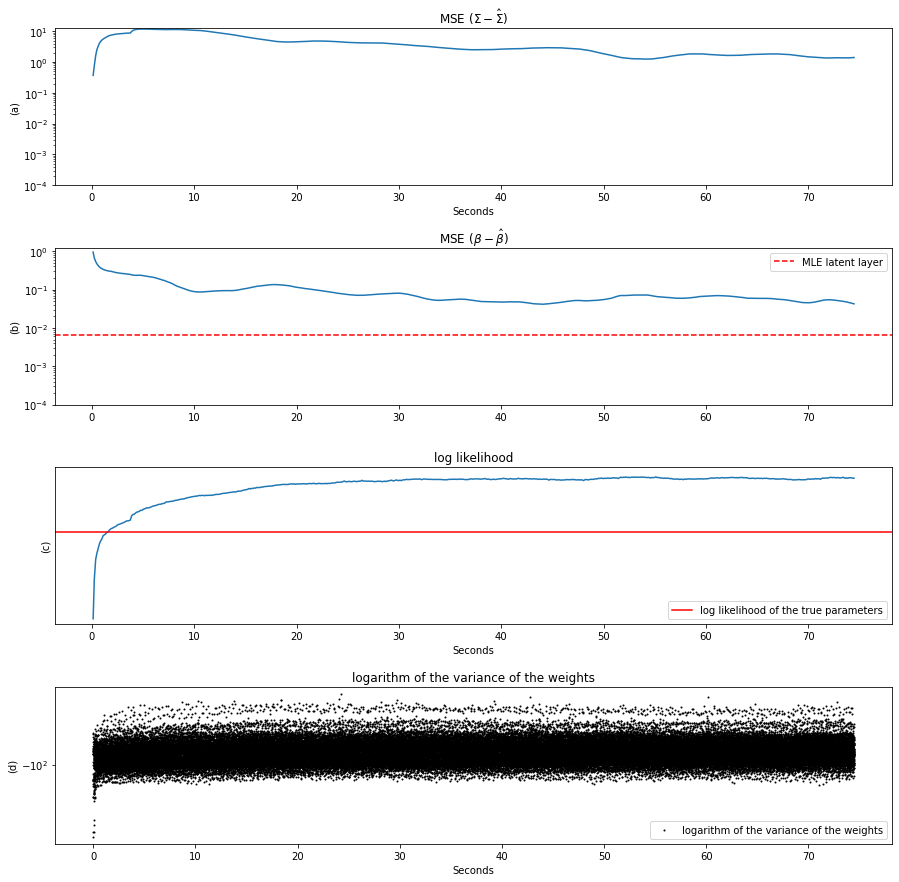

In [54]:
show(model, 'best,n=1000,p=30,q=10', save = False)

log_f : tensor([[ -84.3989, -105.7347,  -90.1050,  ...,  -46.7578,  -51.4355,
          -83.1451],
        [ -83.0345, -103.2649,  -88.2417,  ...,  -45.0613,  -49.5447,
          -81.0894],
        [ -81.8474, -101.6119,  -86.4281,  ...,  -43.2918,  -48.0769,
          -80.0047],
        ...,
        [ -87.1268, -108.4659,  -92.7185,  ...,  -48.9541,  -53.0739,
          -84.9154],
        [ -82.0114, -101.3793,  -86.3345,  ...,  -43.4119,  -48.3669,
          -80.5109],
        [ -86.2630, -106.0226,  -89.8991,  ...,  -47.3530,  -52.3848,
          -85.0400]], grad_fn=<AddBackward0>)


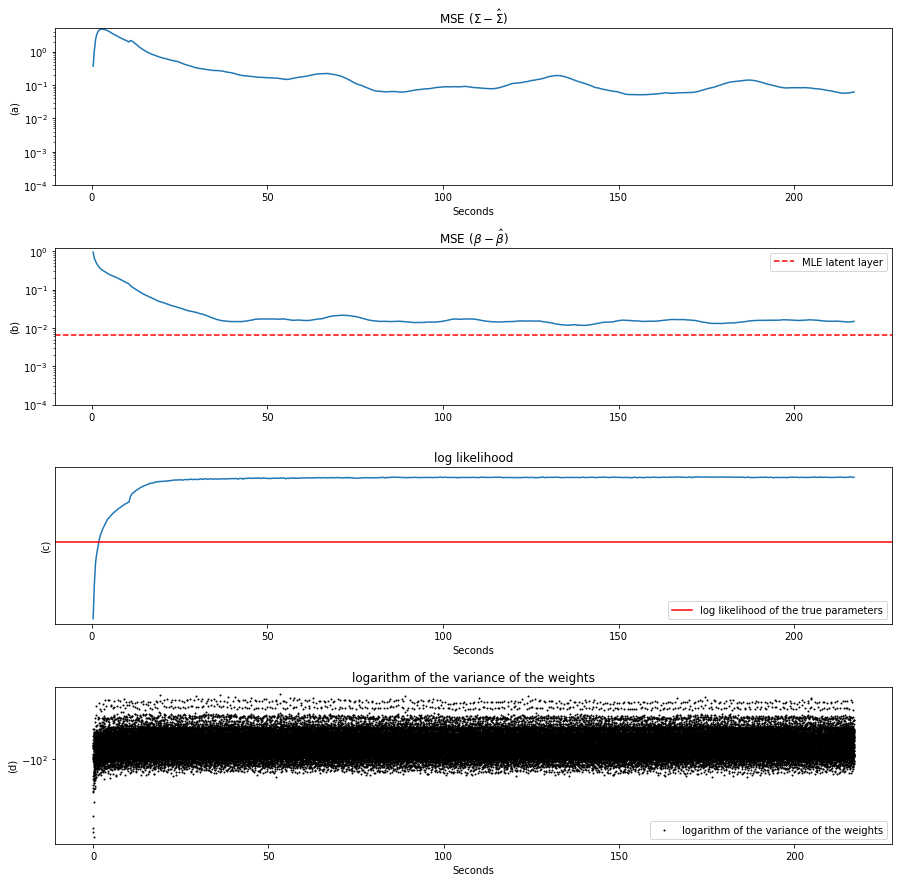

In [56]:
show(model, 'best,n=1000,p=30,q=10', save = False)

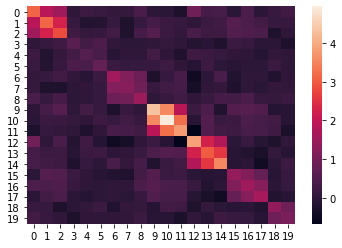

In [57]:
model.show_Sigma()

<AxesSubplot:>

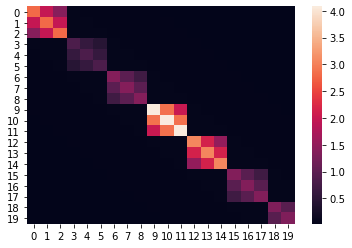

In [58]:
sns.heatmap(Sigma_sampling)

<AxesSubplot:title={'center':'$\\Sigma$'}>

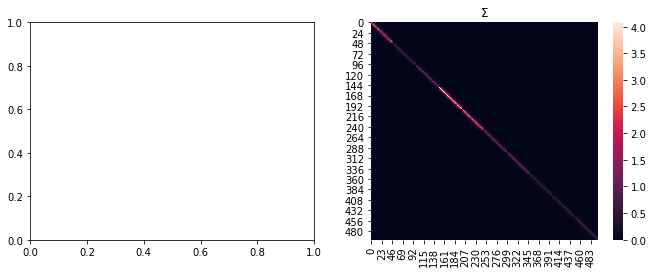

In [23]:
#mat = model.C_mean.detach().numpy()

fig,axes = plt.subplots(1,2,figsize = (11.2,4))
#axes[0].set_title(r'$\hat \Sigma$')
#sns.heatmap(mat@(mat.T),ax = axes[0])
axes[1].set_title(r'$\Sigma$')
sns.heatmap(Sigma_sampling,ax = axes[1])
#plt.savefig('best result Sigma')

<AxesSubplot:>

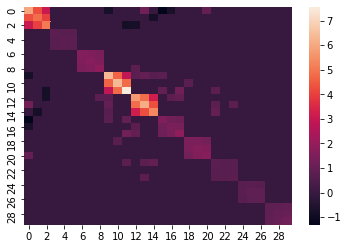

In [124]:
Sig = mat@(mat.T)
sns.heatmap(Sig * (np.abs(Sig) > 0.7))

In [91]:
torch.nan_to_num(torch.log(torch.from_numpy(model.var_weights[0:30])),neginf = -1000)

tensor([ -156.3740,  -190.7391,  -206.3035,  -177.1579,  -430.1877,  -530.9578,
         -286.1344,  -711.3682,  -690.1172,  -578.2244,  -128.1276,  -181.9416,
          -78.1325,  -338.8226,  -270.0796,  -652.3436, -1000.0000, -1000.0000,
         -234.5263,  -469.0022,  -149.7687, -1000.0000,  -489.5154,  -514.4129,
         -109.7870, -1000.0000,  -712.0253,  -155.6299, -1000.0000,  -145.8789])

<AxesSubplot:>

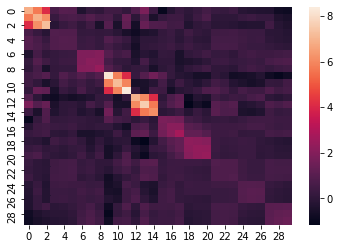

In [111]:
sns.heatmap((model.C_mean@(model.C_mean.T)).detach().numpy())

<AxesSubplot:>

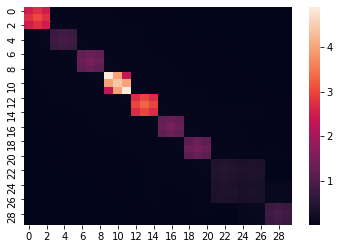

In [112]:
sns.heatmap(true_Sigma_sampling)

In [45]:
def show(model,name_doss , save = False):
    '''
    function to show one model. It will plot the MSE of Sigma and beta according to the true parameters and 
    the log_likelihood in the y axis with the runtime in the x-axis.Will also plot the norm of the gradients and 
    the variance of the weights used for the importance sampling. 
    
    args : 
        'model' MC_PLNPCA object where you have called model.fit_IMPS()
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. It can also save the figure if save = True. 
    '''
    best_model = Basic_IMPS(q, average = 100, true_value = True)
    best_model.init_data(Y, O, covariates)
    best_model.Y_b,best_model.O_b, best_model.covariates_b, best_model.batch_size = Y, O, covariates, n
    best_log_like = best_model.infer_batch_p_theta(1000, 0.1, 1000)
    fig,ax = plt.subplots(4,1,figsize = (15,15))
    #max_ = max(best_log_like,np.max(np.array(model.log_likelihood_list)))
    max_ = 0 
        
    d = model.beta.shape[0]
    #MSE of Sigma
    abscisse = model.running_times
    plt.subplots_adjust(hspace = 0.4)
    ax[0].plot(abscisse, model.MSE_Sigma_list)
    ax[0].set_title(r'MSE $(\Sigma- \hat \Sigma)$')
    #ax[0].axhline(best_MSE_Sigma, label = 'MLE latent layer ', c = 'red', linestyle = '--')
    ax[0].set_xlabel('Seconds')
    ax[0].set_ylim(ymin= 1e-4)
    ax[0].set_ylabel('(a)')
    ax[0].set_yscale('log')
    
    #MSE of beta. 
    ax[1].plot(abscisse, model.MSE_beta_list)
    ax[1].set_title(r'MSE $(\beta - \hat \beta)$') 
    ax[1].axhline(best_MSE_beta, label = 'MLE latent layer', c = 'red', linestyle = '--')
    ax[1].set_yscale('log')
    ax[1].set_ylim(ymin= 1e-4)
    ax[1].set_ylabel('(b)')
    ax[1].legend()
    
    #log likelihood of the model. will also plot the log likelihood of the model with the true parameters. 
    ax[2].plot(abscisse, np.array(model.log_likelihood_list)-max_)
    ax[2].set_title('log likelihood')
    ax[2].set_ylabel('loglikelihood')
    ax[2].set_xlabel('Seconds')
    #variational_log_like = variational_model.compute_mean_log_likelihood(0.0001)[0].item()
    #ax[2].axhline(variational_log_like, c = 'black', label = 'variaitional likelihood')
    ax[2].axhline(best_log_like-max_, c = 'red', label = 'log likelihood of the true parameters')
    ax[2].set_yscale('symlog')
    ax[2].set_ylabel('(c)')
    ax[2].legend()
    
    ax[3].scatter(np.linspace(0,abscisse[-1], model.var_weights.shape[0]), 
                  torch.nan_to_num(torch.log(torch.from_numpy(model.var_weights)),neginf = -1000)
                  ,s = 1, label = 'logarithm of the variance of the weights', c = 'black')
    ax[3].set_title('logarithm of the variance of the weights')# '+ str(np.round(percentage_bad_beta,3)))
    ax[3].set_yscale('symlog')
    ax[3].set_ylabel('(d)')
    ax[3].set_xlabel('Seconds')
    ax[3].legend()
    '''
    # plot the L1 norm of the gradients. 
    ax[3].plot(abscisse, model.norm_grad_log_C_list, label = 'norm grad loglike C')
    ax[3].plot(abscisse, model.norm_grad_log_beta_list, label = 'norm grad loglike beta')
    ax[3].set_title('Norm Gradients loglike ')
    ax[3].set_ylabel('L1 norm')
    ax[3].set_yscale('log')
    ax[3].legend()
    
    
    #here we plot the variance for the 3 integrals. We set a threshold from which we consider that the integral 
    # is misestimate if the variance of the weights is above. 
    threshold = 0.9
    # integral for beta 
    ax[4].scatter( np.linspace(0,abscisse[-1], model.var_weights['beta'].shape[0]), model.var_weights['beta'],s = 1, label = 'variance of the weights for beta', c = 'black')
    percentage_bad_beta = np.sum(model.var_weights['beta']>threshold)/(model.var_weights['beta'].shape[0])
    ax[4].axhline(model.acc, c = 'red', label = 'reference')
    ax[4].set_title('Variance beta, pourcentage of bad approximations : '+ str(np.round(percentage_bad_beta,3)))
    ax[4].set_yscale('log')
    ax[4].legend()
    '''
    if save : 
        plt.savefig(name_doss)
    plt.show()

log_f : tensor([[ -84.3989, -105.7347,  -90.1050,  ...,  -46.7578,  -51.4355,
          -83.1451],
        [ -83.0345, -103.2649,  -88.2417,  ...,  -45.0613,  -49.5447,
          -81.0894],
        [ -81.8474, -101.6119,  -86.4281,  ...,  -43.2918,  -48.0769,
          -80.0047],
        ...,
        [ -87.1268, -108.4659,  -92.7185,  ...,  -48.9541,  -53.0739,
          -84.9154],
        [ -82.0114, -101.3793,  -86.3345,  ...,  -43.4119,  -48.3669,
          -80.5109],
        [ -86.2630, -106.0226,  -89.8991,  ...,  -47.3530,  -52.3848,
          -85.0400]], grad_fn=<AddBackward0>)


NameError: name 'best_MSE_beta' is not defined

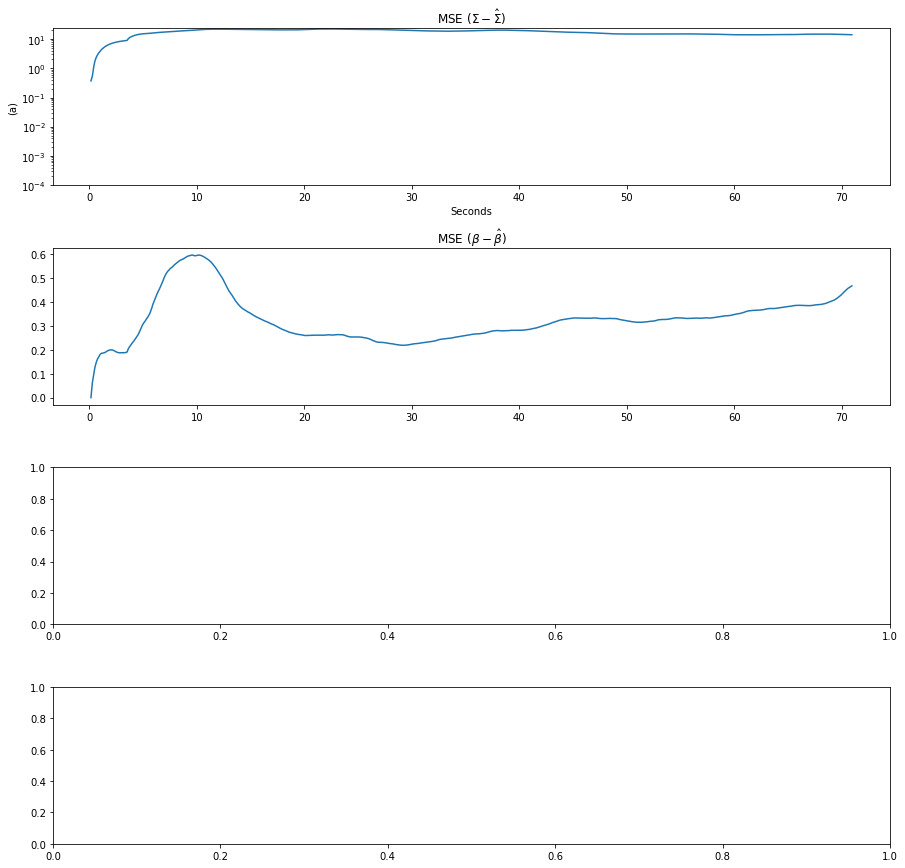

In [46]:
show(model, '')

MLE :


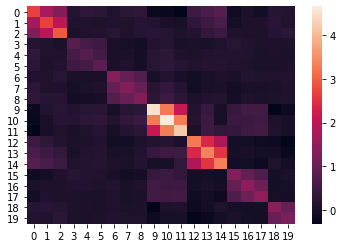

true Sigma


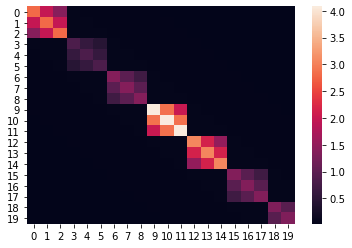

Best MSE we can have (in our dream):  tensor(0.0378)


In [48]:
## Here we plot the MLE for Z the latent variables. They are unknown in practice
## this is just to see the difference between our result and the best result possible 
mu_MLE = torch.mean(Z, dim = 0)
m = mu_MLE.shape[0]
Sigma_MLE = 1/Z.shape[0]*((Z-mu_MLE).T)@(Z-mu_MLE)
print('MLE :')
sns.heatmap(Sigma_MLE.to(torch.device('cpu')))
plt.show()
print('true Sigma')
sns.heatmap(Sigma_sampling.to(torch.device('cpu')))
plt.show()
best_MSE_Sigma = torch.mean((Sigma_MLE.to(device)-Sigma_sampling)**2)
print('Best MSE we can have (in our dream): ', best_MSE_Sigma)

In [49]:
target = Z+ torch.mm(covariates,true_beta)

clf = LinearRegression()
clf.fit(covariates,target)
beta_dream = torch.from_numpy(clf.coef_.T)
best_MSE_beta = torch.mean((beta_dream-true_beta)**2)
print('MSE beta in the latent layer: ', best_MSE_beta)

MSE beta in the latent layer:  tensor(0.0066)


In [35]:
from fastPLN import fastPLN
fastmodel = fastPLN()
%time fastmodel.fit(Y,O,covariates, 250)
print('MSE Sigma', torch.mean((fastmodel.Sigma-true_Sigma_sampling)**2))
print('MSE beta', torch.mean((fastmodel.beta-true_beta)**2))

CPU times: user 10min 13s, sys: 2.2 s, total: 10min 15s
Wall time: 1min 53s
MSE Sigma tensor(0.0484, grad_fn=<MeanBackward0>)
MSE beta tensor(0.0816, grad_fn=<MeanBackward0>)


<AxesSubplot:>

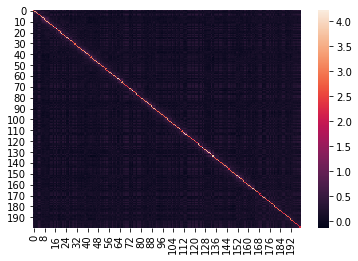

In [33]:
sns.heatmap(fastmodel.Sigma[0:200,0:200].detach())

<AxesSubplot:>

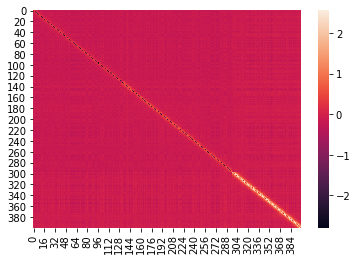

In [34]:
sns.heatmap((Sigma_sampling-fastmodel.Sigma)[200:600,200:600].detach())

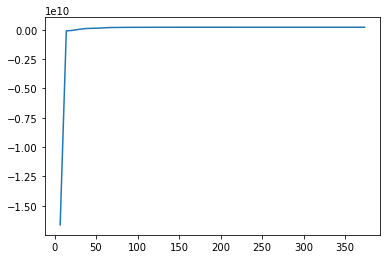

In [28]:
plt.plot(fastmodel.running_times, fastmodel.ELBO_list)

In [30]:
fastmodel.beta

tensor([[-1.4378e-01,  5.9384e-02,  5.6383e-02,  7.8254e-01, -1.9169e-01,
         -1.0719e-01, -1.4404e-01,  2.1642e-01,  1.2724e-01,  4.6581e-01,
         -7.6381e-02,  3.3575e-01, -2.6257e-01, -4.2131e-02, -4.3008e-01,
         -1.3453e-01,  4.3975e-01, -1.9500e-01, -1.3030e-01,  1.6599e-01,
          1.8961e-01,  6.5447e-02,  1.3495e-02, -6.7433e-01, -8.8611e-02,
          2.8640e-03, -1.1113e-01,  2.8274e-01, -2.8810e-01, -4.4610e-01,
         -1.7305e-01,  3.4154e-01,  2.4186e-01, -1.5015e-01, -1.1416e-01,
         -4.4246e-02, -2.9082e-01, -1.9032e-01,  3.1881e-01,  1.0805e-01,
         -1.4794e-01,  7.8668e-02,  2.5408e-01,  3.2574e-01,  1.4339e-01,
          2.2516e-01,  2.7646e-02, -1.1163e-02, -2.5448e-03,  3.2143e-01,
          1.1116e-01,  3.1532e-01, -5.0074e-01, -1.6516e-01, -1.9464e-01,
         -3.3426e-01,  4.0599e-01, -7.0797e-02,  2.4021e-01,  1.9292e-01,
          3.0238e-01,  1.0628e-01,  1.0017e-01,  2.2249e-01,  2.1344e-01,
         -3.7313e-01,  2.3939e-01,  2.

In [31]:
true_beta

tensor([[-1.4034e-01,  6.6023e-02,  6.7386e-02,  7.9302e-01, -1.8478e-01,
         -1.1928e-01, -1.5474e-01,  2.1400e-01,  1.2317e-01,  4.7018e-01,
         -7.1213e-02,  3.2946e-01, -2.6458e-01, -4.1022e-02, -4.2772e-01,
         -1.2875e-01,  4.4238e-01, -1.8795e-01, -1.3346e-01,  1.7288e-01,
          1.8986e-01,  6.0489e-02,  8.8402e-03, -6.8399e-01, -9.7895e-02,
          7.7152e-04, -1.1170e-01,  2.8736e-01, -2.8902e-01, -4.4466e-01,
         -1.6801e-01,  3.4013e-01,  2.5110e-01, -1.5167e-01, -1.0967e-01,
         -5.0301e-02, -2.9695e-01, -1.9664e-01,  3.0729e-01,  1.0906e-01,
         -1.5661e-01,  7.0874e-02,  2.4648e-01,  3.3079e-01,  1.4800e-01,
          2.1874e-01,  2.8755e-02, -1.2288e-02, -1.5739e-02,  3.1915e-01,
          1.0550e-01,  3.1272e-01, -4.9937e-01, -1.6968e-01, -1.9802e-01,
         -3.3528e-01,  4.0402e-01, -6.6685e-02,  2.4315e-01,  2.0114e-01,
          3.1313e-01,  1.1737e-01,  1.0762e-01,  2.3149e-01,  2.2150e-01,
         -3.7479e-01,  2.4513e-01,  2.